### Target: Use Nidv onto random latent variable logits before Gumbel Sampling;

### To cancel the diversity loss, to that we can see the problem clearly;
 
### Notice: this version is different from version2, why did I use version2 in the first place ??

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
from torch import optim
from collections import Counter
from NDiv.ndiv_pytorch import NDiv_loss

tensor([[2, 3],
        [2, 3],
        [1, 3],
        ...,
        [2, 1],
        [2, 1],
        [1, 2]])


([<matplotlib.axis.XTick at 0x7fcd660970f0>,
 <a list of 8 Text xticklabel objects>)

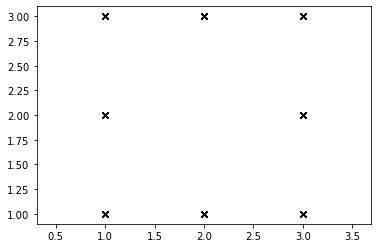

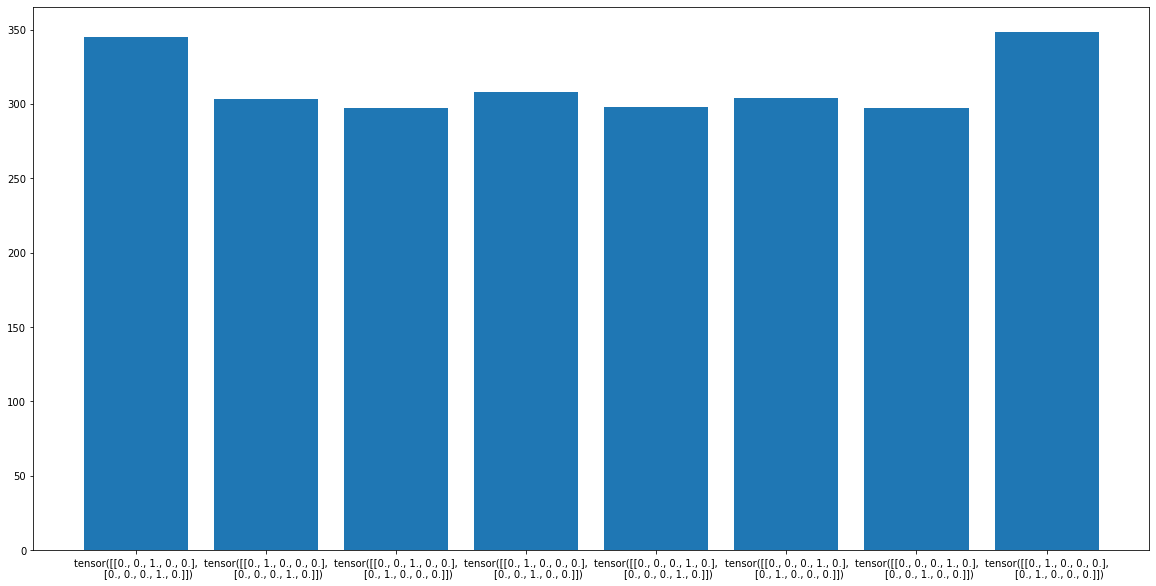

In [8]:
from loadDataset import *
from visualizer import *

data_config = {
    'name' : 'gaussian_grid',
    'n' : 5,
    'n_data' : 100,
    'sig' : 0.01
}

ds = getDataset(data_config)
dl = DataLoader(ds, batch_size=128, shuffle=True)

# gt data func, for train
def gen_real_data_onehot(dl, batch=128):

    real_samples = next(iter(dl))

    ''' delete adjacent modes from dataset '''
    mode_idx = [6,7, 8,11,13, 16, 17, 18]
    real_samples_new = [real_samples[i] for i in mode_idx]
    real_samples = real_samples_new
    
    ''' mix 25 modes '''
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2).long()

    ''' make dataset unbalanced '''
#     real_samples = real_samples[800:]
#     real_samples = real_samples[:-800]
    
    random_choice = torch.randint(0, real_samples.shape[0], (batch, )).long()
    data = real_samples[random_choice]
    data = torch.unsqueeze(data, -1)

    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

# data = gen_real_data_onehot(dl)

# gt data func, for test
def gen_real_data_test(dl, batch=128):

    real_samples = next(iter(dl))

    # mix 25 modes
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2)
    real_samples = torch.unsqueeze(real_samples, -1).long()
    
    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

def gen_input_data(batch=128):
    # https://pytorch.org/docs/stable/torch.html#torch.randn
    data = torch.zeros(int(batch/2), 2)
    data[:, 0] = 0.5
    data[:, 1] = -0.5
    return torch.cat((data, data), 0)

#     data = torch.randn(int(batch/ 2), 2)
#     return torch.cat((data, data), 0)

def gen_input_data_test(batch=128):
    return torch.randn(batch, 2)

''' Plot Distribution for Unbalanced Dataset '''

data = gen_real_data_onehot(dl, 2500)
print(torch.argmax(data,-1))
data_list = [str(x) for x in data]

# plot grid
plot_outputdata(torch.argmax(data, -1), dim1=0, dim2=1, marker='kx', alpha=0.1)

# plot bar chart
index = range(len(Counter(data_list).keys()))
plt.figure(figsize=(20,10))
plt.bar(index, Counter(data_list).values(), align='center')
plt.xticks(index, Counter(data_list).keys())

In [9]:
### Define Gumbel Function Utility

def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape).cuda()
    h = (g + logits) * temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [13]:
### G Network based on gumbel
class MLPG(nn.Module):
    
    def __init__(self, input_size, hidden_size, noise_size, output_size, temperature=1):
        super(MLPG, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3_1 = nn.Linear(hidden_size + noise_size, output_size) # x-axis
        self.map3_2 = nn.Linear(hidden_size + noise_size, output_size) # y-axis
        
        self.name = 'MLPG'
        self.noise_size = noise_size
        self.temp = temperature
        
    def forward(self, x, temperature=None):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size).cuda()

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # perform gumbel sampling
        if temperature is not None:
            x_coord = sample_gumbel_softmax(x_coord, temperature)
            y_coord = sample_gumbel_softmax(y_coord, temperature)
        else:
            x_coord = sample_gumbel_softmax(x_coord, self.temp)
            y_coord = sample_gumbel_softmax(y_coord, self.temp)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1), noise
    
    def checkLogits(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size)

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1)
    
### D Network to produce loss
class MLPD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPD, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, output_size)
        self.name = 'MLPD'
        
    def forward(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        return torch.sigmoid(self.map2(x))
    
### Create the overall network
class gumbel_gan(object):
    def __init__(self, temperature=1):
        self.g = MLPG(2, 128, 25, 5, temperature=temperature).cuda()
        self.d = MLPD(10, 128, 1).cuda()
        
        self.g_optim = optim.Adam(self.g.parameters(), lr=1e-4)
        self.d_optim = optim.Adam(self.d.parameters(), lr=1e-4)
        
        self.d_step = 1
#         self.g_step = 10
        self.g_step = 1
        self.g_NDiv = 3
        
        self.criterion = nn.BCELoss()
        
    def train(self, epoch, real_data, g_input):
        print("training start")
        pbar = range(epoch)
        batch = real_data.shape[0]
        
        for ep in pbar:
            for d_index in range(self.d_step):
                
                # Train D
                self.d.zero_grad()
                
                # Train D on real
                d_real_decision = self.d(real_data)
                labels = torch.ones(d_real_decision.shape, dtype=torch.float32).cuda()
                d_real_loss = self.criterion(d_real_decision, labels)
                
                # Train D on fake
                fake_data, latent_samples = self.g(g_input)
                d_fake_decision = self.d(fake_data.view(batch, -1))
                labels = torch.zeros(d_fake_decision.shape, dtype=torch.float32).cuda()
                
                d_fake_loss = self.criterion(d_fake_decision, labels)

                # calc loss for D
                d_loss = 0.5 * (d_real_loss + d_fake_loss)
#                 d_loss = 0.5 * (d_real_loss + d_fake_loss)
                d_loss.backward()
                d_loss_val = d_loss.item()
                
                # update D
                self.d_optim.step()
                
            """ optim NDiv diversity """
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                # print(latent_samples.shape)
                # raise
                div_loss = NDiv_loss(latent_samples, g_fake_data) * 2.5e2
                div_loss_val = div_loss.item()
                
                # update G w.r.t NDiv
                div_loss.backward()
                self.g_optim.step()
                
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                batch = g_fake_data.shape[0]
                
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                
                # G loss
                labels = torch.ones(g_fake_decision.shape, dtype=torch.float32).cuda()
                g_loss = -(g_fake_decision.log() * labels + (1-labels)*(1-g_fake_decision.log())).mean()
                
                g_loss_val = g_loss.item()
                
                g_loss.backward()
                
                # update G
                self.g_optim.step()
                
            print("Iteration {}, d real/fake loss {}/{} and g loss is {}, NDiv loss {}".format(ep, d_real_loss.item(), \
                                                                                 d_fake_loss.item(), g_loss, div_loss_val))            

In [14]:
## Init the simple Network
## Define temperature here
net = gumbel_gan(temperature=1)
print(net.g, net.d)

MLPG(
  (map1): Linear(in_features=2, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=128, bias=True)
  (map3_1): Linear(in_features=153, out_features=5, bias=True)
  (map3_2): Linear(in_features=153, out_features=5, bias=True)
) MLPD(
  (map1): Linear(in_features=10, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=1, bias=True)
)


Processing Epoch 0
training start
Iteration 0, d real/fake loss 0.7120044231414795/0.6726939678192139 and g loss is 0.7175068855285645, NDiv loss 0.0730011984705925
Iteration 1, d real/fake loss 0.7110912203788757/0.6676104068756104 and g loss is 0.7157012224197388, NDiv loss 0.07068038731813431
Iteration 2, d real/fake loss 0.7102036476135254/0.6697288155555725 and g loss is 0.7151338458061218, NDiv loss 0.07586650550365448
Iteration 3, d real/fake loss 0.7093390822410583/0.6706390380859375 and g loss is 0.7142711877822876, NDiv loss 0.07695012539625168
Iteration 4, d real/fake loss 0.7084598541259766/0.673475980758667 and g loss is 0.7138133645057678, NDiv loss 0.07197657227516174


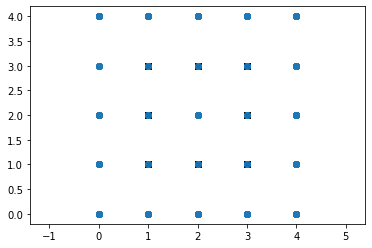

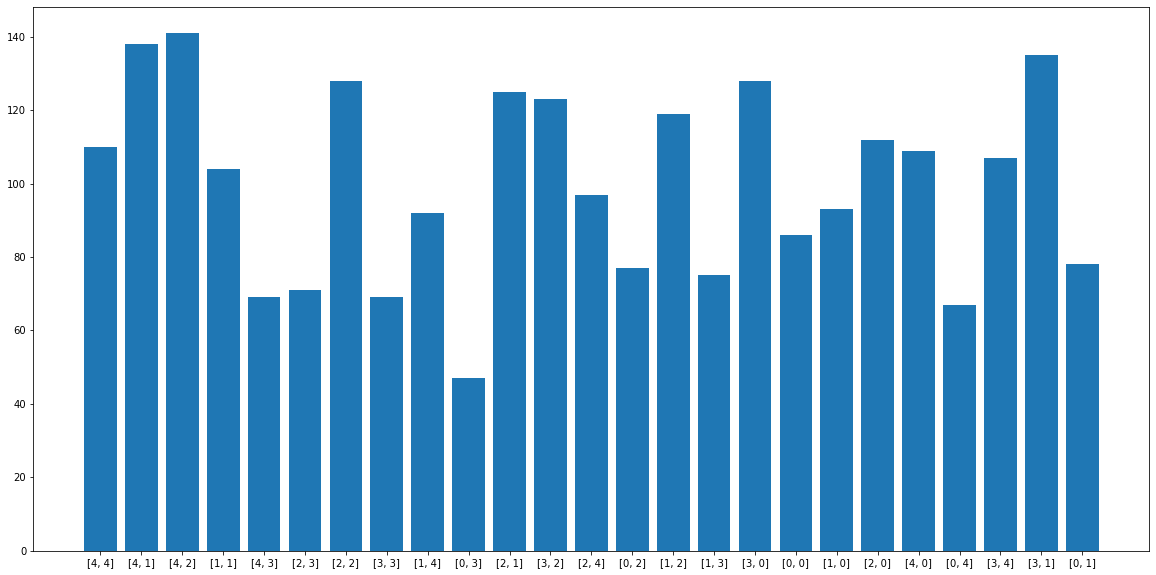

Processing Epoch 1
training start
Iteration 0, d real/fake loss 0.7121045589447021/0.6725733280181885 and g loss is 0.7127900123596191, NDiv loss 0.07188452780246735
Iteration 1, d real/fake loss 0.7112171053886414/0.6715719699859619 and g loss is 0.7153220772743225, NDiv loss 0.0710241049528122
Iteration 2, d real/fake loss 0.7103197574615479/0.6732019186019897 and g loss is 0.7150731086730957, NDiv loss 0.06726928800344467
Iteration 3, d real/fake loss 0.7094292640686035/0.674039363861084 and g loss is 0.7146097421646118, NDiv loss 0.0712740421295166
Iteration 4, d real/fake loss 0.7085447311401367/0.6736443638801575 and g loss is 0.7122874855995178, NDiv loss 0.07292342931032181


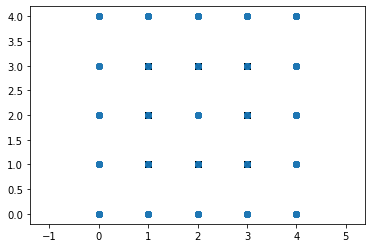

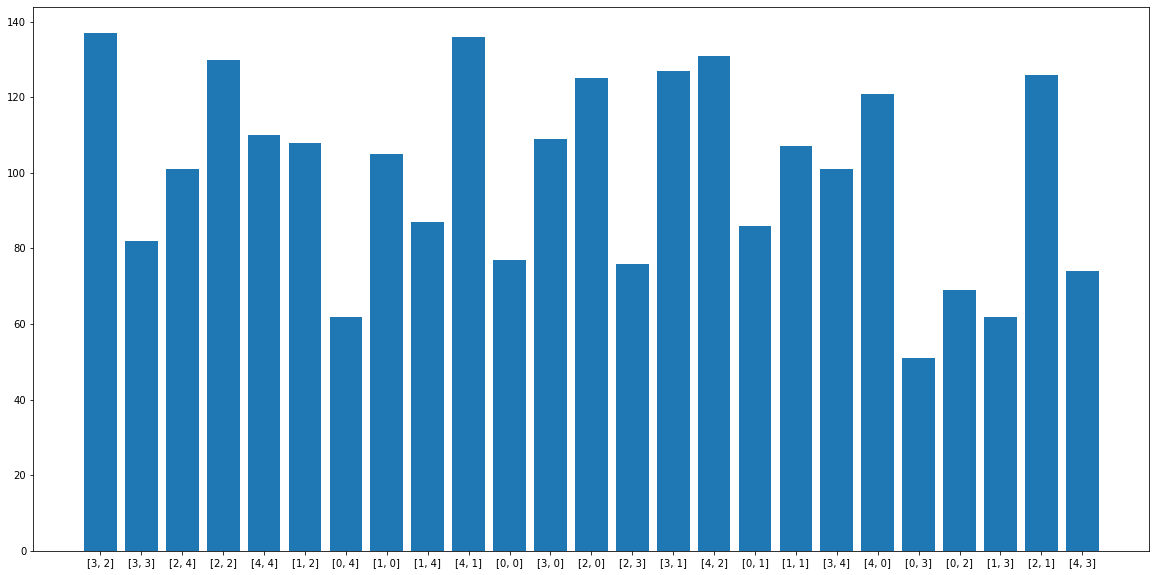

Processing Epoch 2
training start
Iteration 0, d real/fake loss 0.7006224393844604/0.675749659538269 and g loss is 0.7146310806274414, NDiv loss 0.07071392238140106
Iteration 1, d real/fake loss 0.6997838020324707/0.6739858388900757 and g loss is 0.7093557119369507, NDiv loss 0.07392307370901108
Iteration 2, d real/fake loss 0.6989556550979614/0.6757124662399292 and g loss is 0.7128571271896362, NDiv loss 0.0725817084312439
Iteration 3, d real/fake loss 0.6981409192085266/0.67658931016922 and g loss is 0.7121102809906006, NDiv loss 0.0707574114203453
Iteration 4, d real/fake loss 0.6973387598991394/0.6745628118515015 and g loss is 0.7126336097717285, NDiv loss 0.06979023665189743


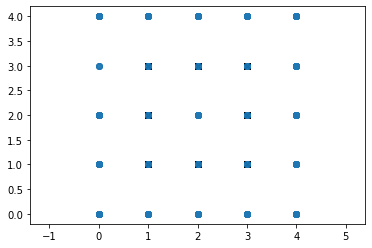

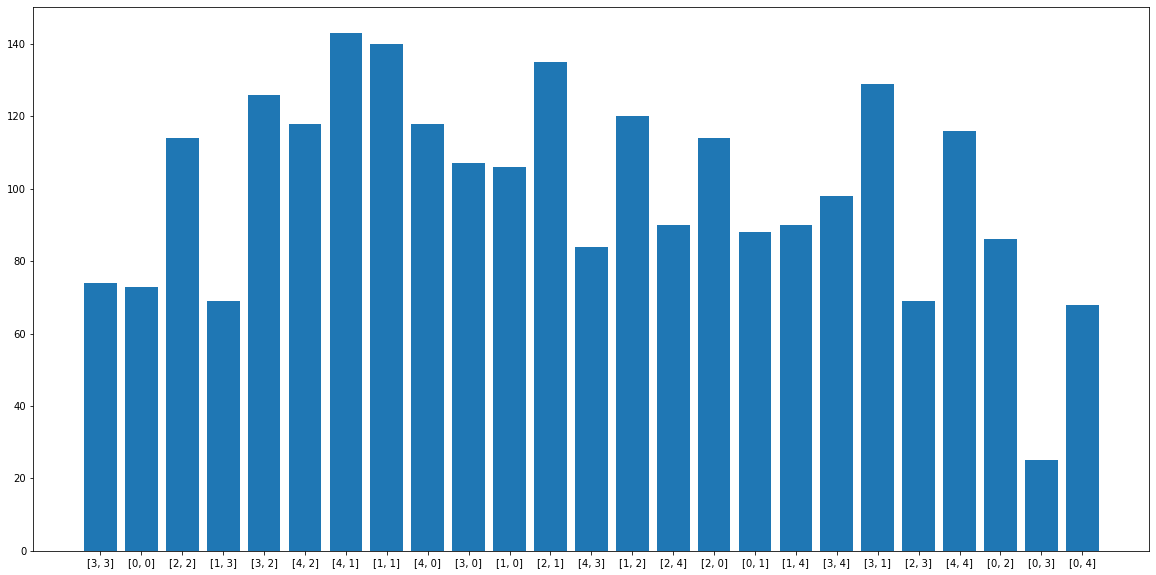

Processing Epoch 3
training start
Iteration 0, d real/fake loss 0.6929618120193481/0.6749197840690613 and g loss is 0.7111017107963562, NDiv loss 0.07065483927726746
Iteration 1, d real/fake loss 0.6921966671943665/0.677998423576355 and g loss is 0.711280107498169, NDiv loss 0.07357710599899292
Iteration 2, d real/fake loss 0.6914401650428772/0.6763004064559937 and g loss is 0.711884617805481, NDiv loss 0.07142786681652069
Iteration 3, d real/fake loss 0.6906867027282715/0.6754484176635742 and g loss is 0.7099354863166809, NDiv loss 0.07240894436836243
Iteration 4, d real/fake loss 0.6899420022964478/0.6729336977005005 and g loss is 0.7093960642814636, NDiv loss 0.07563681900501251


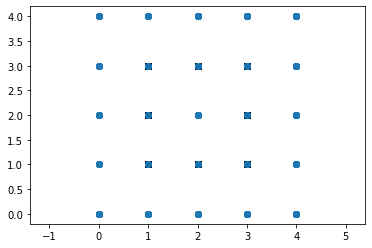

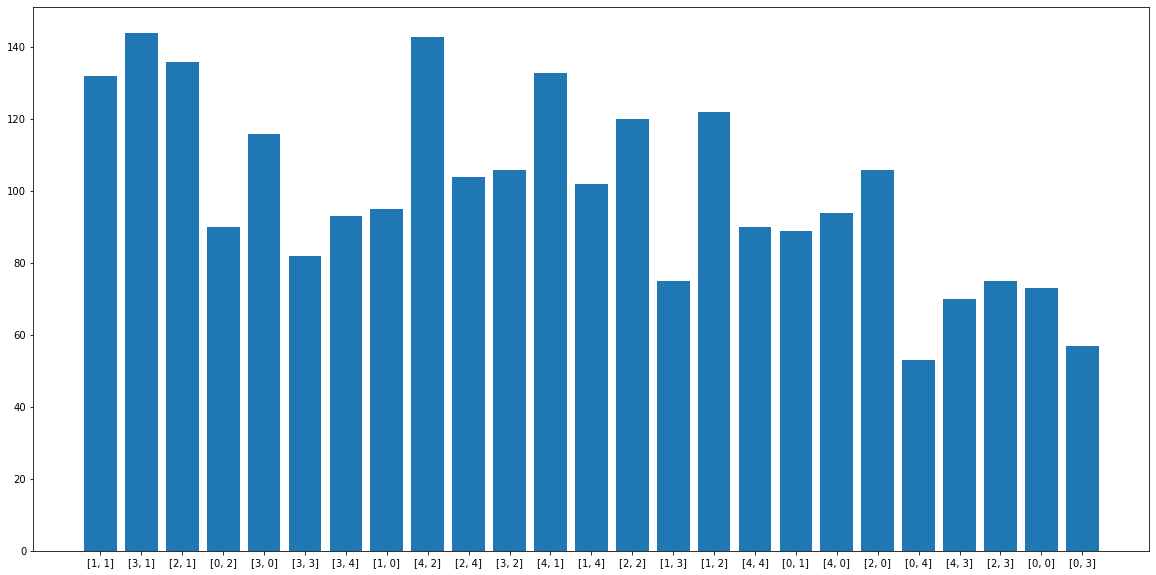

Processing Epoch 4
training start
Iteration 0, d real/fake loss 0.6886276006698608/0.677574872970581 and g loss is 0.7116198539733887, NDiv loss 0.07648858428001404
Iteration 1, d real/fake loss 0.6879040002822876/0.6769649982452393 and g loss is 0.7078340649604797, NDiv loss 0.07585761696100235
Iteration 2, d real/fake loss 0.6871843934059143/0.6769794225692749 and g loss is 0.7083225250244141, NDiv loss 0.07141315191984177
Iteration 3, d real/fake loss 0.6864646673202515/0.6788700222969055 and g loss is 0.7091102004051208, NDiv loss 0.07516513764858246
Iteration 4, d real/fake loss 0.6857463121414185/0.6767770051956177 and g loss is 0.7069990634918213, NDiv loss 0.07387389242649078


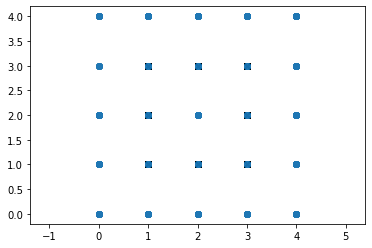

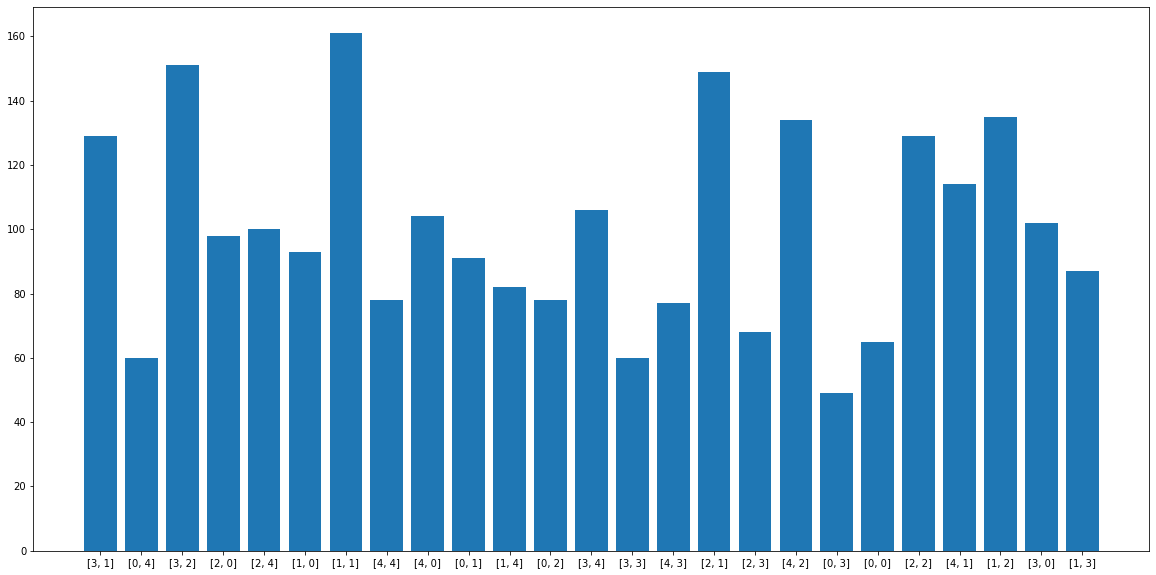

Processing Epoch 5
training start
Iteration 0, d real/fake loss 0.6935375928878784/0.6786669492721558 and g loss is 0.7075913548469543, NDiv loss 0.07342115044593811
Iteration 1, d real/fake loss 0.6927837133407593/0.6775718927383423 and g loss is 0.7069722414016724, NDiv loss 0.07264546304941177
Iteration 2, d real/fake loss 0.6920316219329834/0.6732825040817261 and g loss is 0.7097693681716919, NDiv loss 0.07596675306558609
Iteration 3, d real/fake loss 0.6912721991539001/0.6774627566337585 and g loss is 0.7089163661003113, NDiv loss 0.0759209468960762
Iteration 4, d real/fake loss 0.6905151605606079/0.6796272993087769 and g loss is 0.7093650102615356, NDiv loss 0.07099761068820953


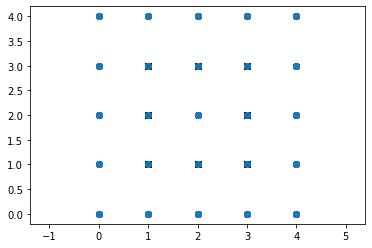

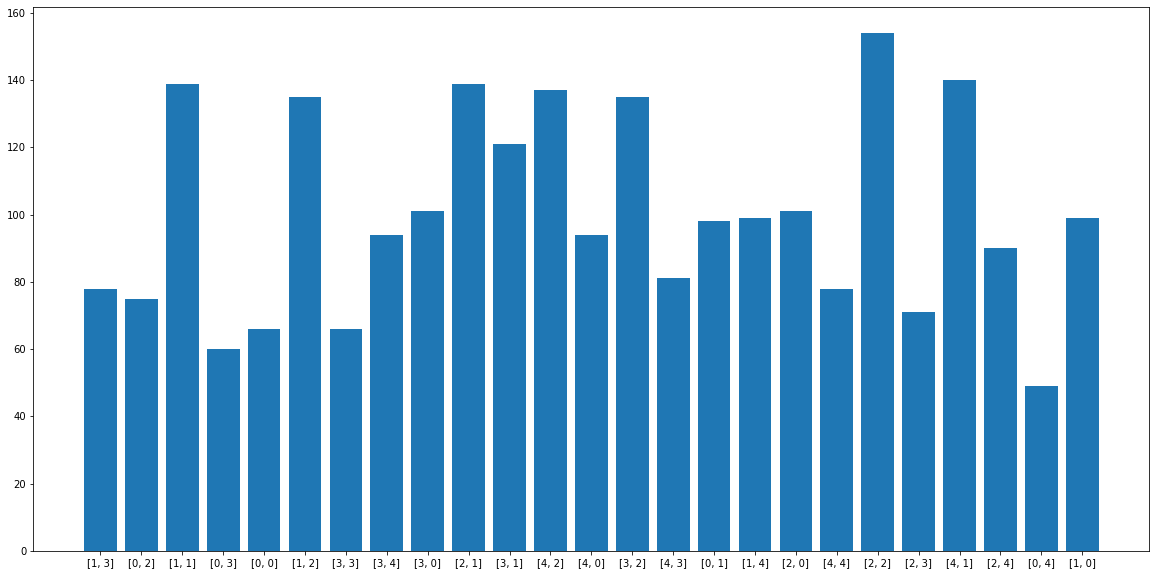

Processing Epoch 6
training start
Iteration 0, d real/fake loss 0.6855530738830566/0.6788217425346375 and g loss is 0.7071545124053955, NDiv loss 0.07571399956941605
Iteration 1, d real/fake loss 0.6848530769348145/0.6805664896965027 and g loss is 0.7077498435974121, NDiv loss 0.06919077783823013
Iteration 2, d real/fake loss 0.6841554045677185/0.6805216073989868 and g loss is 0.7054834365844727, NDiv loss 0.07849551737308502
Iteration 3, d real/fake loss 0.6834596395492554/0.6819525957107544 and g loss is 0.7041838765144348, NDiv loss 0.07278196513652802
Iteration 4, d real/fake loss 0.6827660799026489/0.6810189485549927 and g loss is 0.7071323990821838, NDiv loss 0.07472247630357742


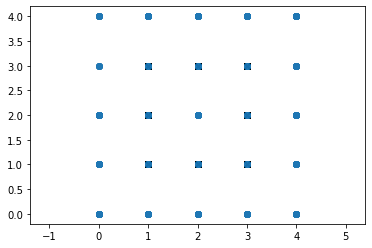

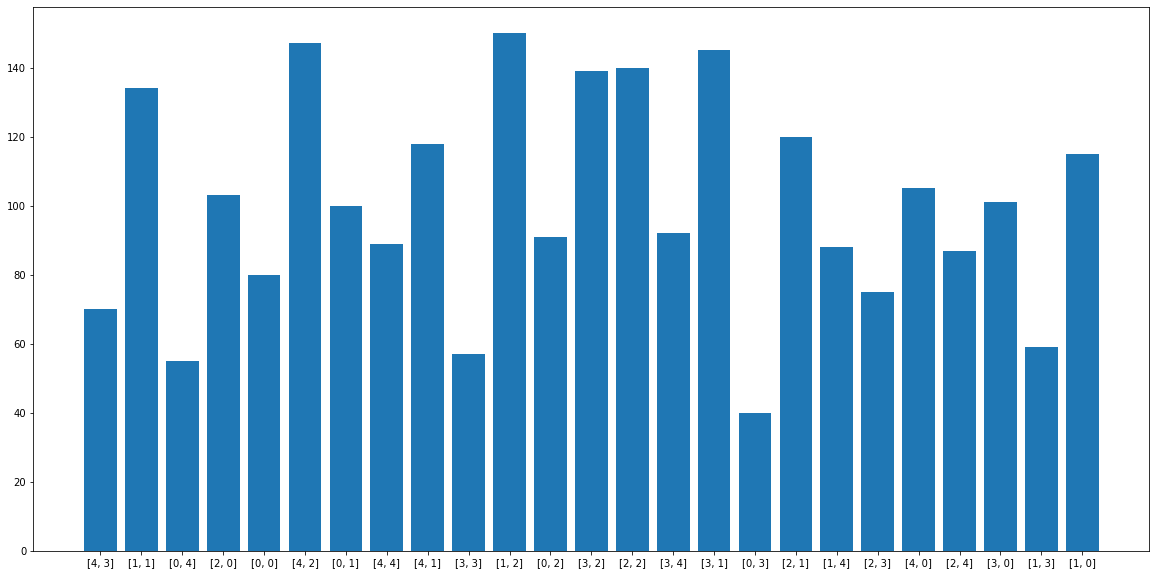

Processing Epoch 7
training start
Iteration 0, d real/fake loss 0.6854677796363831/0.6814402341842651 and g loss is 0.7086632251739502, NDiv loss 0.07074888050556183
Iteration 1, d real/fake loss 0.6847761273384094/0.6850839257240295 and g loss is 0.7047564387321472, NDiv loss 0.07266578823328018
Iteration 2, d real/fake loss 0.6840947270393372/0.6827155947685242 and g loss is 0.7062265872955322, NDiv loss 0.07345259189605713
Iteration 3, d real/fake loss 0.6834151744842529/0.6782238483428955 and g loss is 0.7044559121131897, NDiv loss 0.07372423261404037
Iteration 4, d real/fake loss 0.6827399134635925/0.6826809644699097 and g loss is 0.7061253190040588, NDiv loss 0.07152654230594635


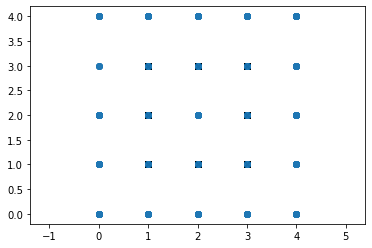

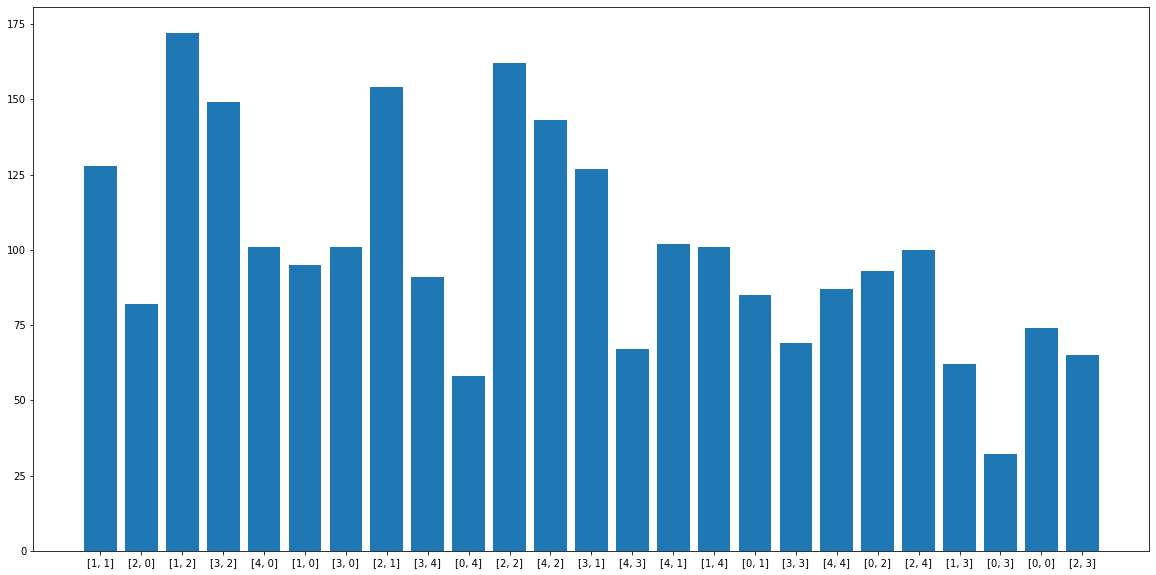

Processing Epoch 8
training start
Iteration 0, d real/fake loss 0.6777157783508301/0.6819473505020142 and g loss is 0.7059604525566101, NDiv loss 0.08033579587936401
Iteration 1, d real/fake loss 0.6771283149719238/0.6830204725265503 and g loss is 0.7049665451049805, NDiv loss 0.07265647500753403
Iteration 2, d real/fake loss 0.6765369176864624/0.6833900213241577 and g loss is 0.7040178775787354, NDiv loss 0.07285373657941818
Iteration 3, d real/fake loss 0.6759459972381592/0.6816754341125488 and g loss is 0.7034718990325928, NDiv loss 0.07632110267877579
Iteration 4, d real/fake loss 0.675349235534668/0.6829882264137268 and g loss is 0.704391598701477, NDiv loss 0.07476941496133804


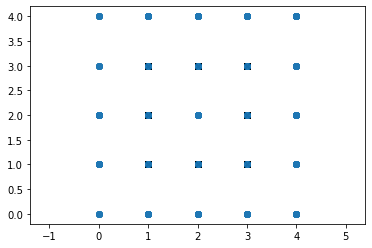

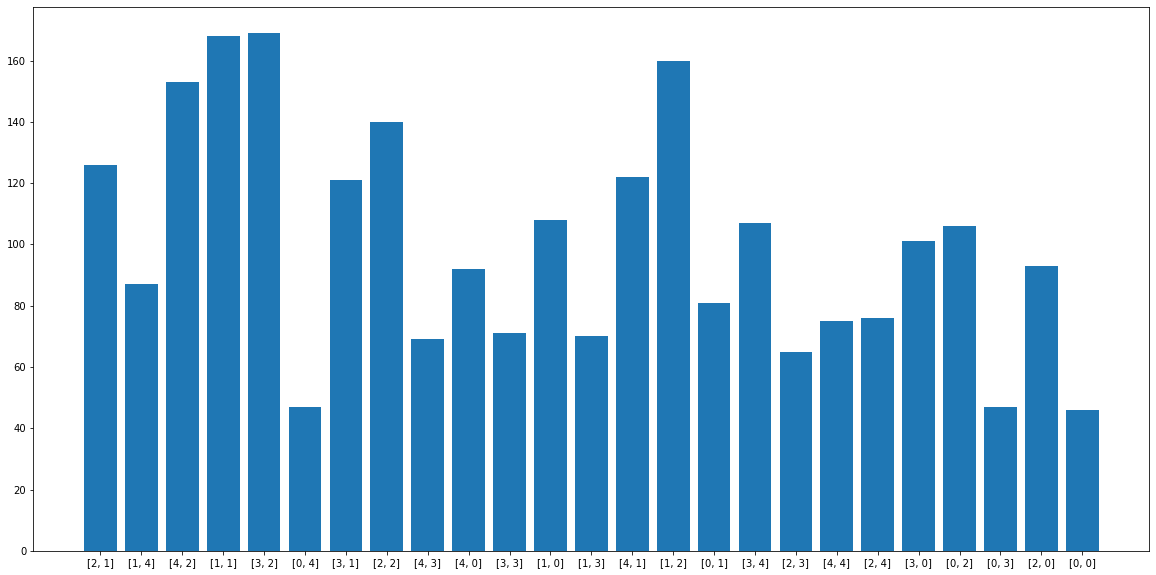

Processing Epoch 9
training start
Iteration 0, d real/fake loss 0.6718847155570984/0.6801740527153015 and g loss is 0.7043124437332153, NDiv loss 0.07494689524173737
Iteration 1, d real/fake loss 0.6713017821311951/0.6840090155601501 and g loss is 0.705150842666626, NDiv loss 0.0769759938120842
Iteration 2, d real/fake loss 0.6707220673561096/0.6829157471656799 and g loss is 0.7006099820137024, NDiv loss 0.07487839460372925
Iteration 3, d real/fake loss 0.6701446175575256/0.6822695732116699 and g loss is 0.7051372528076172, NDiv loss 0.0732150599360466
Iteration 4, d real/fake loss 0.6695632934570312/0.685474693775177 and g loss is 0.7040998935699463, NDiv loss 0.07541323453187943


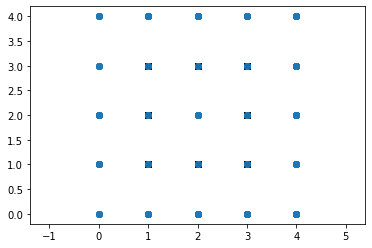

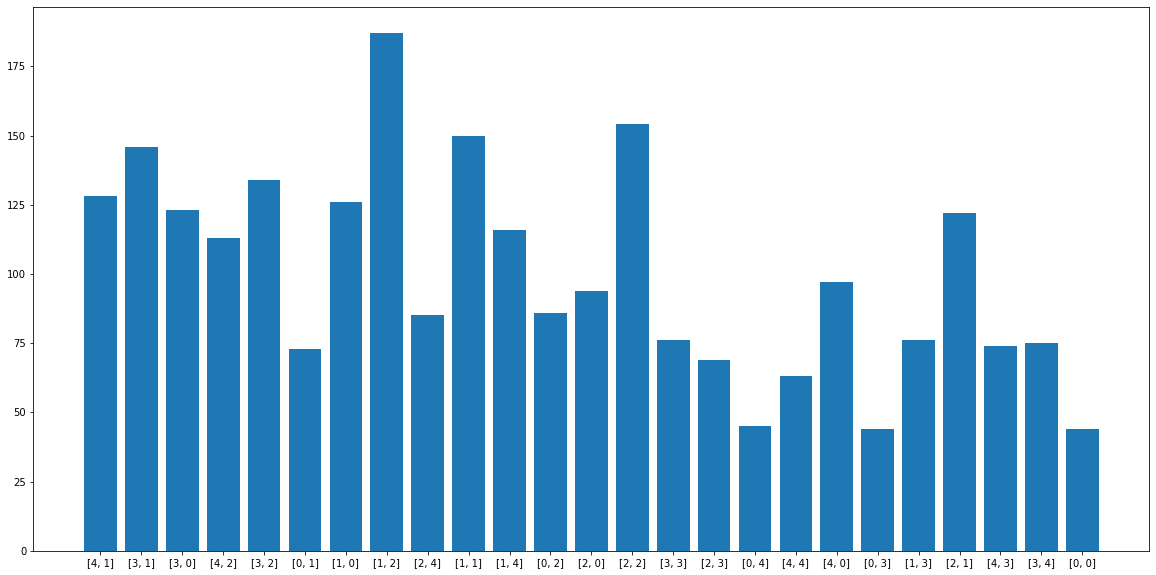

Processing Epoch 10
training start
Iteration 0, d real/fake loss 0.6753664612770081/0.6827901601791382 and g loss is 0.7008200883865356, NDiv loss 0.07031384110450745
Iteration 1, d real/fake loss 0.6747653484344482/0.6818875074386597 and g loss is 0.7020989656448364, NDiv loss 0.07961778342723846
Iteration 2, d real/fake loss 0.6741723418235779/0.6847960948944092 and g loss is 0.7010380029678345, NDiv loss 0.07473529130220413
Iteration 3, d real/fake loss 0.673592209815979/0.6846120357513428 and g loss is 0.7042205333709717, NDiv loss 0.07141922414302826
Iteration 4, d real/fake loss 0.6730203628540039/0.6809674501419067 and g loss is 0.7045552730560303, NDiv loss 0.07485032826662064


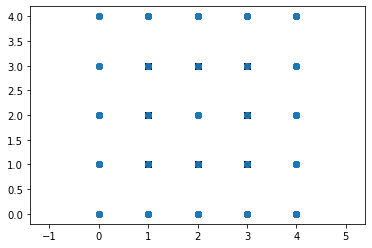

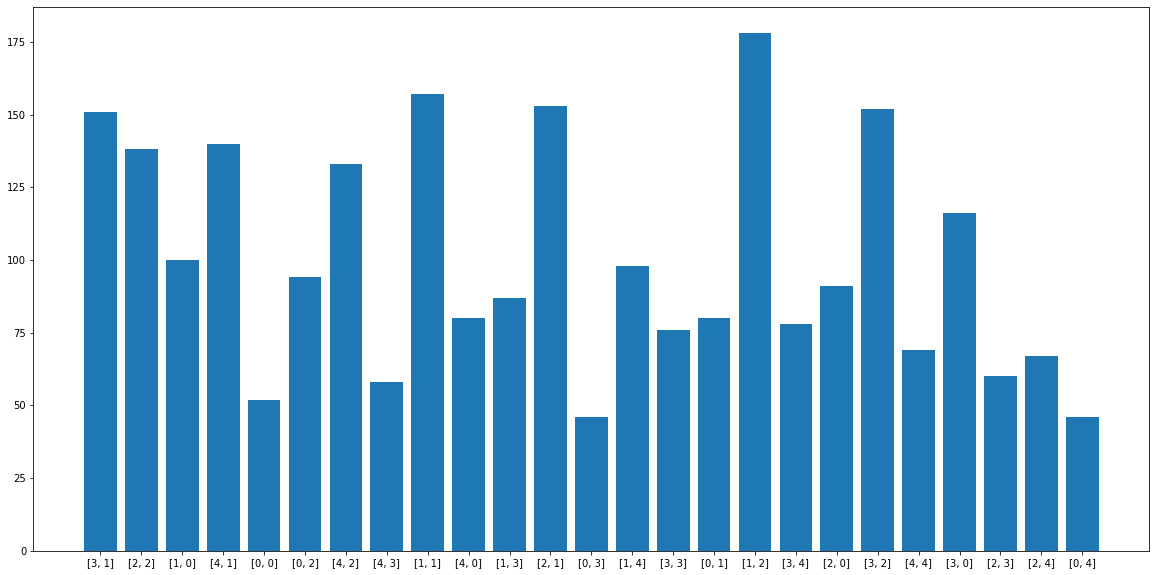

Processing Epoch 11
training start
Iteration 0, d real/fake loss 0.6740820407867432/0.6833573579788208 and g loss is 0.7040376663208008, NDiv loss 0.07629210501909256
Iteration 1, d real/fake loss 0.6735267639160156/0.6840581893920898 and g loss is 0.7034209966659546, NDiv loss 0.07124838978052139
Iteration 2, d real/fake loss 0.6729709506034851/0.683718204498291 and g loss is 0.7015661597251892, NDiv loss 0.07434078305959702
Iteration 3, d real/fake loss 0.6724148988723755/0.6823635101318359 and g loss is 0.7058649063110352, NDiv loss 0.07352939248085022
Iteration 4, d real/fake loss 0.6718538403511047/0.6852426528930664 and g loss is 0.7033748626708984, NDiv loss 0.0744597464799881


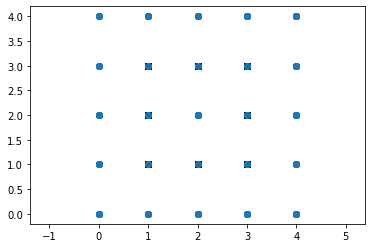

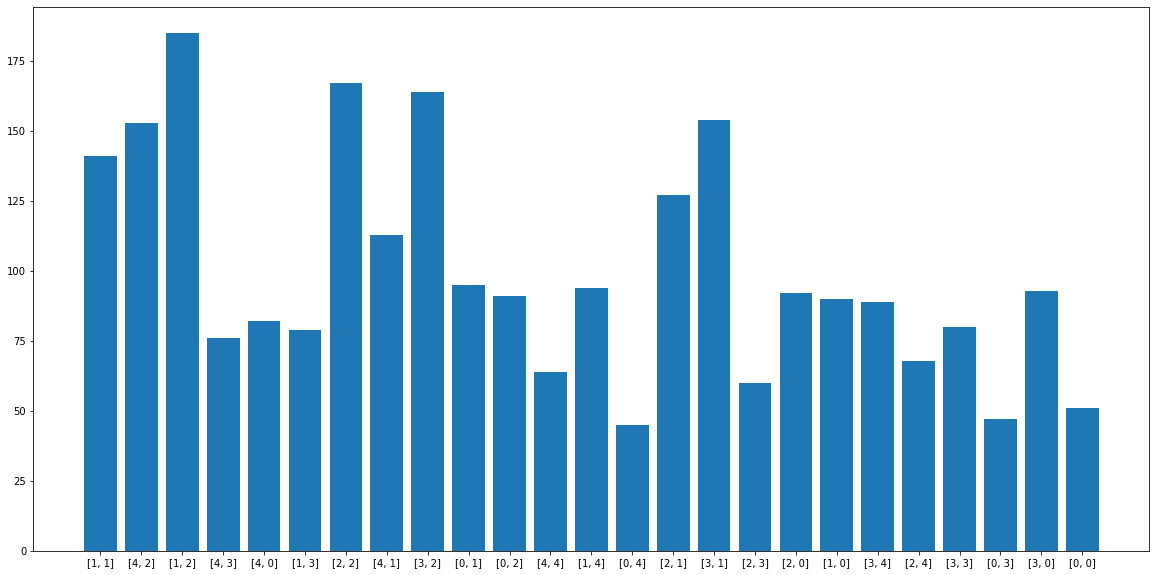

Processing Epoch 12
training start
Iteration 0, d real/fake loss 0.6674866676330566/0.6873549222946167 and g loss is 0.7036042213439941, NDiv loss 0.07321619242429733
Iteration 1, d real/fake loss 0.666956901550293/0.6823186874389648 and g loss is 0.7048985958099365, NDiv loss 0.07405588775873184
Iteration 2, d real/fake loss 0.6664340496063232/0.6851657629013062 and g loss is 0.7029587626457214, NDiv loss 0.06925033032894135
Iteration 3, d real/fake loss 0.6659241914749146/0.6817352771759033 and g loss is 0.6994109749794006, NDiv loss 0.07292497158050537
Iteration 4, d real/fake loss 0.6654207110404968/0.6877244710922241 and g loss is 0.704833984375, NDiv loss 0.07438083738088608


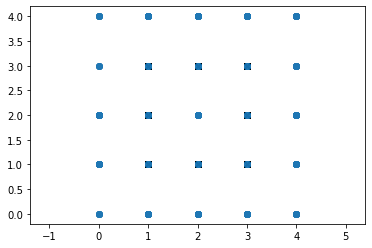

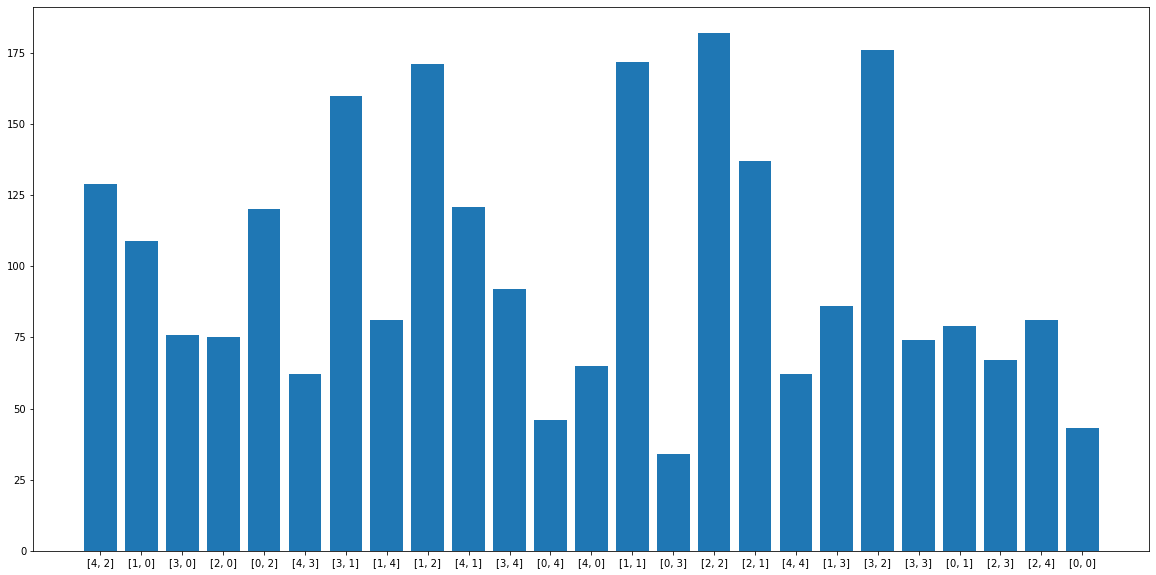

Processing Epoch 13
training start
Iteration 0, d real/fake loss 0.6639165878295898/0.6849303245544434 and g loss is 0.7003720998764038, NDiv loss 0.07430471479892731
Iteration 1, d real/fake loss 0.663454532623291/0.6852445602416992 and g loss is 0.7048901915550232, NDiv loss 0.07922526448965073
Iteration 2, d real/fake loss 0.662994384765625/0.6851558089256287 and g loss is 0.7027570009231567, NDiv loss 0.07075316458940506
Iteration 3, d real/fake loss 0.6625415086746216/0.6876429319381714 and g loss is 0.7033356428146362, NDiv loss 0.07561939209699631
Iteration 4, d real/fake loss 0.6620951890945435/0.6841368079185486 and g loss is 0.7030340433120728, NDiv loss 0.07361937314271927


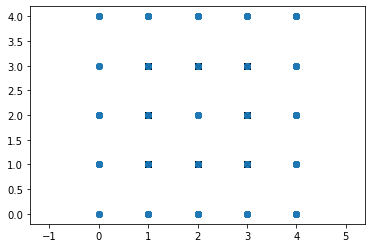

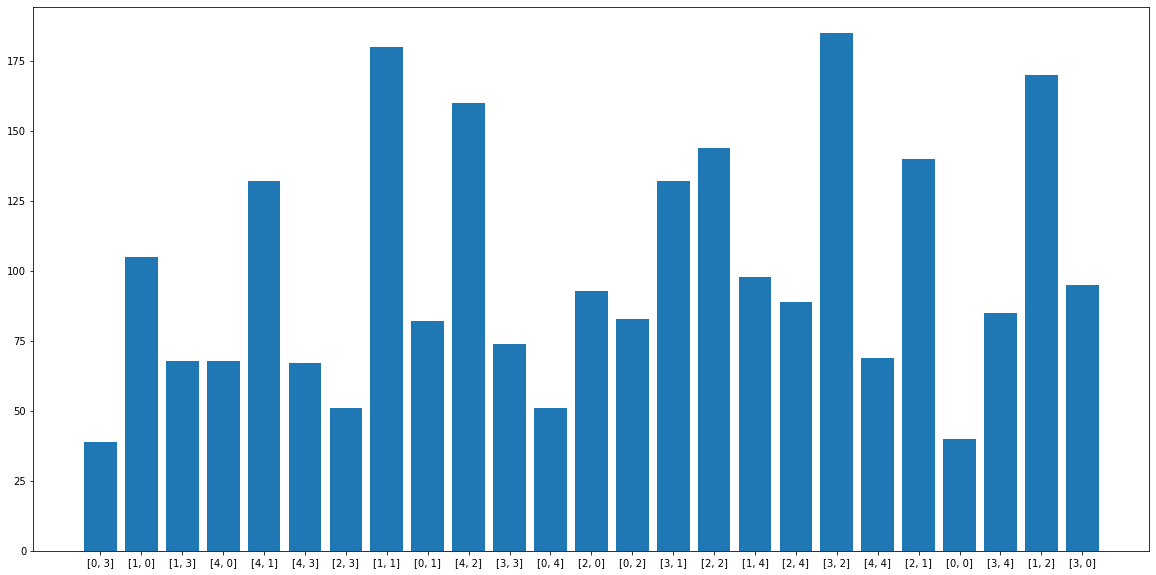

Processing Epoch 14
training start
Iteration 0, d real/fake loss 0.6584382653236389/0.6875110864639282 and g loss is 0.704643964767456, NDiv loss 0.0719093307852745
Iteration 1, d real/fake loss 0.6580191850662231/0.6841822266578674 and g loss is 0.703384518623352, NDiv loss 0.0749708041548729
Iteration 2, d real/fake loss 0.657603919506073/0.6835737824440002 and g loss is 0.7012302875518799, NDiv loss 0.0804629772901535
Iteration 3, d real/fake loss 0.6571874022483826/0.6858015060424805 and g loss is 0.7031396627426147, NDiv loss 0.07659605890512466
Iteration 4, d real/fake loss 0.6567804217338562/0.6842896938323975 and g loss is 0.700138509273529, NDiv loss 0.07513042539358139


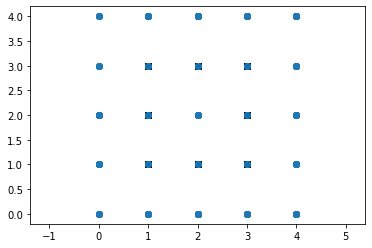

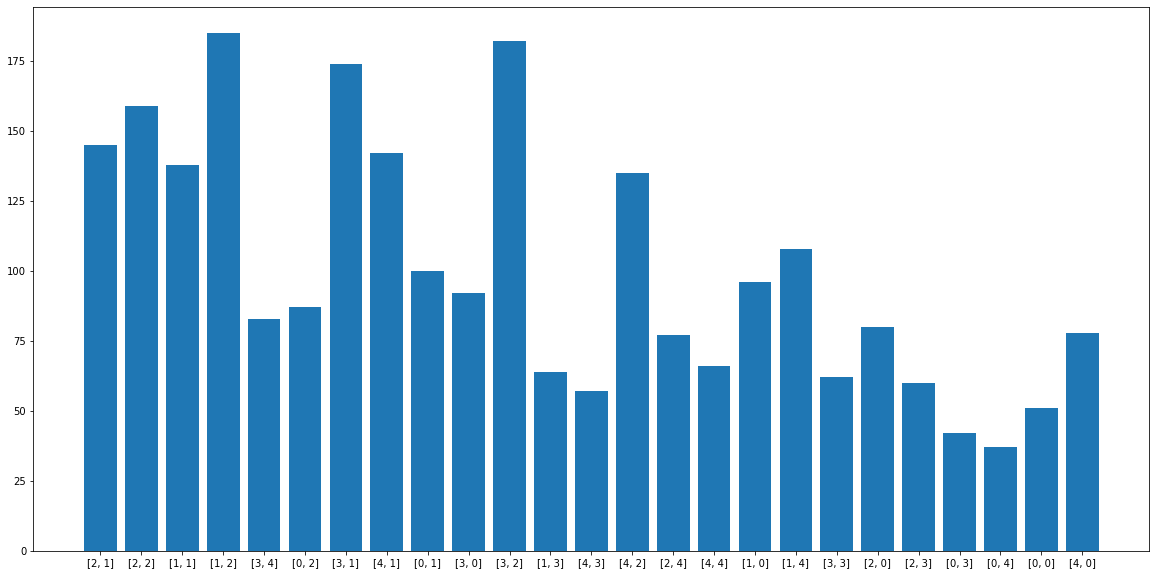

Processing Epoch 15
training start
Iteration 0, d real/fake loss 0.6606693863868713/0.6854445934295654 and g loss is 0.7040764689445496, NDiv loss 0.08102397620677948
Iteration 1, d real/fake loss 0.6602894067764282/0.684820294380188 and g loss is 0.7033293843269348, NDiv loss 0.07768427580595016
Iteration 2, d real/fake loss 0.6599023938179016/0.6811498403549194 and g loss is 0.7016065716743469, NDiv loss 0.07638700306415558
Iteration 3, d real/fake loss 0.6595032215118408/0.6860999464988708 and g loss is 0.7020619511604309, NDiv loss 0.07870260626077652
Iteration 4, d real/fake loss 0.6591149568557739/0.6810804605484009 and g loss is 0.6992430686950684, NDiv loss 0.07621536403894424


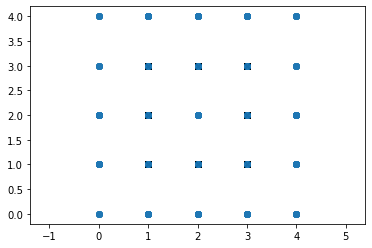

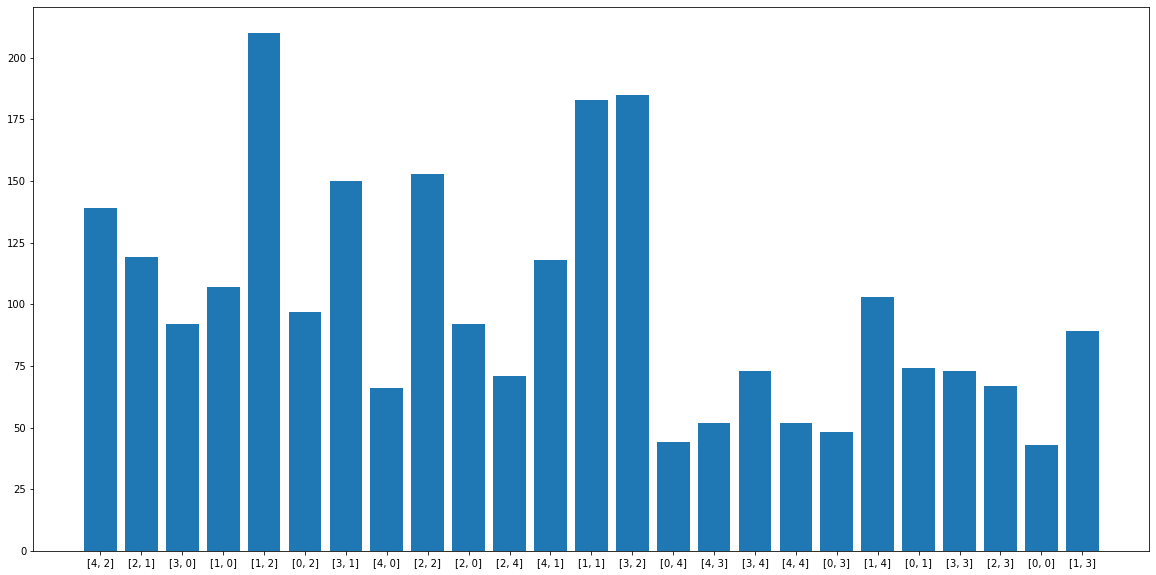

Processing Epoch 16
training start
Iteration 0, d real/fake loss 0.6571483612060547/0.6866795420646667 and g loss is 0.7049945592880249, NDiv loss 0.0740414634346962
Iteration 1, d real/fake loss 0.6567500829696655/0.684773325920105 and g loss is 0.7034797668457031, NDiv loss 0.0721973329782486
Iteration 2, d real/fake loss 0.6563516855239868/0.6851234436035156 and g loss is 0.7005568742752075, NDiv loss 0.073917455971241
Iteration 3, d real/fake loss 0.6559572815895081/0.6859582662582397 and g loss is 0.7075740098953247, NDiv loss 0.07674729079008102
Iteration 4, d real/fake loss 0.6555635929107666/0.6823037266731262 and g loss is 0.7002266645431519, NDiv loss 0.08073193579912186


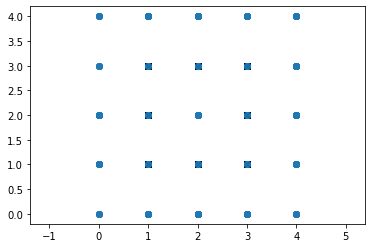

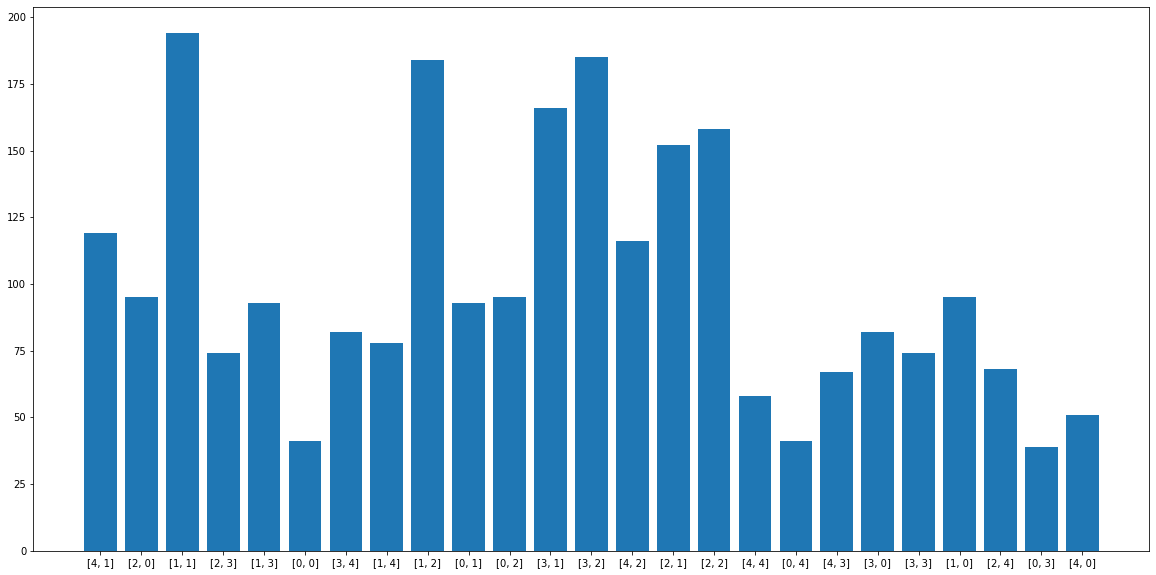

Processing Epoch 17
training start
Iteration 0, d real/fake loss 0.6581374406814575/0.683659553527832 and g loss is 0.7038754820823669, NDiv loss 0.07501678168773651
Iteration 1, d real/fake loss 0.6577185988426208/0.6835577487945557 and g loss is 0.7021198868751526, NDiv loss 0.07506705075502396
Iteration 2, d real/fake loss 0.6573028564453125/0.6842353343963623 and g loss is 0.7032520771026611, NDiv loss 0.0752667486667633
Iteration 3, d real/fake loss 0.6568953990936279/0.6828998327255249 and g loss is 0.7030357122421265, NDiv loss 0.07612276077270508
Iteration 4, d real/fake loss 0.6564902663230896/0.6864588260650635 and g loss is 0.7024880051612854, NDiv loss 0.07529226690530777


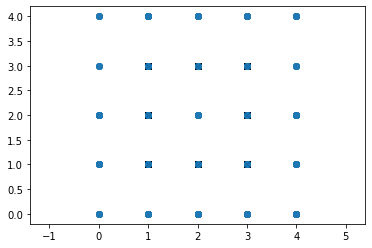

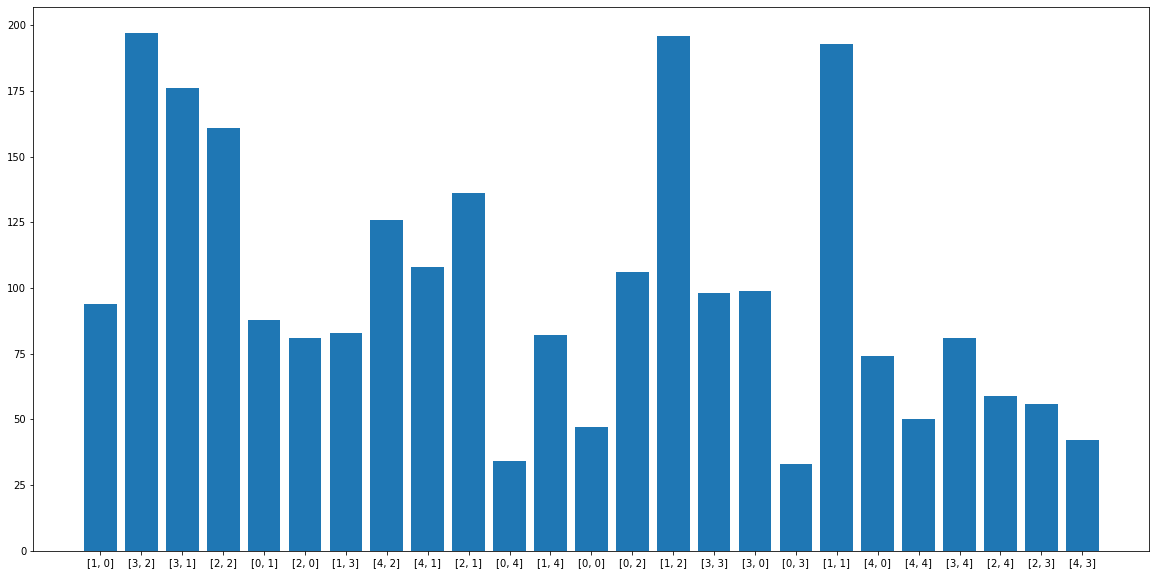

Processing Epoch 18
training start
Iteration 0, d real/fake loss 0.6564310789108276/0.6839005351066589 and g loss is 0.701697051525116, NDiv loss 0.07319898903369904
Iteration 1, d real/fake loss 0.6560540795326233/0.679630696773529 and g loss is 0.707886815071106, NDiv loss 0.07584383338689804
Iteration 2, d real/fake loss 0.6556589603424072/0.6811597347259521 and g loss is 0.7088015675544739, NDiv loss 0.07977447658777237
Iteration 3, d real/fake loss 0.6552565097808838/0.6842228174209595 and g loss is 0.7051992416381836, NDiv loss 0.07655339688062668
Iteration 4, d real/fake loss 0.6548518538475037/0.6829387545585632 and g loss is 0.7068134546279907, NDiv loss 0.07769079506397247


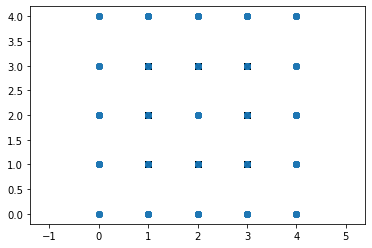

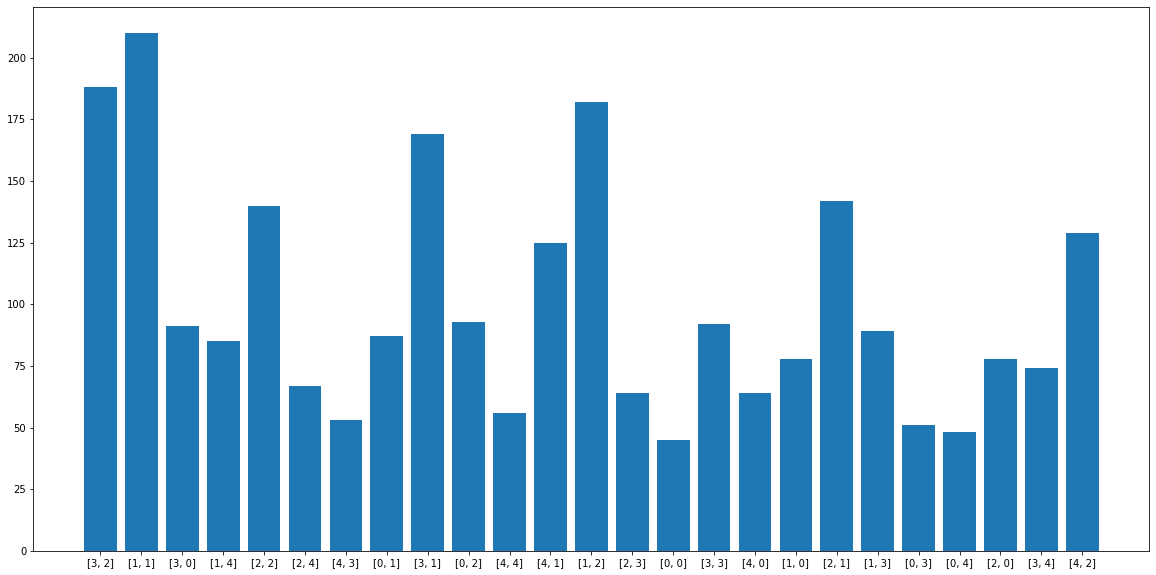

Processing Epoch 19
training start
Iteration 0, d real/fake loss 0.6510359644889832/0.6856170892715454 and g loss is 0.7054884433746338, NDiv loss 0.07957036793231964
Iteration 1, d real/fake loss 0.650677502155304/0.6816903352737427 and g loss is 0.7033147811889648, NDiv loss 0.07410487532615662
Iteration 2, d real/fake loss 0.6503216624259949/0.6836041212081909 and g loss is 0.7039704322814941, NDiv loss 0.07525206357240677
Iteration 3, d real/fake loss 0.6499719023704529/0.6801975965499878 and g loss is 0.7039763927459717, NDiv loss 0.07490413635969162
Iteration 4, d real/fake loss 0.6496242880821228/0.6838694214820862 and g loss is 0.7011832594871521, NDiv loss 0.07776688784360886


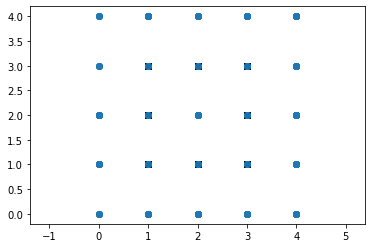

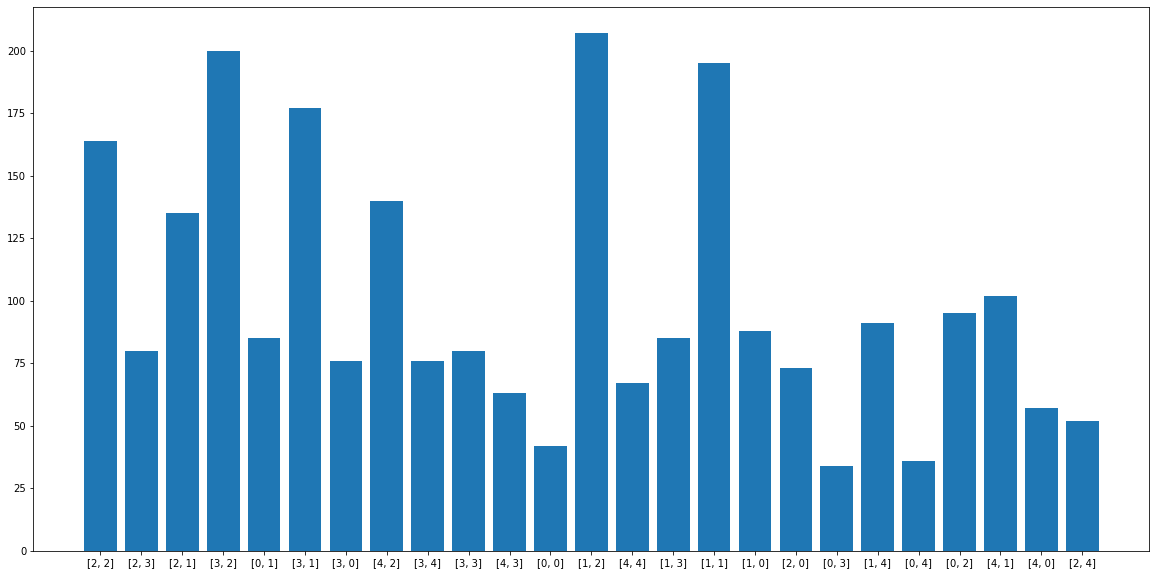

Processing Epoch 20
training start
Iteration 0, d real/fake loss 0.6513535976409912/0.682963490486145 and g loss is 0.7057008743286133, NDiv loss 0.08008351922035217
Iteration 1, d real/fake loss 0.65101158618927/0.6834997534751892 and g loss is 0.7042773962020874, NDiv loss 0.0747772678732872
Iteration 2, d real/fake loss 0.6506704092025757/0.6869112849235535 and g loss is 0.7042617797851562, NDiv loss 0.07418597489595413
Iteration 3, d real/fake loss 0.6503337025642395/0.6858336925506592 and g loss is 0.7051699757575989, NDiv loss 0.07698429375886917
Iteration 4, d real/fake loss 0.6499963402748108/0.6816298365592957 and g loss is 0.7040776014328003, NDiv loss 0.07961556315422058


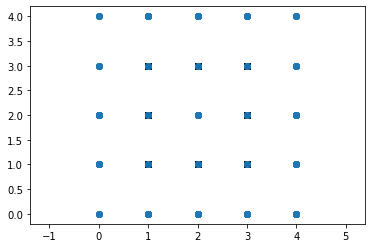

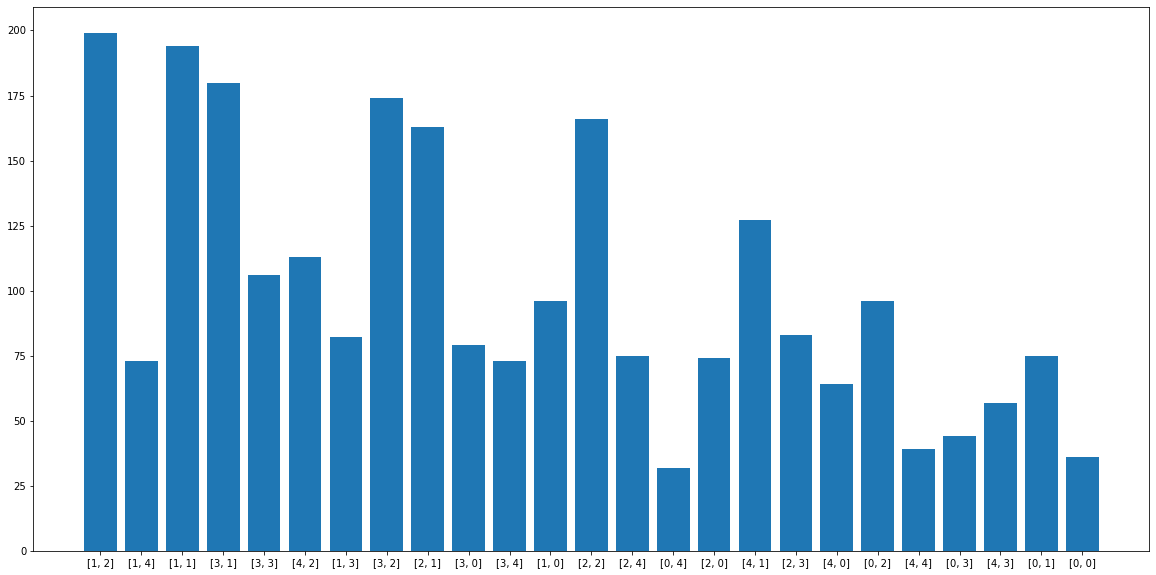

Processing Epoch 21
training start
Iteration 0, d real/fake loss 0.6508880257606506/0.6908349394798279 and g loss is 0.6994963884353638, NDiv loss 0.0756656602025032
Iteration 1, d real/fake loss 0.6505564451217651/0.6782601475715637 and g loss is 0.7050044536590576, NDiv loss 0.07647032290697098
Iteration 2, d real/fake loss 0.6502172350883484/0.6847557425498962 and g loss is 0.7014374732971191, NDiv loss 0.07954388111829758
Iteration 3, d real/fake loss 0.6498881578445435/0.6844711303710938 and g loss is 0.704635500907898, NDiv loss 0.07577770203351974
Iteration 4, d real/fake loss 0.6495623588562012/0.6842125654220581 and g loss is 0.7061125040054321, NDiv loss 0.07208062708377838


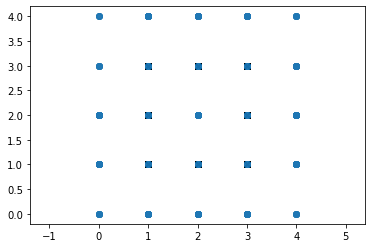

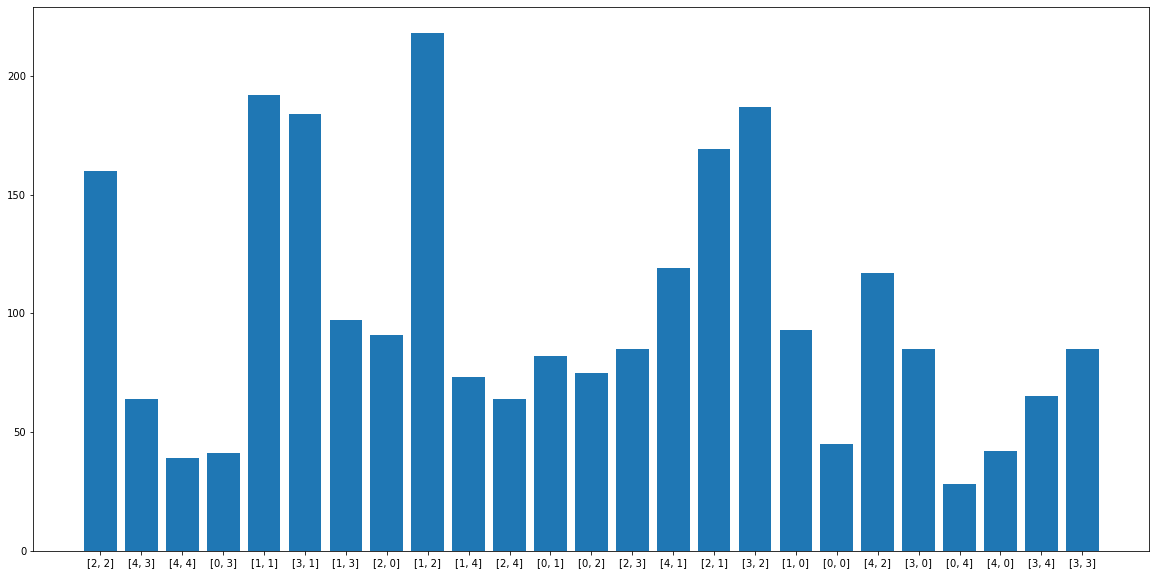

Processing Epoch 22
training start
Iteration 0, d real/fake loss 0.6477881669998169/0.6836212873458862 and g loss is 0.7026278972625732, NDiv loss 0.08122341334819794
Iteration 1, d real/fake loss 0.6474923491477966/0.6826705932617188 and g loss is 0.7019965052604675, NDiv loss 0.07711988687515259
Iteration 2, d real/fake loss 0.6471897959709167/0.6840231418609619 and g loss is 0.7070609927177429, NDiv loss 0.07485715299844742
Iteration 3, d real/fake loss 0.6468843817710876/0.6834363341331482 and g loss is 0.7076910734176636, NDiv loss 0.07189791649580002
Iteration 4, d real/fake loss 0.6465758681297302/0.6837672591209412 and g loss is 0.7028042078018188, NDiv loss 0.08090496063232422


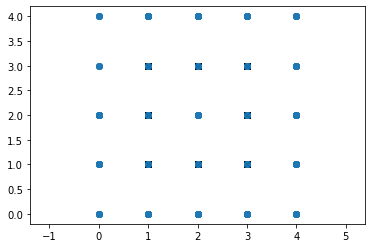

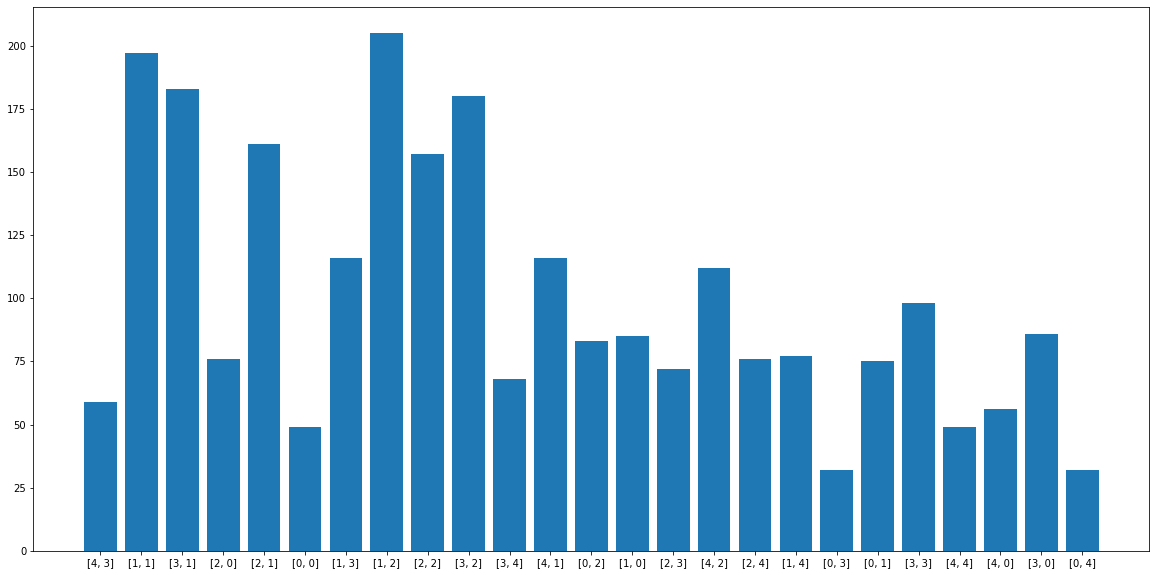

Processing Epoch 23
training start
Iteration 0, d real/fake loss 0.6469301581382751/0.6849170923233032 and g loss is 0.7042549848556519, NDiv loss 0.07170923799276352
Iteration 1, d real/fake loss 0.6466418504714966/0.6782678961753845 and g loss is 0.7070176601409912, NDiv loss 0.07054416090250015
Iteration 2, d real/fake loss 0.6463451385498047/0.6803425550460815 and g loss is 0.7069908380508423, NDiv loss 0.0777725949883461
Iteration 3, d real/fake loss 0.6460438966751099/0.6831077933311462 and g loss is 0.7100383043289185, NDiv loss 0.06774846464395523
Iteration 4, d real/fake loss 0.645745038986206/0.6823800206184387 and g loss is 0.7102068066596985, NDiv loss 0.07651732116937637


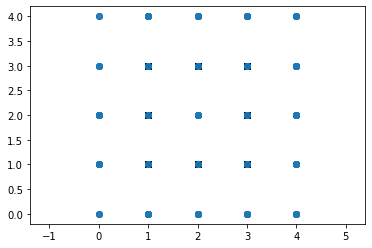

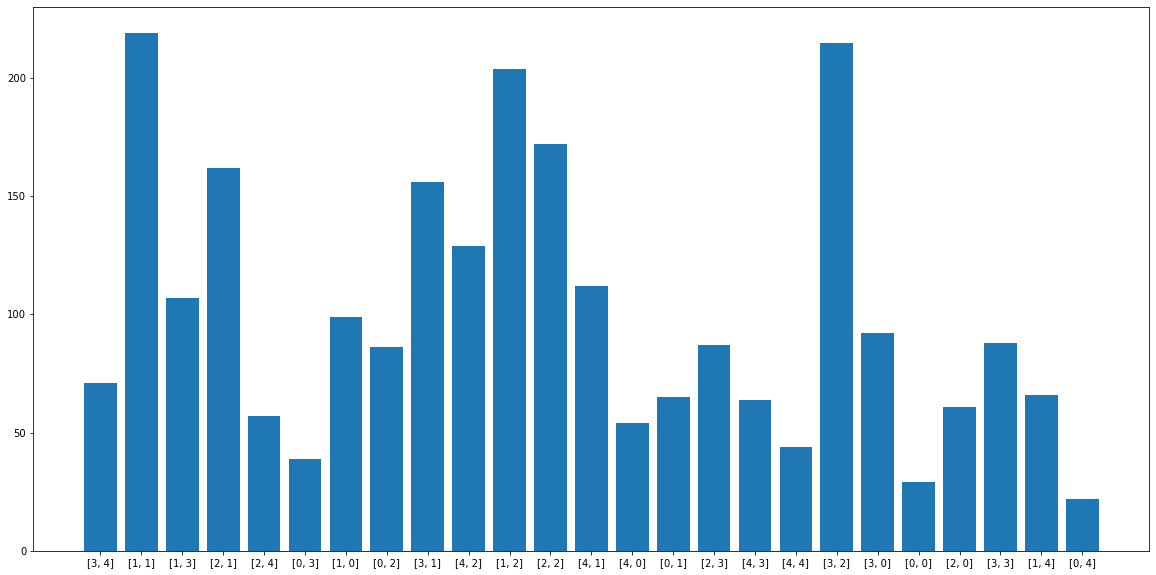

Processing Epoch 24
training start
Iteration 0, d real/fake loss 0.6445691585540771/0.6766805648803711 and g loss is 0.7054475545883179, NDiv loss 0.07913243770599365
Iteration 1, d real/fake loss 0.6442562341690063/0.6883641481399536 and g loss is 0.7051142454147339, NDiv loss 0.07421596348285675
Iteration 2, d real/fake loss 0.6439548134803772/0.6853089332580566 and g loss is 0.7072876691818237, NDiv loss 0.07349177449941635
Iteration 3, d real/fake loss 0.643652081489563/0.6816214919090271 and g loss is 0.7065373659133911, NDiv loss 0.07980849593877792
Iteration 4, d real/fake loss 0.6433472633361816/0.6797482967376709 and g loss is 0.7053683996200562, NDiv loss 0.07425527274608612


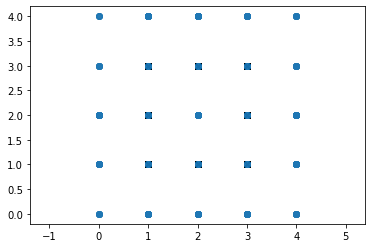

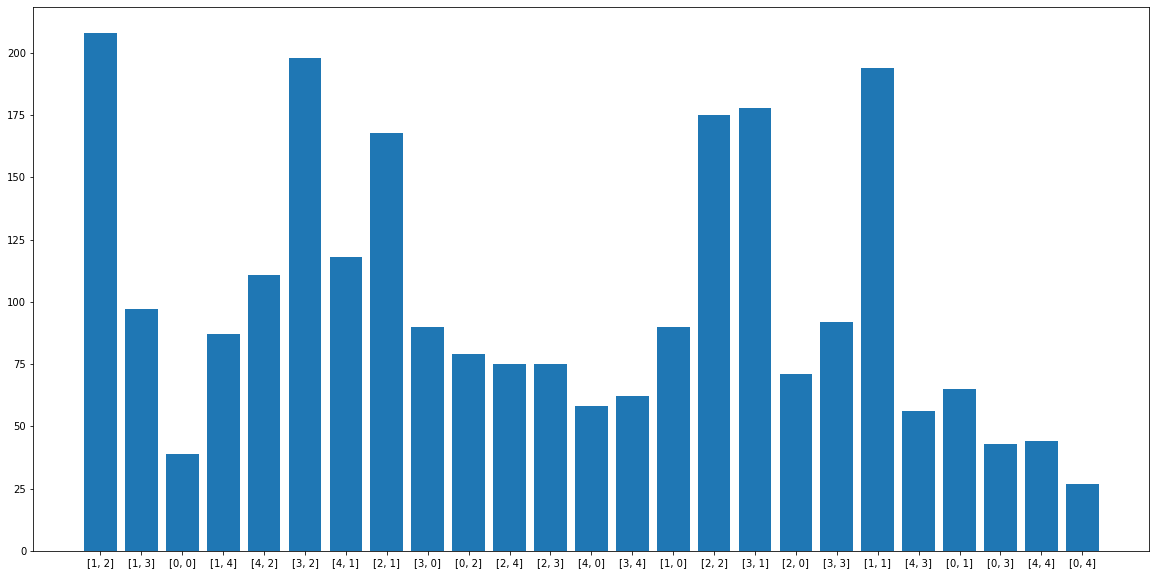

Processing Epoch 25
training start
Iteration 0, d real/fake loss 0.641931414604187/0.6882469654083252 and g loss is 0.7085229158401489, NDiv loss 0.07899938523769379
Iteration 1, d real/fake loss 0.6416536569595337/0.6827762126922607 and g loss is 0.7055314183235168, NDiv loss 0.07379584014415741
Iteration 2, d real/fake loss 0.6413715481758118/0.6829982995986938 and g loss is 0.7038333415985107, NDiv loss 0.07912097871303558
Iteration 3, d real/fake loss 0.641086995601654/0.6781615614891052 and g loss is 0.7040942311286926, NDiv loss 0.0762736052274704
Iteration 4, d real/fake loss 0.6407904624938965/0.6806789636611938 and g loss is 0.7042956352233887, NDiv loss 0.0825006291270256


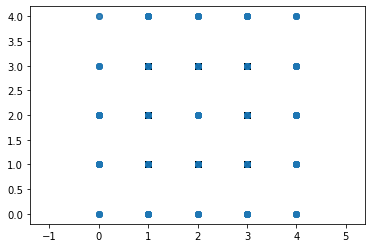

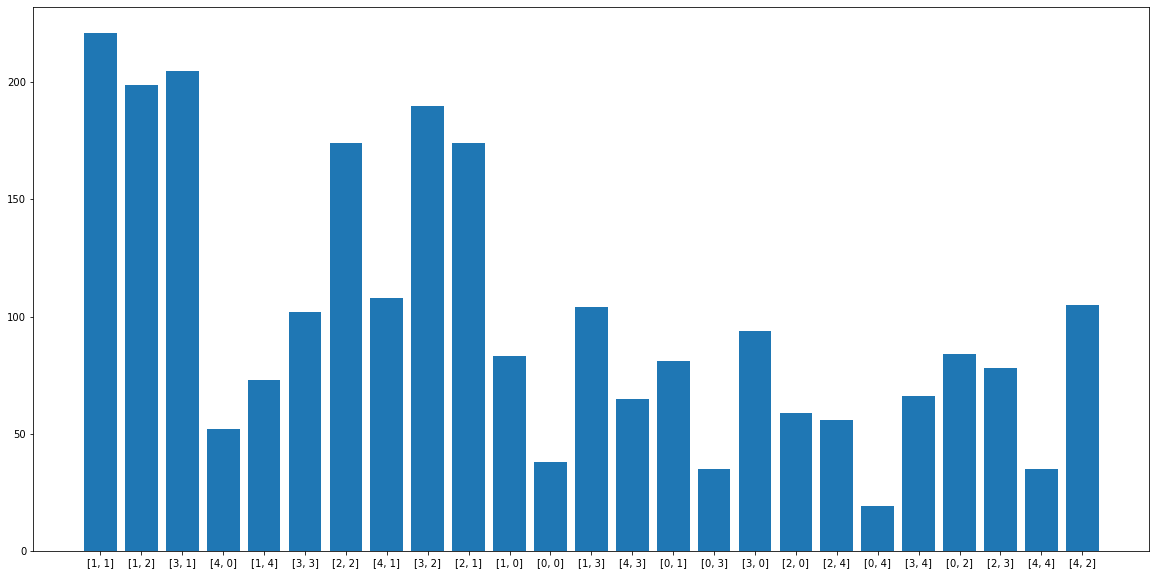

Processing Epoch 26
training start
Iteration 0, d real/fake loss 0.6386229395866394/0.676685094833374 and g loss is 0.7009868025779724, NDiv loss 0.07984473556280136
Iteration 1, d real/fake loss 0.6383322477340698/0.6845614910125732 and g loss is 0.7006919384002686, NDiv loss 0.07739037275314331
Iteration 2, d real/fake loss 0.6380583047866821/0.6816098690032959 and g loss is 0.704464852809906, NDiv loss 0.07640769332647324
Iteration 3, d real/fake loss 0.6377850770950317/0.6805707216262817 and g loss is 0.7091697454452515, NDiv loss 0.07692480832338333
Iteration 4, d real/fake loss 0.6375142335891724/0.6834672093391418 and g loss is 0.7094883322715759, NDiv loss 0.07601537555456161


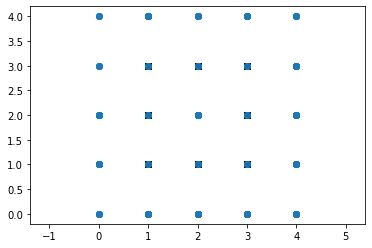

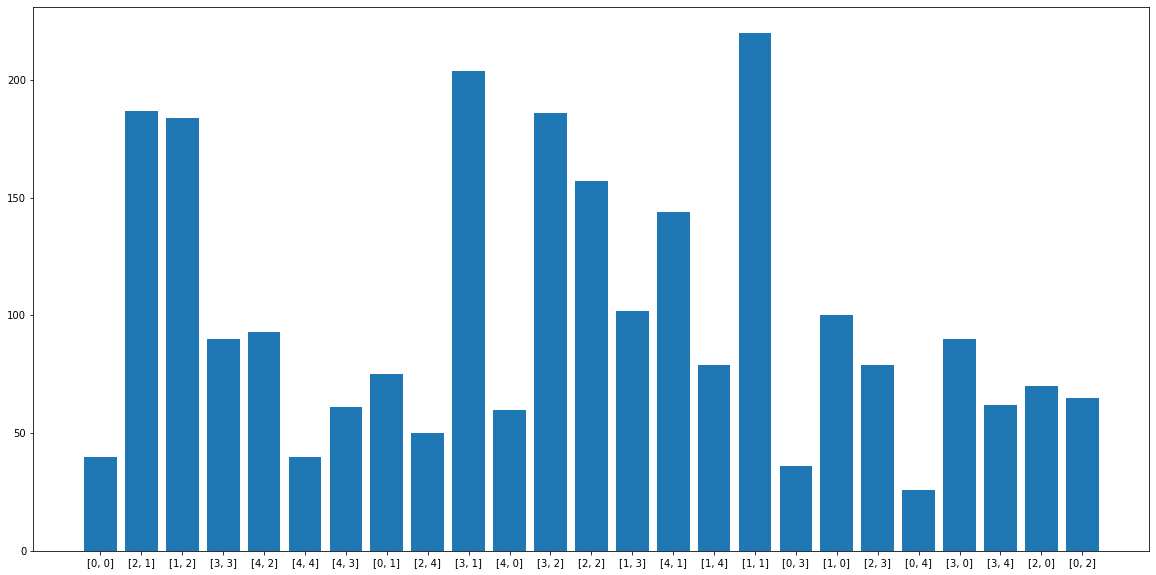

Processing Epoch 27
training start
Iteration 0, d real/fake loss 0.6413984894752502/0.6792913675308228 and g loss is 0.7089922428131104, NDiv loss 0.07653401046991348
Iteration 1, d real/fake loss 0.6411232948303223/0.6799226403236389 and g loss is 0.7092525959014893, NDiv loss 0.08206628262996674
Iteration 2, d real/fake loss 0.6408400535583496/0.6806385517120361 and g loss is 0.7030383348464966, NDiv loss 0.07889951020479202
Iteration 3, d real/fake loss 0.6405512094497681/0.6812418699264526 and g loss is 0.7061049938201904, NDiv loss 0.07263258844614029
Iteration 4, d real/fake loss 0.6402615308761597/0.6769552230834961 and g loss is 0.7052345871925354, NDiv loss 0.0710570439696312


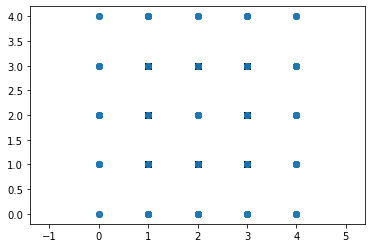

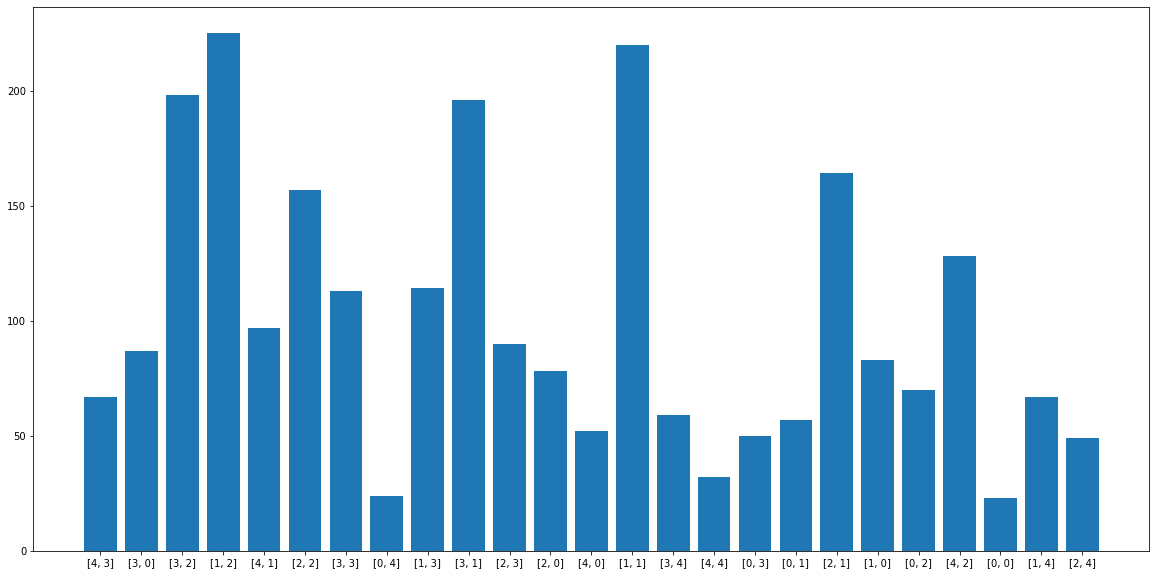

Processing Epoch 28
training start
Iteration 0, d real/fake loss 0.6419045925140381/0.6814689636230469 and g loss is 0.7051891088485718, NDiv loss 0.07196929305791855
Iteration 1, d real/fake loss 0.6415867805480957/0.6801549196243286 and g loss is 0.7045068144798279, NDiv loss 0.0821329802274704
Iteration 2, d real/fake loss 0.6412651538848877/0.6806336641311646 and g loss is 0.7035354971885681, NDiv loss 0.08024611324071884
Iteration 3, d real/fake loss 0.6409437656402588/0.6812240481376648 and g loss is 0.7033991813659668, NDiv loss 0.07339847087860107
Iteration 4, d real/fake loss 0.6406277418136597/0.6767122745513916 and g loss is 0.7100904583930969, NDiv loss 0.07546213269233704


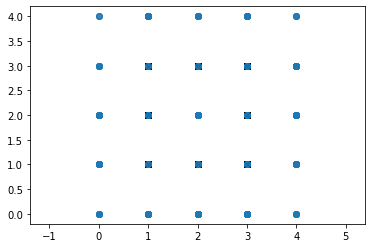

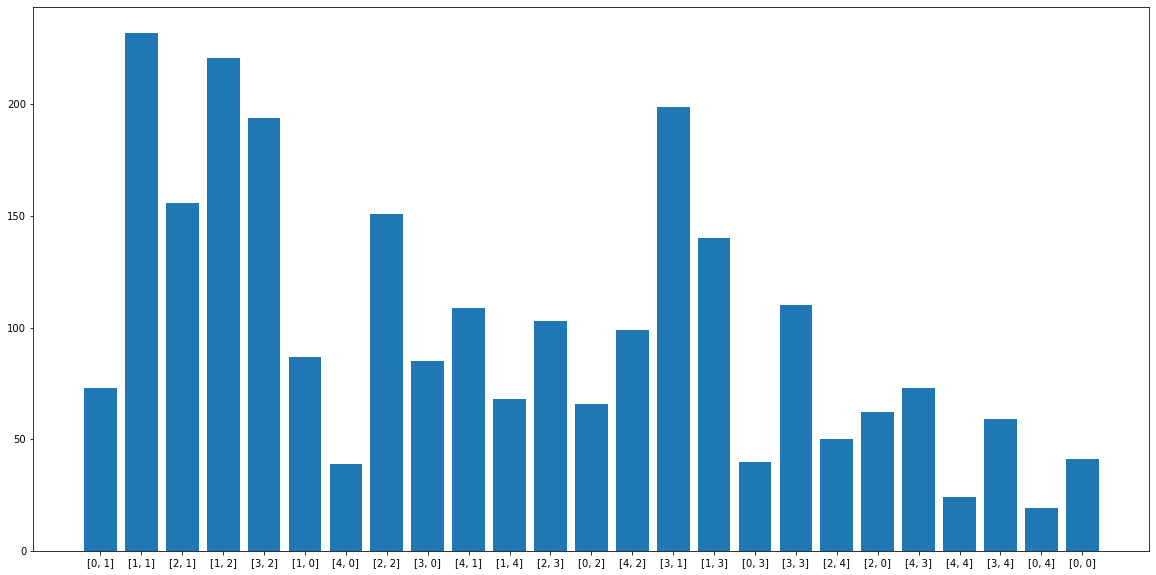

Processing Epoch 29
training start
Iteration 0, d real/fake loss 0.6389374732971191/0.6821006536483765 and g loss is 0.7112950086593628, NDiv loss 0.07522371411323547
Iteration 1, d real/fake loss 0.6386247873306274/0.6816571354866028 and g loss is 0.7085059881210327, NDiv loss 0.07277616858482361
Iteration 2, d real/fake loss 0.6383168697357178/0.6796608567237854 and g loss is 0.7038888931274414, NDiv loss 0.07689379155635834
Iteration 3, d real/fake loss 0.6380135416984558/0.6760401725769043 and g loss is 0.7041101455688477, NDiv loss 0.08307056874036789
Iteration 4, d real/fake loss 0.6377097368240356/0.6793299913406372 and g loss is 0.7088034152984619, NDiv loss 0.07931330054998398


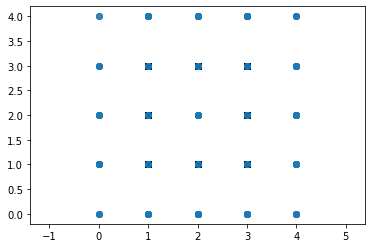

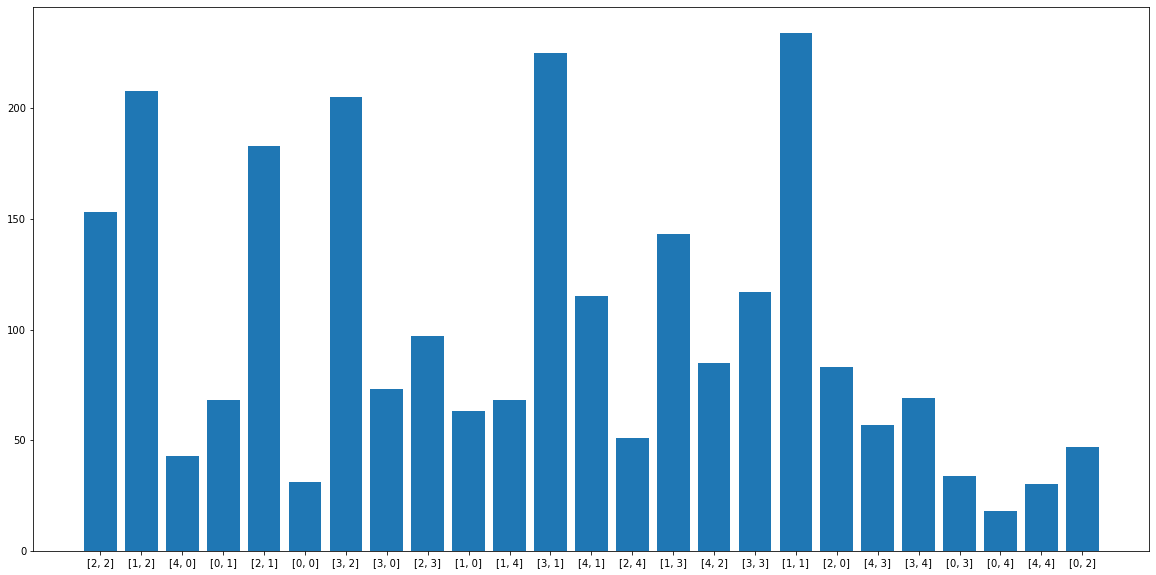

Processing Epoch 30
training start
Iteration 0, d real/fake loss 0.6351081132888794/0.6786569356918335 and g loss is 0.7022055387496948, NDiv loss 0.07779882848262787
Iteration 1, d real/fake loss 0.6348447799682617/0.6846597194671631 and g loss is 0.7022075653076172, NDiv loss 0.0787397176027298
Iteration 2, d real/fake loss 0.6345930099487305/0.6779037714004517 and g loss is 0.7090415954589844, NDiv loss 0.07287440448999405
Iteration 3, d real/fake loss 0.6343384981155396/0.677491307258606 and g loss is 0.7063655257225037, NDiv loss 0.08014947175979614
Iteration 4, d real/fake loss 0.6340805888175964/0.6834243535995483 and g loss is 0.7071877717971802, NDiv loss 0.08285059034824371


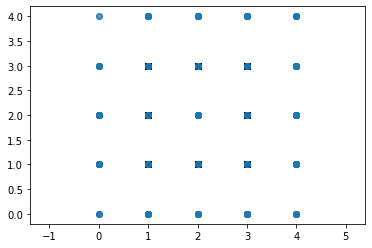

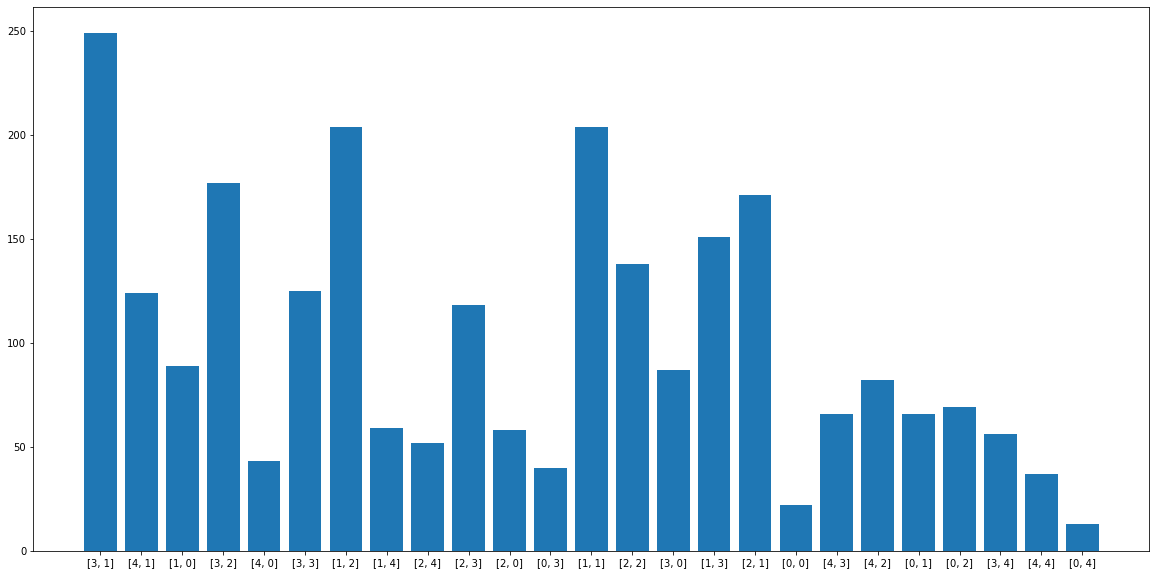

Processing Epoch 31
training start
Iteration 0, d real/fake loss 0.6351998448371887/0.6820985078811646 and g loss is 0.7090272903442383, NDiv loss 0.07912803441286087
Iteration 1, d real/fake loss 0.6349670886993408/0.6807068586349487 and g loss is 0.7084715366363525, NDiv loss 0.08022064715623856
Iteration 2, d real/fake loss 0.6347274780273438/0.6792068481445312 and g loss is 0.7068924903869629, NDiv loss 0.08141587674617767
Iteration 3, d real/fake loss 0.6344894766807556/0.6851893067359924 and g loss is 0.7045887112617493, NDiv loss 0.08062692731618881
Iteration 4, d real/fake loss 0.6342534422874451/0.6801983714103699 and g loss is 0.7035988569259644, NDiv loss 0.07698112726211548


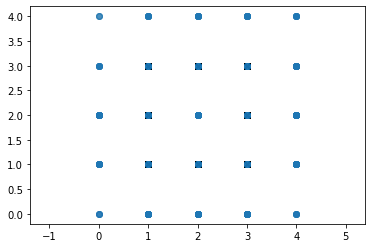

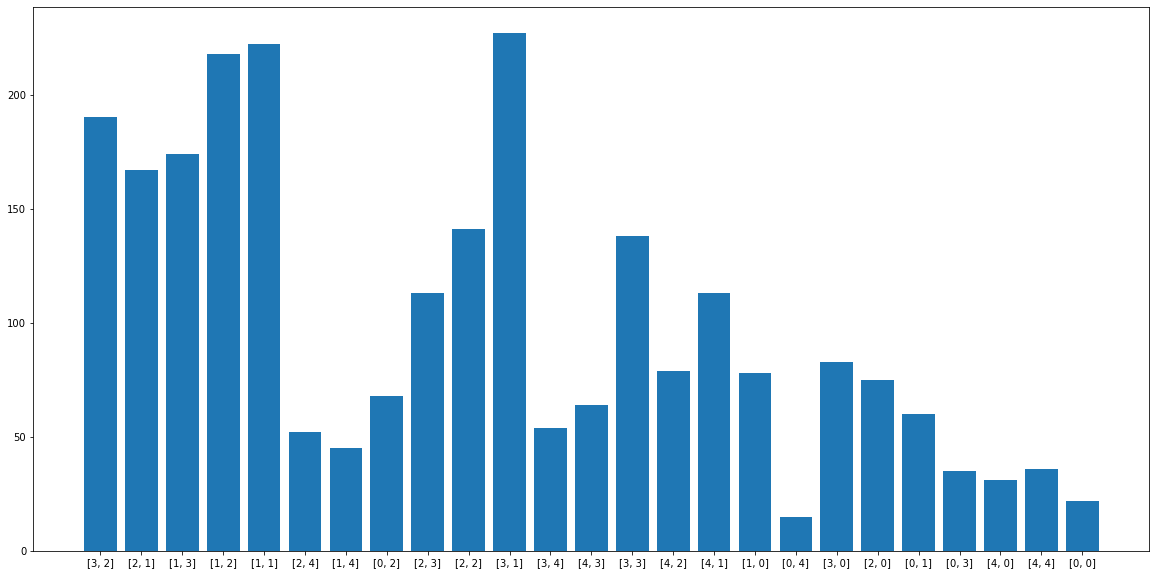

Processing Epoch 32
training start
Iteration 0, d real/fake loss 0.6356929540634155/0.6781257390975952 and g loss is 0.7019741535186768, NDiv loss 0.0779431015253067
Iteration 1, d real/fake loss 0.635413646697998/0.6783261299133301 and g loss is 0.711234986782074, NDiv loss 0.0799190029501915
Iteration 2, d real/fake loss 0.6351269483566284/0.6806250214576721 and g loss is 0.7096596956253052, NDiv loss 0.07427811622619629
Iteration 3, d real/fake loss 0.6348358988761902/0.6784459948539734 and g loss is 0.7108389139175415, NDiv loss 0.0776982456445694
Iteration 4, d real/fake loss 0.6345422863960266/0.6802636981010437 and g loss is 0.7126039862632751, NDiv loss 0.07956814765930176


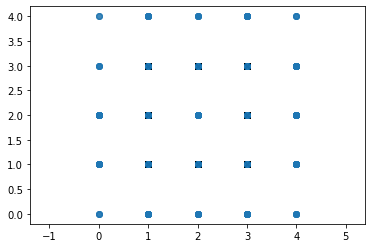

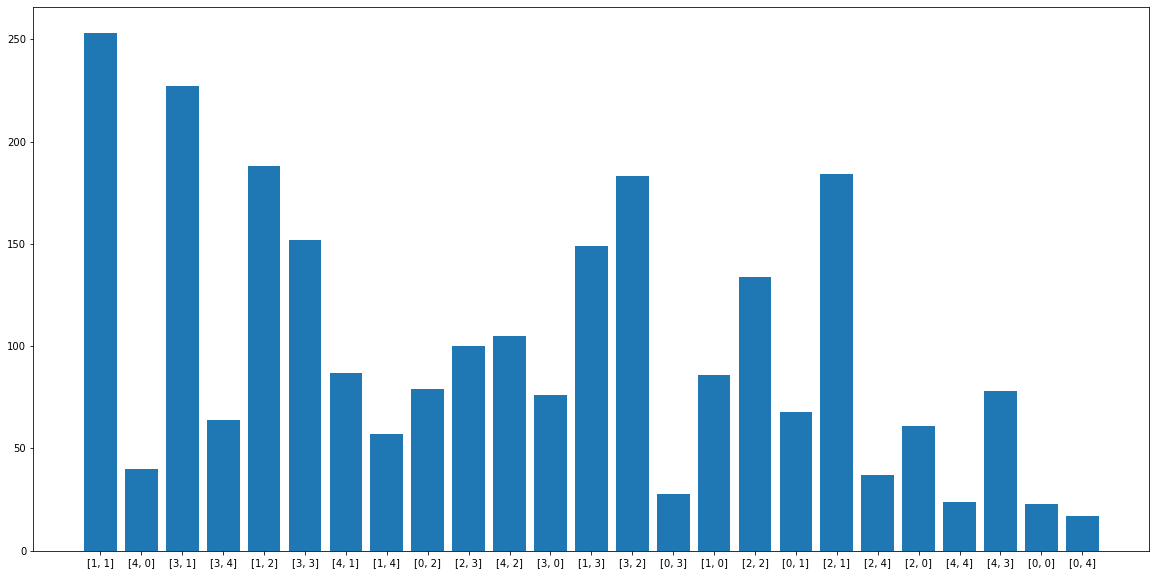

Processing Epoch 33
training start
Iteration 0, d real/fake loss 0.6322318315505981/0.6775381565093994 and g loss is 0.7101727724075317, NDiv loss 0.07962028682231903
Iteration 1, d real/fake loss 0.6319444179534912/0.6812894344329834 and g loss is 0.7090872526168823, NDiv loss 0.0827508196234703
Iteration 2, d real/fake loss 0.6316667199134827/0.6818030476570129 and g loss is 0.7066659927368164, NDiv loss 0.07922853529453278
Iteration 3, d real/fake loss 0.6313957571983337/0.6798482537269592 and g loss is 0.7051122188568115, NDiv loss 0.07576988637447357
Iteration 4, d real/fake loss 0.6311333179473877/0.683435320854187 and g loss is 0.711917519569397, NDiv loss 0.07689542323350906


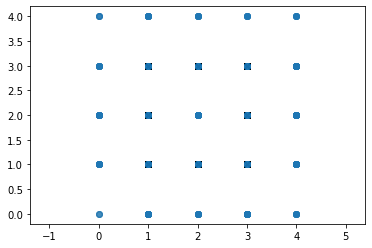

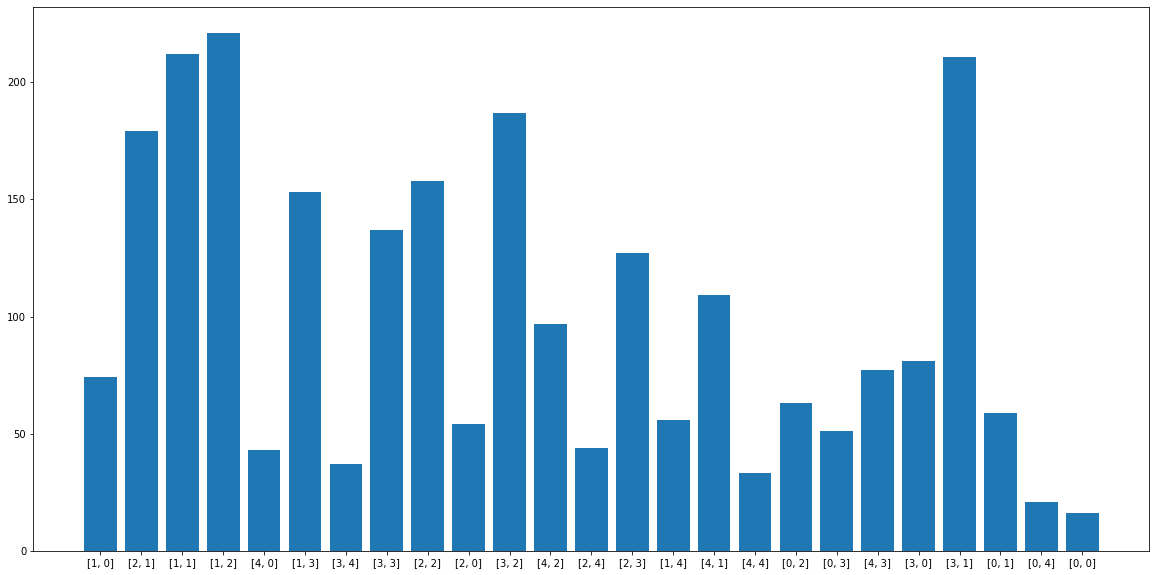

Processing Epoch 34
training start
Iteration 0, d real/fake loss 0.6307655572891235/0.6762619018554688 and g loss is 0.7083989977836609, NDiv loss 0.0791473239660263
Iteration 1, d real/fake loss 0.6305594444274902/0.6797990798950195 and g loss is 0.7037289142608643, NDiv loss 0.07673948258161545
Iteration 2, d real/fake loss 0.6303539276123047/0.6820576190948486 and g loss is 0.7058870792388916, NDiv loss 0.0817766934633255
Iteration 3, d real/fake loss 0.6301538944244385/0.6822988390922546 and g loss is 0.7078951597213745, NDiv loss 0.07628058642148972
Iteration 4, d real/fake loss 0.6299611330032349/0.6796661615371704 and g loss is 0.7139261960983276, NDiv loss 0.07507237046957016


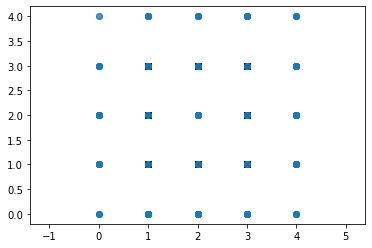

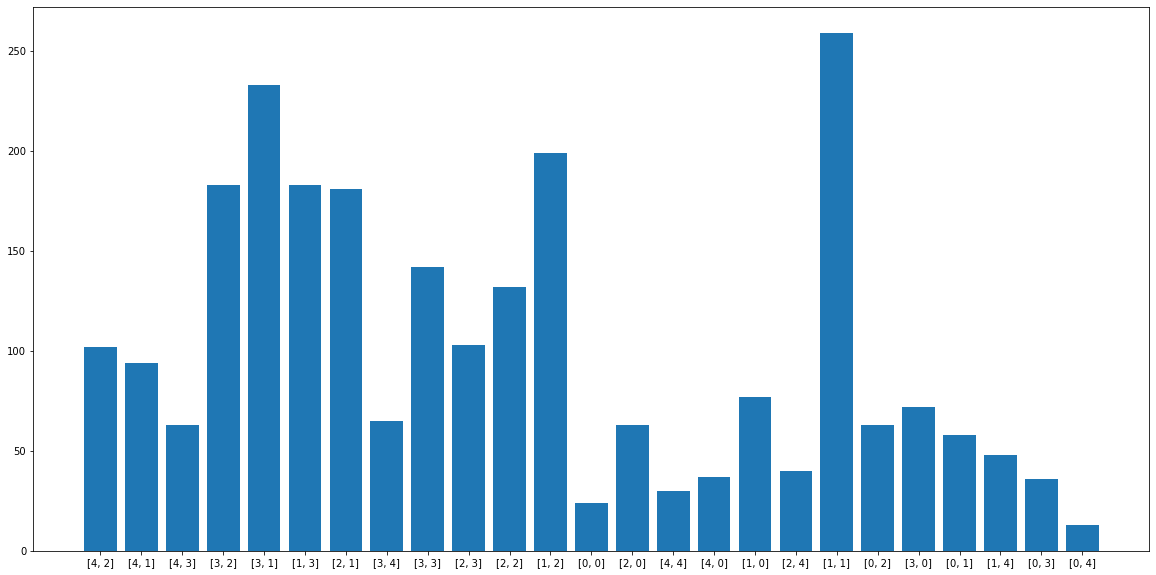

Processing Epoch 35
training start
Iteration 0, d real/fake loss 0.6321113705635071/0.6839229464530945 and g loss is 0.7099804282188416, NDiv loss 0.0799458846449852
Iteration 1, d real/fake loss 0.6319081783294678/0.6760019063949585 and g loss is 0.7056701183319092, NDiv loss 0.07399430125951767
Iteration 2, d real/fake loss 0.6316945552825928/0.6825425624847412 and g loss is 0.7101702094078064, NDiv loss 0.08339070528745651
Iteration 3, d real/fake loss 0.6314679384231567/0.6709027290344238 and g loss is 0.7103160619735718, NDiv loss 0.07995031774044037
Iteration 4, d real/fake loss 0.6312217712402344/0.6823287010192871 and g loss is 0.7123469114303589, NDiv loss 0.08215177804231644


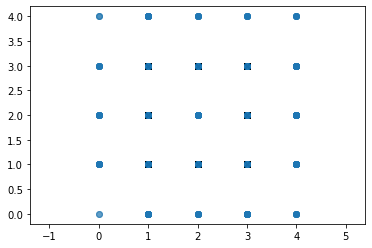

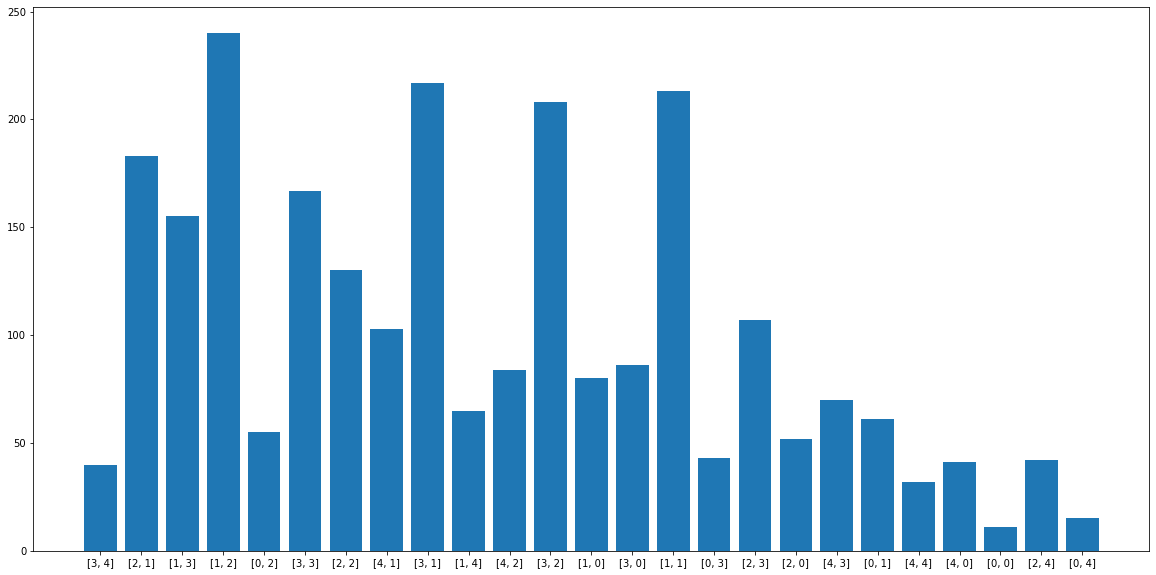

Processing Epoch 36
training start
Iteration 0, d real/fake loss 0.6273502707481384/0.6809157133102417 and g loss is 0.7046864032745361, NDiv loss 0.07888905704021454
Iteration 1, d real/fake loss 0.6271491050720215/0.6835471987724304 and g loss is 0.7042057514190674, NDiv loss 0.08089672774076462
Iteration 2, d real/fake loss 0.6269540786743164/0.6834016442298889 and g loss is 0.7088900804519653, NDiv loss 0.07564883679151535
Iteration 3, d real/fake loss 0.6267625689506531/0.6784012317657471 and g loss is 0.7046353816986084, NDiv loss 0.08108765631914139
Iteration 4, d real/fake loss 0.6265705227851868/0.6746790409088135 and g loss is 0.704810380935669, NDiv loss 0.07826285809278488


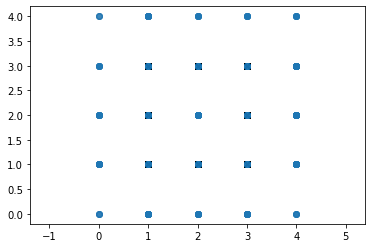

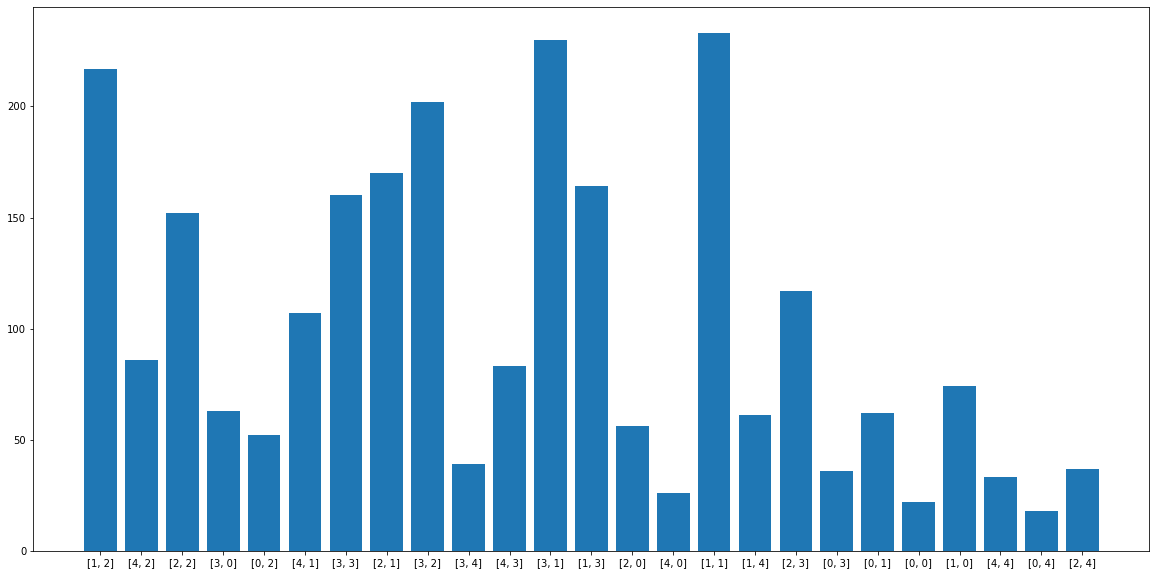

Processing Epoch 37
training start
Iteration 0, d real/fake loss 0.6283289194107056/0.6777493953704834 and g loss is 0.7059474587440491, NDiv loss 0.07779735326766968
Iteration 1, d real/fake loss 0.6281082630157471/0.6796512603759766 and g loss is 0.6999044418334961, NDiv loss 0.08181560039520264
Iteration 2, d real/fake loss 0.6278889179229736/0.675694465637207 and g loss is 0.7065891027450562, NDiv loss 0.07647636532783508
Iteration 3, d real/fake loss 0.6276687979698181/0.6767803430557251 and g loss is 0.7091810703277588, NDiv loss 0.08121205121278763
Iteration 4, d real/fake loss 0.6274487376213074/0.6739603877067566 and g loss is 0.7030431628227234, NDiv loss 0.08268233388662338


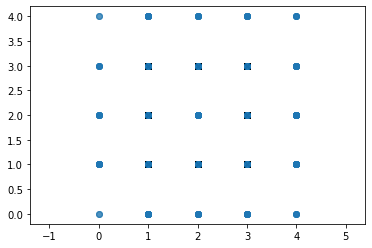

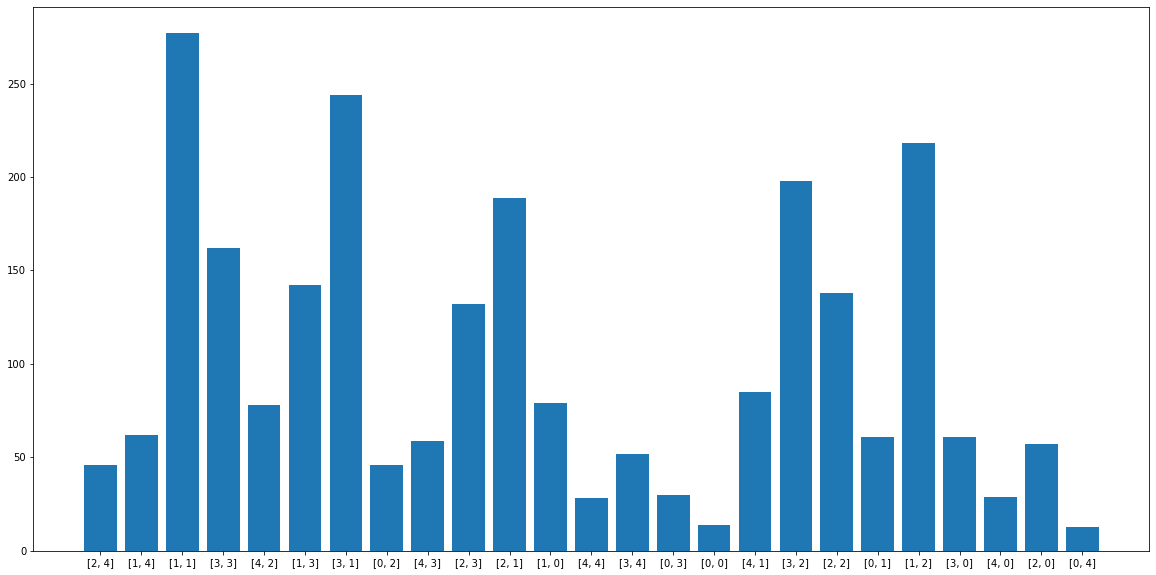

Processing Epoch 38
training start
Iteration 0, d real/fake loss 0.6292235851287842/0.6790989637374878 and g loss is 0.7124198079109192, NDiv loss 0.07802300900220871
Iteration 1, d real/fake loss 0.6289878487586975/0.6771308183670044 and g loss is 0.7127079963684082, NDiv loss 0.08344140648841858
Iteration 2, d real/fake loss 0.6287404894828796/0.6761118173599243 and g loss is 0.704393208026886, NDiv loss 0.08065731823444366
Iteration 3, d real/fake loss 0.6284840703010559/0.6835176944732666 and g loss is 0.712788462638855, NDiv loss 0.07605823874473572
Iteration 4, d real/fake loss 0.6282249689102173/0.678409218788147 and g loss is 0.7066336274147034, NDiv loss 0.08275241404771805


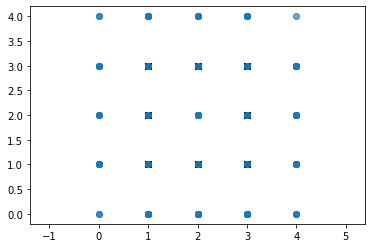

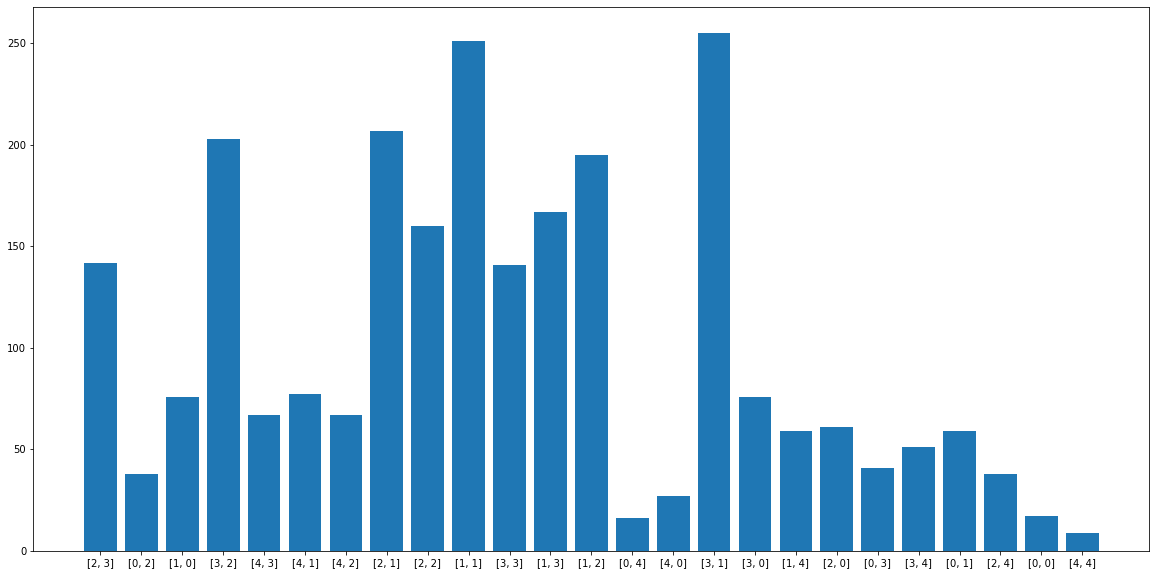

Processing Epoch 39
training start
Iteration 0, d real/fake loss 0.6274925470352173/0.6836549043655396 and g loss is 0.7093555927276611, NDiv loss 0.08126303553581238
Iteration 1, d real/fake loss 0.6272377967834473/0.6784303188323975 and g loss is 0.7084433436393738, NDiv loss 0.07917391508817673
Iteration 2, d real/fake loss 0.6269775629043579/0.6778302192687988 and g loss is 0.7103731036186218, NDiv loss 0.0794188603758812
Iteration 3, d real/fake loss 0.6267132759094238/0.6794561147689819 and g loss is 0.7085374593734741, NDiv loss 0.0826277807354927
Iteration 4, d real/fake loss 0.6264529228210449/0.6857350468635559 and g loss is 0.7015639543533325, NDiv loss 0.07912150025367737


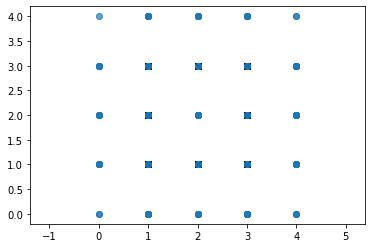

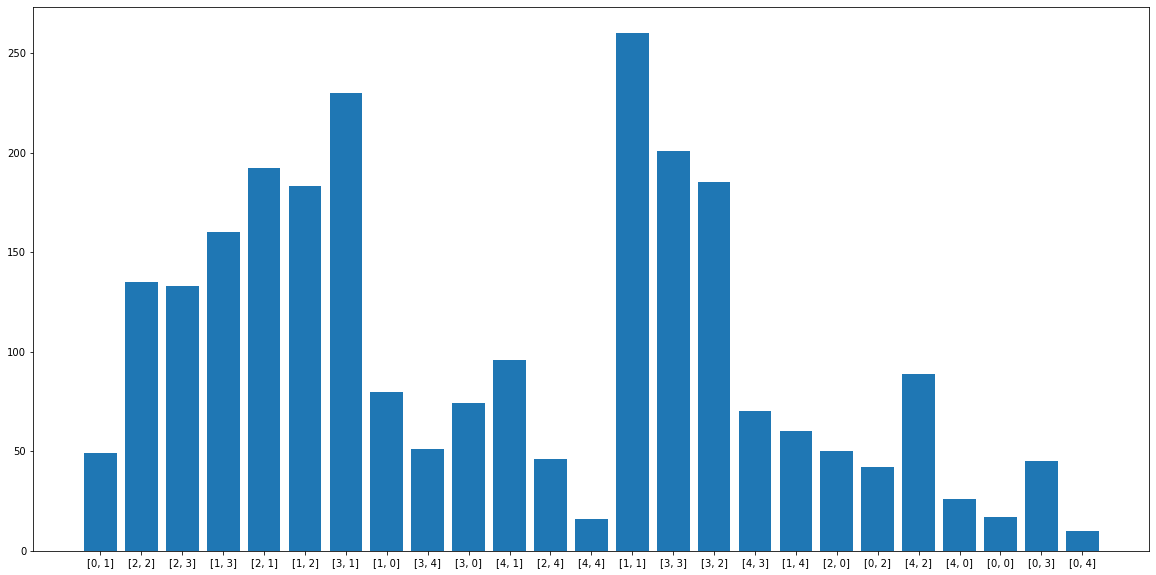

Processing Epoch 40
training start
Iteration 0, d real/fake loss 0.6252771615982056/0.6781485080718994 and g loss is 0.7064509391784668, NDiv loss 0.07919465750455856
Iteration 1, d real/fake loss 0.6250786781311035/0.6833630204200745 and g loss is 0.706795334815979, NDiv loss 0.08760630339384079
Iteration 2, d real/fake loss 0.6248890161514282/0.6756993532180786 and g loss is 0.7090094685554504, NDiv loss 0.0791734978556633
Iteration 3, d real/fake loss 0.6246972680091858/0.682034969329834 and g loss is 0.7151494026184082, NDiv loss 0.08356734365224838
Iteration 4, d real/fake loss 0.6245064735412598/0.677361249923706 and g loss is 0.7055602669715881, NDiv loss 0.08580047637224197


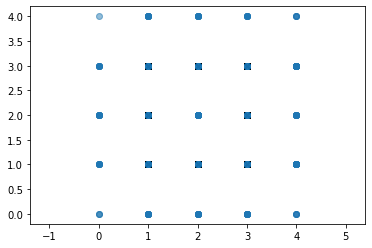

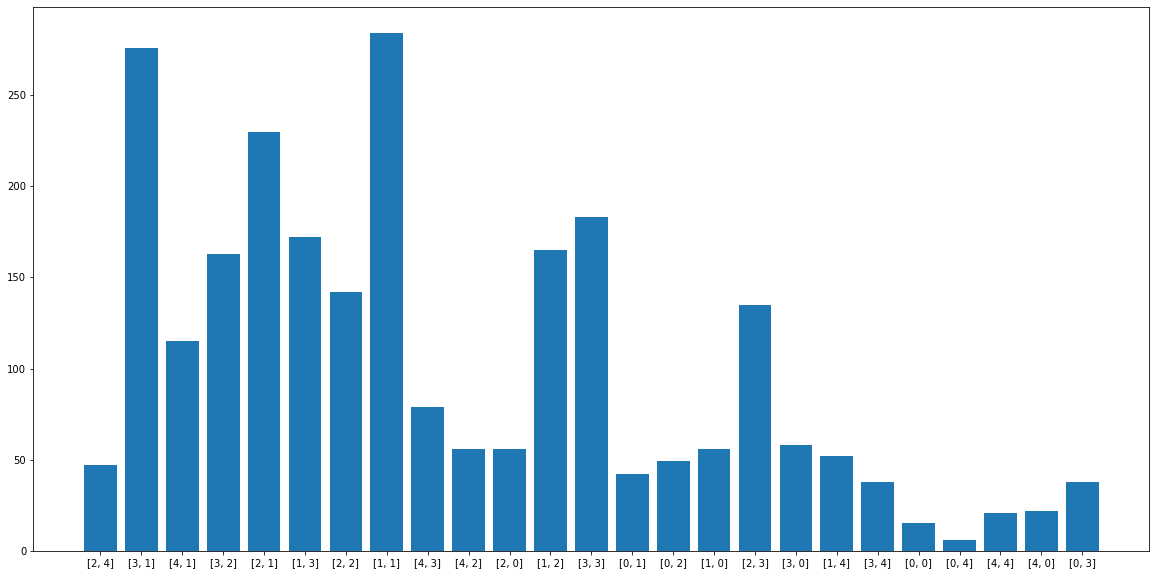

Processing Epoch 41
training start
Iteration 0, d real/fake loss 0.6238628625869751/0.6838018894195557 and g loss is 0.7083240747451782, NDiv loss 0.08111218363046646
Iteration 1, d real/fake loss 0.6236802339553833/0.6760281324386597 and g loss is 0.7030487060546875, NDiv loss 0.07886496186256409
Iteration 2, d real/fake loss 0.6234970688819885/0.6780236959457397 and g loss is 0.7114309072494507, NDiv loss 0.08031691610813141
Iteration 3, d real/fake loss 0.6233122944831848/0.6776190996170044 and g loss is 0.7101585865020752, NDiv loss 0.07987751066684723
Iteration 4, d real/fake loss 0.623131275177002/0.678178071975708 and g loss is 0.7062047719955444, NDiv loss 0.08209562301635742


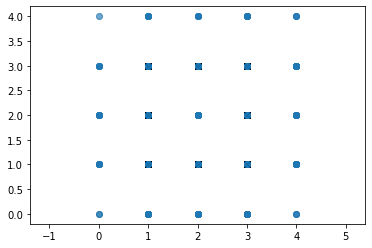

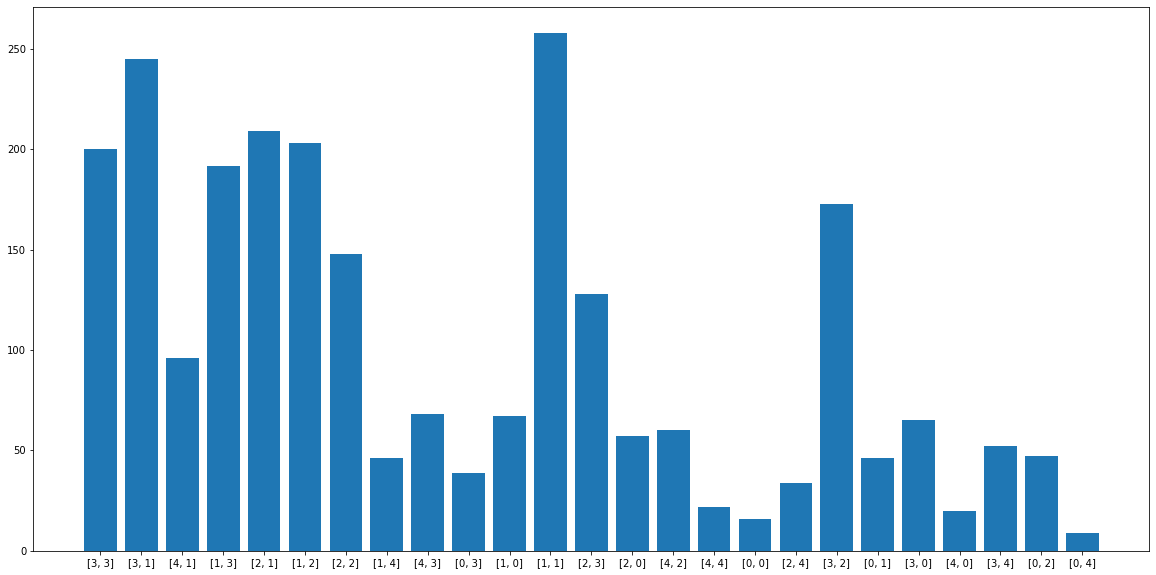

Processing Epoch 42
training start
Iteration 0, d real/fake loss 0.6220324039459229/0.6753493547439575 and g loss is 0.7079261541366577, NDiv loss 0.07638753950595856
Iteration 1, d real/fake loss 0.6218521595001221/0.6798287034034729 and g loss is 0.709757387638092, NDiv loss 0.08408774435520172
Iteration 2, d real/fake loss 0.6216809749603271/0.6826438903808594 and g loss is 0.7064427137374878, NDiv loss 0.07603920251131058
Iteration 3, d real/fake loss 0.6215201020240784/0.6804757118225098 and g loss is 0.709340512752533, NDiv loss 0.08440912514925003
Iteration 4, d real/fake loss 0.6213678121566772/0.684203028678894 and g loss is 0.7102484703063965, NDiv loss 0.08401274681091309


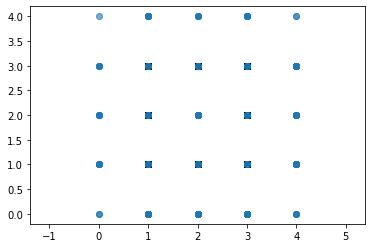

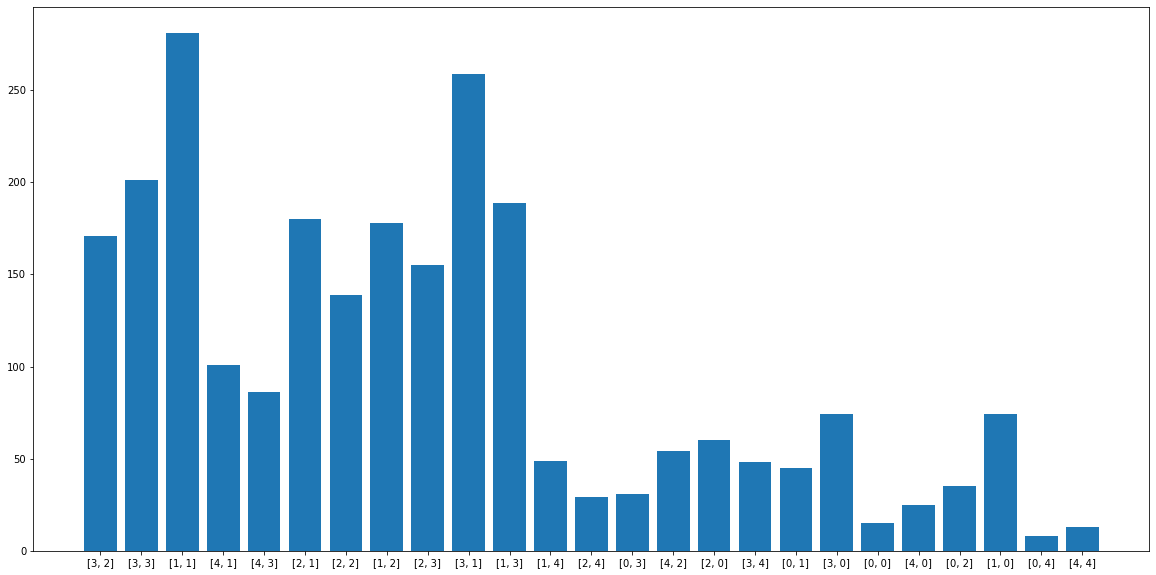

Processing Epoch 43
training start
Iteration 0, d real/fake loss 0.6218667030334473/0.6772647500038147 and g loss is 0.7126631736755371, NDiv loss 0.08372795581817627
Iteration 1, d real/fake loss 0.6217348575592041/0.6755207180976868 and g loss is 0.7079768180847168, NDiv loss 0.08173936605453491
Iteration 2, d real/fake loss 0.6215953826904297/0.672915518283844 and g loss is 0.7131792306900024, NDiv loss 0.08131254464387894
Iteration 3, d real/fake loss 0.6214444041252136/0.6751359701156616 and g loss is 0.7087603807449341, NDiv loss 0.08232937753200531
Iteration 4, d real/fake loss 0.6212873458862305/0.6745771765708923 and g loss is 0.7062340974807739, NDiv loss 0.0826922059059143


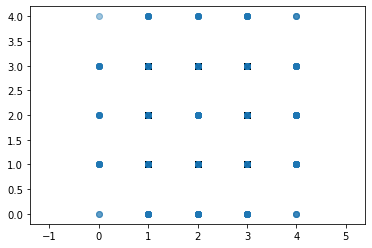

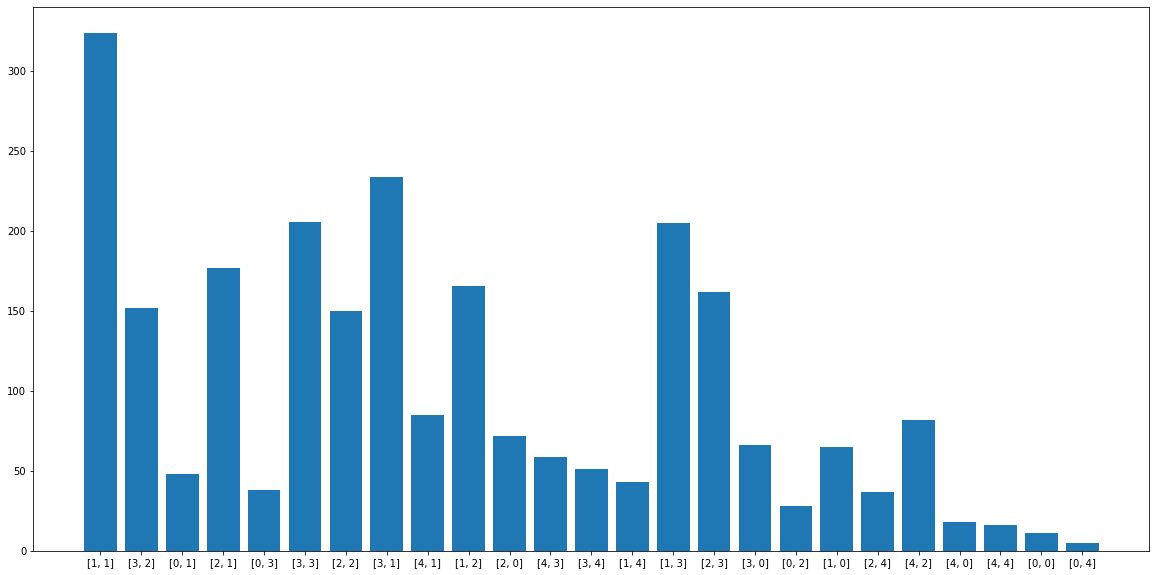

Processing Epoch 44
training start
Iteration 0, d real/fake loss 0.6230641603469849/0.6833864450454712 and g loss is 0.7067777514457703, NDiv loss 0.0826876163482666
Iteration 1, d real/fake loss 0.6229239702224731/0.6787849068641663 and g loss is 0.7089349031448364, NDiv loss 0.08439551293849945
Iteration 2, d real/fake loss 0.6227794289588928/0.6761305332183838 and g loss is 0.7061663866043091, NDiv loss 0.08668747544288635
Iteration 3, d real/fake loss 0.6226170063018799/0.682002067565918 and g loss is 0.7127971053123474, NDiv loss 0.08187130838632584
Iteration 4, d real/fake loss 0.6224563717842102/0.6803920269012451 and g loss is 0.7158759236335754, NDiv loss 0.08296554535627365


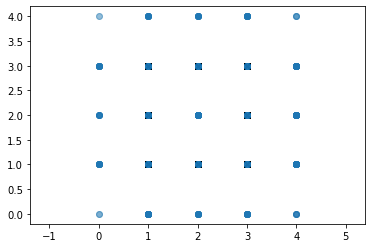

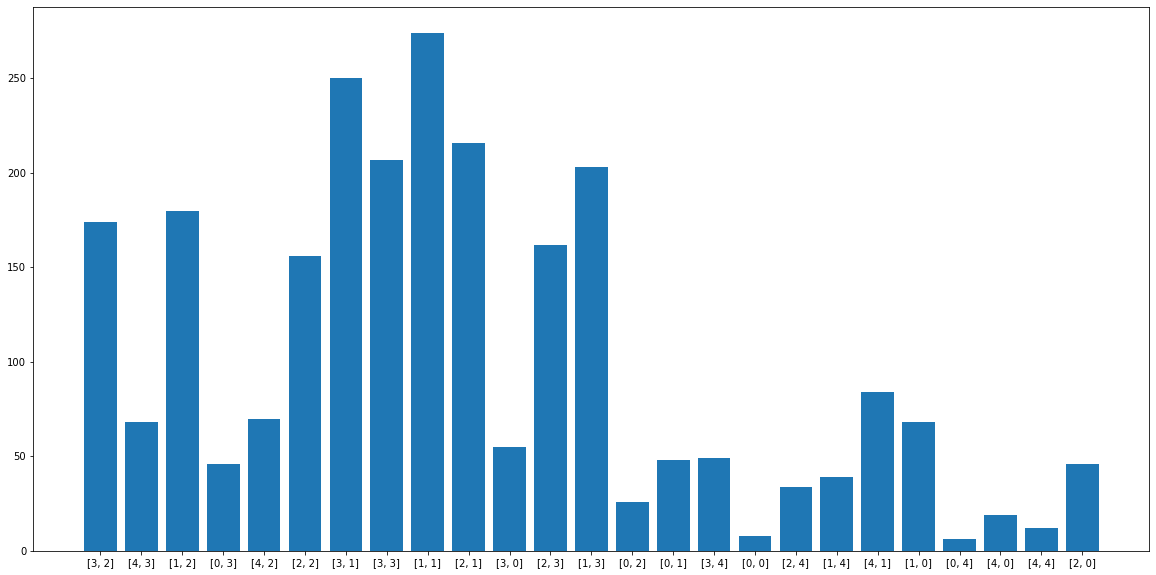

Processing Epoch 45
training start
Iteration 0, d real/fake loss 0.6216572523117065/0.675925076007843 and g loss is 0.7111884355545044, NDiv loss 0.08185981959104538
Iteration 1, d real/fake loss 0.6214962005615234/0.6845008730888367 and g loss is 0.7086865305900574, NDiv loss 0.08274593204259872
Iteration 2, d real/fake loss 0.621346116065979/0.6820307970046997 and g loss is 0.7084087133407593, NDiv loss 0.08410894125699997
Iteration 3, d real/fake loss 0.6211997270584106/0.6816386580467224 and g loss is 0.707626461982727, NDiv loss 0.08765973150730133
Iteration 4, d real/fake loss 0.621053159236908/0.6799670457839966 and g loss is 0.7105229496955872, NDiv loss 0.08644696325063705


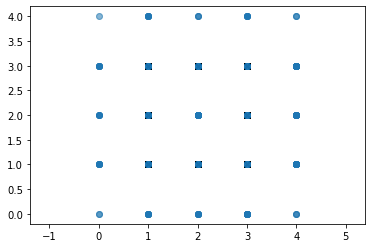

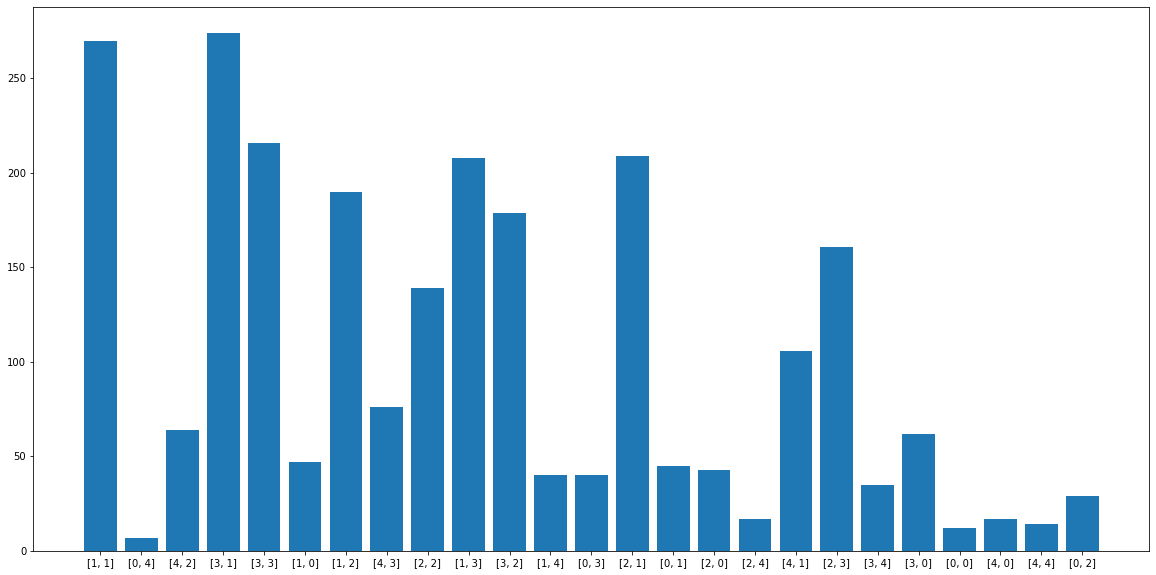

Processing Epoch 46
training start
Iteration 0, d real/fake loss 0.6210627555847168/0.675868034362793 and g loss is 0.7141050696372986, NDiv loss 0.08557146042585373
Iteration 1, d real/fake loss 0.6209025382995605/0.676403284072876 and g loss is 0.7063006162643433, NDiv loss 0.09266714751720428
Iteration 2, d real/fake loss 0.620730996131897/0.6758465766906738 and g loss is 0.7094547748565674, NDiv loss 0.08126219362020493
Iteration 3, d real/fake loss 0.6205553412437439/0.6771899461746216 and g loss is 0.7079172134399414, NDiv loss 0.08617877215147018
Iteration 4, d real/fake loss 0.6203761100769043/0.6815052628517151 and g loss is 0.7069228887557983, NDiv loss 0.08573592454195023


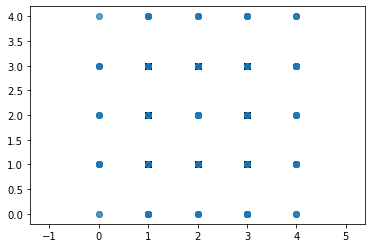

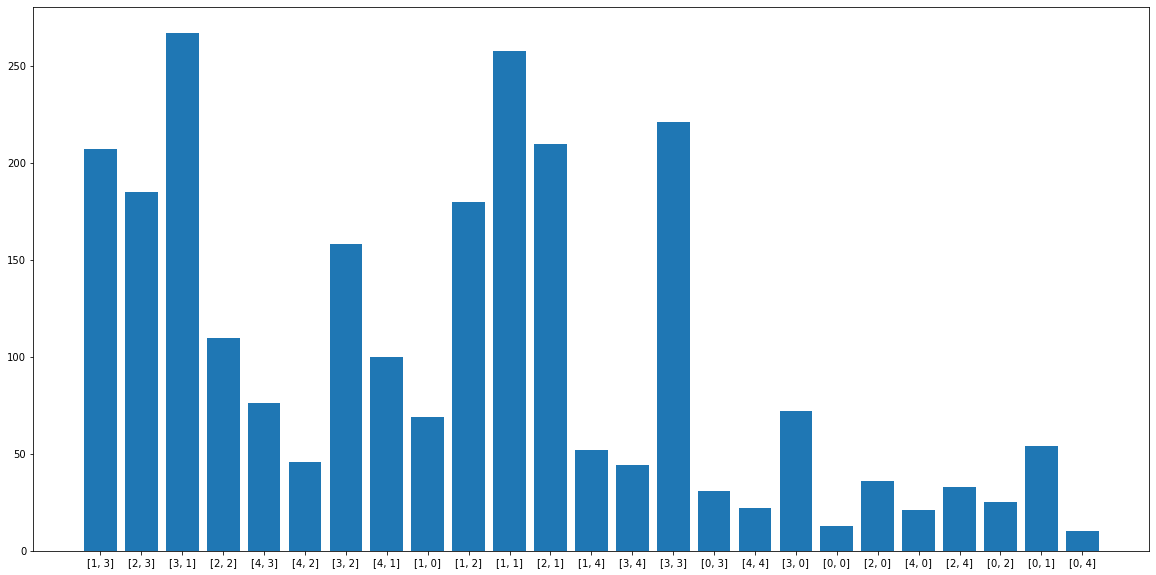

Processing Epoch 47
training start
Iteration 0, d real/fake loss 0.6213902831077576/0.6791610717773438 and g loss is 0.7095276117324829, NDiv loss 0.0860537439584732
Iteration 1, d real/fake loss 0.6212224960327148/0.682113766670227 and g loss is 0.7174780368804932, NDiv loss 0.08149140328168869
Iteration 2, d real/fake loss 0.6210564374923706/0.6762125492095947 and g loss is 0.710242748260498, NDiv loss 0.087537981569767
Iteration 3, d real/fake loss 0.6208816766738892/0.6762809753417969 and g loss is 0.7068418264389038, NDiv loss 0.08152884989976883
Iteration 4, d real/fake loss 0.620701789855957/0.675917387008667 and g loss is 0.7137994766235352, NDiv loss 0.08655388653278351


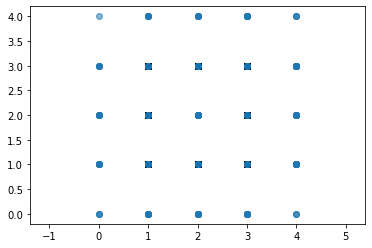

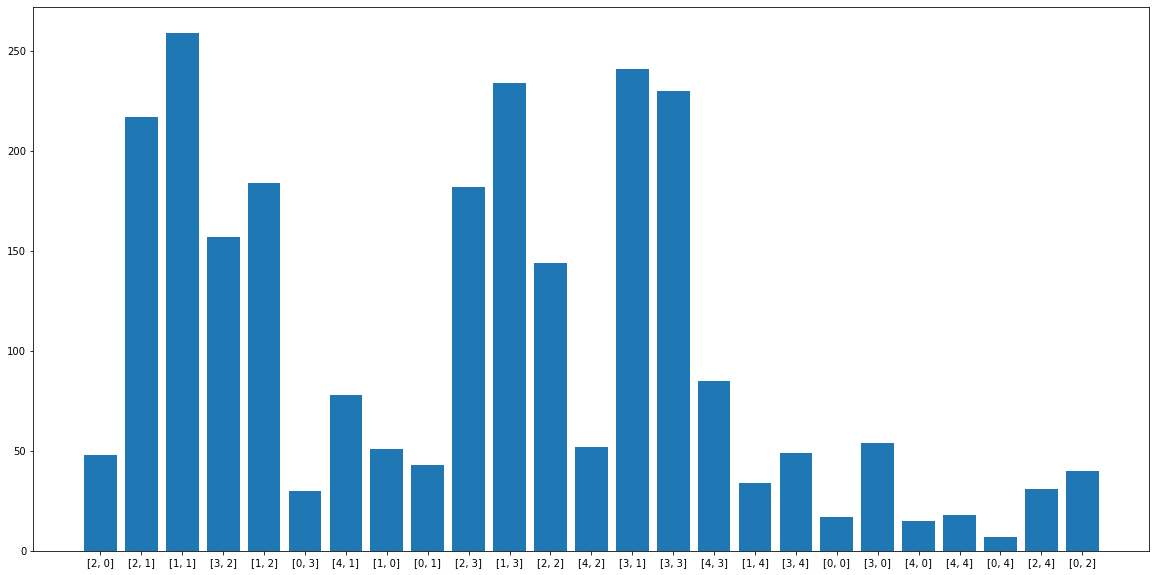

Processing Epoch 48
training start
Iteration 0, d real/fake loss 0.6204975247383118/0.6816971898078918 and g loss is 0.7101579904556274, NDiv loss 0.08190996944904327
Iteration 1, d real/fake loss 0.620320200920105/0.6685405373573303 and g loss is 0.703652024269104, NDiv loss 0.0829402431845665
Iteration 2, d real/fake loss 0.6201229691505432/0.6822406053543091 and g loss is 0.708208441734314, NDiv loss 0.08703209459781647
Iteration 3, d real/fake loss 0.6199358105659485/0.6820167303085327 and g loss is 0.7100155353546143, NDiv loss 0.08737246692180634
Iteration 4, d real/fake loss 0.6197472810745239/0.6809214353561401 and g loss is 0.7086389064788818, NDiv loss 0.08421438932418823


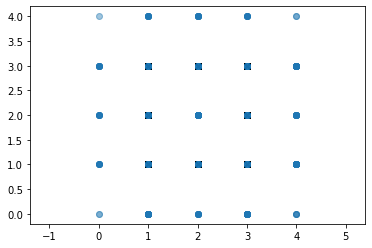

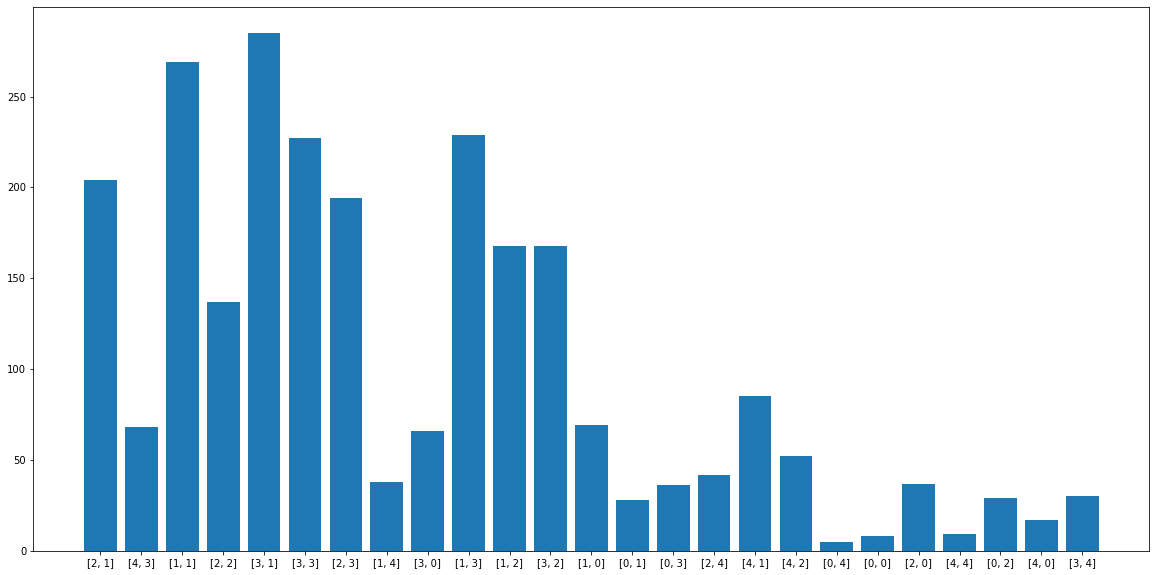

Processing Epoch 49
training start
Iteration 0, d real/fake loss 0.6174547076225281/0.6807795166969299 and g loss is 0.7080130577087402, NDiv loss 0.08267191797494888
Iteration 1, d real/fake loss 0.6172854900360107/0.6762993335723877 and g loss is 0.716701865196228, NDiv loss 0.08992352336645126
Iteration 2, d real/fake loss 0.6171163320541382/0.677539587020874 and g loss is 0.7076963782310486, NDiv loss 0.0823698490858078
Iteration 3, d real/fake loss 0.6169442534446716/0.6768581867218018 and g loss is 0.704903244972229, NDiv loss 0.08789990097284317
Iteration 4, d real/fake loss 0.6167711019515991/0.6762459874153137 and g loss is 0.7049962282180786, NDiv loss 0.09361206740140915


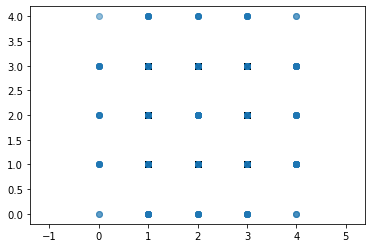

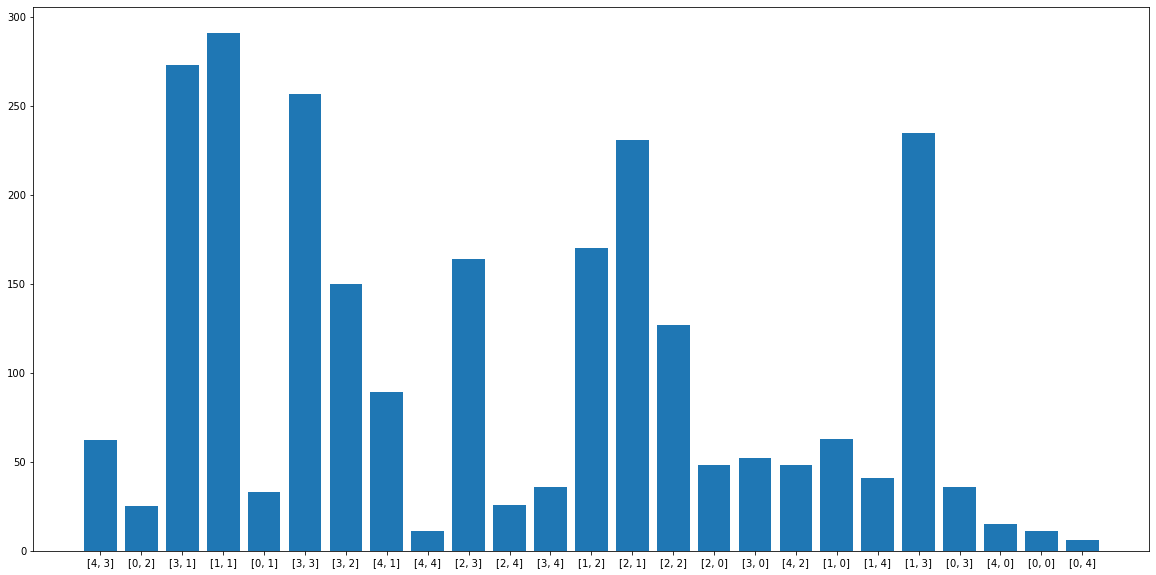

Processing Epoch 50
training start
Iteration 0, d real/fake loss 0.6171413660049438/0.6789367198944092 and g loss is 0.707354724407196, NDiv loss 0.08523230999708176
Iteration 1, d real/fake loss 0.6169695854187012/0.6701894998550415 and g loss is 0.7141076326370239, NDiv loss 0.08869266510009766
Iteration 2, d real/fake loss 0.6167905330657959/0.6772493720054626 and g loss is 0.7124396562576294, NDiv loss 0.08563100546598434
Iteration 3, d real/fake loss 0.6166175603866577/0.6805394887924194 and g loss is 0.7153540849685669, NDiv loss 0.0826030746102333
Iteration 4, d real/fake loss 0.6164504885673523/0.6768602728843689 and g loss is 0.7141996622085571, NDiv loss 0.08329185843467712


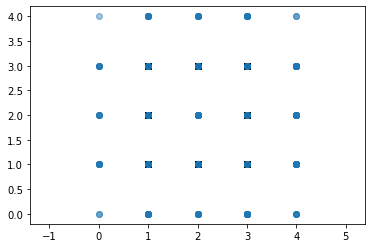

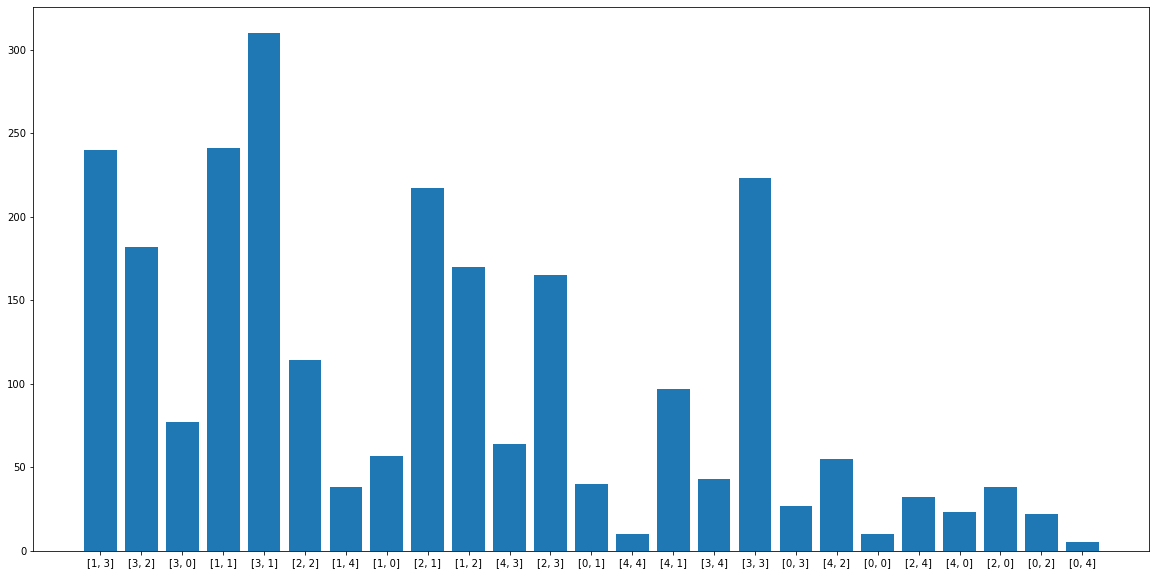

Processing Epoch 51
training start
Iteration 0, d real/fake loss 0.6174758672714233/0.6808143258094788 and g loss is 0.7059527635574341, NDiv loss 0.09165583550930023
Iteration 1, d real/fake loss 0.6173076629638672/0.6738381385803223 and g loss is 0.7066073417663574, NDiv loss 0.09008671343326569
Iteration 2, d real/fake loss 0.6171278357505798/0.6845892667770386 and g loss is 0.7042809724807739, NDiv loss 0.08532418310642242
Iteration 3, d real/fake loss 0.6169498562812805/0.6758294105529785 and g loss is 0.7046955823898315, NDiv loss 0.08951835334300995
Iteration 4, d real/fake loss 0.6167625188827515/0.6757563352584839 and g loss is 0.7036594152450562, NDiv loss 0.09045954793691635


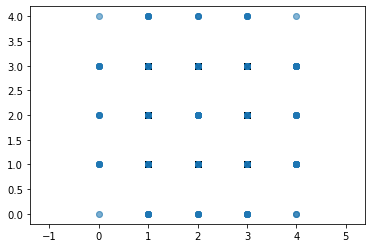

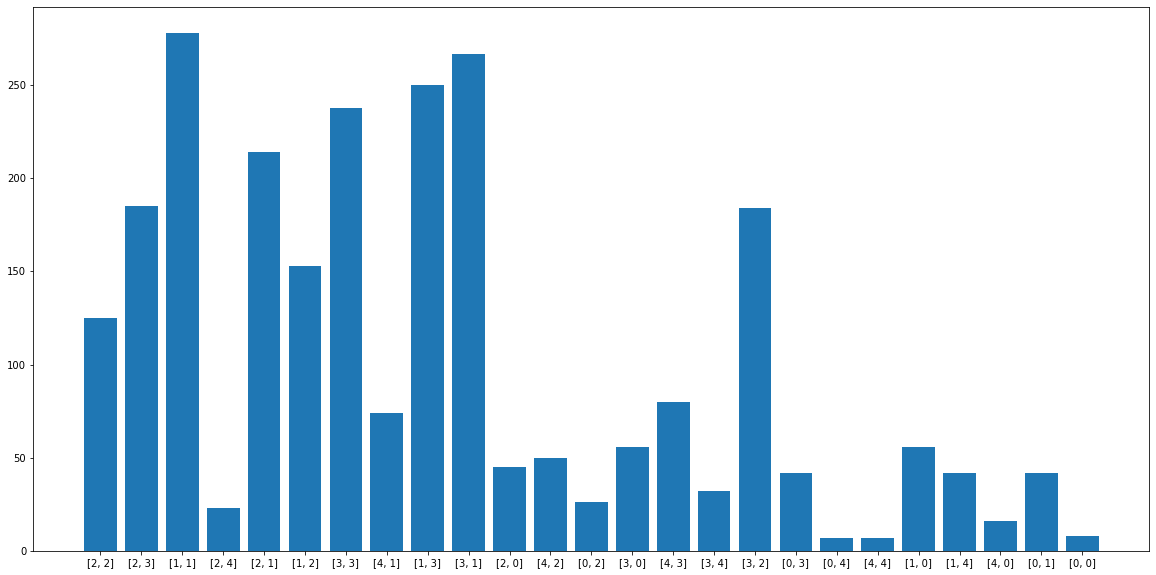

Processing Epoch 52
training start
Iteration 0, d real/fake loss 0.6150733828544617/0.6791382431983948 and g loss is 0.71030193567276, NDiv loss 0.08761206269264221
Iteration 1, d real/fake loss 0.6149260997772217/0.6849455833435059 and g loss is 0.7092355489730835, NDiv loss 0.08424808830022812
Iteration 2, d real/fake loss 0.6147925853729248/0.6818835735321045 and g loss is 0.7091845870018005, NDiv loss 0.08514184504747391
Iteration 3, d real/fake loss 0.614669144153595/0.6806801557540894 and g loss is 0.7057448625564575, NDiv loss 0.08585816621780396
Iteration 4, d real/fake loss 0.6145508885383606/0.681735098361969 and g loss is 0.7092432975769043, NDiv loss 0.08313147723674774


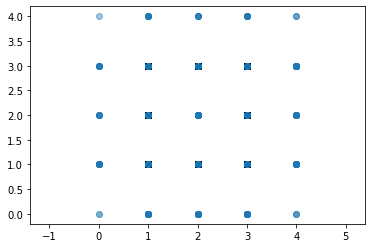

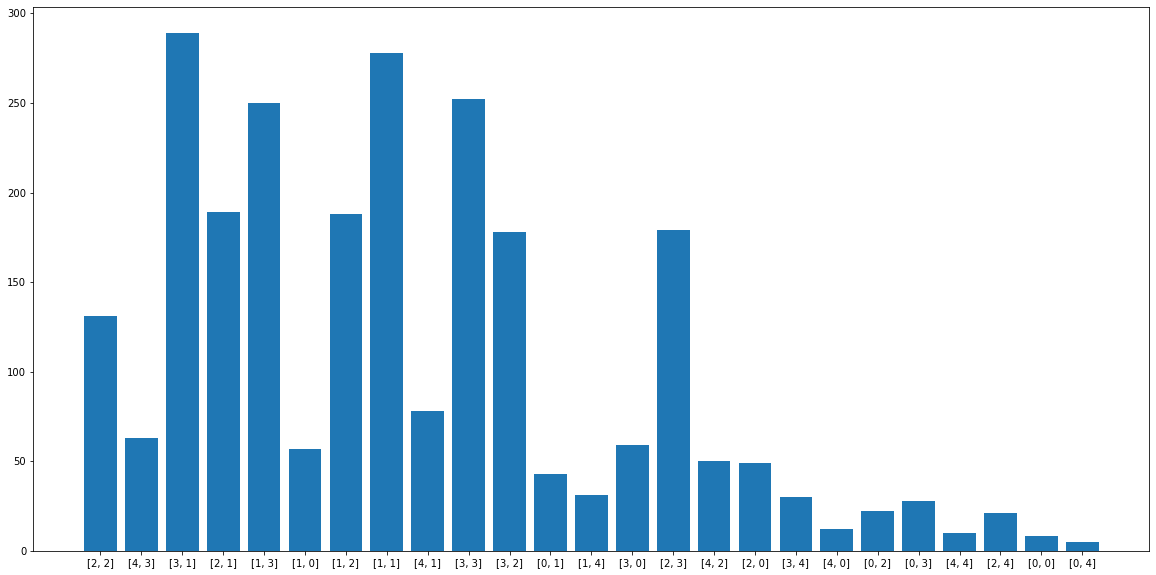

Processing Epoch 53
training start
Iteration 0, d real/fake loss 0.6143742799758911/0.6792511940002441 and g loss is 0.7157502770423889, NDiv loss 0.08868291974067688
Iteration 1, d real/fake loss 0.614268958568573/0.677195131778717 and g loss is 0.7007144093513489, NDiv loss 0.0854218602180481
Iteration 2, d real/fake loss 0.6141674518585205/0.683182954788208 and g loss is 0.7156219482421875, NDiv loss 0.08551046252250671
Iteration 3, d real/fake loss 0.6140737533569336/0.6731702089309692 and g loss is 0.7112140655517578, NDiv loss 0.08582762628793716
Iteration 4, d real/fake loss 0.613981306552887/0.6767603754997253 and g loss is 0.7005305290222168, NDiv loss 0.08657656610012054


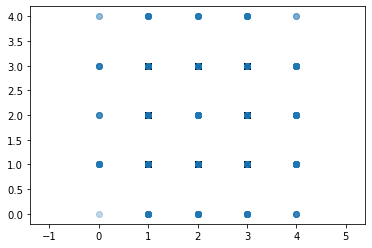

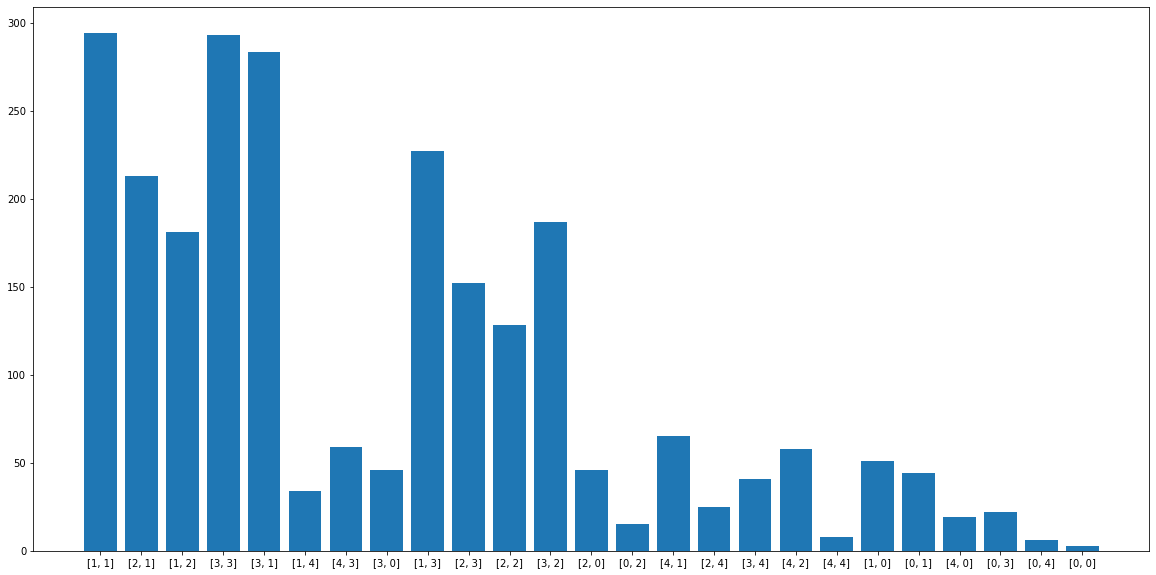

Processing Epoch 54
training start
Iteration 0, d real/fake loss 0.6134529709815979/0.6825394034385681 and g loss is 0.7072850465774536, NDiv loss 0.08944450318813324
Iteration 1, d real/fake loss 0.6133841276168823/0.6872984170913696 and g loss is 0.7174075841903687, NDiv loss 0.08958733826875687
Iteration 2, d real/fake loss 0.6133267879486084/0.6742680072784424 and g loss is 0.7130542993545532, NDiv loss 0.08915486186742783
Iteration 3, d real/fake loss 0.613269031047821/0.6750856637954712 and g loss is 0.7146682143211365, NDiv loss 0.09000396728515625
Iteration 4, d real/fake loss 0.6132037043571472/0.6755300760269165 and g loss is 0.7109090089797974, NDiv loss 0.08168686181306839


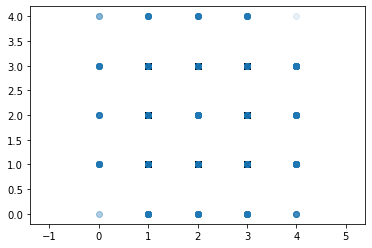

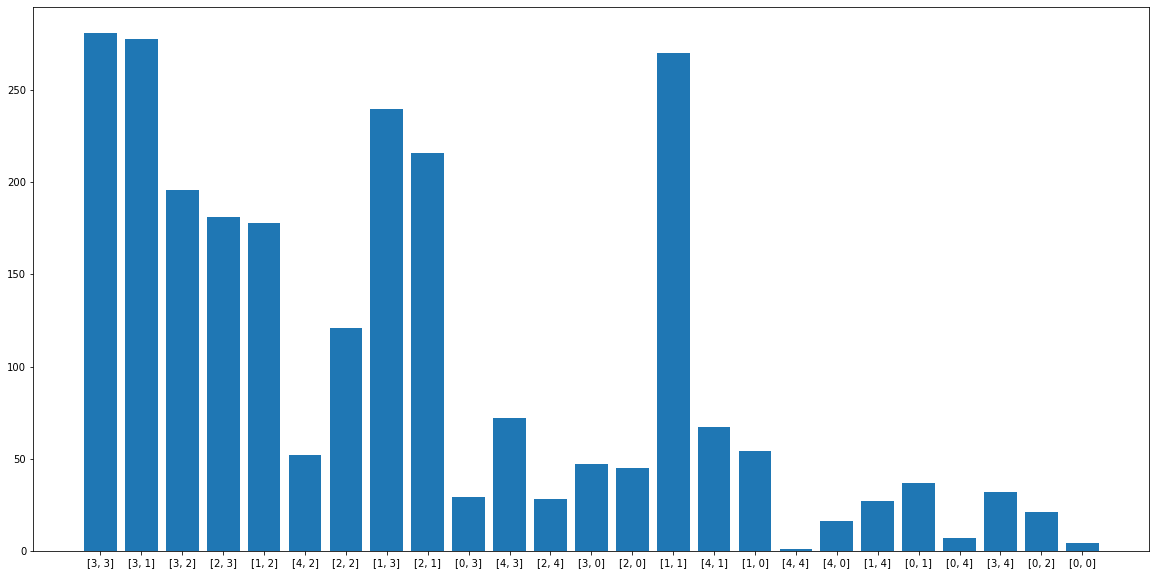

Processing Epoch 55
training start
Iteration 0, d real/fake loss 0.6142979860305786/0.6772643327713013 and g loss is 0.7149618864059448, NDiv loss 0.0841936394572258
Iteration 1, d real/fake loss 0.6142339706420898/0.6664036512374878 and g loss is 0.7075268030166626, NDiv loss 0.08899582177400589
Iteration 2, d real/fake loss 0.6141534447669983/0.6772562265396118 and g loss is 0.7111797332763672, NDiv loss 0.0864119827747345
Iteration 3, d real/fake loss 0.6140683889389038/0.6722152233123779 and g loss is 0.7092647552490234, NDiv loss 0.08806291222572327
Iteration 4, d real/fake loss 0.6139805316925049/0.6764655113220215 and g loss is 0.7103882431983948, NDiv loss 0.0873095914721489


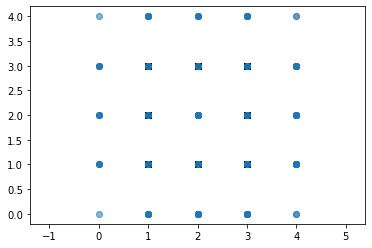

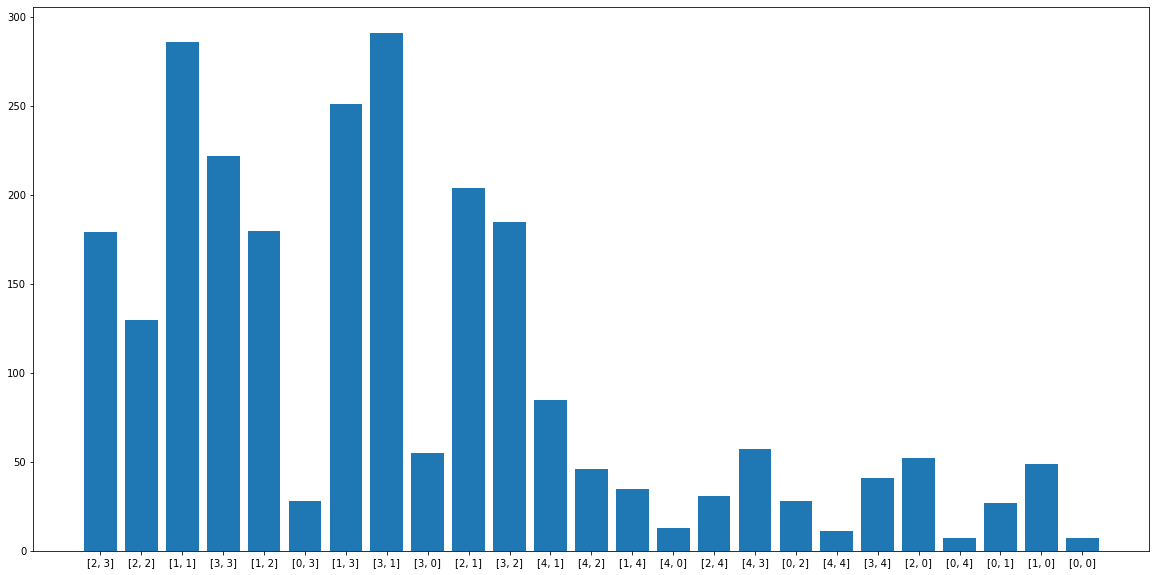

Processing Epoch 56
training start
Iteration 0, d real/fake loss 0.6162881255149841/0.6733639240264893 and g loss is 0.7158935070037842, NDiv loss 0.08680424094200134
Iteration 1, d real/fake loss 0.6162015199661255/0.6773518919944763 and g loss is 0.7090859413146973, NDiv loss 0.08796005696058273
Iteration 2, d real/fake loss 0.6161031723022461/0.6759940385818481 and g loss is 0.7079712152481079, NDiv loss 0.08024122565984726
Iteration 3, d real/fake loss 0.6159934997558594/0.6789503693580627 and g loss is 0.7164782285690308, NDiv loss 0.09089364856481552
Iteration 4, d real/fake loss 0.6158732175827026/0.6754879951477051 and g loss is 0.7091778516769409, NDiv loss 0.0908481702208519


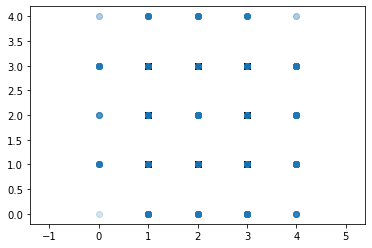

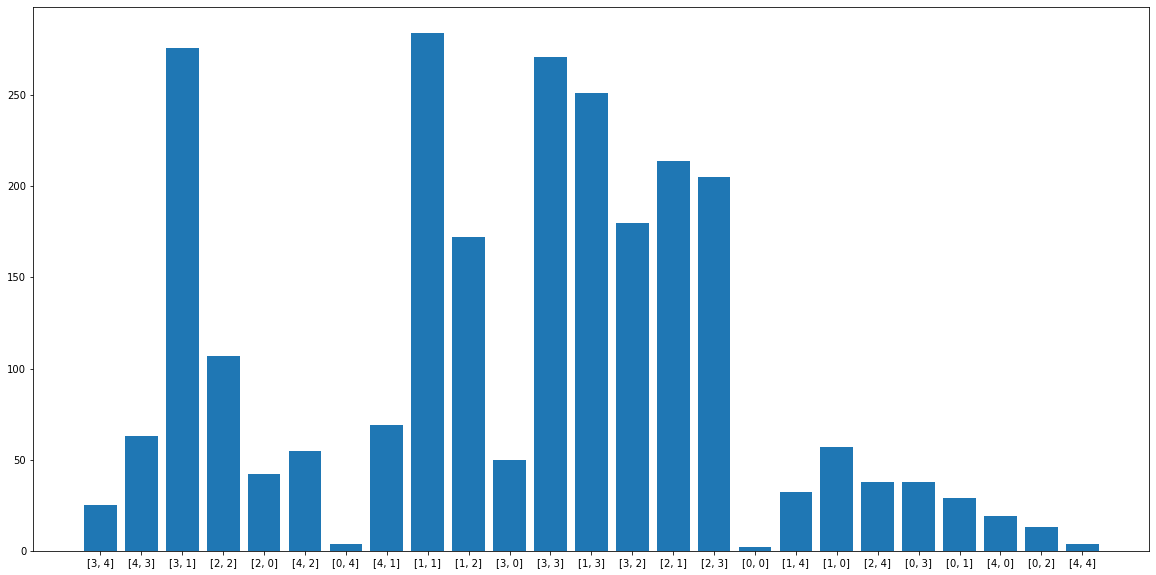

Processing Epoch 57
training start
Iteration 0, d real/fake loss 0.6129610538482666/0.6865345239639282 and g loss is 0.713652491569519, NDiv loss 0.09237528592348099
Iteration 1, d real/fake loss 0.6128544211387634/0.6724231839179993 and g loss is 0.7129442691802979, NDiv loss 0.08430799096822739
Iteration 2, d real/fake loss 0.6127342581748962/0.6859951019287109 and g loss is 0.7157796621322632, NDiv loss 0.08749162405729294
Iteration 3, d real/fake loss 0.6126226782798767/0.6799530982971191 and g loss is 0.706040620803833, NDiv loss 0.09324973076581955
Iteration 4, d real/fake loss 0.612508237361908/0.6727607250213623 and g loss is 0.7191277146339417, NDiv loss 0.09070398658514023


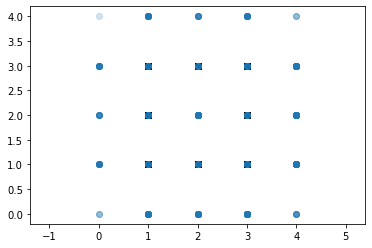

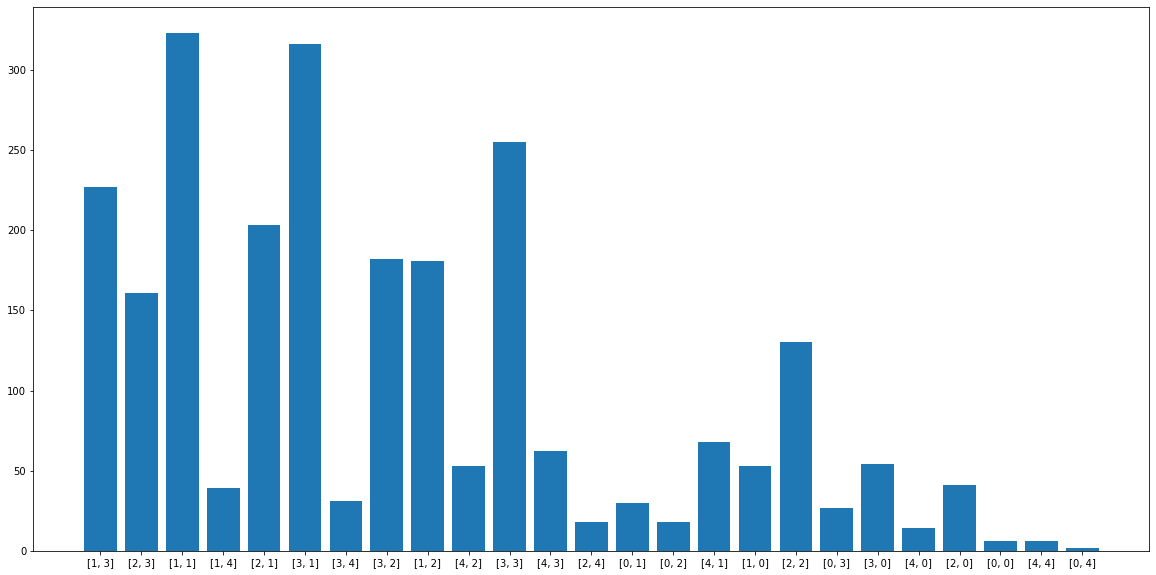

Processing Epoch 58
training start
Iteration 0, d real/fake loss 0.6130682826042175/0.6742873191833496 and g loss is 0.7091373205184937, NDiv loss 0.0891963317990303
Iteration 1, d real/fake loss 0.6129398941993713/0.6772149205207825 and g loss is 0.7098374366760254, NDiv loss 0.08857793360948563
Iteration 2, d real/fake loss 0.6128065586090088/0.6752402186393738 and g loss is 0.7081289291381836, NDiv loss 0.09527377039194107
Iteration 3, d real/fake loss 0.612666130065918/0.6763318777084351 and g loss is 0.7111791968345642, NDiv loss 0.09254249930381775
Iteration 4, d real/fake loss 0.6125199198722839/0.6732025742530823 and g loss is 0.7140140533447266, NDiv loss 0.09050697833299637


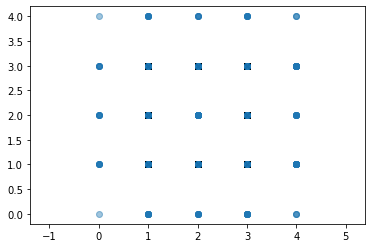

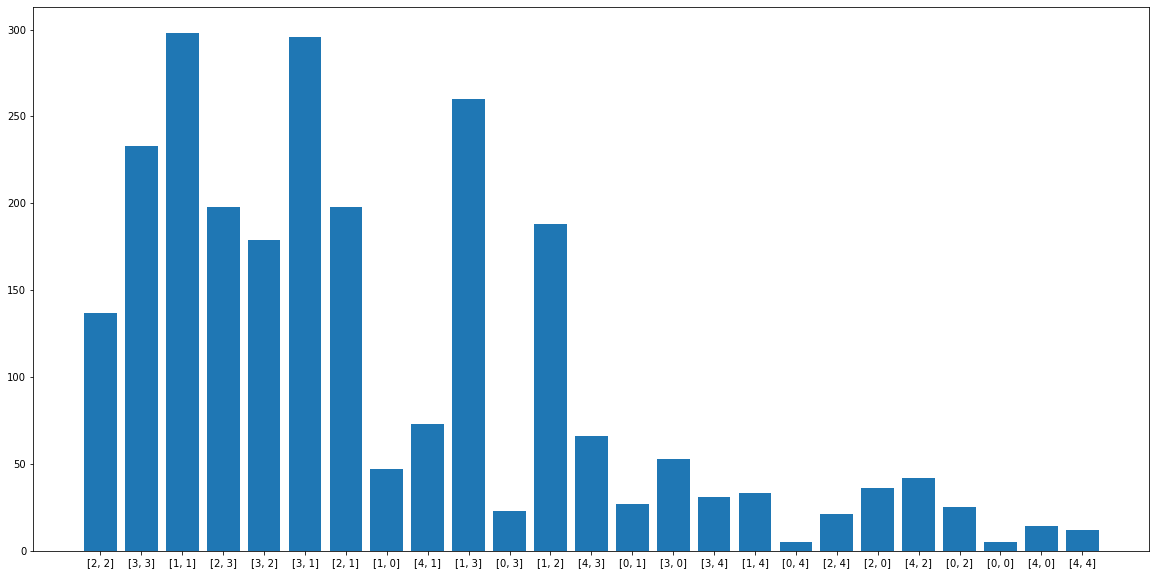

Processing Epoch 59
training start
Iteration 0, d real/fake loss 0.6131678223609924/0.6745924353599548 and g loss is 0.7189711332321167, NDiv loss 0.08988707512617111
Iteration 1, d real/fake loss 0.6130331754684448/0.6724851131439209 and g loss is 0.7114158272743225, NDiv loss 0.08474567532539368
Iteration 2, d real/fake loss 0.6128914952278137/0.6750655174255371 and g loss is 0.7064531445503235, NDiv loss 0.08524352312088013
Iteration 3, d real/fake loss 0.6127480864524841/0.6795110106468201 and g loss is 0.7114450931549072, NDiv loss 0.09766112267971039
Iteration 4, d real/fake loss 0.6126164197921753/0.6733250617980957 and g loss is 0.7156593799591064, NDiv loss 0.08868815749883652


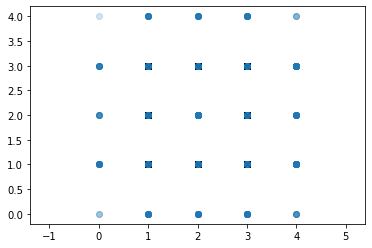

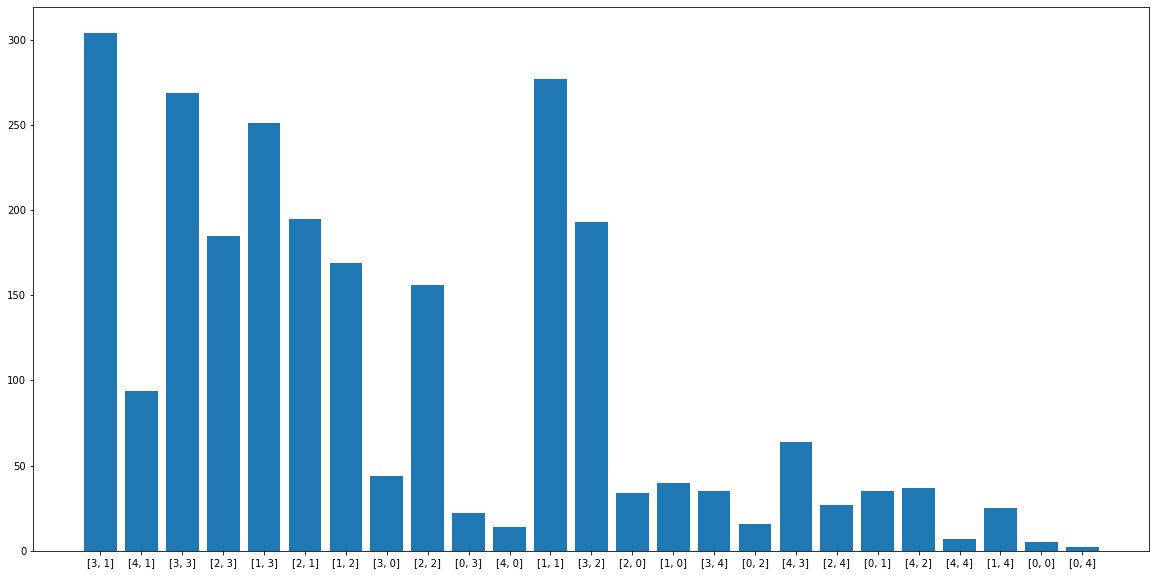

Processing Epoch 60
training start
Iteration 0, d real/fake loss 0.6108972430229187/0.6798379421234131 and g loss is 0.7174646854400635, NDiv loss 0.09354113042354584
Iteration 1, d real/fake loss 0.6107935905456543/0.6769808530807495 and g loss is 0.7185677289962769, NDiv loss 0.08960382640361786
Iteration 2, d real/fake loss 0.6106801629066467/0.6704768538475037 and g loss is 0.719728946685791, NDiv loss 0.09205735474824905
Iteration 3, d real/fake loss 0.6105477809906006/0.6766767501831055 and g loss is 0.7058802843093872, NDiv loss 0.0912124440073967
Iteration 4, d real/fake loss 0.6104159355163574/0.668870747089386 and g loss is 0.712562084197998, NDiv loss 0.08809537440538406


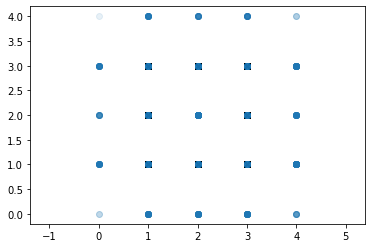

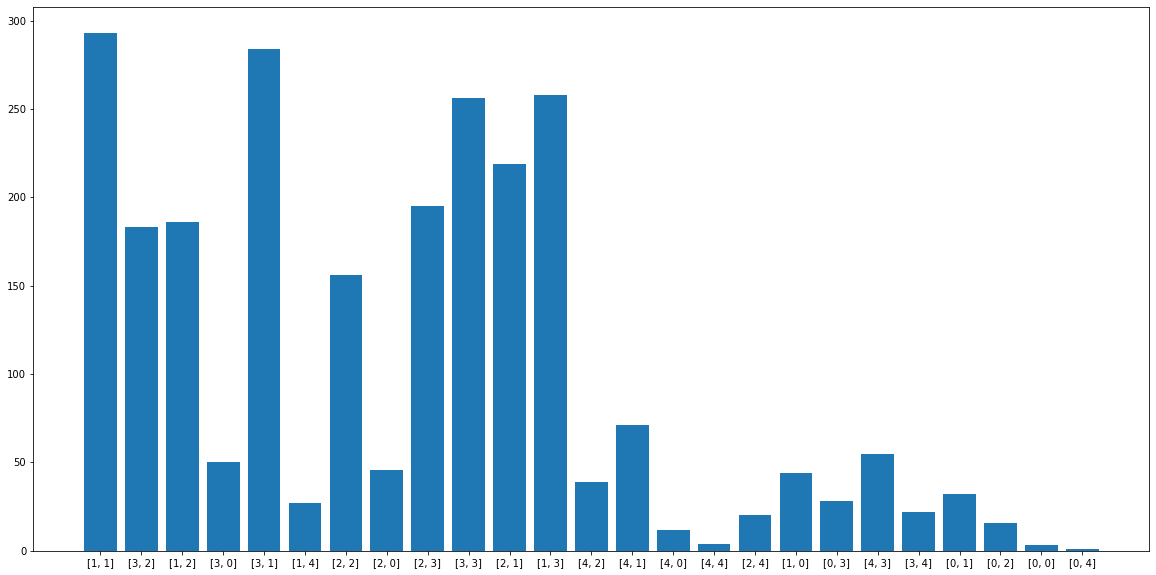

Processing Epoch 61
training start
Iteration 0, d real/fake loss 0.61171555519104/0.6836659908294678 and g loss is 0.7090287208557129, NDiv loss 0.09322452545166016
Iteration 1, d real/fake loss 0.6115802526473999/0.6767044067382812 and g loss is 0.7148337364196777, NDiv loss 0.09773814678192139
Iteration 2, d real/fake loss 0.6114509105682373/0.676338791847229 and g loss is 0.7084202766418457, NDiv loss 0.09116939455270767
Iteration 3, d real/fake loss 0.6113195419311523/0.6728222370147705 and g loss is 0.7228046655654907, NDiv loss 0.08664736151695251
Iteration 4, d real/fake loss 0.6111837029457092/0.67333984375 and g loss is 0.7101356983184814, NDiv loss 0.09664180129766464


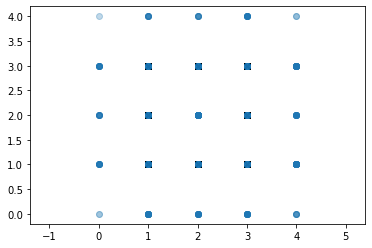

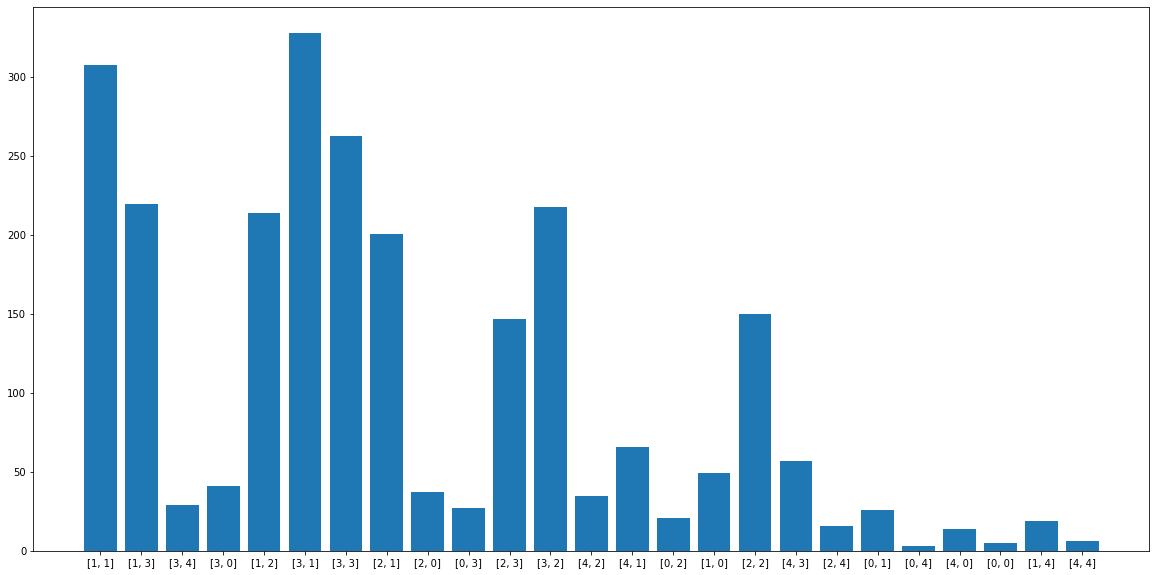

Processing Epoch 62
training start
Iteration 0, d real/fake loss 0.6096794605255127/0.671671986579895 and g loss is 0.7104620933532715, NDiv loss 0.09299001097679138
Iteration 1, d real/fake loss 0.6095784902572632/0.6743173599243164 and g loss is 0.7116900086402893, NDiv loss 0.09382972121238708
Iteration 2, d real/fake loss 0.6094820499420166/0.6737086772918701 and g loss is 0.7210540175437927, NDiv loss 0.09114548563957214
Iteration 3, d real/fake loss 0.6093894243240356/0.6806894540786743 and g loss is 0.7170236110687256, NDiv loss 0.08489688485860825
Iteration 4, d real/fake loss 0.6093165874481201/0.6776100397109985 and g loss is 0.7070202827453613, NDiv loss 0.09013606607913971


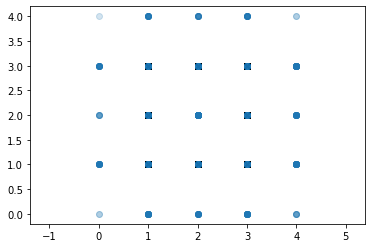

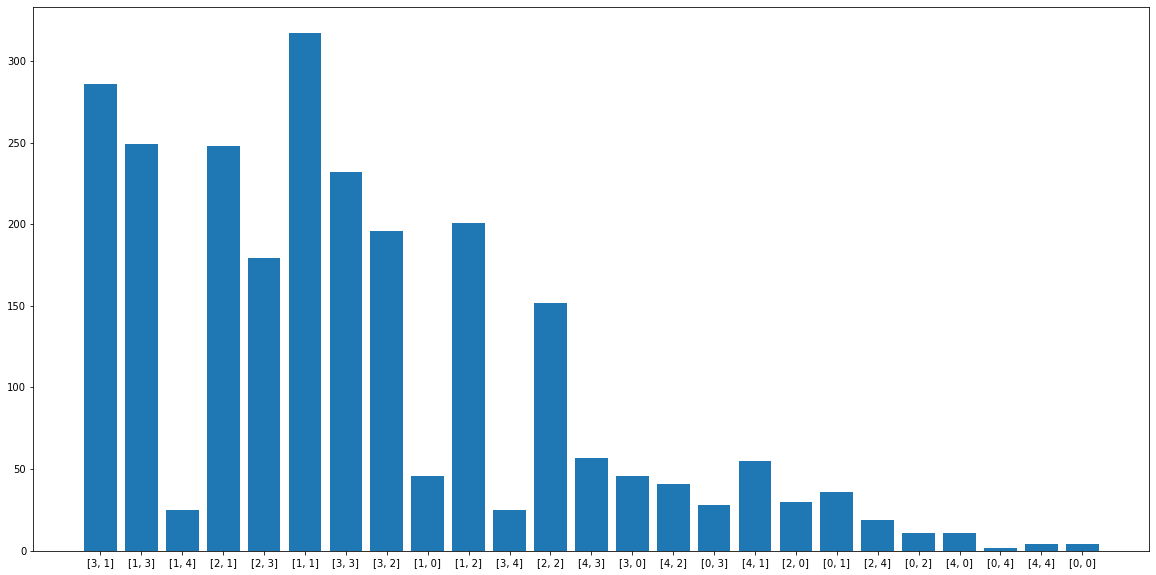

Processing Epoch 63
training start
Iteration 0, d real/fake loss 0.609979510307312/0.680712103843689 and g loss is 0.7089145183563232, NDiv loss 0.09202807396650314
Iteration 1, d real/fake loss 0.6099249124526978/0.6766369342803955 and g loss is 0.7078828811645508, NDiv loss 0.0938970297574997
Iteration 2, d real/fake loss 0.6098735928535461/0.6814333200454712 and g loss is 0.7128990888595581, NDiv loss 0.09646126627922058
Iteration 3, d real/fake loss 0.6098288297653198/0.6721572875976562 and g loss is 0.7098957300186157, NDiv loss 0.0994865670800209
Iteration 4, d real/fake loss 0.6097805500030518/0.6743848323822021 and g loss is 0.7093840837478638, NDiv loss 0.09590831398963928


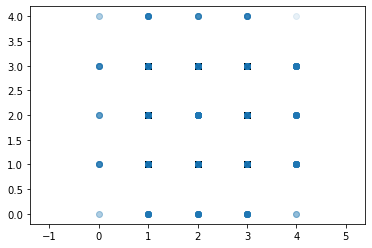

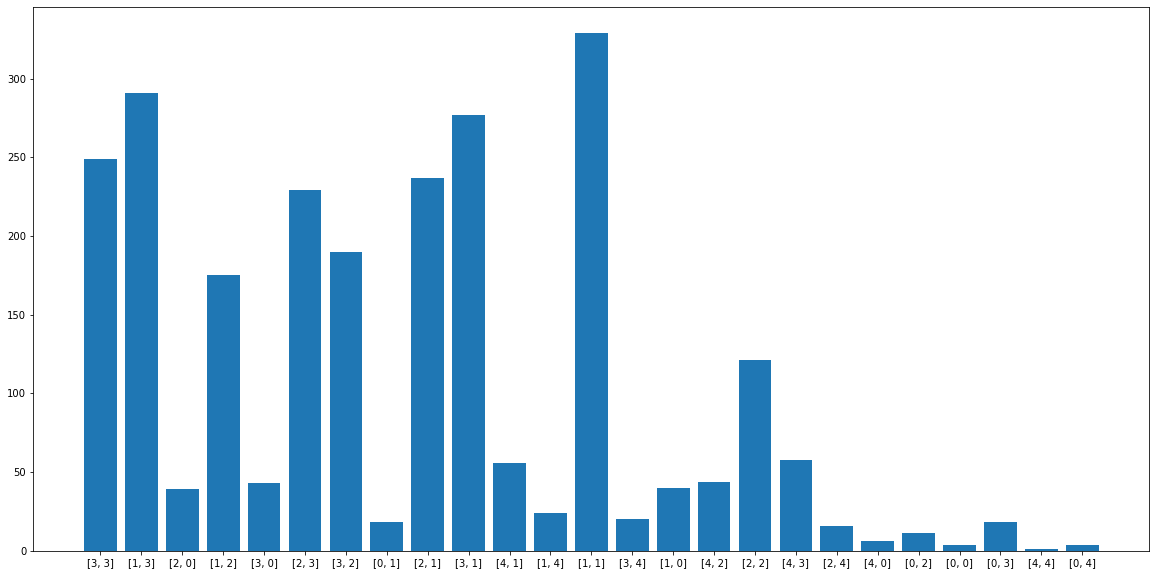

Processing Epoch 64
training start
Iteration 0, d real/fake loss 0.6086006760597229/0.6730140447616577 and g loss is 0.7065386772155762, NDiv loss 0.0851878821849823
Iteration 1, d real/fake loss 0.608559250831604/0.6684024333953857 and g loss is 0.7187885046005249, NDiv loss 0.09250354766845703
Iteration 2, d real/fake loss 0.6085025072097778/0.6708745360374451 and g loss is 0.7231436967849731, NDiv loss 0.09435712546110153
Iteration 3, d real/fake loss 0.6084339022636414/0.6734413504600525 and g loss is 0.7128891944885254, NDiv loss 0.09885513782501221
Iteration 4, d real/fake loss 0.6083633899688721/0.6720462441444397 and g loss is 0.7144525051116943, NDiv loss 0.09287668019533157


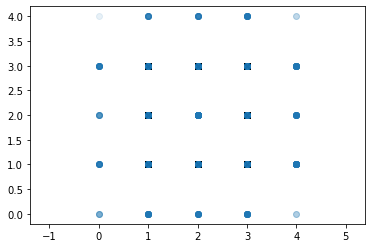

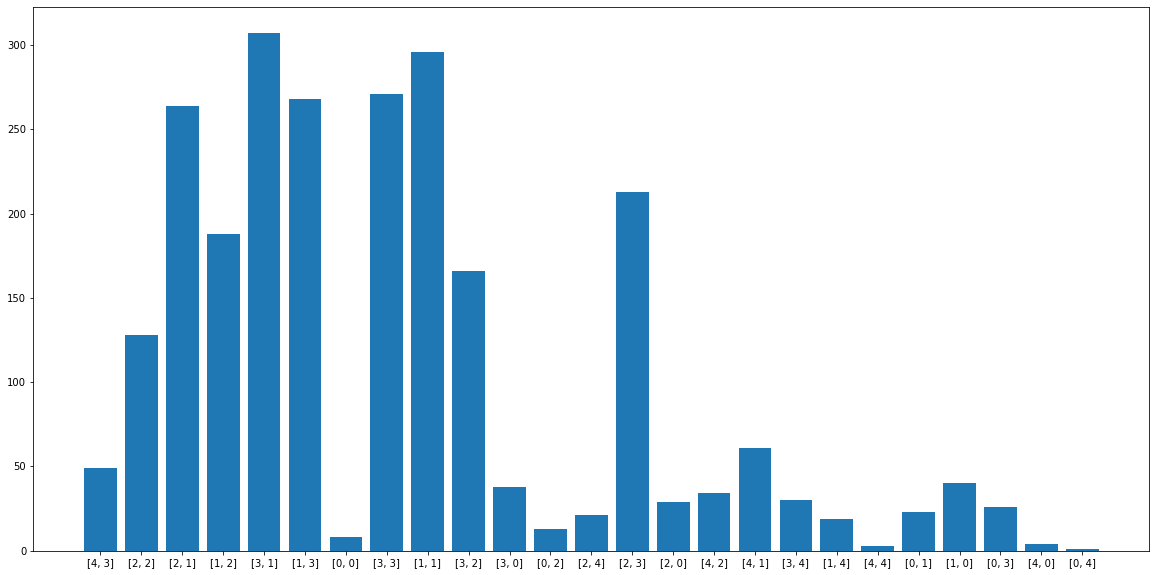

Processing Epoch 65
training start
Iteration 0, d real/fake loss 0.6072217226028442/0.6783576607704163 and g loss is 0.7210003733634949, NDiv loss 0.10312093794345856
Iteration 1, d real/fake loss 0.6071678400039673/0.6843971014022827 and g loss is 0.7110656499862671, NDiv loss 0.09108652919530869
Iteration 2, d real/fake loss 0.6071284413337708/0.6745784878730774 and g loss is 0.7109159231185913, NDiv loss 0.08822143077850342
Iteration 3, d real/fake loss 0.6070893406867981/0.673714280128479 and g loss is 0.7169613838195801, NDiv loss 0.090879887342453
Iteration 4, d real/fake loss 0.6070484519004822/0.6791000962257385 and g loss is 0.7208597660064697, NDiv loss 0.09724939614534378


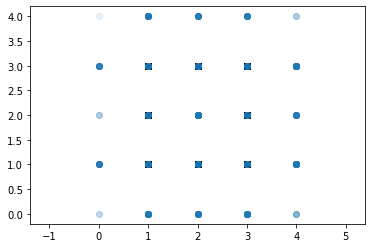

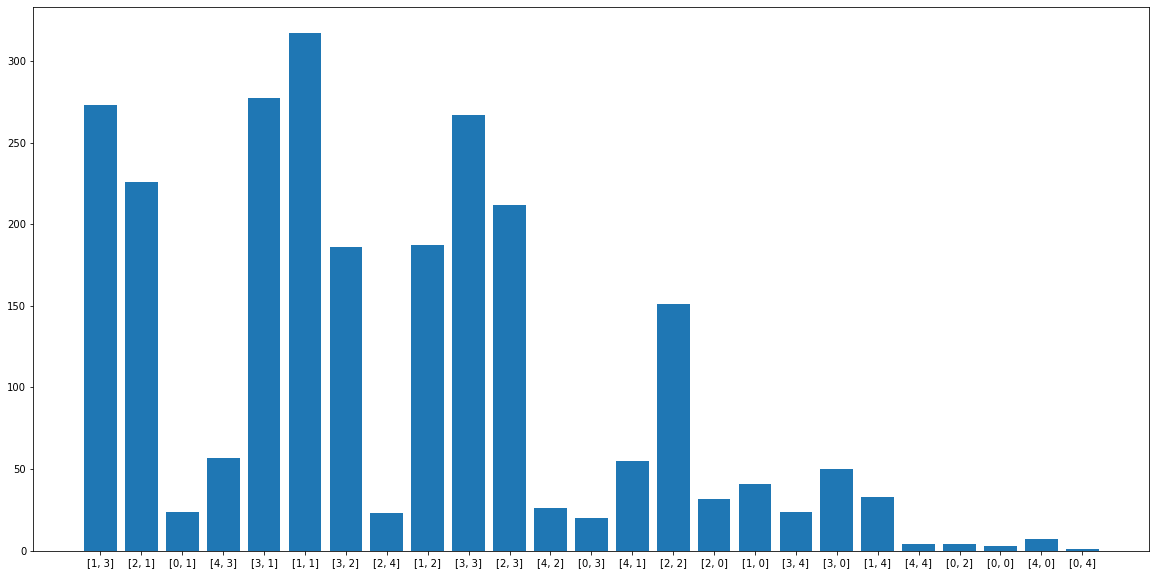

Processing Epoch 66
training start
Iteration 0, d real/fake loss 0.6103963851928711/0.6710548400878906 and g loss is 0.715009331703186, NDiv loss 0.0883001908659935
Iteration 1, d real/fake loss 0.6104145646095276/0.6828722357749939 and g loss is 0.7175304889678955, NDiv loss 0.09678460657596588
Iteration 2, d real/fake loss 0.6104367971420288/0.6736881136894226 and g loss is 0.7084891200065613, NDiv loss 0.09086873382329941
Iteration 3, d real/fake loss 0.6104492545127869/0.6746288537979126 and g loss is 0.7200727462768555, NDiv loss 0.09365858137607574
Iteration 4, d real/fake loss 0.6104553937911987/0.6783437728881836 and g loss is 0.7092623710632324, NDiv loss 0.09705857187509537


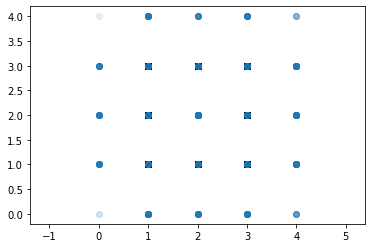

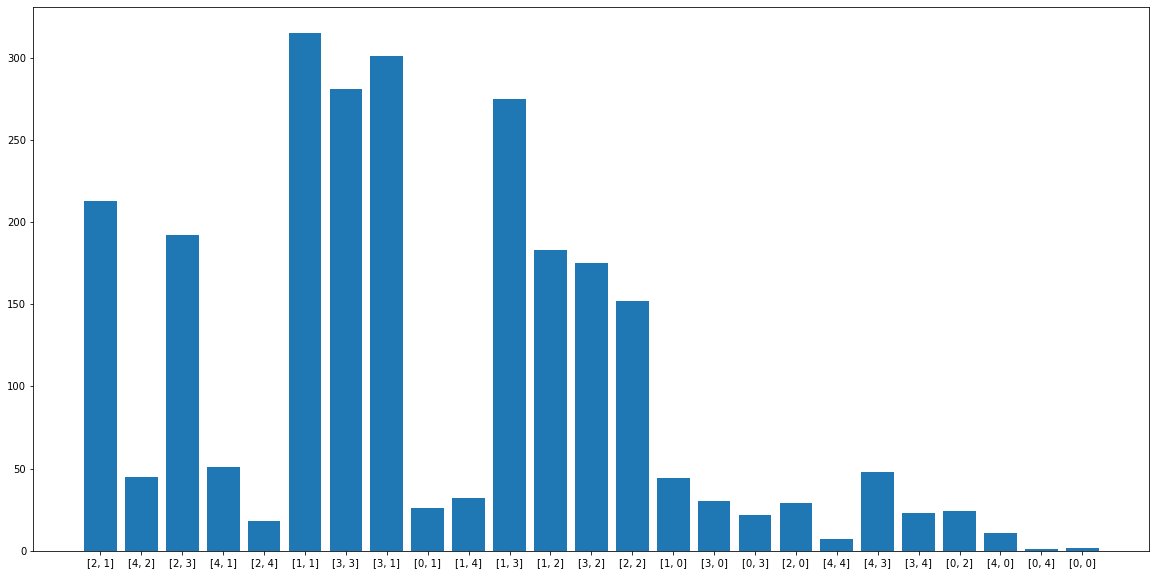

Processing Epoch 67
training start
Iteration 0, d real/fake loss 0.6109112501144409/0.6647047400474548 and g loss is 0.7131103277206421, NDiv loss 0.09029188752174377
Iteration 1, d real/fake loss 0.610899806022644/0.6829858422279358 and g loss is 0.7170745134353638, NDiv loss 0.09132882207632065
Iteration 2, d real/fake loss 0.6108723878860474/0.6777300834655762 and g loss is 0.7147727012634277, NDiv loss 0.09789056330919266
Iteration 3, d real/fake loss 0.6108291745185852/0.6727070808410645 and g loss is 0.7181336879730225, NDiv loss 0.09358210861682892
Iteration 4, d real/fake loss 0.6107774972915649/0.6696306467056274 and g loss is 0.7178484201431274, NDiv loss 0.09290090948343277


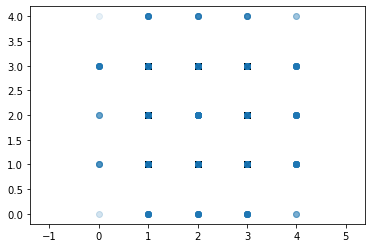

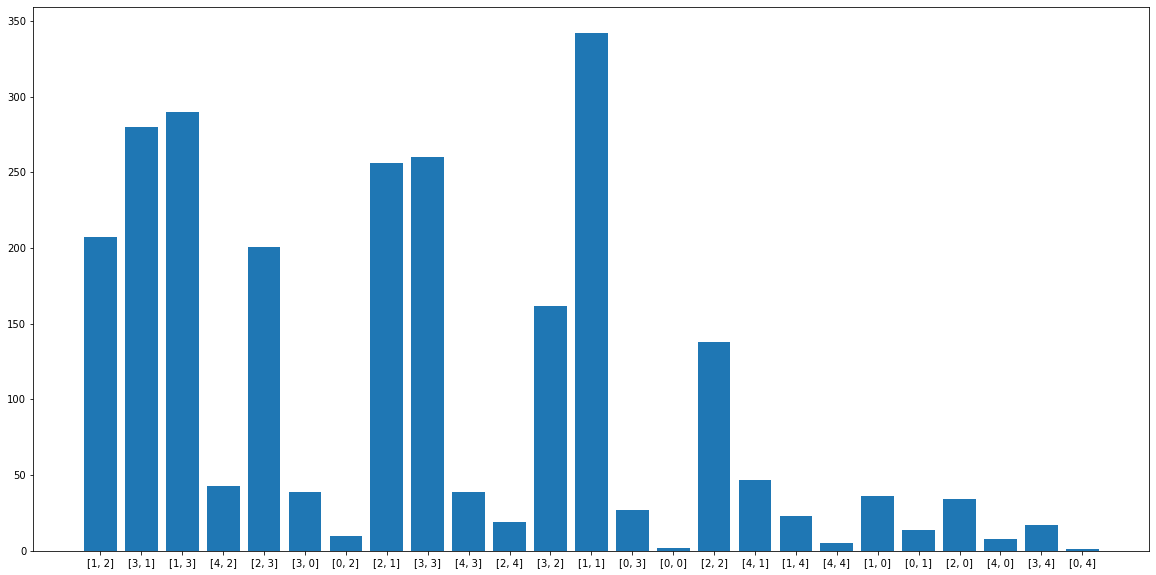

Processing Epoch 68
training start
Iteration 0, d real/fake loss 0.6091117858886719/0.6692258715629578 and g loss is 0.71187824010849, NDiv loss 0.09027871489524841
Iteration 1, d real/fake loss 0.6090325117111206/0.6642478704452515 and g loss is 0.7199360132217407, NDiv loss 0.09495239704847336
Iteration 2, d real/fake loss 0.6089319586753845/0.6749551296234131 and g loss is 0.7190853357315063, NDiv loss 0.09217333793640137
Iteration 3, d real/fake loss 0.6088289022445679/0.6749869585037231 and g loss is 0.71324622631073, NDiv loss 0.08155243843793869
Iteration 4, d real/fake loss 0.6087232232093811/0.6732437610626221 and g loss is 0.7217822074890137, NDiv loss 0.1034703180193901


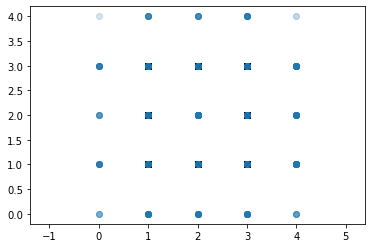

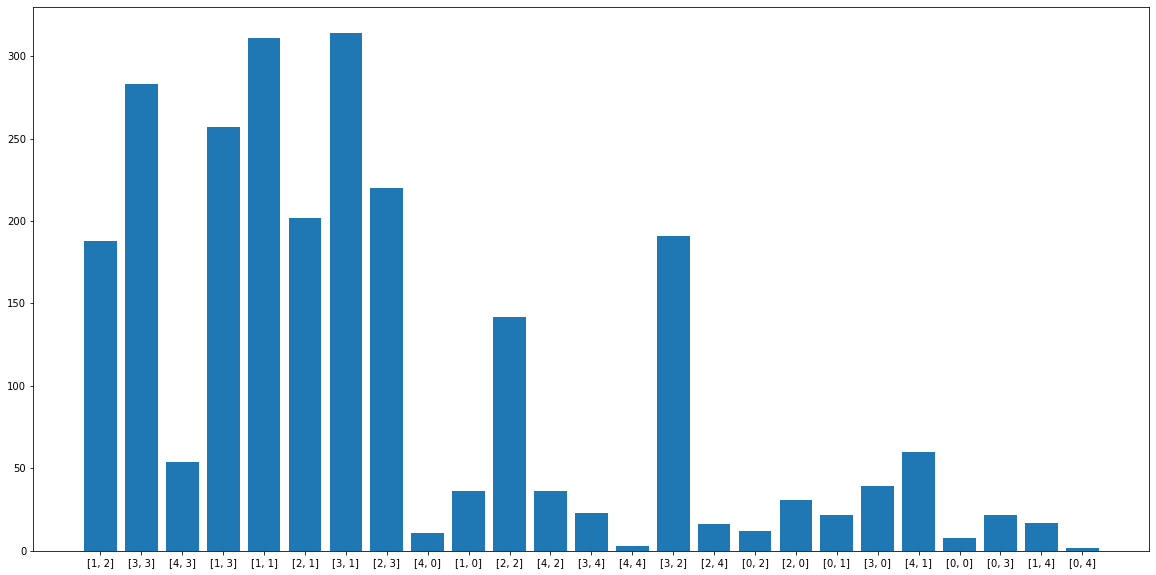

Processing Epoch 69
training start
Iteration 0, d real/fake loss 0.6083487868309021/0.6738541126251221 and g loss is 0.7175942659378052, NDiv loss 0.10322403907775879
Iteration 1, d real/fake loss 0.6082855463027954/0.6753219366073608 and g loss is 0.713676929473877, NDiv loss 0.0966339260339737
Iteration 2, d real/fake loss 0.6082320213317871/0.6681926250457764 and g loss is 0.7109605073928833, NDiv loss 0.09566700458526611
Iteration 3, d real/fake loss 0.6081731915473938/0.668154239654541 and g loss is 0.7108778357505798, NDiv loss 0.0978265032172203
Iteration 4, d real/fake loss 0.6081101894378662/0.6681318283081055 and g loss is 0.7131052017211914, NDiv loss 0.09014841914176941


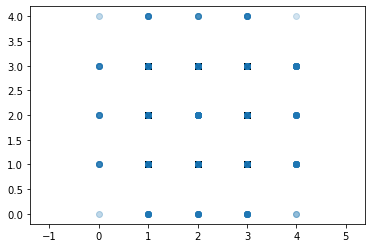

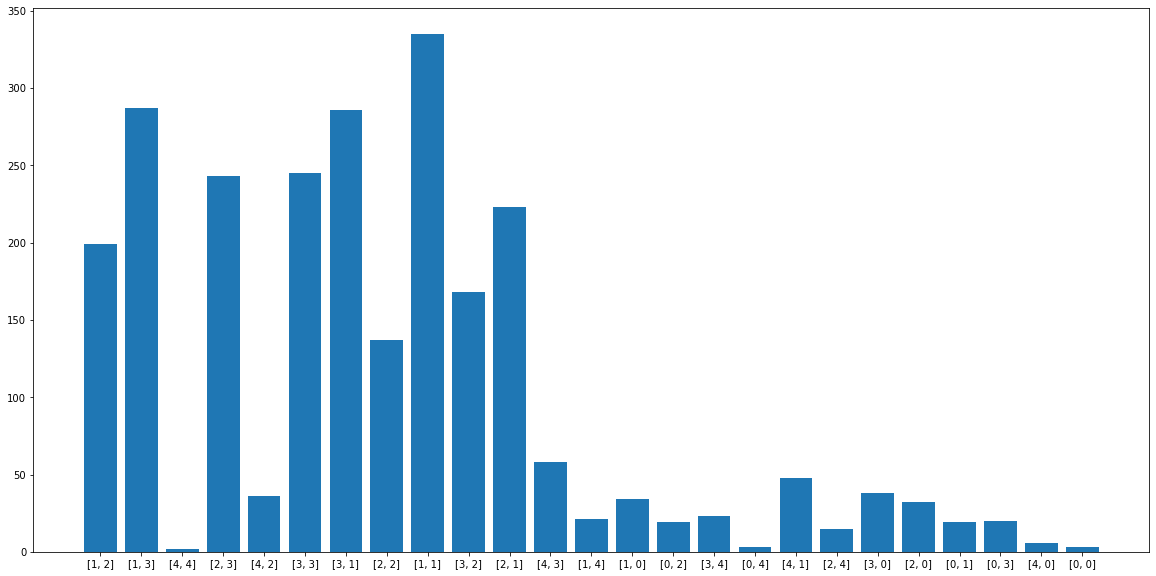

Processing Epoch 70
training start
Iteration 0, d real/fake loss 0.6095411777496338/0.6745619773864746 and g loss is 0.7091259956359863, NDiv loss 0.09739856421947479
Iteration 1, d real/fake loss 0.609488308429718/0.6717046499252319 and g loss is 0.7135146260261536, NDiv loss 0.09568723291158676
Iteration 2, d real/fake loss 0.6094386577606201/0.6664472818374634 and g loss is 0.7191793918609619, NDiv loss 0.10228315740823746
Iteration 3, d real/fake loss 0.6093672513961792/0.6646996140480042 and g loss is 0.7156559228897095, NDiv loss 0.10081382095813751
Iteration 4, d real/fake loss 0.6092751622200012/0.6741276979446411 and g loss is 0.7136377096176147, NDiv loss 0.09046725928783417


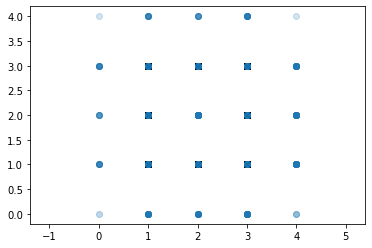

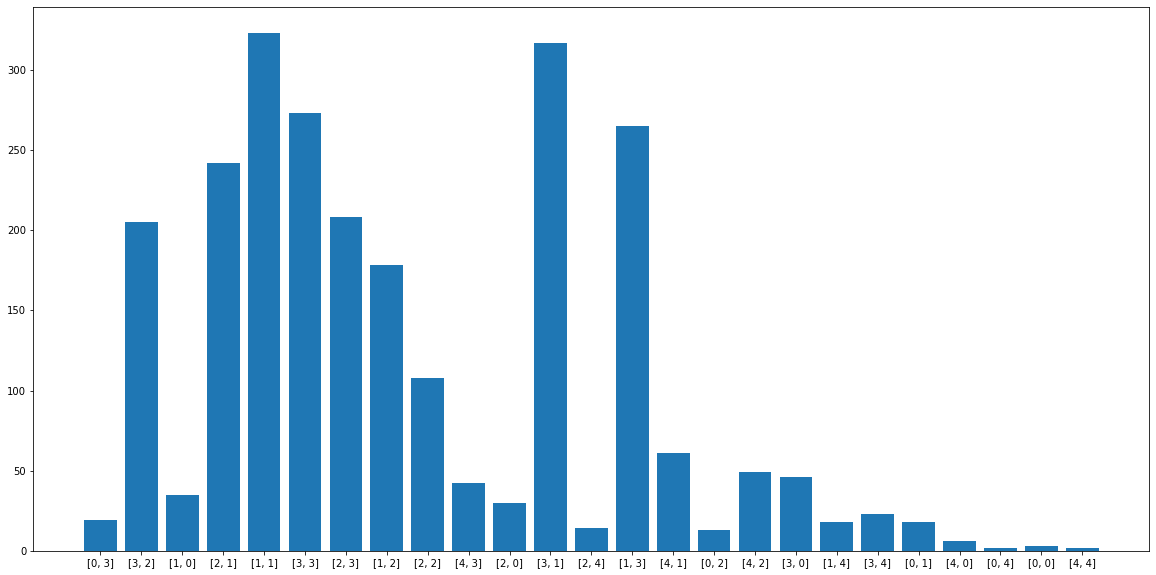

Processing Epoch 71
training start
Iteration 0, d real/fake loss 0.6090855598449707/0.6796243190765381 and g loss is 0.7226037383079529, NDiv loss 0.09009474515914917
Iteration 1, d real/fake loss 0.6090108752250671/0.6721053123474121 and g loss is 0.7206541299819946, NDiv loss 0.09874588996171951
Iteration 2, d real/fake loss 0.6089328527450562/0.6739472150802612 and g loss is 0.7118276953697205, NDiv loss 0.09449367970228195
Iteration 3, d real/fake loss 0.6088606715202332/0.6761528253555298 and g loss is 0.7113578915596008, NDiv loss 0.09616299718618393
Iteration 4, d real/fake loss 0.6087980270385742/0.6744268536567688 and g loss is 0.7195672988891602, NDiv loss 0.0904877558350563


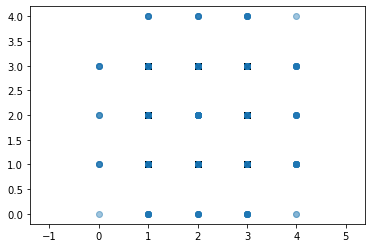

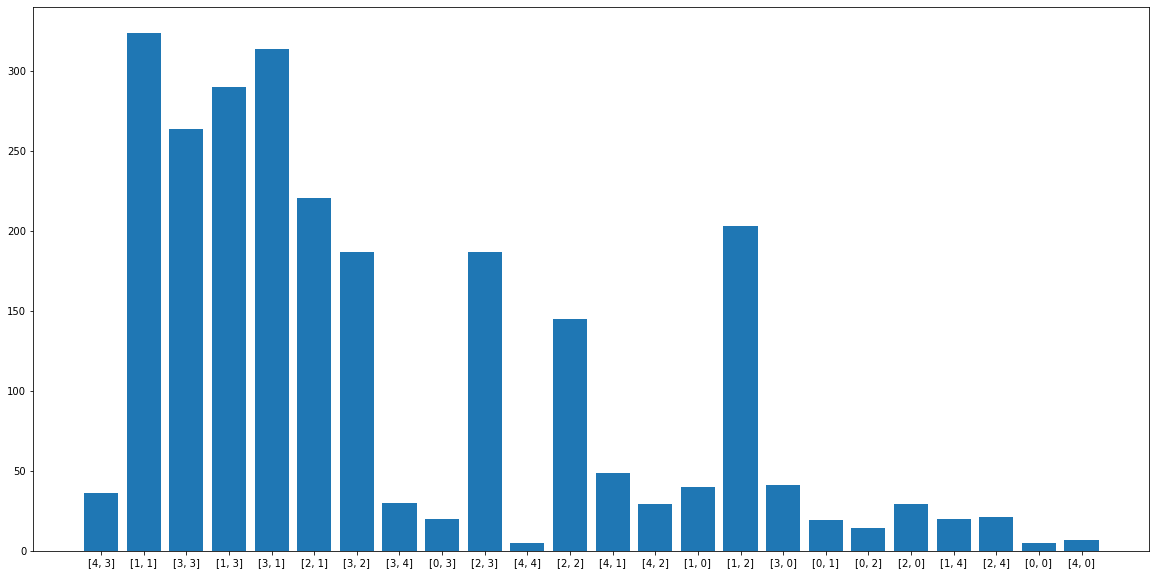

Processing Epoch 72
training start
Iteration 0, d real/fake loss 0.6085637807846069/0.6678287982940674 and g loss is 0.7173049449920654, NDiv loss 0.09965211898088455
Iteration 1, d real/fake loss 0.6084913015365601/0.6733488440513611 and g loss is 0.7201383113861084, NDiv loss 0.09462365508079529
Iteration 2, d real/fake loss 0.6084195971488953/0.6745021939277649 and g loss is 0.7159337401390076, NDiv loss 0.09616544842720032
Iteration 3, d real/fake loss 0.608345627784729/0.6726487874984741 and g loss is 0.71944260597229, NDiv loss 0.09672746062278748
Iteration 4, d real/fake loss 0.6082719564437866/0.6662812232971191 and g loss is 0.7168802618980408, NDiv loss 0.097236767411232


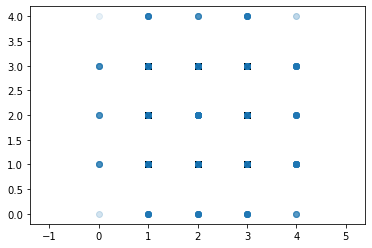

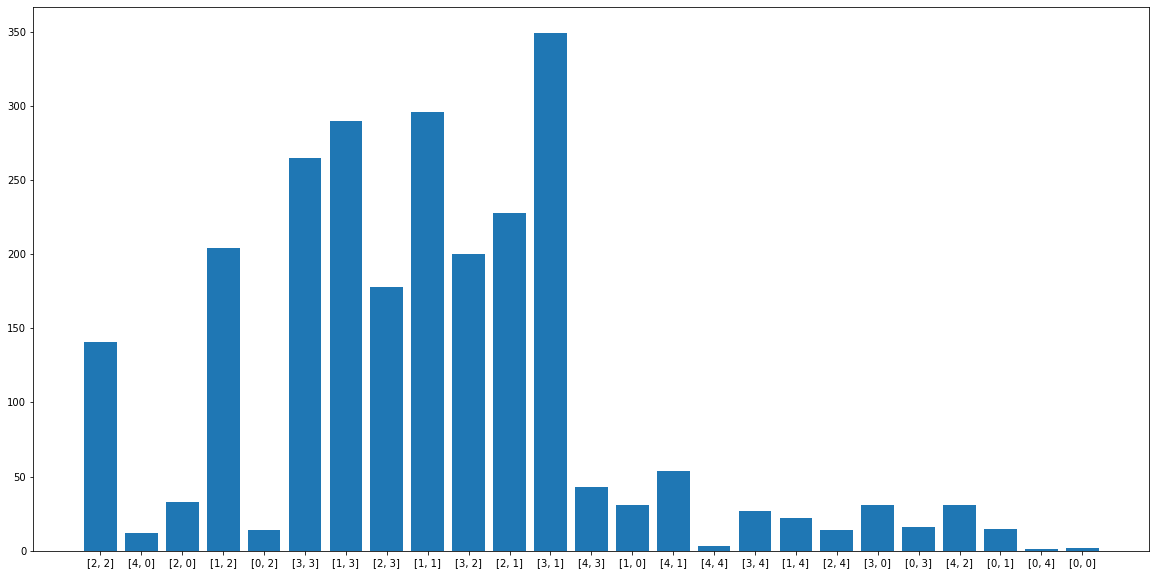

Processing Epoch 73
training start
Iteration 0, d real/fake loss 0.6067203879356384/0.6675578951835632 and g loss is 0.7144124507904053, NDiv loss 0.0954771563410759
Iteration 1, d real/fake loss 0.6066617965698242/0.6740578413009644 and g loss is 0.7264386415481567, NDiv loss 0.09637652337551117
Iteration 2, d real/fake loss 0.6066073179244995/0.6718930006027222 and g loss is 0.7174344062805176, NDiv loss 0.09808032959699631
Iteration 3, d real/fake loss 0.6065531373023987/0.6687847375869751 and g loss is 0.7163445949554443, NDiv loss 0.09674695879220963
Iteration 4, d real/fake loss 0.606500506401062/0.6657925844192505 and g loss is 0.7185242772102356, NDiv loss 0.09598346054553986


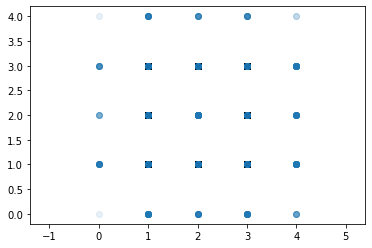

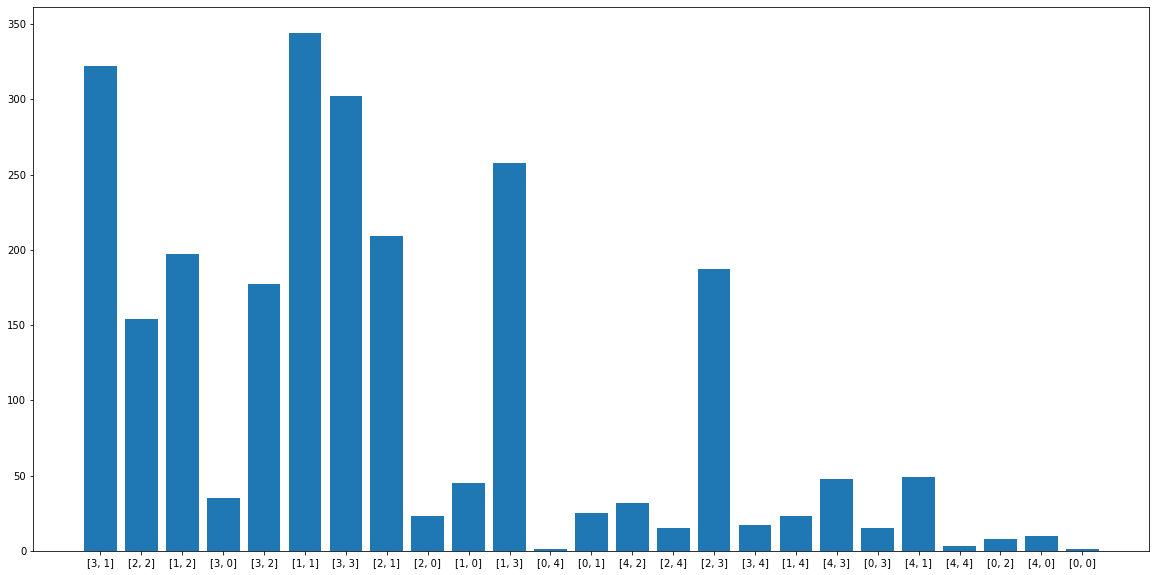

Processing Epoch 74
training start
Iteration 0, d real/fake loss 0.6080334782600403/0.6735487580299377 and g loss is 0.7269378304481506, NDiv loss 0.09880721569061279
Iteration 1, d real/fake loss 0.6080235242843628/0.6643656492233276 and g loss is 0.7126283049583435, NDiv loss 0.09553221613168716
Iteration 2, d real/fake loss 0.6080029010772705/0.675754189491272 and g loss is 0.7247012853622437, NDiv loss 0.0990247055888176
Iteration 3, d real/fake loss 0.6079800724983215/0.6819027066230774 and g loss is 0.7155865430831909, NDiv loss 0.0992787703871727
Iteration 4, d real/fake loss 0.6079580783843994/0.6674178838729858 and g loss is 0.7219751477241516, NDiv loss 0.09442616254091263


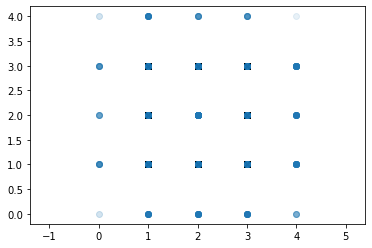

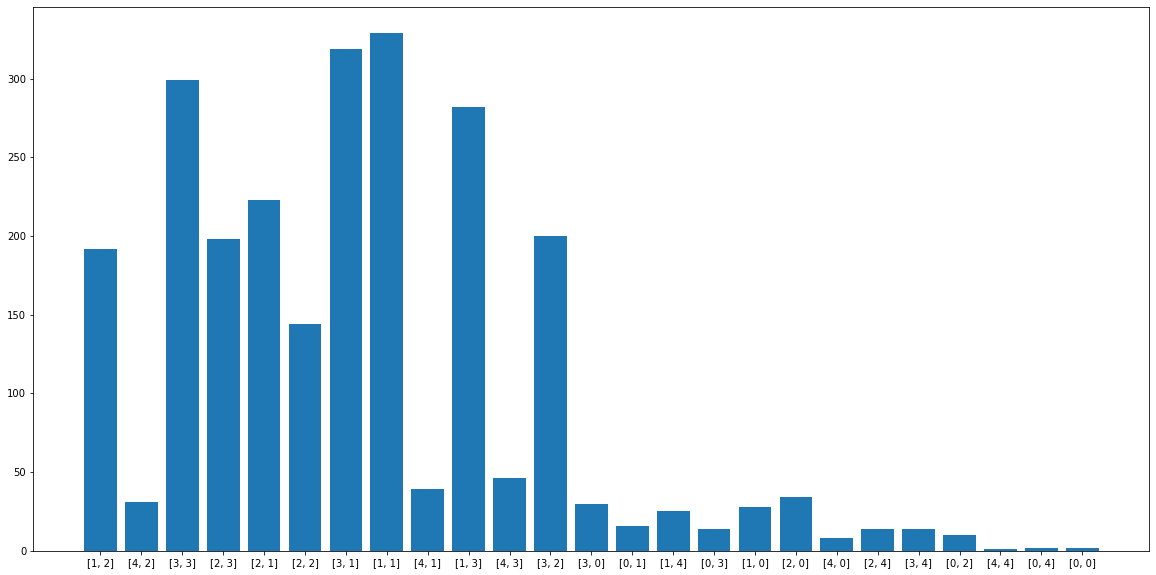

Processing Epoch 75
training start
Iteration 0, d real/fake loss 0.6065635681152344/0.6690970063209534 and g loss is 0.7133579850196838, NDiv loss 0.10130205750465393
Iteration 1, d real/fake loss 0.60651695728302/0.6768055558204651 and g loss is 0.7161870002746582, NDiv loss 0.10317067056894302
Iteration 2, d real/fake loss 0.6064707040786743/0.6728997826576233 and g loss is 0.7229063510894775, NDiv loss 0.1085326299071312
Iteration 3, d real/fake loss 0.6064257621765137/0.6738009452819824 and g loss is 0.7234086394309998, NDiv loss 0.10053307563066483
Iteration 4, d real/fake loss 0.6063899993896484/0.6761093139648438 and g loss is 0.7191809415817261, NDiv loss 0.1048755869269371


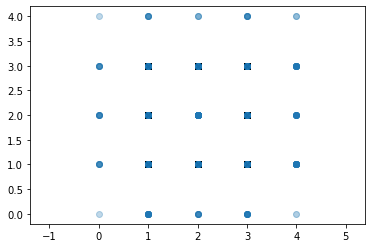

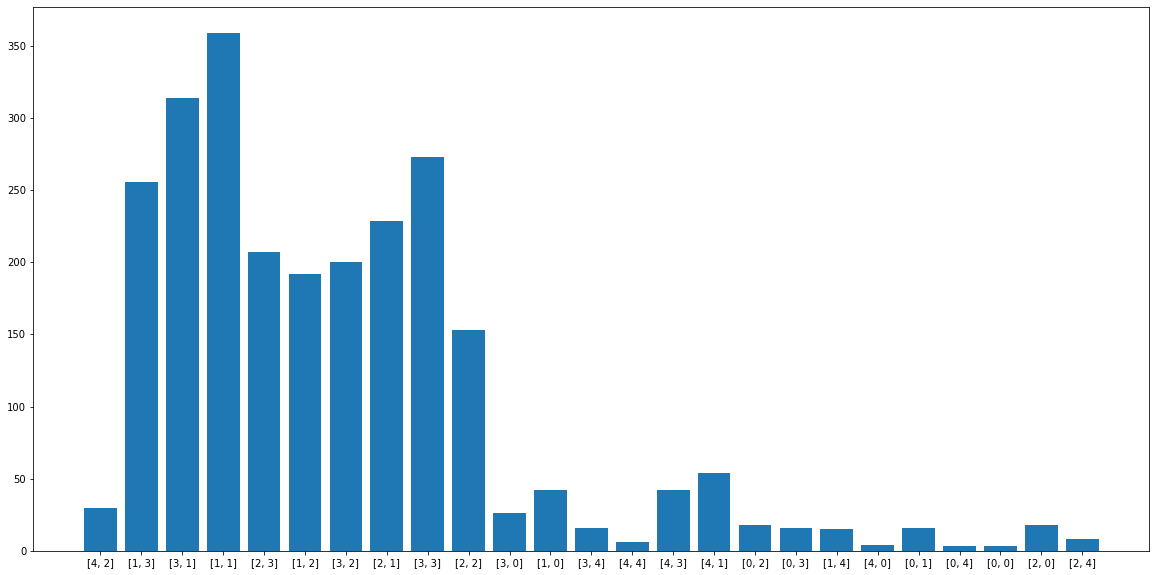

Processing Epoch 76
training start
Iteration 0, d real/fake loss 0.6063732504844666/0.677225649356842 and g loss is 0.7178293466567993, NDiv loss 0.0998443141579628
Iteration 1, d real/fake loss 0.6063787341117859/0.671836256980896 and g loss is 0.7163122892379761, NDiv loss 0.093816377222538
Iteration 2, d real/fake loss 0.6063794493675232/0.6743077635765076 and g loss is 0.722058892250061, NDiv loss 0.1031661108136177
Iteration 3, d real/fake loss 0.6063814163208008/0.6730433106422424 and g loss is 0.7090340852737427, NDiv loss 0.09638359397649765
Iteration 4, d real/fake loss 0.6063845753669739/0.6649068593978882 and g loss is 0.7224602699279785, NDiv loss 0.10194606333971024


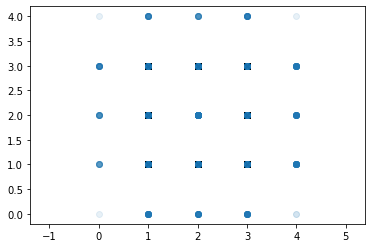

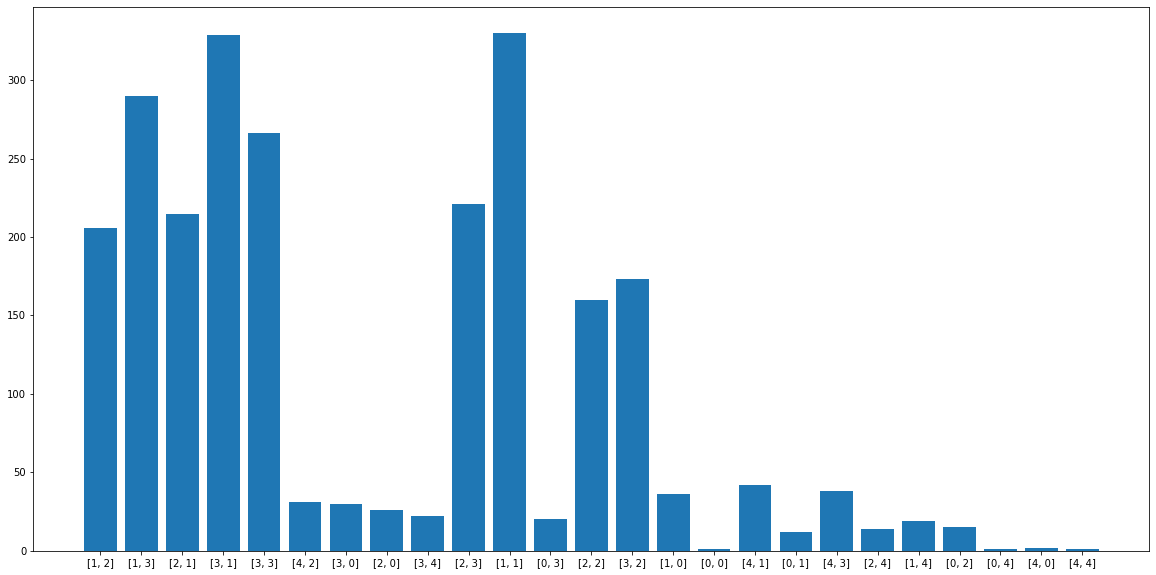

Processing Epoch 77
training start
Iteration 0, d real/fake loss 0.60587477684021/0.6682971715927124 and g loss is 0.7235900163650513, NDiv loss 0.11007510870695114
Iteration 1, d real/fake loss 0.6058926582336426/0.6655367612838745 and g loss is 0.7179504036903381, NDiv loss 0.09828216582536697
Iteration 2, d real/fake loss 0.6058987379074097/0.6723676919937134 and g loss is 0.7274893522262573, NDiv loss 0.09640524536371231
Iteration 3, d real/fake loss 0.605902373790741/0.6746813058853149 and g loss is 0.721695065498352, NDiv loss 0.10306701809167862
Iteration 4, d real/fake loss 0.6059086322784424/0.6689367294311523 and g loss is 0.7199522256851196, NDiv loss 0.09103398025035858


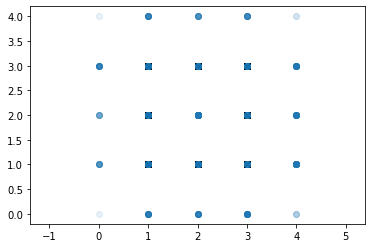

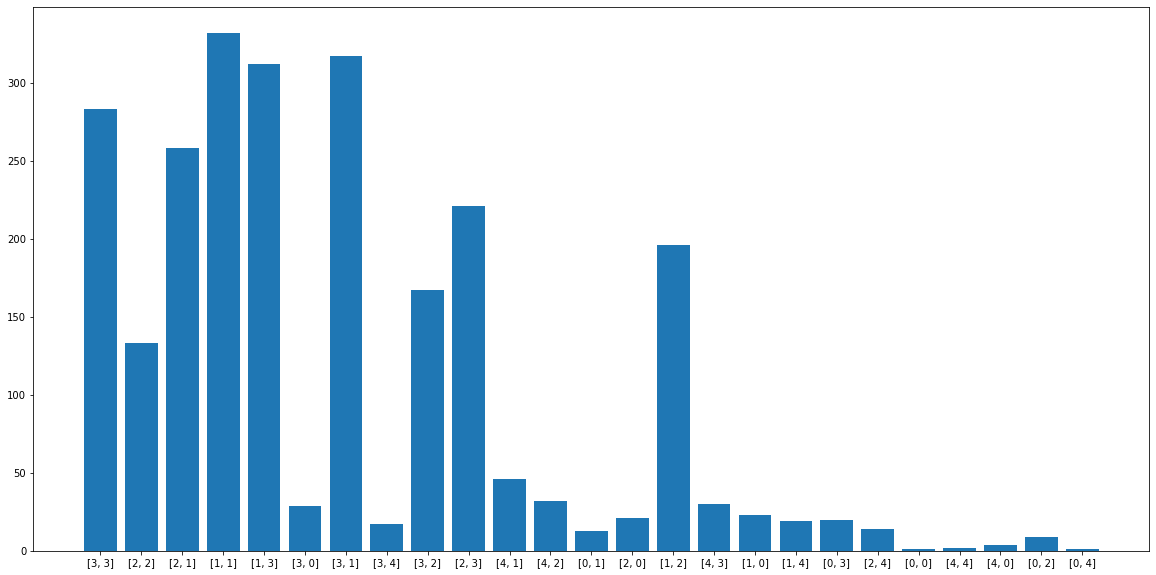

Processing Epoch 78
training start
Iteration 0, d real/fake loss 0.60863196849823/0.6633418798446655 and g loss is 0.7151937484741211, NDiv loss 0.10596998780965805
Iteration 1, d real/fake loss 0.6086589694023132/0.6719352006912231 and g loss is 0.7233901023864746, NDiv loss 0.10107291489839554
Iteration 2, d real/fake loss 0.6086689233779907/0.6742101907730103 and g loss is 0.7169004678726196, NDiv loss 0.10557802766561508
Iteration 3, d real/fake loss 0.6086642742156982/0.6719855070114136 and g loss is 0.7224878072738647, NDiv loss 0.10472653806209564
Iteration 4, d real/fake loss 0.6086534261703491/0.6782782077789307 and g loss is 0.7166277766227722, NDiv loss 0.09868811815977097


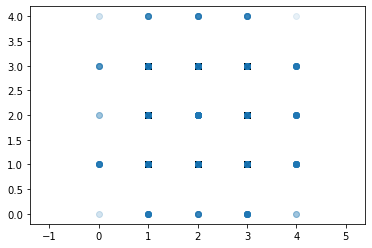

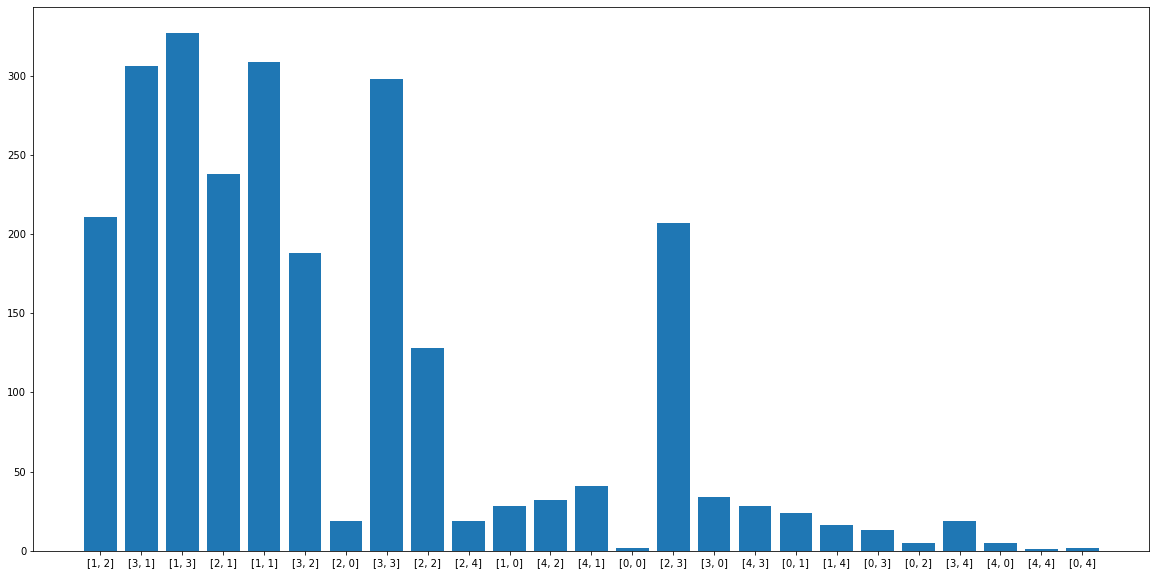

Processing Epoch 79
training start
Iteration 0, d real/fake loss 0.6087304353713989/0.6701551079750061 and g loss is 0.7186421751976013, NDiv loss 0.09258785843849182
Iteration 1, d real/fake loss 0.6087313294410706/0.6670475602149963 and g loss is 0.7266343235969543, NDiv loss 0.09681655466556549
Iteration 2, d real/fake loss 0.6087180376052856/0.6624548435211182 and g loss is 0.7252985835075378, NDiv loss 0.09716247022151947
Iteration 3, d real/fake loss 0.6086902618408203/0.6784448623657227 and g loss is 0.7175894975662231, NDiv loss 0.09843028336763382
Iteration 4, d real/fake loss 0.608666181564331/0.6731216907501221 and g loss is 0.7197558879852295, NDiv loss 0.09968291968107224


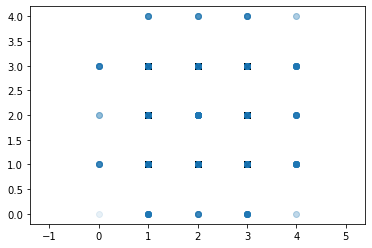

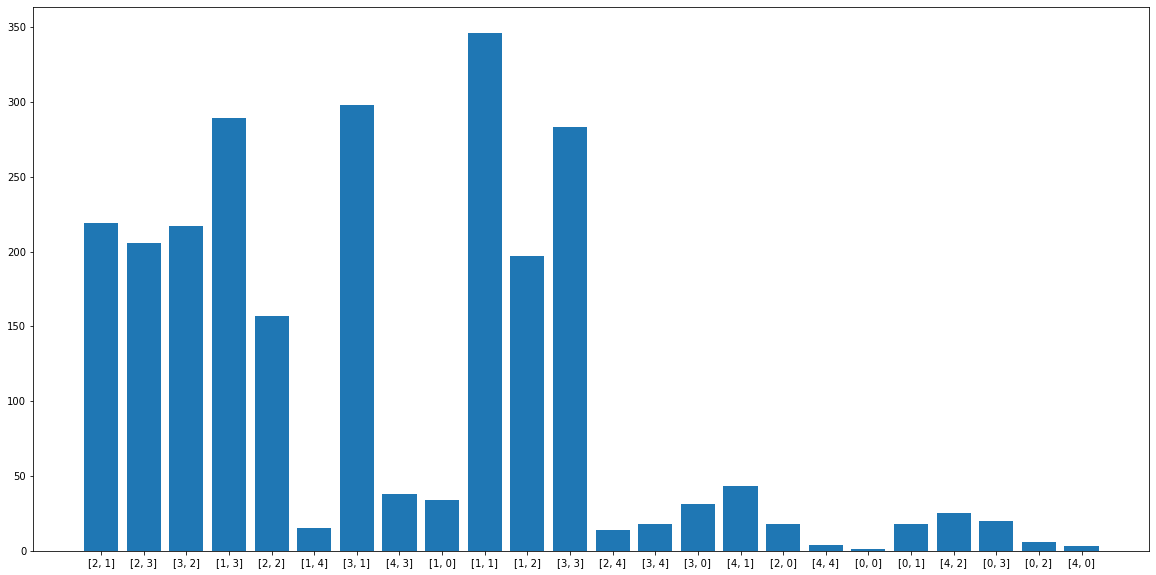

Processing Epoch 80
training start
Iteration 0, d real/fake loss 0.6096396446228027/0.6665555834770203 and g loss is 0.7232434749603271, NDiv loss 0.10233994573354721
Iteration 1, d real/fake loss 0.6096130013465881/0.6649723052978516 and g loss is 0.7190262079238892, NDiv loss 0.09695478528738022
Iteration 2, d real/fake loss 0.6095709204673767/0.673188328742981 and g loss is 0.7147530317306519, NDiv loss 0.0977126806974411
Iteration 3, d real/fake loss 0.6095201969146729/0.6706539392471313 and g loss is 0.7169914245605469, NDiv loss 0.10352978855371475
Iteration 4, d real/fake loss 0.6094592809677124/0.6645254492759705 and g loss is 0.7156898379325867, NDiv loss 0.09822705388069153


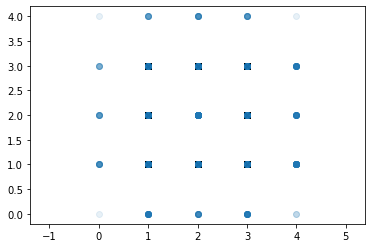

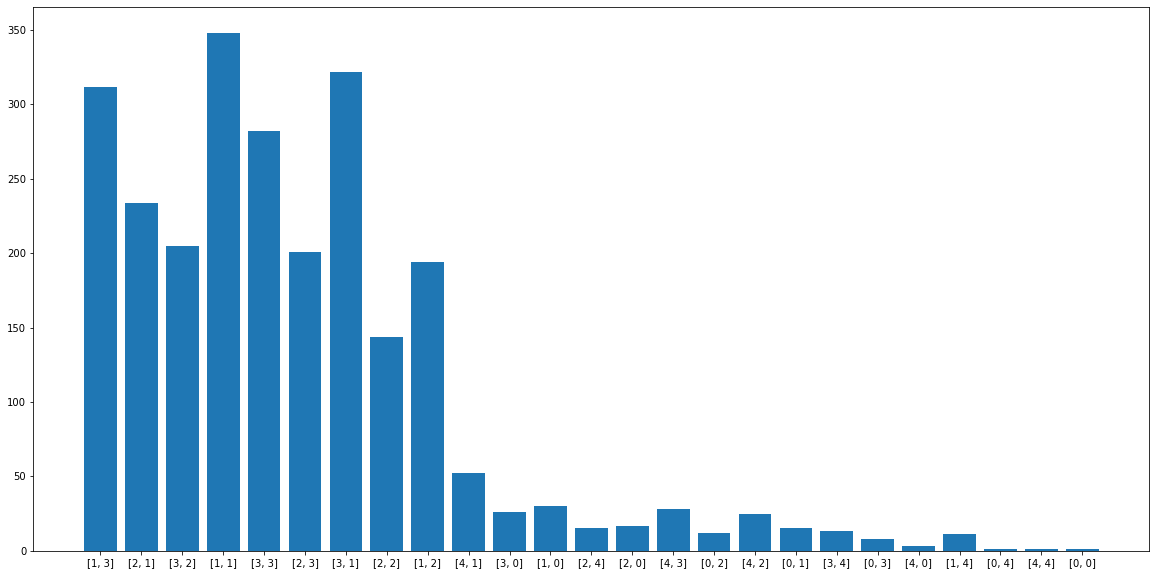

Processing Epoch 81
training start
Iteration 0, d real/fake loss 0.6060572862625122/0.6730626225471497 and g loss is 0.7214958667755127, NDiv loss 0.09647126495838165
Iteration 1, d real/fake loss 0.6060205698013306/0.668907880783081 and g loss is 0.7224276661872864, NDiv loss 0.1007126122713089
Iteration 2, d real/fake loss 0.6059879064559937/0.6657620668411255 and g loss is 0.719907283782959, NDiv loss 0.09522514790296555
Iteration 3, d real/fake loss 0.6059514284133911/0.6697613000869751 and g loss is 0.7226571440696716, NDiv loss 0.10001704096794128
Iteration 4, d real/fake loss 0.6059204339981079/0.6663296222686768 and g loss is 0.7152116894721985, NDiv loss 0.09786812961101532


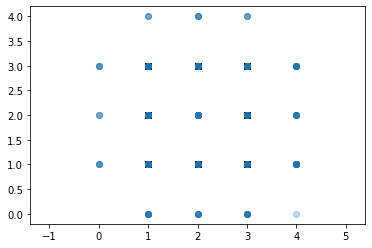

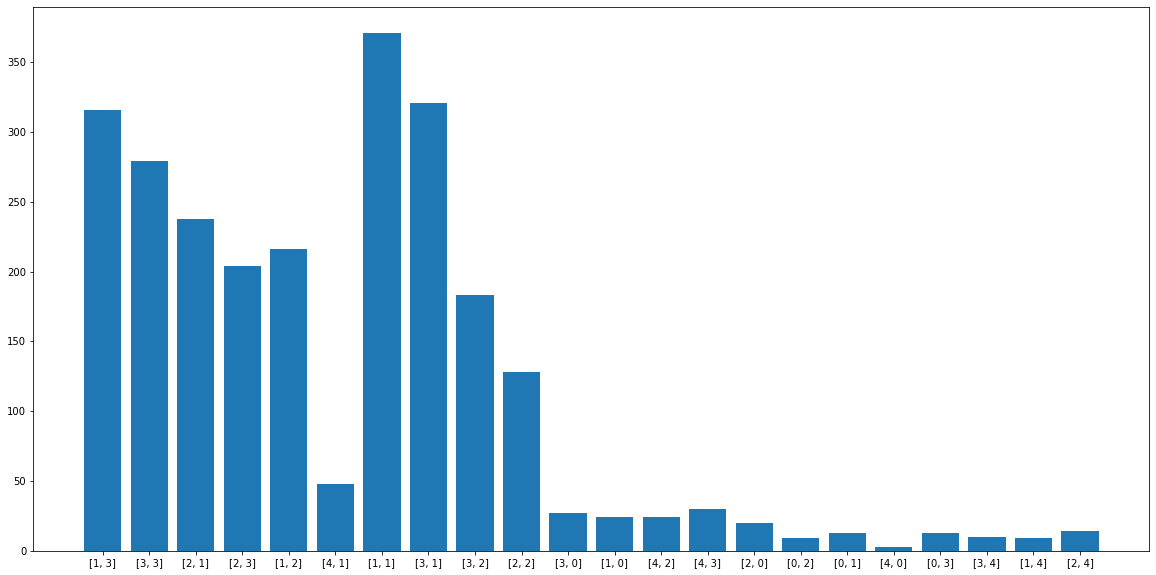

Processing Epoch 82
training start
Iteration 0, d real/fake loss 0.6071674227714539/0.6639590859413147 and g loss is 0.7184716463088989, NDiv loss 0.09478775411844254
Iteration 1, d real/fake loss 0.6071362495422363/0.6697019338607788 and g loss is 0.7243912220001221, NDiv loss 0.09823682904243469
Iteration 2, d real/fake loss 0.6071130633354187/0.6629108190536499 and g loss is 0.7252311706542969, NDiv loss 0.09650655090808868
Iteration 3, d real/fake loss 0.6070717573165894/0.6725378036499023 and g loss is 0.7212257981300354, NDiv loss 0.10388369113206863
Iteration 4, d real/fake loss 0.6070312261581421/0.6687242388725281 and g loss is 0.7221935987472534, NDiv loss 0.10724663734436035


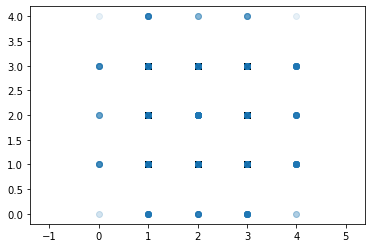

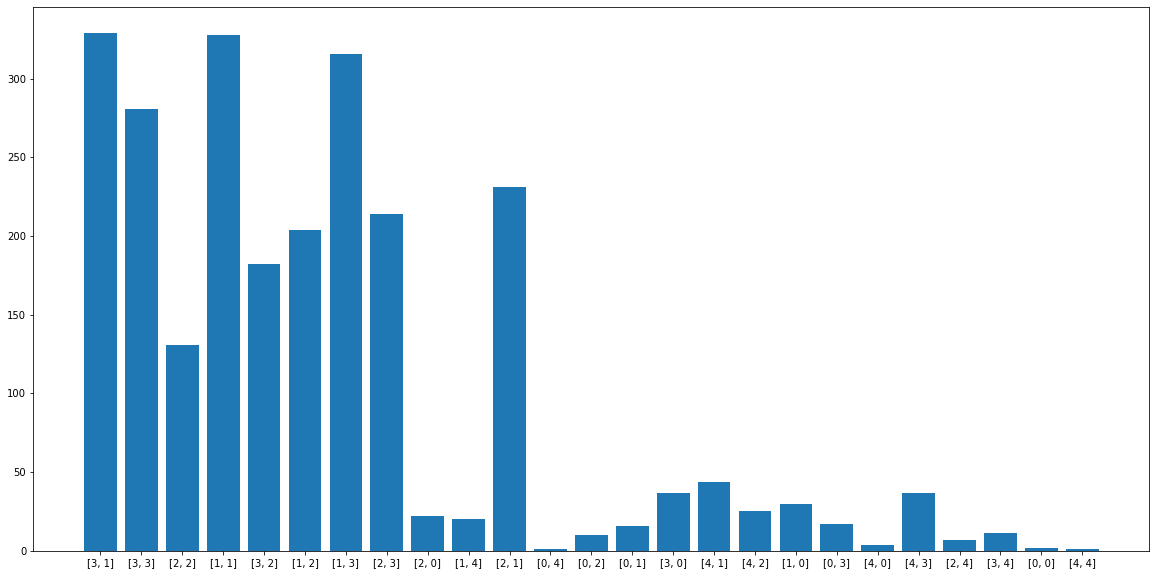

Processing Epoch 83
training start
Iteration 0, d real/fake loss 0.6059339642524719/0.6642398834228516 and g loss is 0.7268664240837097, NDiv loss 0.09574056416749954
Iteration 1, d real/fake loss 0.6059118509292603/0.6681389212608337 and g loss is 0.7196886539459229, NDiv loss 0.09979583323001862
Iteration 2, d real/fake loss 0.6058723330497742/0.6741149425506592 and g loss is 0.7281724214553833, NDiv loss 0.10210924595594406
Iteration 3, d real/fake loss 0.6058200001716614/0.6647382974624634 and g loss is 0.7208746671676636, NDiv loss 0.09346161782741547
Iteration 4, d real/fake loss 0.6057566404342651/0.6687930226325989 and g loss is 0.7169251441955566, NDiv loss 0.10156380385160446


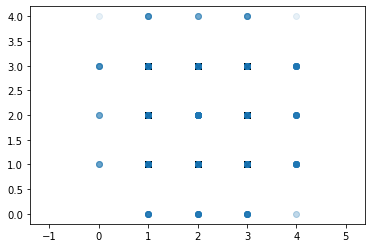

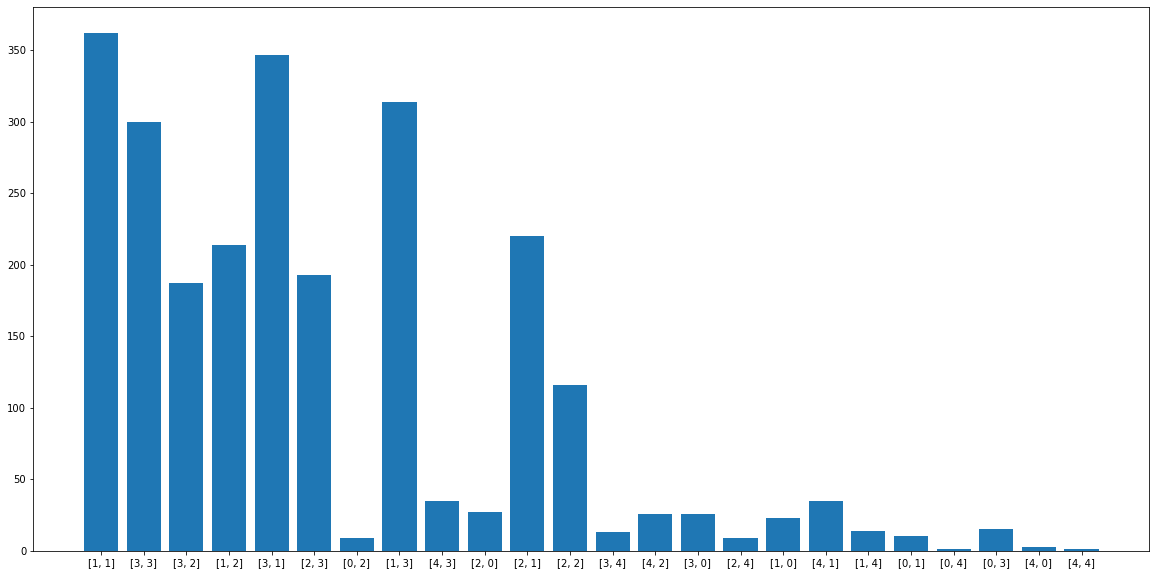

Processing Epoch 84
training start
Iteration 0, d real/fake loss 0.6058655977249146/0.6714555025100708 and g loss is 0.7174988985061646, NDiv loss 0.10291539877653122
Iteration 1, d real/fake loss 0.605836808681488/0.672014057636261 and g loss is 0.7200959920883179, NDiv loss 0.09777660667896271
Iteration 2, d real/fake loss 0.6058157682418823/0.6590707898139954 and g loss is 0.7271149158477783, NDiv loss 0.09955789148807526
Iteration 3, d real/fake loss 0.6057823896408081/0.6600856781005859 and g loss is 0.7282372713088989, NDiv loss 0.10176555812358856
Iteration 4, d real/fake loss 0.6057459115982056/0.6566378474235535 and g loss is 0.7216006517410278, NDiv loss 0.09933644533157349


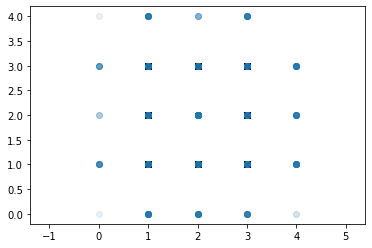

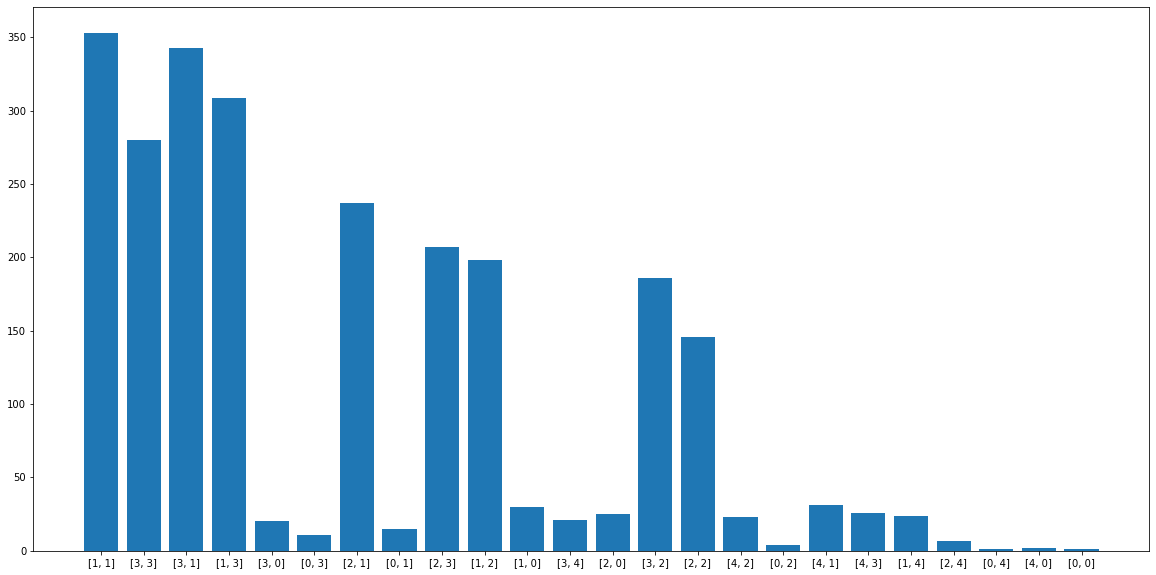

Processing Epoch 85
training start
Iteration 0, d real/fake loss 0.6067613363265991/0.6695977449417114 and g loss is 0.7275090217590332, NDiv loss 0.09757063537836075
Iteration 1, d real/fake loss 0.6067357063293457/0.6664173603057861 and g loss is 0.7183722853660583, NDiv loss 0.10451795905828476
Iteration 2, d real/fake loss 0.6067023277282715/0.6596067547798157 and g loss is 0.7228055000305176, NDiv loss 0.10336869955062866
Iteration 3, d real/fake loss 0.6066605448722839/0.6653048992156982 and g loss is 0.7272001504898071, NDiv loss 0.09675683081150055
Iteration 4, d real/fake loss 0.6066151261329651/0.6642639636993408 and g loss is 0.7269229888916016, NDiv loss 0.10450876504182816


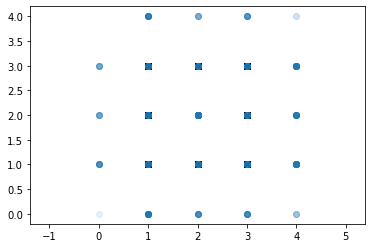

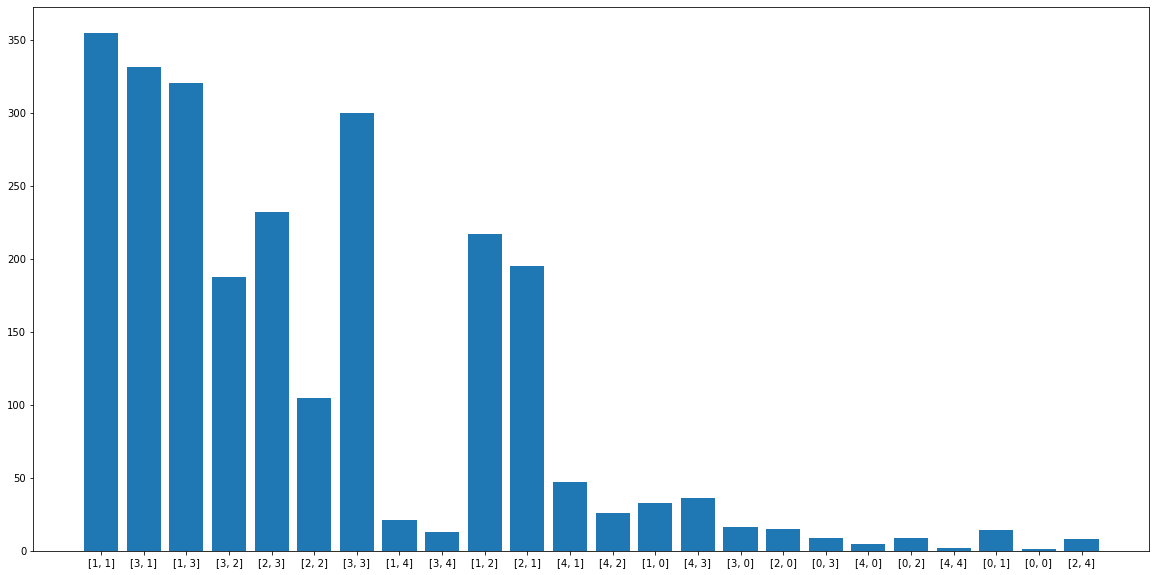

Processing Epoch 86
training start
Iteration 0, d real/fake loss 0.6064684391021729/0.670046329498291 and g loss is 0.7197057008743286, NDiv loss 0.1007232517004013
Iteration 1, d real/fake loss 0.6064151525497437/0.663928747177124 and g loss is 0.7253647446632385, NDiv loss 0.10598444193601608
Iteration 2, d real/fake loss 0.6063518524169922/0.6714218854904175 and g loss is 0.728500247001648, NDiv loss 0.10180944204330444
Iteration 3, d real/fake loss 0.6062912344932556/0.6586549282073975 and g loss is 0.7237903475761414, NDiv loss 0.09995488077402115
Iteration 4, d real/fake loss 0.6062213778495789/0.6637266874313354 and g loss is 0.7261990904808044, NDiv loss 0.10122178494930267


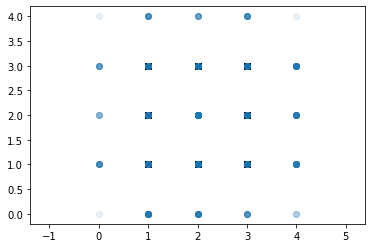

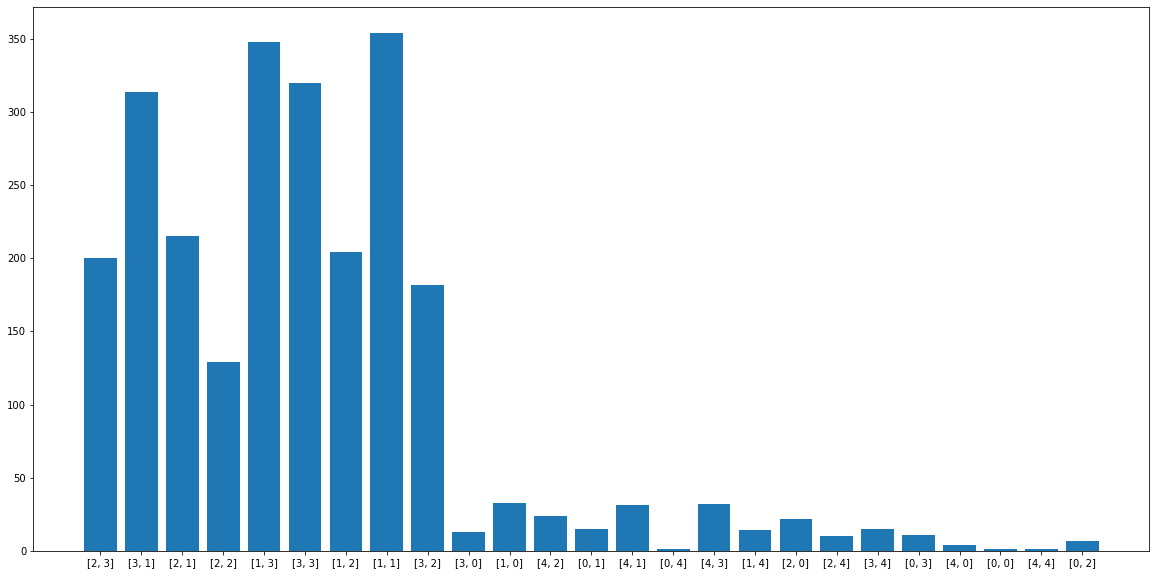

Processing Epoch 87
training start
Iteration 0, d real/fake loss 0.6051050424575806/0.6671065092086792 and g loss is 0.7220242023468018, NDiv loss 0.10642547905445099
Iteration 1, d real/fake loss 0.6050698757171631/0.6693041324615479 and g loss is 0.7191835641860962, NDiv loss 0.10896392166614532
Iteration 2, d real/fake loss 0.6050416231155396/0.6713148355484009 and g loss is 0.7175071239471436, NDiv loss 0.1042349562048912
Iteration 3, d real/fake loss 0.6050212979316711/0.6595627665519714 and g loss is 0.7214070558547974, NDiv loss 0.10042110085487366
Iteration 4, d real/fake loss 0.6049931049346924/0.660675048828125 and g loss is 0.726134717464447, NDiv loss 0.10903193056583405


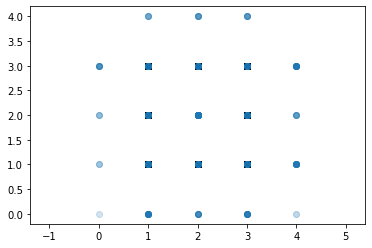

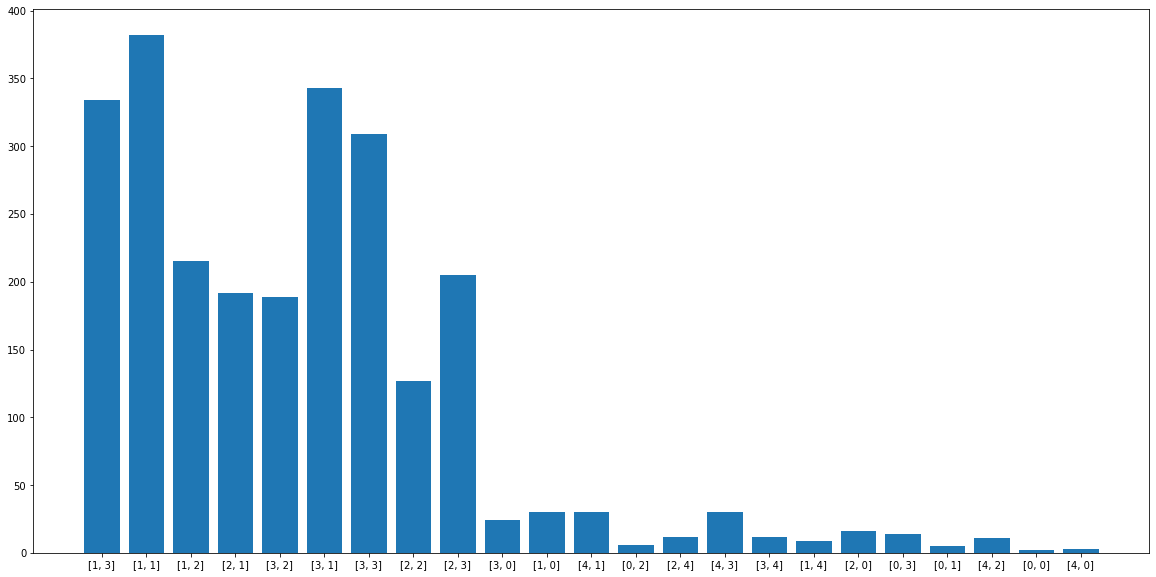

Processing Epoch 88
training start
Iteration 0, d real/fake loss 0.6078161001205444/0.6547934412956238 and g loss is 0.7298384308815002, NDiv loss 0.1040617898106575
Iteration 1, d real/fake loss 0.6077868342399597/0.6620885729789734 and g loss is 0.7247170209884644, NDiv loss 0.1056637242436409
Iteration 2, d real/fake loss 0.6077440977096558/0.6666032075881958 and g loss is 0.7235134243965149, NDiv loss 0.10689988732337952
Iteration 3, d real/fake loss 0.6076936721801758/0.660149335861206 and g loss is 0.7281219959259033, NDiv loss 0.10652918368577957
Iteration 4, d real/fake loss 0.6076327562332153/0.6609014272689819 and g loss is 0.7242758274078369, NDiv loss 0.10351961851119995


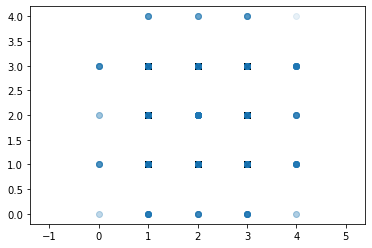

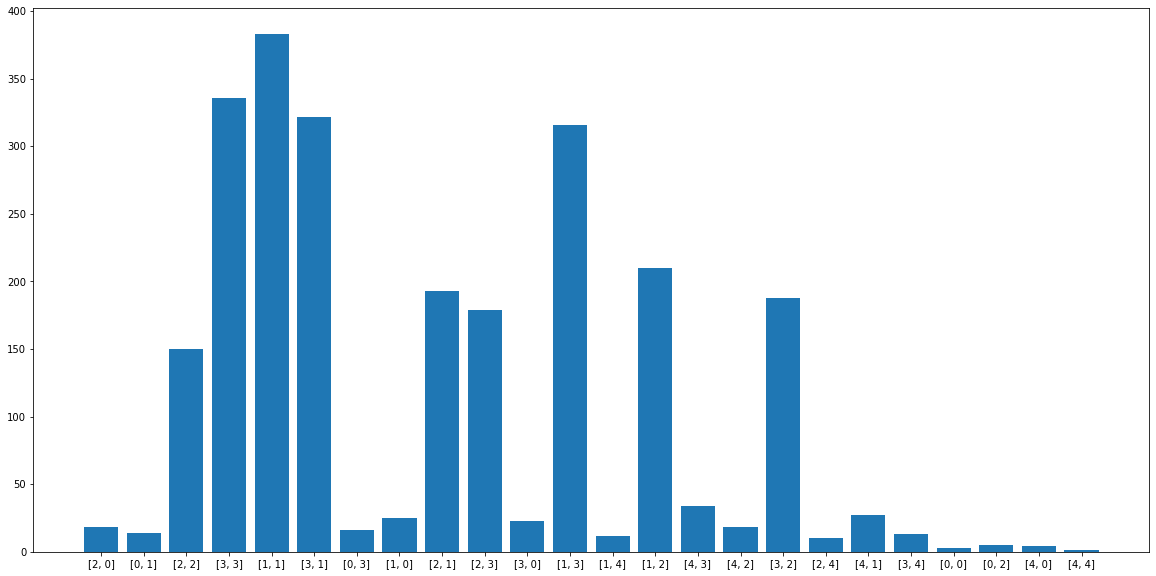

Processing Epoch 89
training start
Iteration 0, d real/fake loss 0.6062202453613281/0.662880003452301 and g loss is 0.7275326251983643, NDiv loss 0.10769353806972504
Iteration 1, d real/fake loss 0.6061601638793945/0.66482013463974 and g loss is 0.7204734086990356, NDiv loss 0.10161877423524857
Iteration 2, d real/fake loss 0.6060913801193237/0.6665346026420593 and g loss is 0.7273281812667847, NDiv loss 0.10780144482851028
Iteration 3, d real/fake loss 0.6060141324996948/0.66337651014328 and g loss is 0.7266173362731934, NDiv loss 0.10771753638982773
Iteration 4, d real/fake loss 0.6059262752532959/0.6633179783821106 and g loss is 0.7296057939529419, NDiv loss 0.10481847077608109


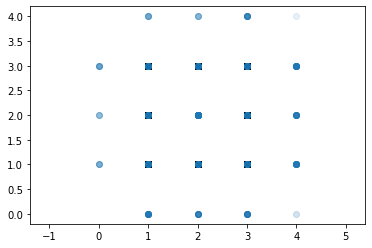

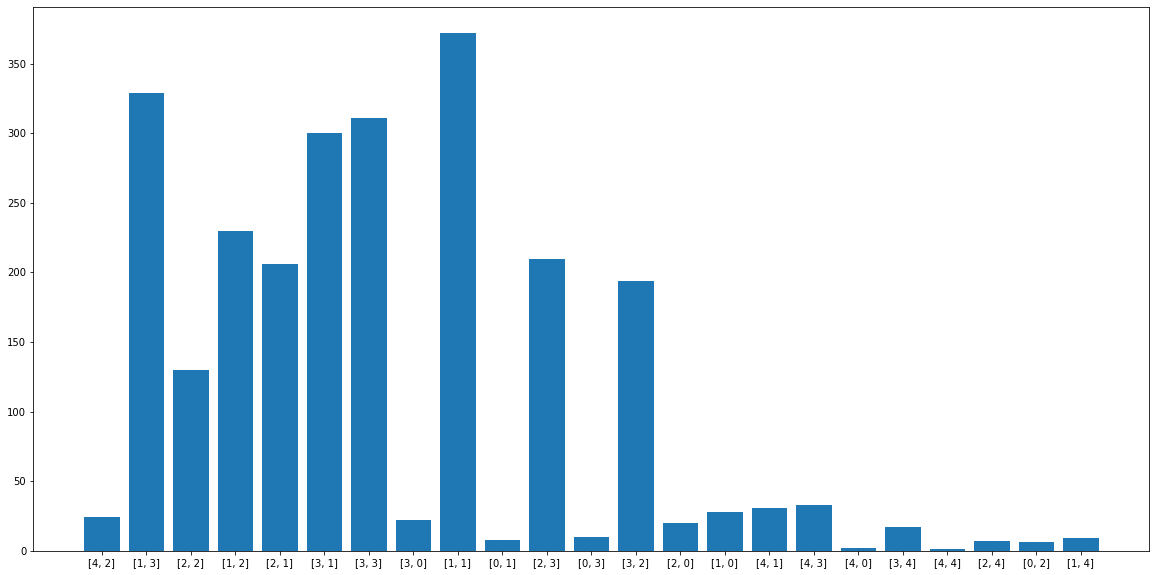

Processing Epoch 90
training start
Iteration 0, d real/fake loss 0.6045039892196655/0.665521502494812 and g loss is 0.7284759283065796, NDiv loss 0.09992235153913498
Iteration 1, d real/fake loss 0.6044371128082275/0.6712422370910645 and g loss is 0.7245633602142334, NDiv loss 0.1016332358121872
Iteration 2, d real/fake loss 0.6043834686279297/0.6639426946640015 and g loss is 0.7255368232727051, NDiv loss 0.10205098241567612
Iteration 3, d real/fake loss 0.6043376922607422/0.6623735427856445 and g loss is 0.7221728563308716, NDiv loss 0.10153289139270782
Iteration 4, d real/fake loss 0.6042918562889099/0.6688005924224854 and g loss is 0.7218381762504578, NDiv loss 0.11320064216852188


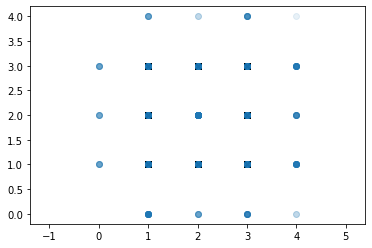

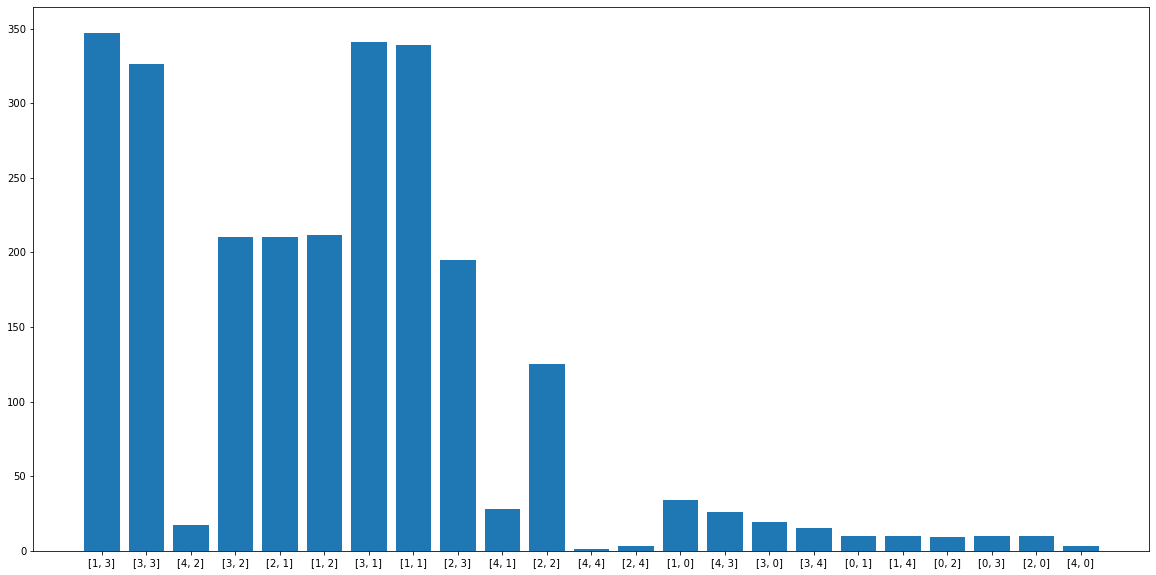

Processing Epoch 91
training start
Iteration 0, d real/fake loss 0.6070114374160767/0.6698580384254456 and g loss is 0.7272132039070129, NDiv loss 0.09870751202106476
Iteration 1, d real/fake loss 0.6069886684417725/0.6627479791641235 and g loss is 0.7249547243118286, NDiv loss 0.10282833874225616
Iteration 2, d real/fake loss 0.6069588661193848/0.6646299362182617 and g loss is 0.7252010107040405, NDiv loss 0.10083064436912537
Iteration 3, d real/fake loss 0.6069211959838867/0.6665135622024536 and g loss is 0.7303935289382935, NDiv loss 0.1046399399638176
Iteration 4, d real/fake loss 0.60688316822052/0.66856849193573 and g loss is 0.721204400062561, NDiv loss 0.10174888372421265


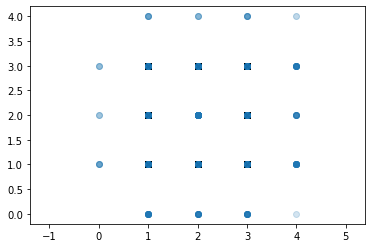

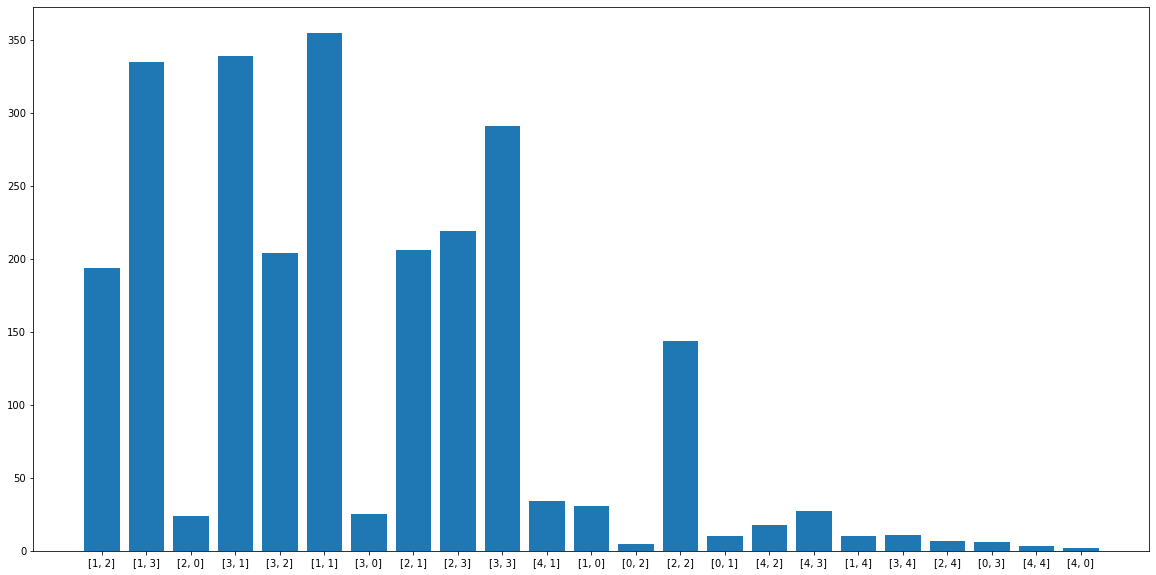

Processing Epoch 92
training start
Iteration 0, d real/fake loss 0.6033952832221985/0.658968448638916 and g loss is 0.7263331413269043, NDiv loss 0.10353334248065948
Iteration 1, d real/fake loss 0.6033912897109985/0.6640819907188416 and g loss is 0.7311683297157288, NDiv loss 0.10435528308153152
Iteration 2, d real/fake loss 0.6033930778503418/0.6632816791534424 and g loss is 0.7310407161712646, NDiv loss 0.10292310267686844
Iteration 3, d real/fake loss 0.603398859500885/0.6626911163330078 and g loss is 0.7300142645835876, NDiv loss 0.10077424347400665
Iteration 4, d real/fake loss 0.6034096479415894/0.67086261510849 and g loss is 0.7271851897239685, NDiv loss 0.10552217811346054


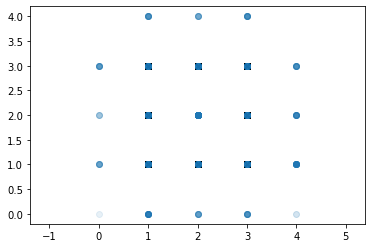

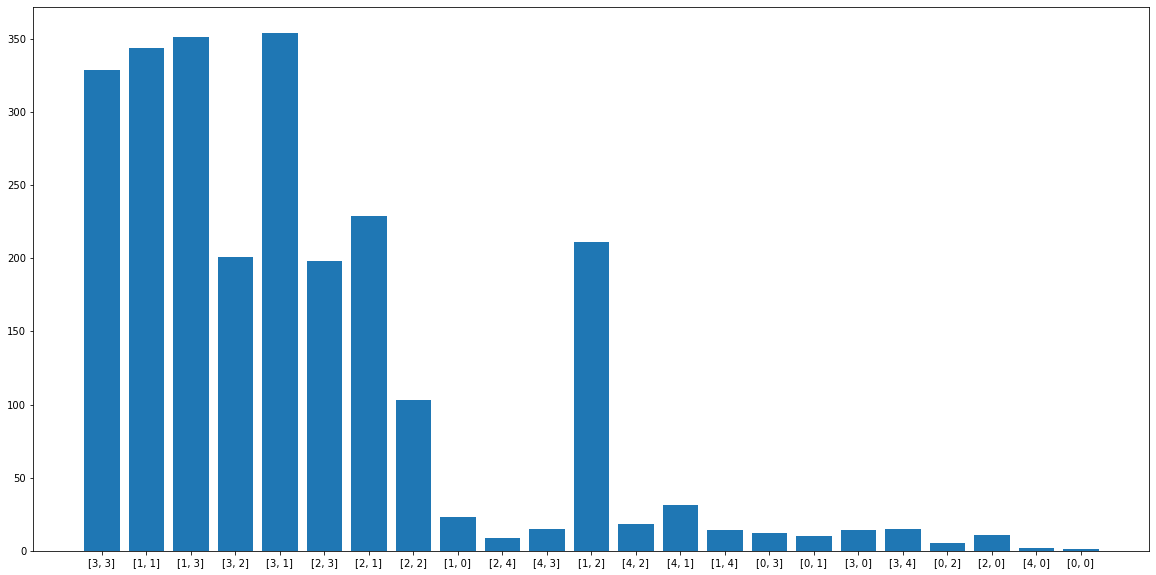

Processing Epoch 93
training start
Iteration 0, d real/fake loss 0.6068726778030396/0.6596725583076477 and g loss is 0.7273415923118591, NDiv loss 0.11156103014945984
Iteration 1, d real/fake loss 0.6069037914276123/0.6734073162078857 and g loss is 0.7270350456237793, NDiv loss 0.10111209005117416
Iteration 2, d real/fake loss 0.6069351434707642/0.6610565185546875 and g loss is 0.7349515557289124, NDiv loss 0.1049889624118805
Iteration 3, d real/fake loss 0.6069591045379639/0.6647579073905945 and g loss is 0.7281055450439453, NDiv loss 0.11071769893169403
Iteration 4, d real/fake loss 0.6069815158843994/0.6616265177726746 and g loss is 0.7221101522445679, NDiv loss 0.10784188657999039


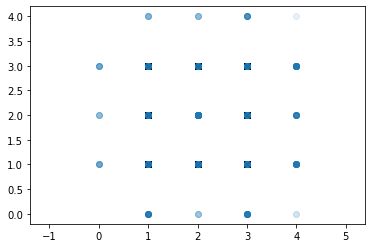

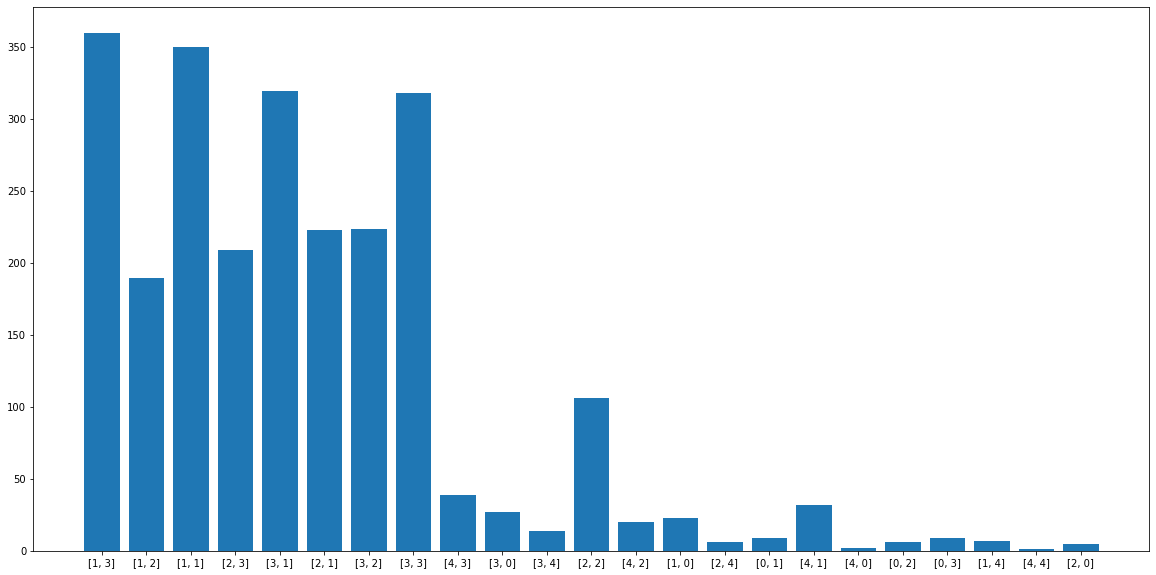

Processing Epoch 94
training start
Iteration 0, d real/fake loss 0.6059714555740356/0.6674240231513977 and g loss is 0.7267518043518066, NDiv loss 0.10677161812782288
Iteration 1, d real/fake loss 0.606001079082489/0.6673409938812256 and g loss is 0.726006805896759, NDiv loss 0.10315561294555664
Iteration 2, d real/fake loss 0.6060248613357544/0.6640180349349976 and g loss is 0.7347347736358643, NDiv loss 0.10474159568548203
Iteration 3, d real/fake loss 0.6060401797294617/0.6581565141677856 and g loss is 0.725990355014801, NDiv loss 0.10433327406644821
Iteration 4, d real/fake loss 0.6060390472412109/0.6655746698379517 and g loss is 0.732214093208313, NDiv loss 0.10998397320508957


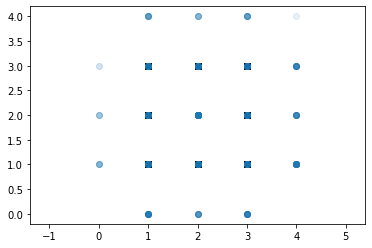

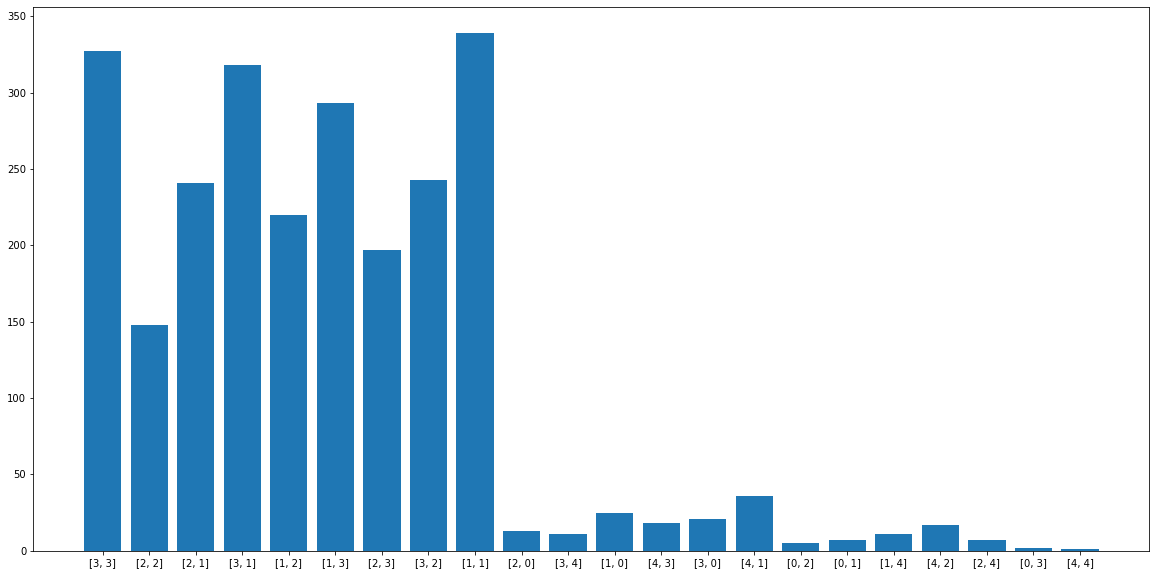

Processing Epoch 95
training start
Iteration 0, d real/fake loss 0.6075530052185059/0.657564640045166 and g loss is 0.7236262559890747, NDiv loss 0.10336454212665558
Iteration 1, d real/fake loss 0.6075599193572998/0.6631057858467102 and g loss is 0.7278295755386353, NDiv loss 0.11256755888462067
Iteration 2, d real/fake loss 0.6075564622879028/0.662116527557373 and g loss is 0.7287514209747314, NDiv loss 0.11145075410604477
Iteration 3, d real/fake loss 0.6075323820114136/0.6554802656173706 and g loss is 0.7295963764190674, NDiv loss 0.1037943884730339
Iteration 4, d real/fake loss 0.6074888110160828/0.6627153754234314 and g loss is 0.7332320213317871, NDiv loss 0.10364872217178345


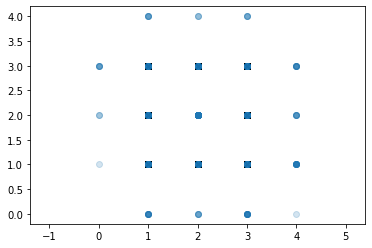

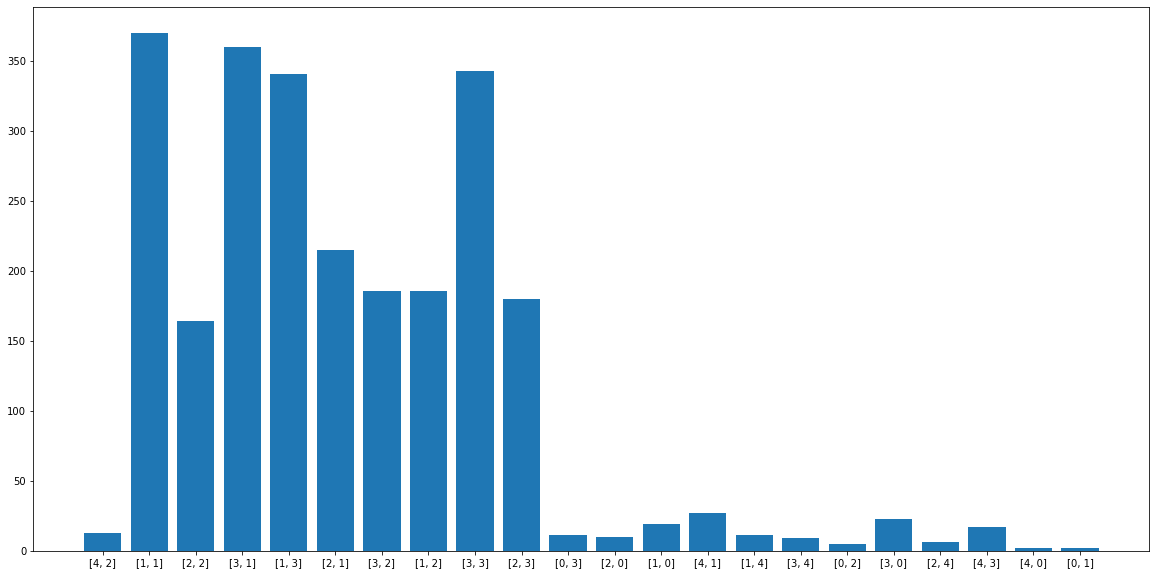

Processing Epoch 96
training start
Iteration 0, d real/fake loss 0.6083182096481323/0.6672945022583008 and g loss is 0.7281720638275146, NDiv loss 0.10453333705663681
Iteration 1, d real/fake loss 0.6082441806793213/0.660643458366394 and g loss is 0.7346084117889404, NDiv loss 0.10739777982234955
Iteration 2, d real/fake loss 0.6081605553627014/0.6648183465003967 and g loss is 0.7289458513259888, NDiv loss 0.10703150928020477
Iteration 3, d real/fake loss 0.6080760955810547/0.6653966307640076 and g loss is 0.7282531261444092, NDiv loss 0.10232257097959518
Iteration 4, d real/fake loss 0.6079796552658081/0.6611437797546387 and g loss is 0.7300244569778442, NDiv loss 0.10486354678869247


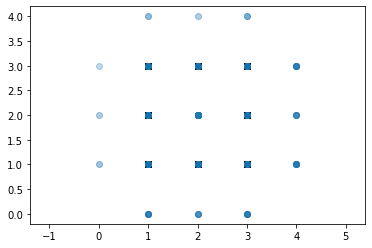

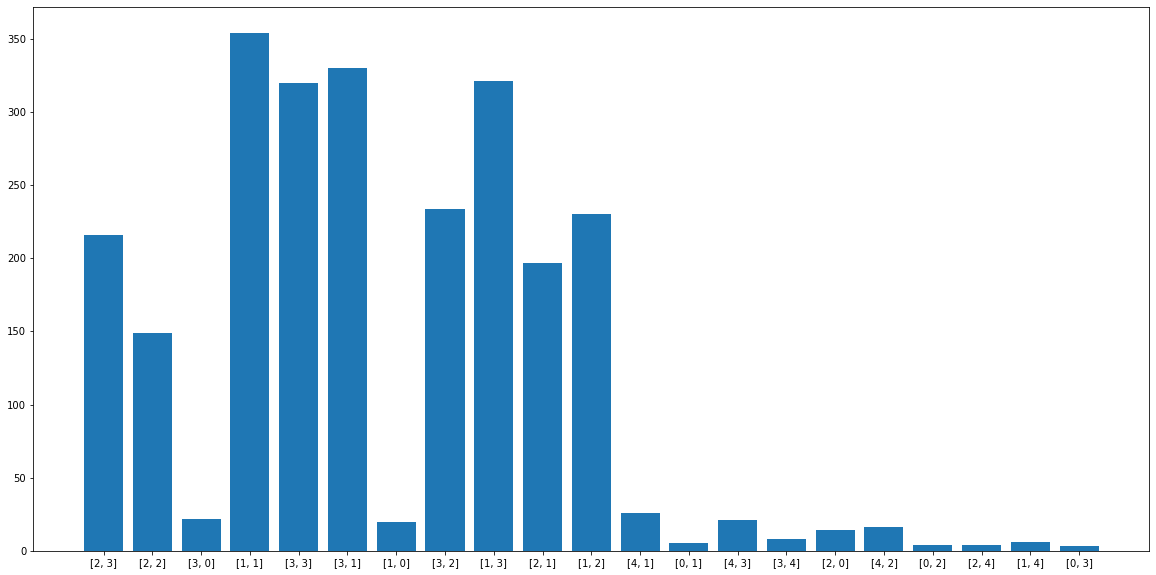

Processing Epoch 97
training start
Iteration 0, d real/fake loss 0.6057876944541931/0.6574695706367493 and g loss is 0.7281677722930908, NDiv loss 0.10576903820037842
Iteration 1, d real/fake loss 0.6057606935501099/0.6623086929321289 and g loss is 0.721921443939209, NDiv loss 0.11484652757644653
Iteration 2, d real/fake loss 0.6057349443435669/0.6640642285346985 and g loss is 0.7255218029022217, NDiv loss 0.1129649356007576
Iteration 3, d real/fake loss 0.6057099103927612/0.6583468914031982 and g loss is 0.7220868468284607, NDiv loss 0.11516804248094559
Iteration 4, d real/fake loss 0.605682373046875/0.6467193365097046 and g loss is 0.7279181480407715, NDiv loss 0.10383015125989914


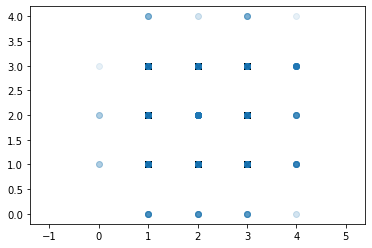

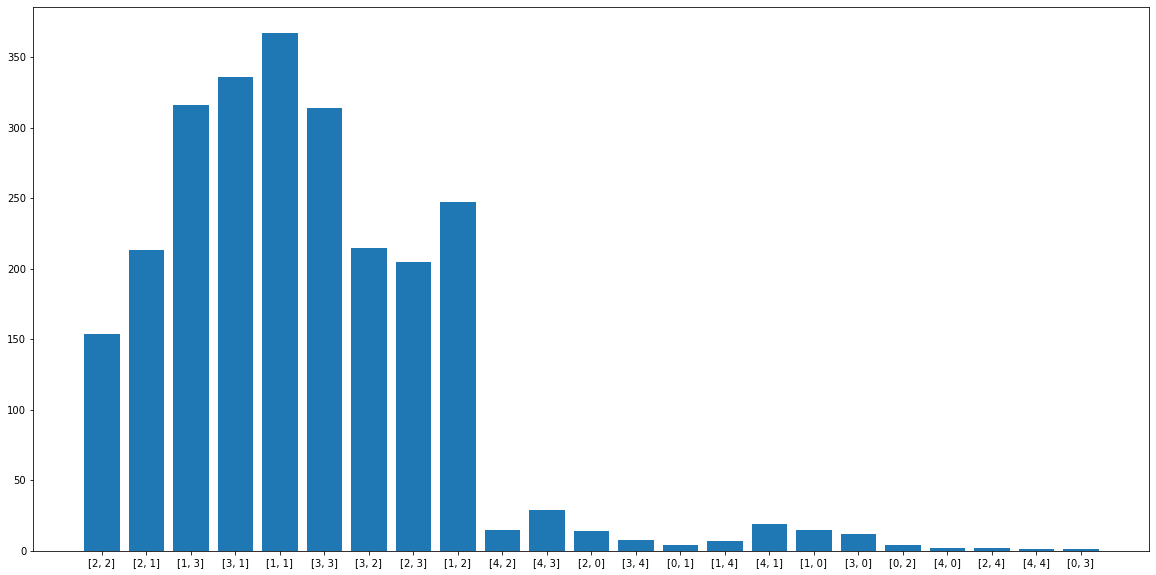

Processing Epoch 98
training start
Iteration 0, d real/fake loss 0.6070213317871094/0.6607846021652222 and g loss is 0.7253860235214233, NDiv loss 0.11060870438814163
Iteration 1, d real/fake loss 0.6069497466087341/0.6591952443122864 and g loss is 0.7274444103240967, NDiv loss 0.11260352283716202
Iteration 2, d real/fake loss 0.6068782210350037/0.6611336469650269 and g loss is 0.730154812335968, NDiv loss 0.10860756784677505
Iteration 3, d real/fake loss 0.6068053245544434/0.6659761667251587 and g loss is 0.732345700263977, NDiv loss 0.10877954959869385
Iteration 4, d real/fake loss 0.6067330837249756/0.6581374406814575 and g loss is 0.7284104824066162, NDiv loss 0.11479832977056503


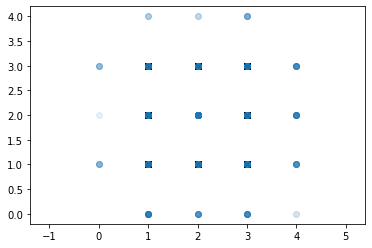

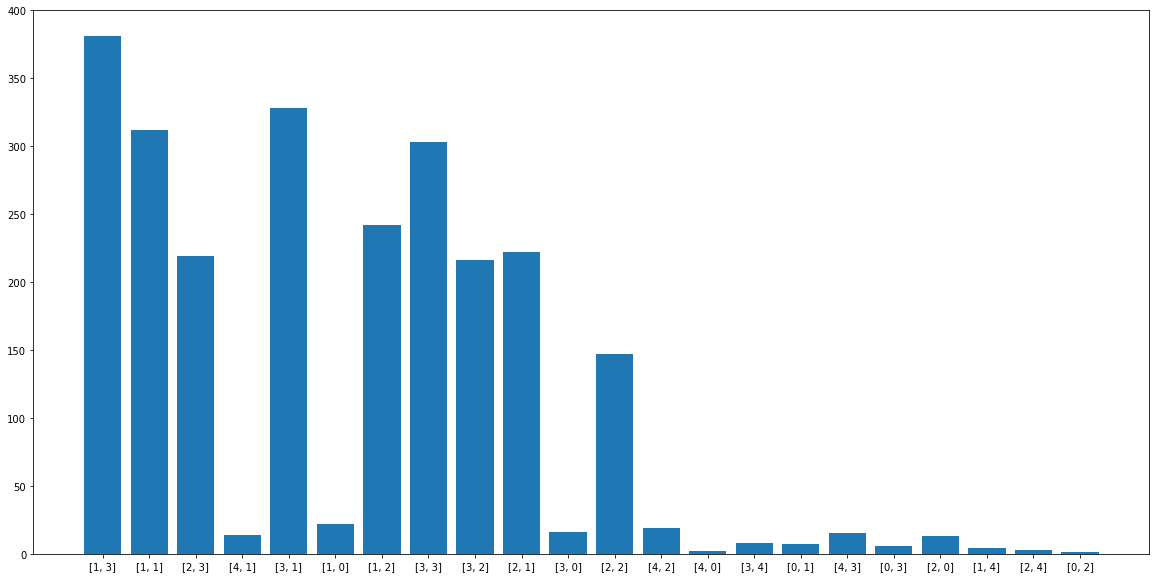

Processing Epoch 99
training start
Iteration 0, d real/fake loss 0.6059502363204956/0.6558778882026672 and g loss is 0.7285394668579102, NDiv loss 0.10979656875133514
Iteration 1, d real/fake loss 0.6059121489524841/0.657477617263794 and g loss is 0.7294633388519287, NDiv loss 0.11098404973745346
Iteration 2, d real/fake loss 0.6058748364448547/0.6626543402671814 and g loss is 0.7304074764251709, NDiv loss 0.10230100154876709
Iteration 3, d real/fake loss 0.6058436632156372/0.6645091772079468 and g loss is 0.7312308549880981, NDiv loss 0.1061662808060646
Iteration 4, d real/fake loss 0.6058236360549927/0.6591318845748901 and g loss is 0.7265064716339111, NDiv loss 0.11118067800998688


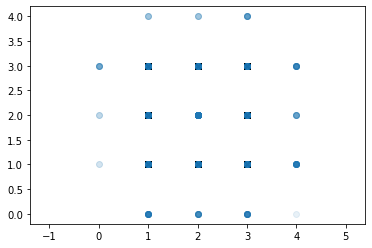

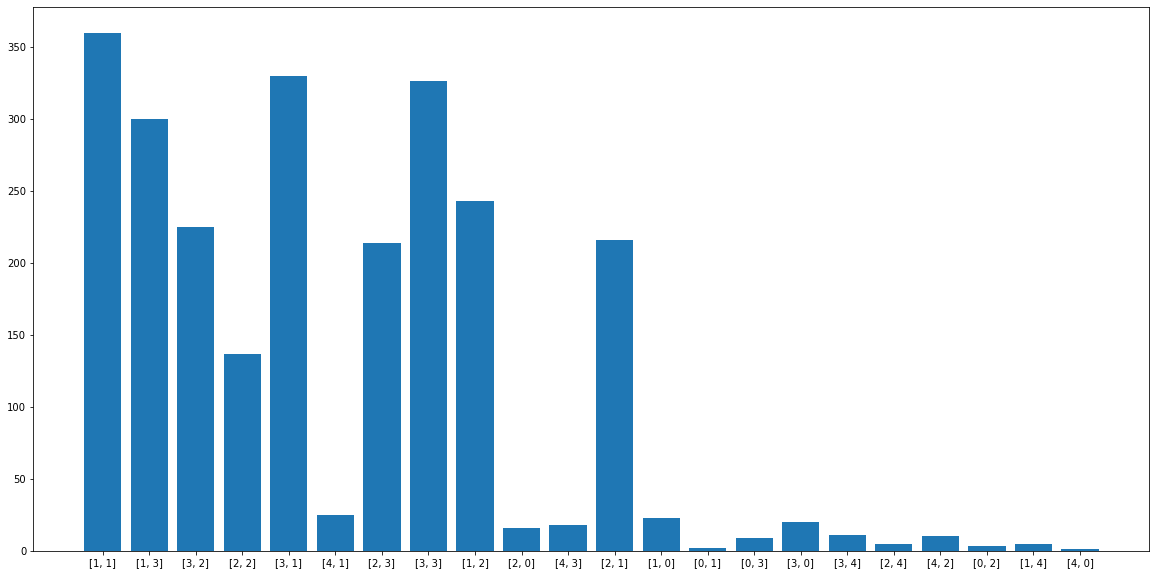

Processing Epoch 100
training start
Iteration 0, d real/fake loss 0.6045663356781006/0.6599785089492798 and g loss is 0.7235279083251953, NDiv loss 0.10903777927160263
Iteration 1, d real/fake loss 0.6045975089073181/0.6624913215637207 and g loss is 0.7316244840621948, NDiv loss 0.11441203206777573
Iteration 2, d real/fake loss 0.6046310067176819/0.6583389043807983 and g loss is 0.7357789278030396, NDiv loss 0.10649267584085464
Iteration 3, d real/fake loss 0.6046606302261353/0.6569751501083374 and g loss is 0.7284755706787109, NDiv loss 0.11060015857219696
Iteration 4, d real/fake loss 0.6046816110610962/0.6598447561264038 and g loss is 0.738551139831543, NDiv loss 0.10241927206516266


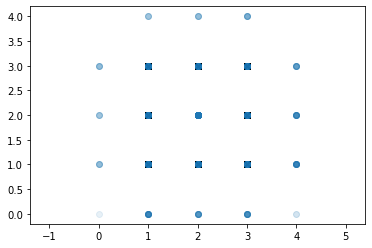

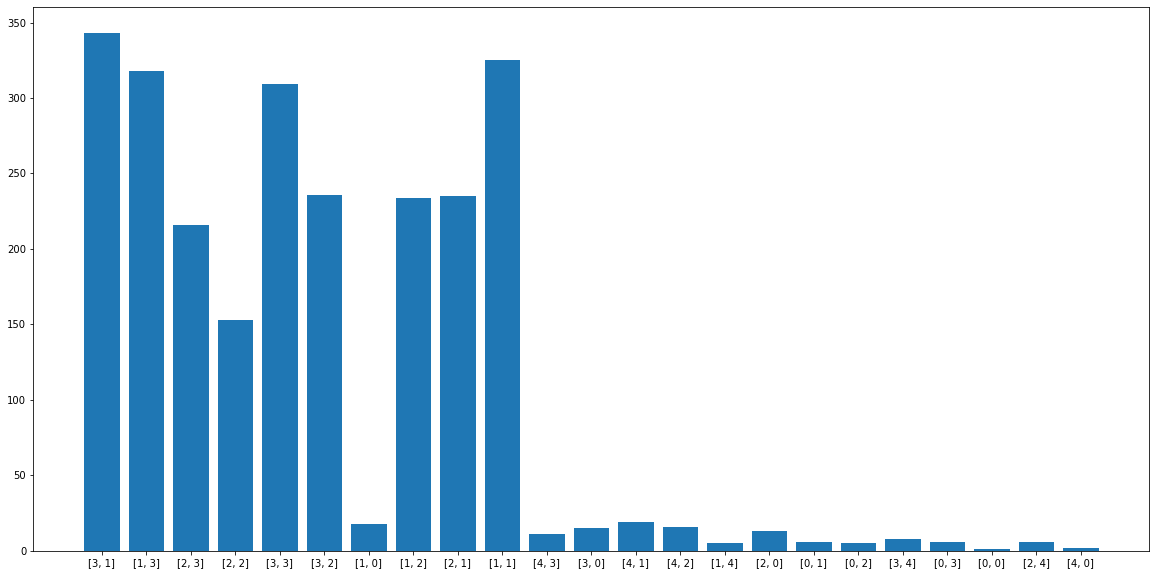

Processing Epoch 101
training start
Iteration 0, d real/fake loss 0.6053531169891357/0.657014012336731 and g loss is 0.7273547053337097, NDiv loss 0.10895628482103348
Iteration 1, d real/fake loss 0.6053466796875/0.6603450775146484 and g loss is 0.7302573323249817, NDiv loss 0.10511483997106552
Iteration 2, d real/fake loss 0.6053316593170166/0.654895544052124 and g loss is 0.7334797382354736, NDiv loss 0.11276346445083618
Iteration 3, d real/fake loss 0.6052893996238708/0.6568487882614136 and g loss is 0.7232405543327332, NDiv loss 0.10720700025558472
Iteration 4, d real/fake loss 0.6052380800247192/0.6632821559906006 and g loss is 0.7336447834968567, NDiv loss 0.10130827873945236


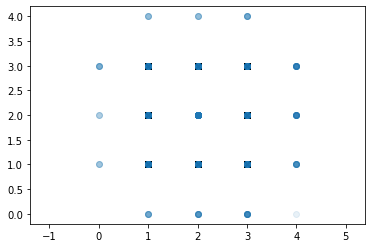

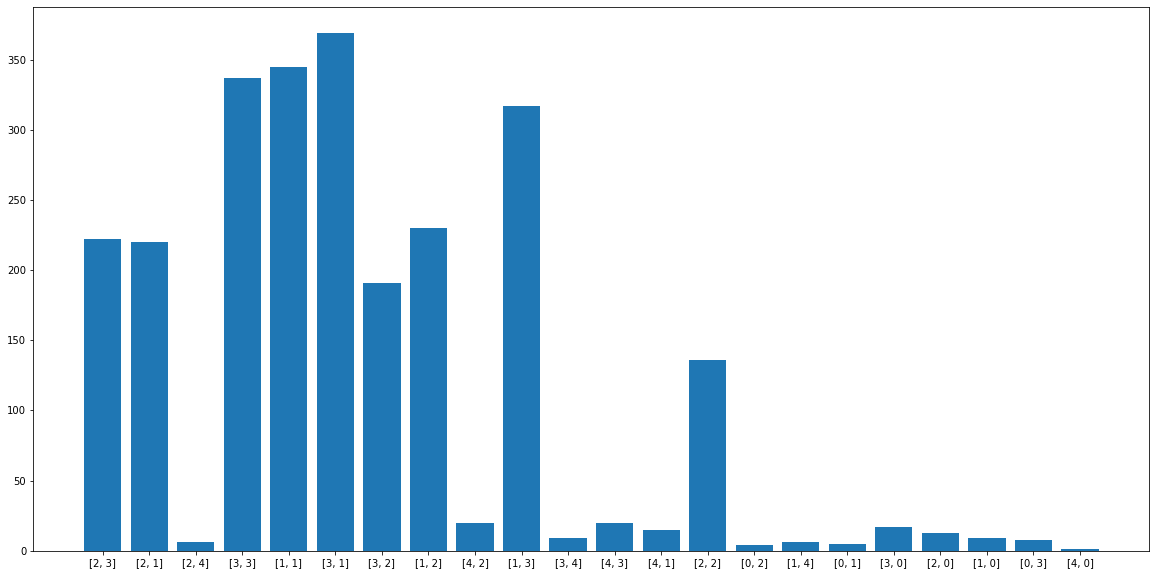

Processing Epoch 102
training start
Iteration 0, d real/fake loss 0.6057590246200562/0.6573971509933472 and g loss is 0.7281472086906433, NDiv loss 0.11017350852489471
Iteration 1, d real/fake loss 0.6057467460632324/0.6549713611602783 and g loss is 0.7308138012886047, NDiv loss 0.10725948214530945
Iteration 2, d real/fake loss 0.6057376861572266/0.6556795835494995 and g loss is 0.7288243770599365, NDiv loss 0.11177750676870346
Iteration 3, d real/fake loss 0.6057222485542297/0.6622908115386963 and g loss is 0.7285680174827576, NDiv loss 0.11039555817842484
Iteration 4, d real/fake loss 0.6057131886482239/0.6558818817138672 and g loss is 0.7278810739517212, NDiv loss 0.10860889405012131


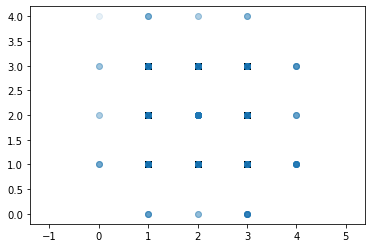

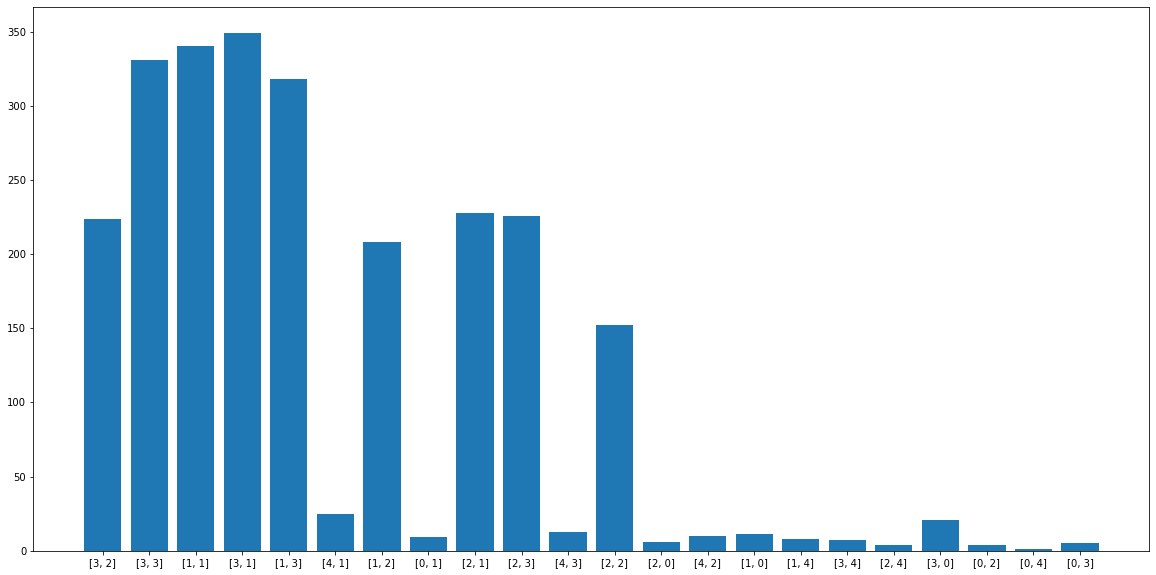

Processing Epoch 103
training start
Iteration 0, d real/fake loss 0.6068901419639587/0.6626099944114685 and g loss is 0.7284597158432007, NDiv loss 0.11278066039085388
Iteration 1, d real/fake loss 0.6068764925003052/0.6619740724563599 and g loss is 0.7327232360839844, NDiv loss 0.10898073017597198
Iteration 2, d real/fake loss 0.6068553924560547/0.655402421951294 and g loss is 0.7273327708244324, NDiv loss 0.11611107736825943
Iteration 3, d real/fake loss 0.6068223118782043/0.6551902890205383 and g loss is 0.736388087272644, NDiv loss 0.10899337381124496
Iteration 4, d real/fake loss 0.606778085231781/0.6585643291473389 and g loss is 0.732255220413208, NDiv loss 0.10854369401931763


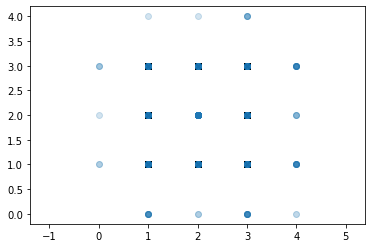

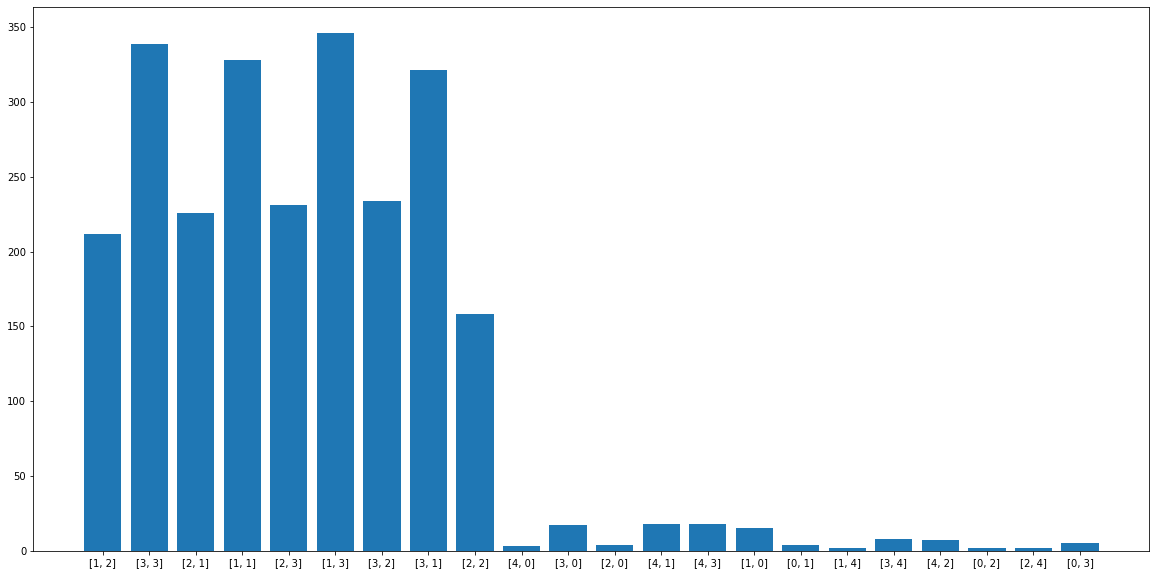

Processing Epoch 104
training start
Iteration 0, d real/fake loss 0.6054877042770386/0.6582367420196533 and g loss is 0.730254054069519, NDiv loss 0.1105833649635315
Iteration 1, d real/fake loss 0.6054518818855286/0.6510267853736877 and g loss is 0.7329154014587402, NDiv loss 0.10387702286243439
Iteration 2, d real/fake loss 0.60540771484375/0.6506761312484741 and g loss is 0.7324060201644897, NDiv loss 0.10669635981321335
Iteration 3, d real/fake loss 0.605356752872467/0.6556457281112671 and g loss is 0.7352199554443359, NDiv loss 0.11234384030103683
Iteration 4, d real/fake loss 0.6053060293197632/0.6589311361312866 and g loss is 0.7292274236679077, NDiv loss 0.11068013310432434


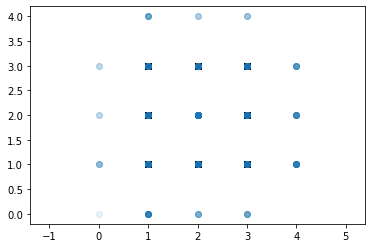

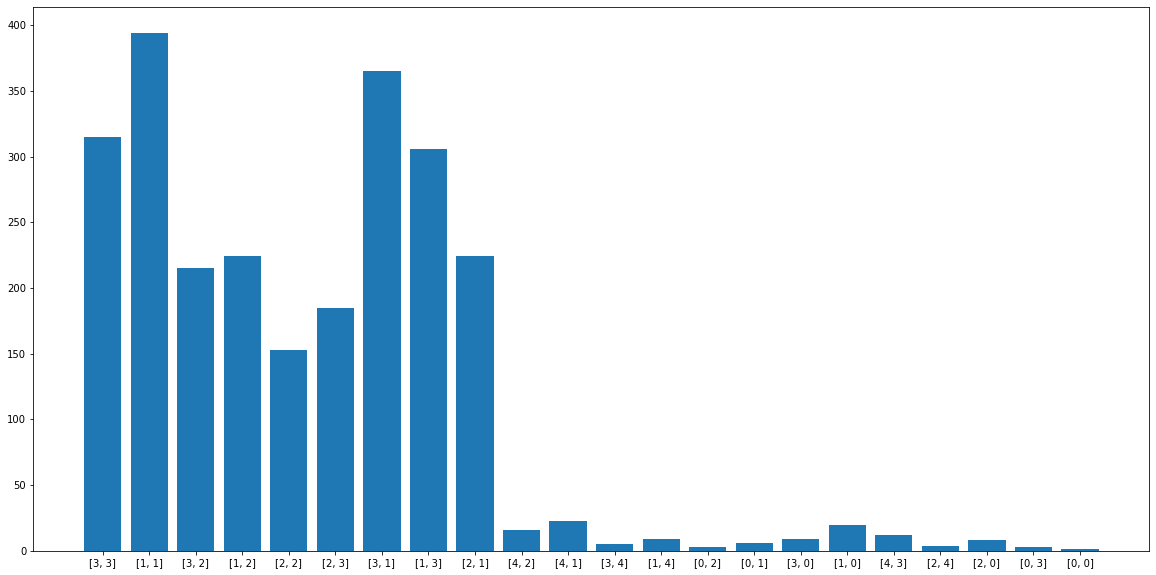

Processing Epoch 105
training start
Iteration 0, d real/fake loss 0.6048470139503479/0.6498351097106934 and g loss is 0.7378457188606262, NDiv loss 0.10626453906297684
Iteration 1, d real/fake loss 0.6048250198364258/0.6608541011810303 and g loss is 0.7251333594322205, NDiv loss 0.11051131784915924
Iteration 2, d real/fake loss 0.6048046946525574/0.6536738872528076 and g loss is 0.7288715839385986, NDiv loss 0.11514213681221008
Iteration 3, d real/fake loss 0.6047836542129517/0.6620026230812073 and g loss is 0.7322449684143066, NDiv loss 0.11205105483531952
Iteration 4, d real/fake loss 0.6047686338424683/0.6499944925308228 and g loss is 0.7356575727462769, NDiv loss 0.11293414235115051


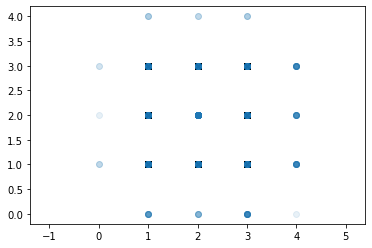

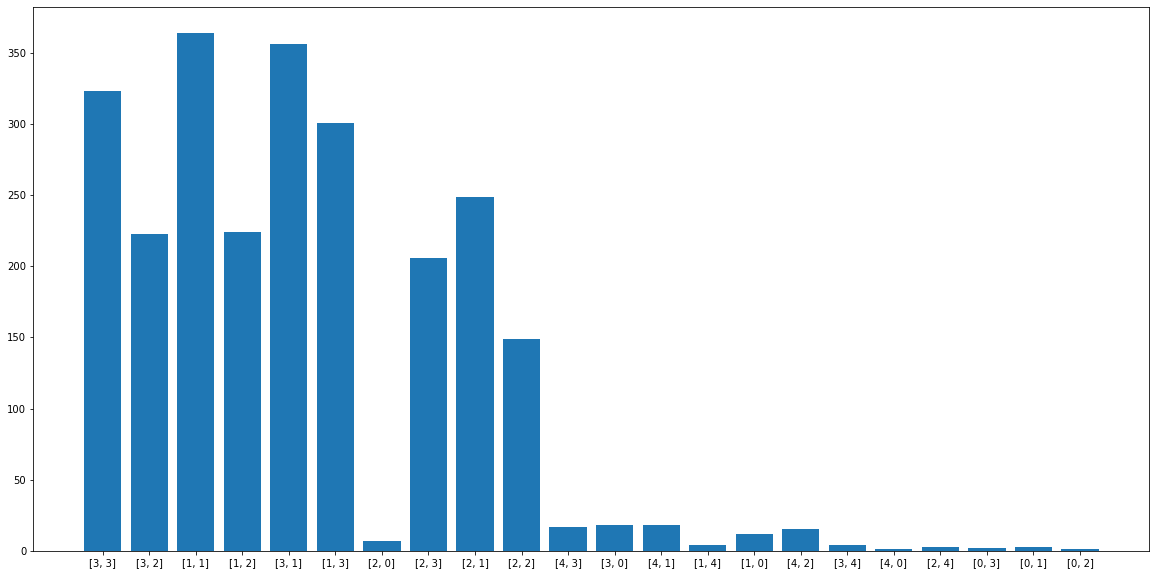

Processing Epoch 106
training start
Iteration 0, d real/fake loss 0.6048561930656433/0.6618260145187378 and g loss is 0.733397364616394, NDiv loss 0.11088231950998306
Iteration 1, d real/fake loss 0.6048377156257629/0.6556501388549805 and g loss is 0.7353972792625427, NDiv loss 0.10975932329893112
Iteration 2, d real/fake loss 0.604804277420044/0.6527361869812012 and g loss is 0.7346026301383972, NDiv loss 0.1129666417837143
Iteration 3, d real/fake loss 0.6047533750534058/0.6557934880256653 and g loss is 0.7280803918838501, NDiv loss 0.11291634291410446
Iteration 4, d real/fake loss 0.6046994924545288/0.657629668712616 and g loss is 0.7300616502761841, NDiv loss 0.11214153468608856


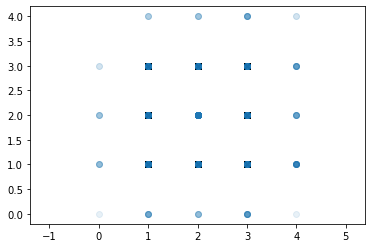

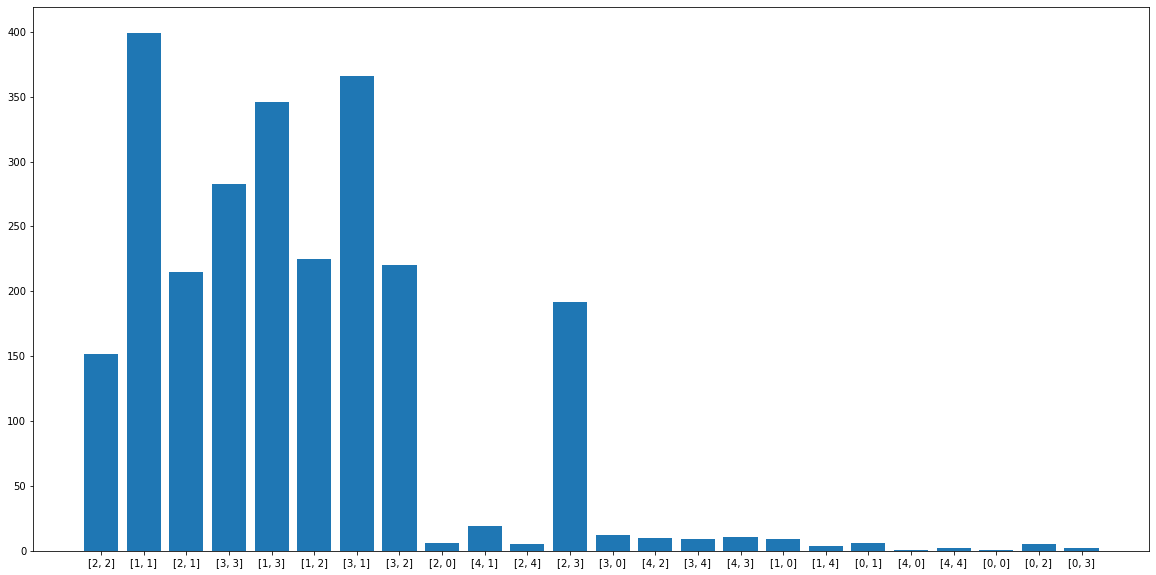

Processing Epoch 107
training start
Iteration 0, d real/fake loss 0.6065704822540283/0.6586609482765198 and g loss is 0.7270563840866089, NDiv loss 0.1125006154179573
Iteration 1, d real/fake loss 0.6065412163734436/0.6578965187072754 and g loss is 0.7257073521614075, NDiv loss 0.11335493624210358
Iteration 2, d real/fake loss 0.6064943075180054/0.6487811803817749 and g loss is 0.7373834848403931, NDiv loss 0.1131242960691452
Iteration 3, d real/fake loss 0.6064216494560242/0.6599496603012085 and g loss is 0.7340301871299744, NDiv loss 0.10560474544763565
Iteration 4, d real/fake loss 0.6063412427902222/0.6584655046463013 and g loss is 0.7345704436302185, NDiv loss 0.1090601459145546


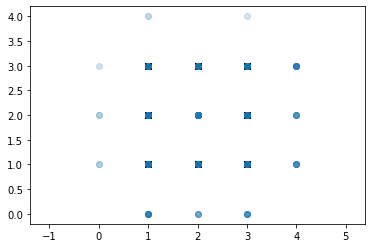

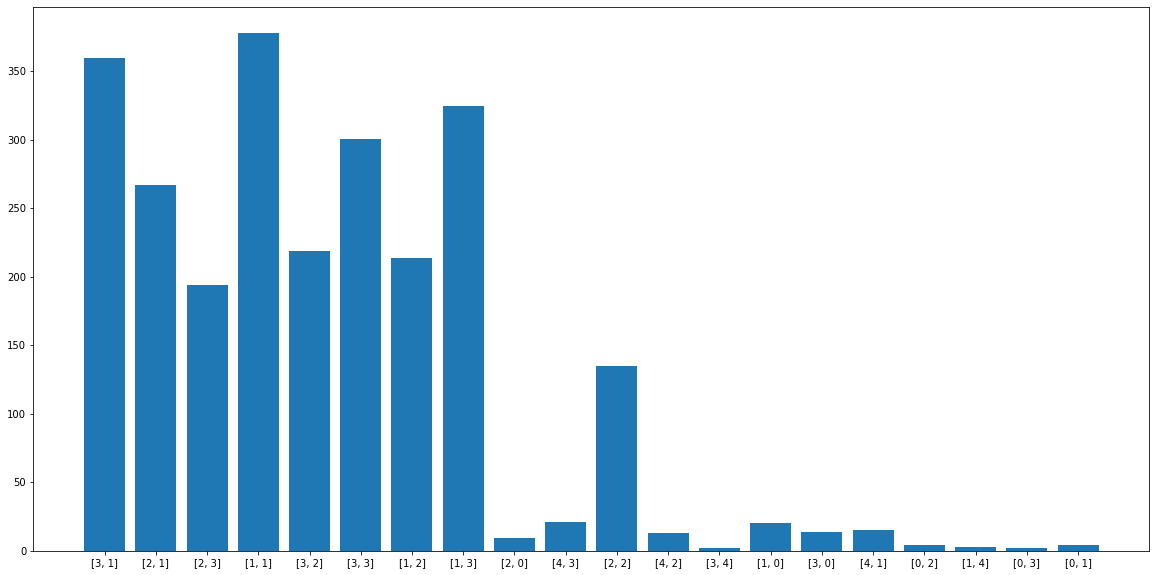

Processing Epoch 108
training start
Iteration 0, d real/fake loss 0.6038082838058472/0.657604455947876 and g loss is 0.7353557348251343, NDiv loss 0.10436989367008209
Iteration 1, d real/fake loss 0.603770911693573/0.6614699363708496 and g loss is 0.7341129183769226, NDiv loss 0.10780756920576096
Iteration 2, d real/fake loss 0.6037241220474243/0.6537793278694153 and g loss is 0.7446951866149902, NDiv loss 0.10985585302114487
Iteration 3, d real/fake loss 0.6036691069602966/0.6542122960090637 and g loss is 0.7345022559165955, NDiv loss 0.11125429719686508
Iteration 4, d real/fake loss 0.6035933494567871/0.6533357501029968 and g loss is 0.7472518682479858, NDiv loss 0.11276435852050781


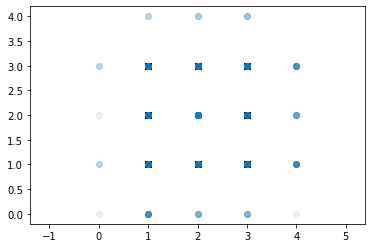

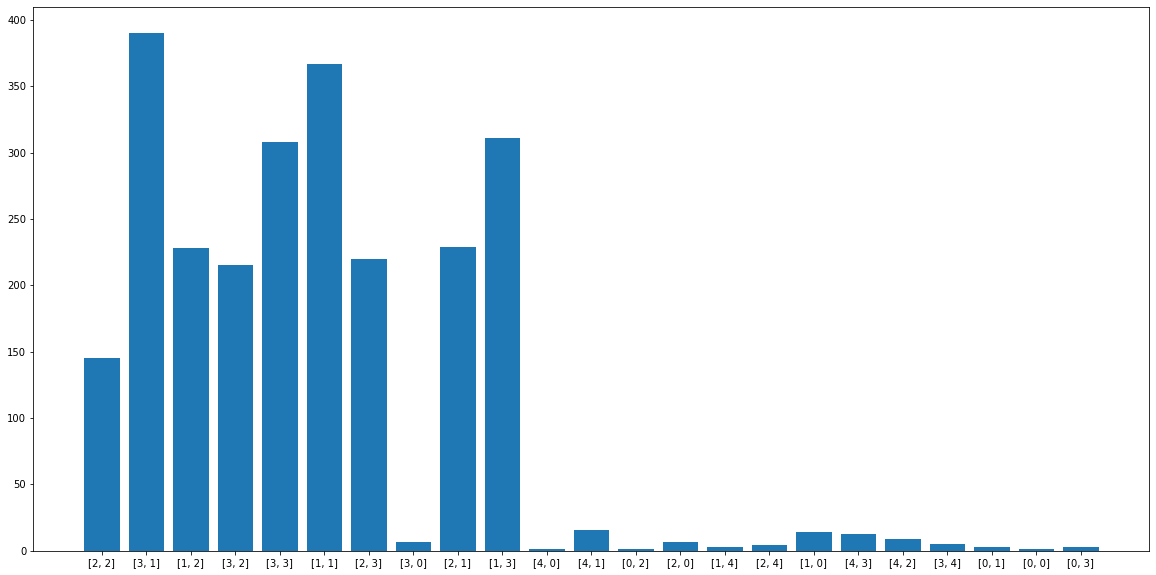

Processing Epoch 109
training start
Iteration 0, d real/fake loss 0.6035844683647156/0.6545349359512329 and g loss is 0.7360710501670837, NDiv loss 0.10736895352602005
Iteration 1, d real/fake loss 0.6035709381103516/0.6507734060287476 and g loss is 0.733372688293457, NDiv loss 0.10765009373426437
Iteration 2, d real/fake loss 0.6035548448562622/0.6547566652297974 and g loss is 0.7362622022628784, NDiv loss 0.11412660777568817
Iteration 3, d real/fake loss 0.6035404801368713/0.654452919960022 and g loss is 0.7304263114929199, NDiv loss 0.11691343784332275
Iteration 4, d real/fake loss 0.6035270690917969/0.6522945761680603 and g loss is 0.7421236038208008, NDiv loss 0.11581062525510788


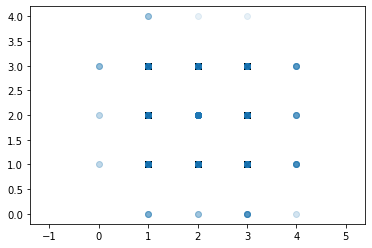

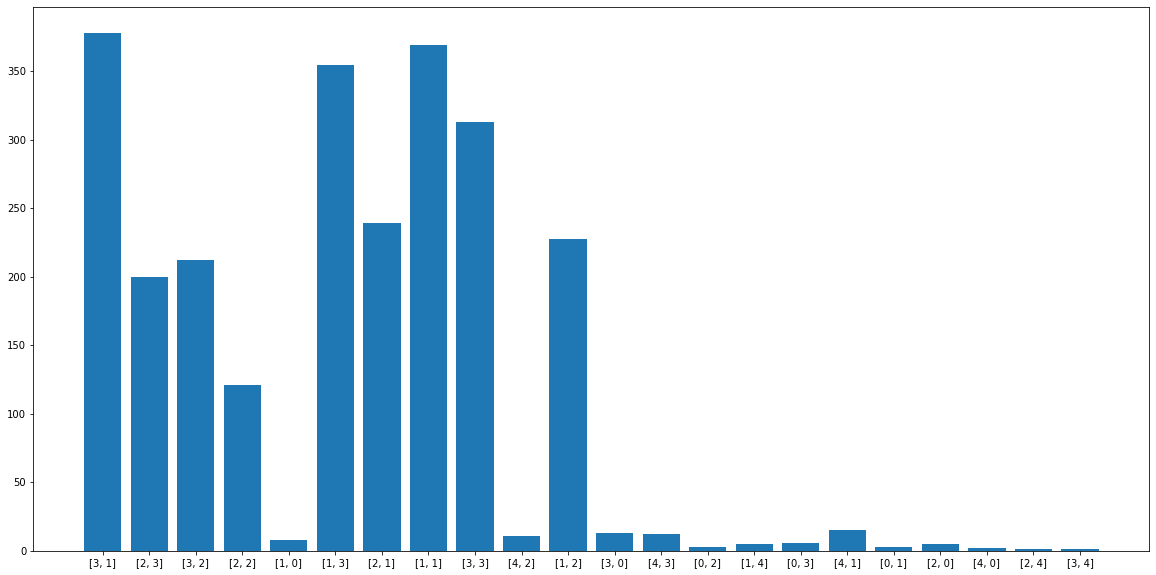

Processing Epoch 110
training start
Iteration 0, d real/fake loss 0.6042693257331848/0.6516053080558777 and g loss is 0.7350844740867615, NDiv loss 0.1150941252708435
Iteration 1, d real/fake loss 0.6042658090591431/0.6529123187065125 and g loss is 0.7402605414390564, NDiv loss 0.11421755701303482
Iteration 2, d real/fake loss 0.6042649745941162/0.6477305889129639 and g loss is 0.7306605577468872, NDiv loss 0.11513053625822067
Iteration 3, d real/fake loss 0.6042612791061401/0.6575572490692139 and g loss is 0.728784441947937, NDiv loss 0.11067996919155121
Iteration 4, d real/fake loss 0.6042658090591431/0.6534826159477234 and g loss is 0.734872579574585, NDiv loss 0.11025496572256088


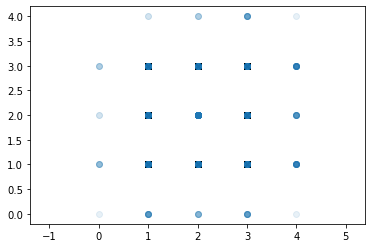

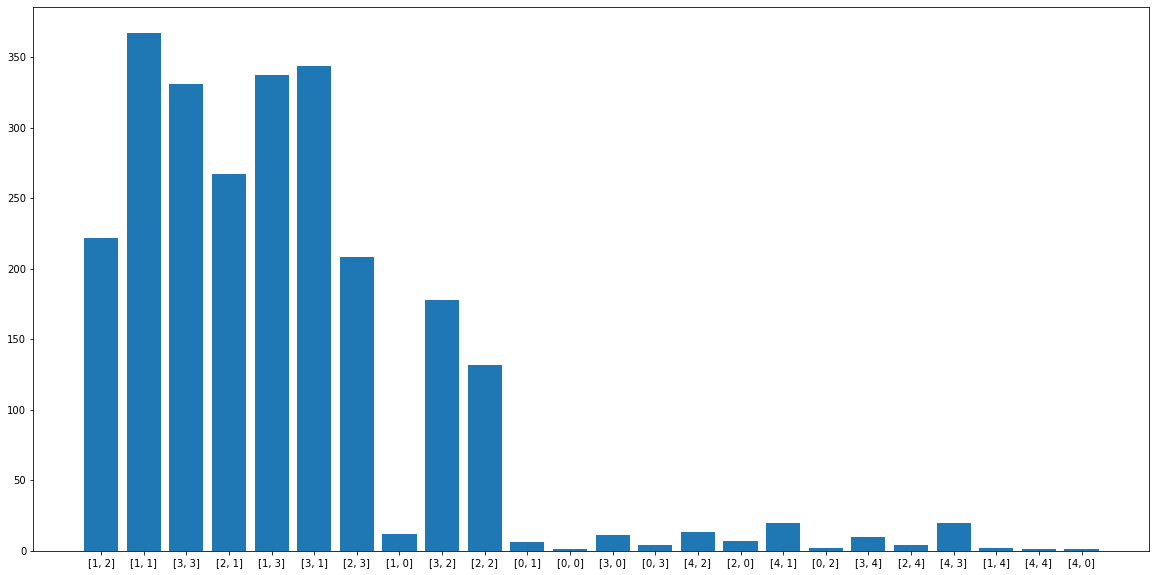

Processing Epoch 111
training start
Iteration 0, d real/fake loss 0.6059983968734741/0.6512859463691711 and g loss is 0.7379370331764221, NDiv loss 0.11659424006938934
Iteration 1, d real/fake loss 0.6060142517089844/0.6543880105018616 and g loss is 0.7448291778564453, NDiv loss 0.11292316019535065
Iteration 2, d real/fake loss 0.6060274839401245/0.6550948619842529 and g loss is 0.7360522747039795, NDiv loss 0.11041750013828278
Iteration 3, d real/fake loss 0.6060386300086975/0.650926947593689 and g loss is 0.7425199747085571, NDiv loss 0.10803258419036865
Iteration 4, d real/fake loss 0.6060371398925781/0.6573523283004761 and g loss is 0.7431027889251709, NDiv loss 0.11140935122966766


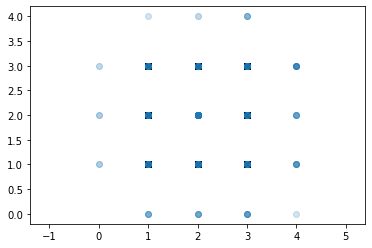

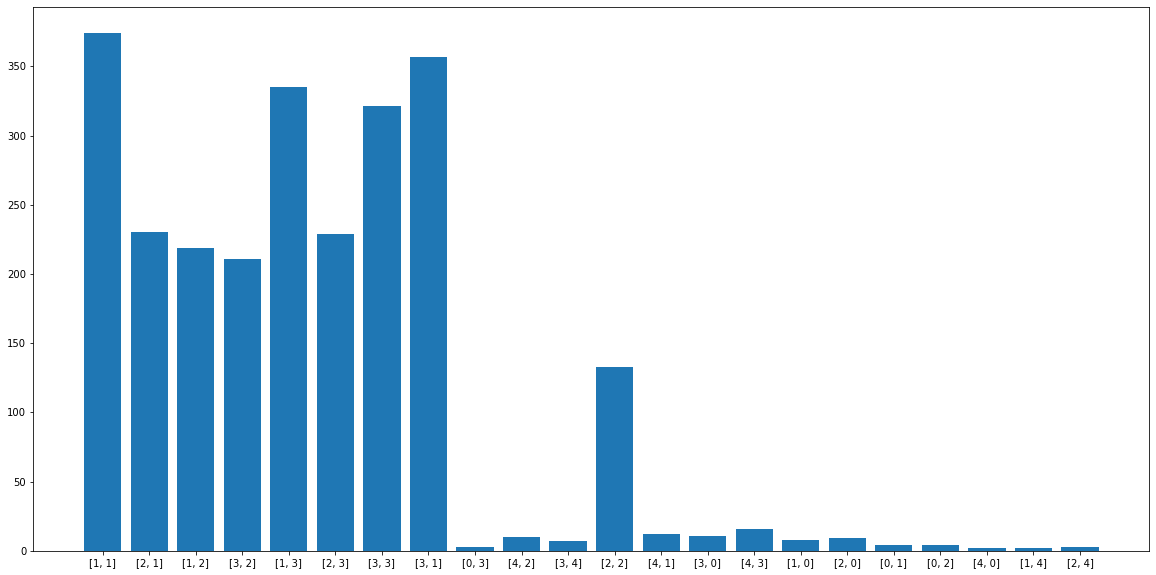

Processing Epoch 112
training start
Iteration 0, d real/fake loss 0.6039659976959229/0.6503515243530273 and g loss is 0.7354856729507446, NDiv loss 0.11208123713731766
Iteration 1, d real/fake loss 0.6039702892303467/0.6536414623260498 and g loss is 0.7385987043380737, NDiv loss 0.10334156453609467
Iteration 2, d real/fake loss 0.603969931602478/0.654625654220581 and g loss is 0.7345718145370483, NDiv loss 0.1119484081864357
Iteration 3, d real/fake loss 0.6039760112762451/0.6549978256225586 and g loss is 0.7424800992012024, NDiv loss 0.10964784026145935
Iteration 4, d real/fake loss 0.6039792895317078/0.658014714717865 and g loss is 0.7454079389572144, NDiv loss 0.1017499715089798


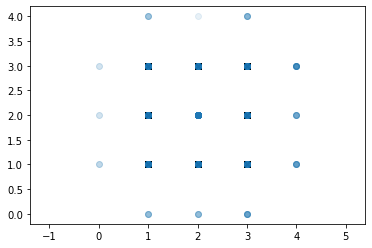

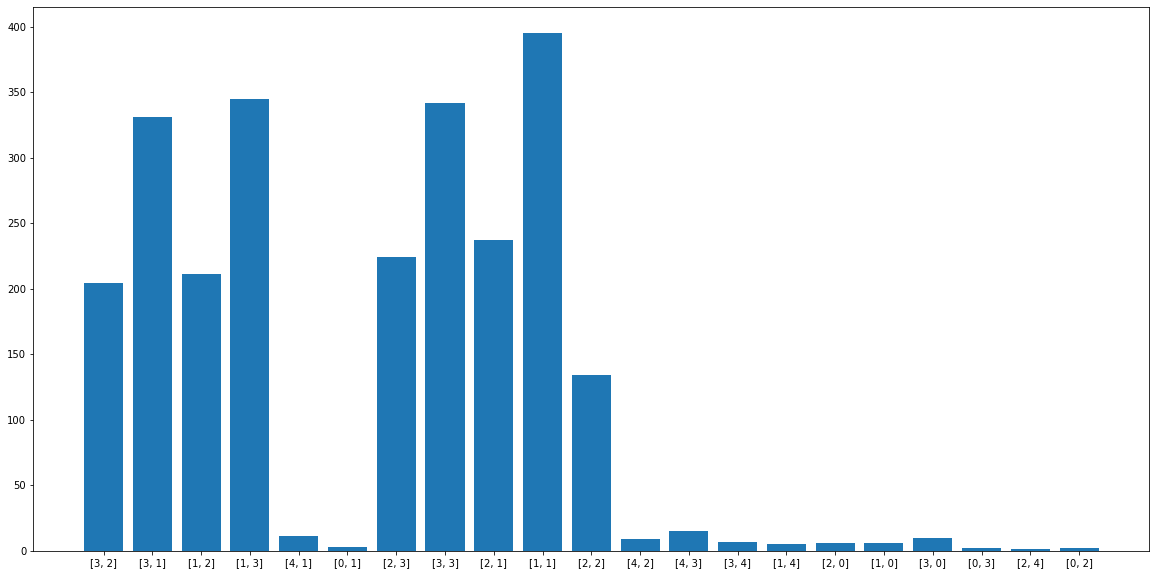

Processing Epoch 113
training start
Iteration 0, d real/fake loss 0.6040453910827637/0.6529520750045776 and g loss is 0.7429278492927551, NDiv loss 0.11388842761516571
Iteration 1, d real/fake loss 0.6040531992912292/0.6511757969856262 and g loss is 0.7423579692840576, NDiv loss 0.10830166935920715
Iteration 2, d real/fake loss 0.6040541529655457/0.6525709629058838 and g loss is 0.7398766279220581, NDiv loss 0.11300168931484222
Iteration 3, d real/fake loss 0.6040467023849487/0.6556983590126038 and g loss is 0.7403672337532043, NDiv loss 0.11223854124546051
Iteration 4, d real/fake loss 0.6040403842926025/0.6504105925559998 and g loss is 0.7450845241546631, NDiv loss 0.11548718065023422


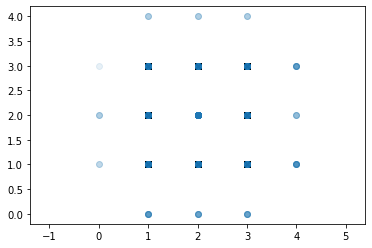

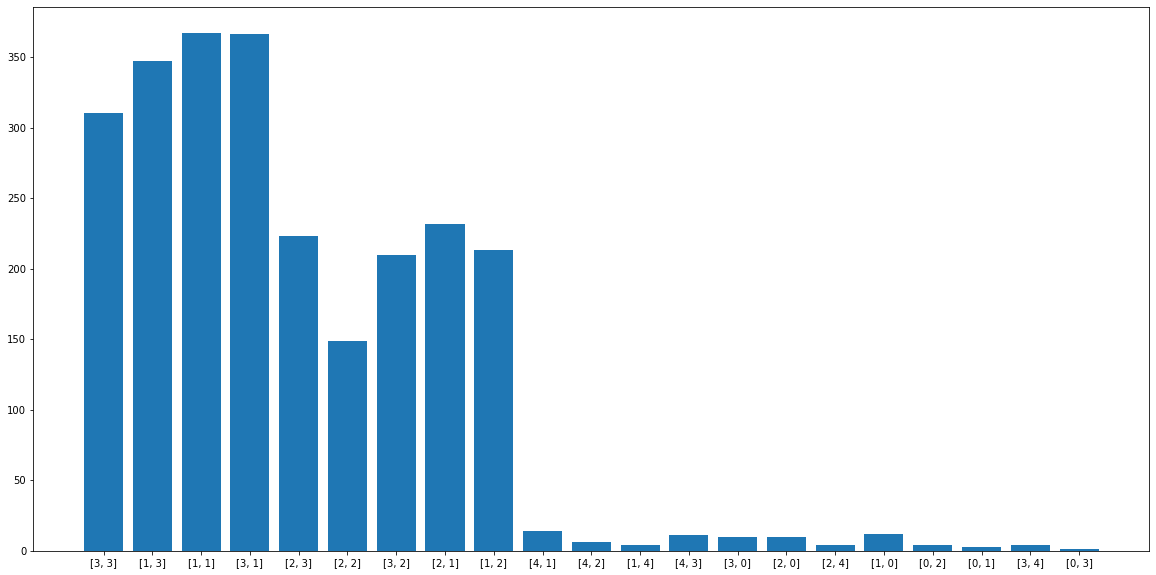

Processing Epoch 114
training start
Iteration 0, d real/fake loss 0.6063566207885742/0.6462935209274292 and g loss is 0.7392180562019348, NDiv loss 0.11139581352472305
Iteration 1, d real/fake loss 0.6063751578330994/0.648425817489624 and g loss is 0.7450079917907715, NDiv loss 0.11208882182836533
Iteration 2, d real/fake loss 0.6063821911811829/0.6529550552368164 and g loss is 0.7498055696487427, NDiv loss 0.11235501617193222
Iteration 3, d real/fake loss 0.606386661529541/0.6556702852249146 and g loss is 0.7429232597351074, NDiv loss 0.11715163290500641
Iteration 4, d real/fake loss 0.6063887476921082/0.6538087725639343 and g loss is 0.7412970066070557, NDiv loss 0.10851619392633438


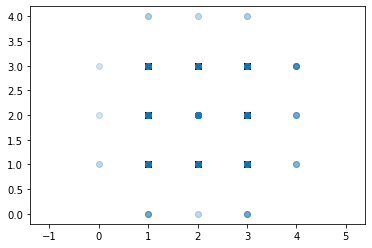

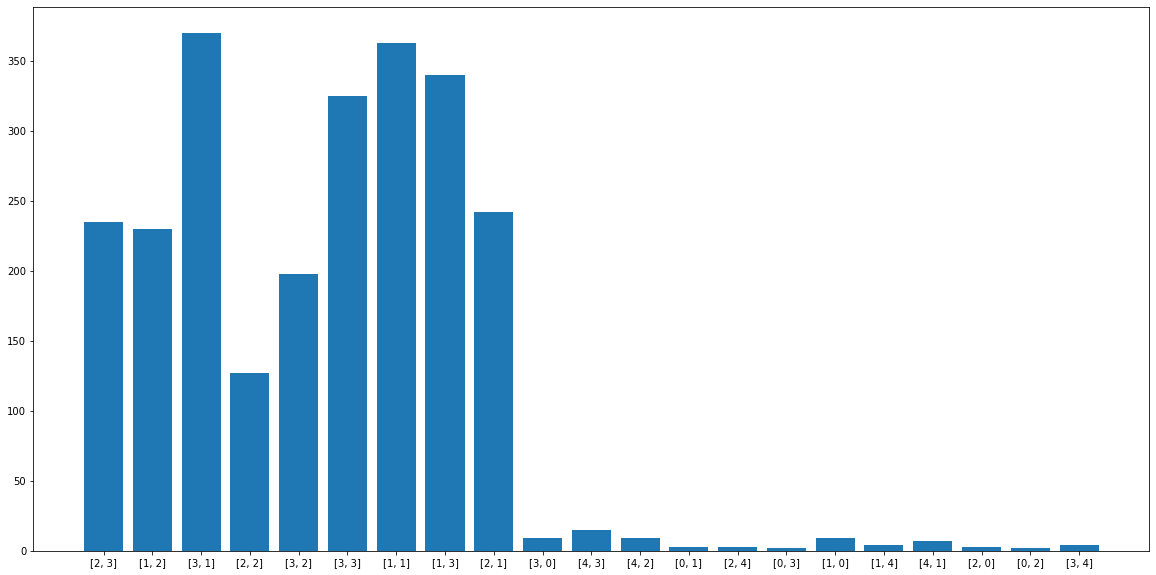

Processing Epoch 115
training start
Iteration 0, d real/fake loss 0.6047583818435669/0.6494079232215881 and g loss is 0.7499675750732422, NDiv loss 0.11419785767793655
Iteration 1, d real/fake loss 0.6047862768173218/0.6431805491447449 and g loss is 0.7491979598999023, NDiv loss 0.11276853829622269
Iteration 2, d real/fake loss 0.6047989130020142/0.655541181564331 and g loss is 0.7440506219863892, NDiv loss 0.11263587325811386
Iteration 3, d real/fake loss 0.604817807674408/0.6493185758590698 and g loss is 0.7399445176124573, NDiv loss 0.1150781586766243
Iteration 4, d real/fake loss 0.6048313975334167/0.650287389755249 and g loss is 0.7527080774307251, NDiv loss 0.11680854856967926


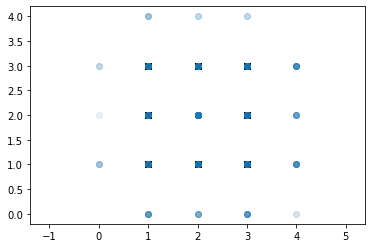

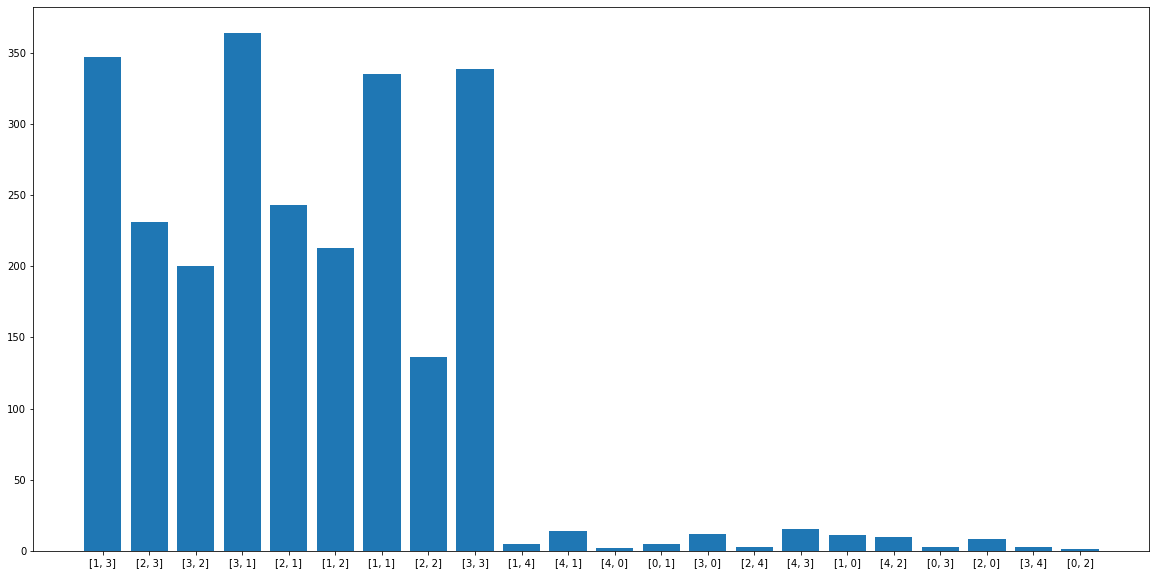

Processing Epoch 116
training start
Iteration 0, d real/fake loss 0.603062629699707/0.6442239284515381 and g loss is 0.7403922080993652, NDiv loss 0.11460226029157639
Iteration 1, d real/fake loss 0.6030591130256653/0.6573712825775146 and g loss is 0.7408742904663086, NDiv loss 0.11019186675548553
Iteration 2, d real/fake loss 0.6030585765838623/0.639771580696106 and g loss is 0.7475517392158508, NDiv loss 0.11504096537828445
Iteration 3, d real/fake loss 0.6030383706092834/0.6456806659698486 and g loss is 0.7500746250152588, NDiv loss 0.11531178653240204
Iteration 4, d real/fake loss 0.6030064225196838/0.6430509090423584 and g loss is 0.73710036277771, NDiv loss 0.12159828841686249


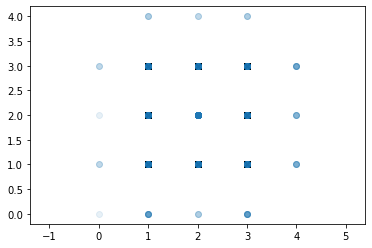

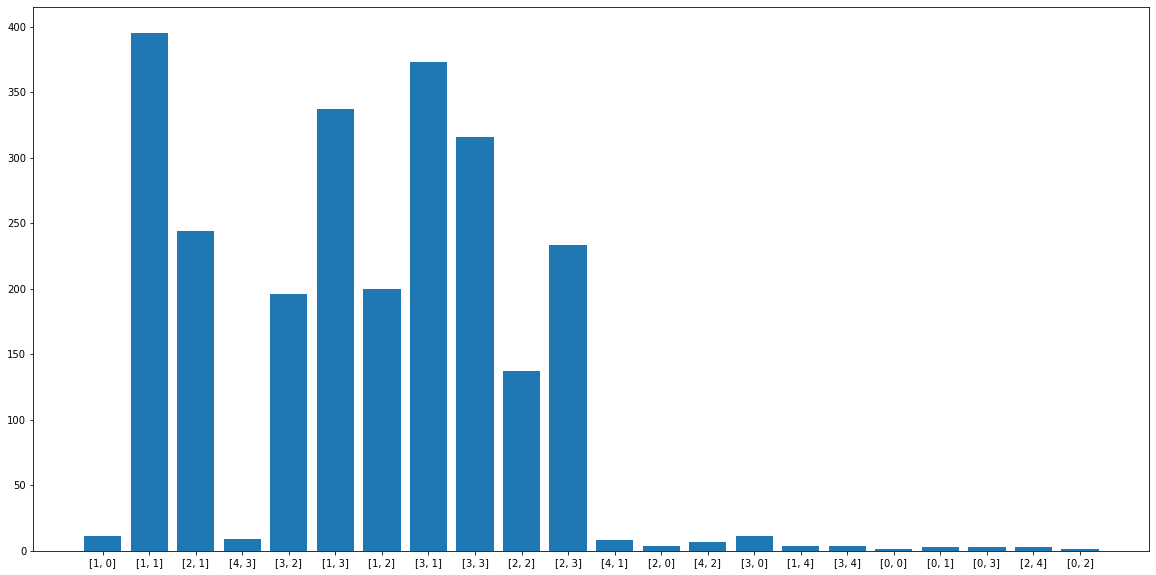

Processing Epoch 117
training start
Iteration 0, d real/fake loss 0.6052969694137573/0.6441603899002075 and g loss is 0.7449125051498413, NDiv loss 0.12510685622692108
Iteration 1, d real/fake loss 0.6052817702293396/0.6481476426124573 and g loss is 0.7379058599472046, NDiv loss 0.11790776252746582
Iteration 2, d real/fake loss 0.6052622199058533/0.6521047949790955 and g loss is 0.7473299503326416, NDiv loss 0.12338077276945114
Iteration 3, d real/fake loss 0.6052460074424744/0.6546149253845215 and g loss is 0.7311820983886719, NDiv loss 0.1172039806842804
Iteration 4, d real/fake loss 0.6052356362342834/0.637653648853302 and g loss is 0.7487846612930298, NDiv loss 0.11271888017654419


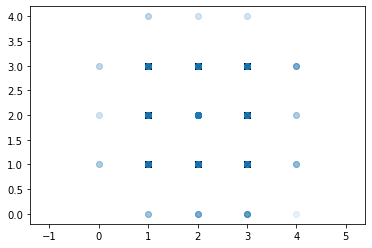

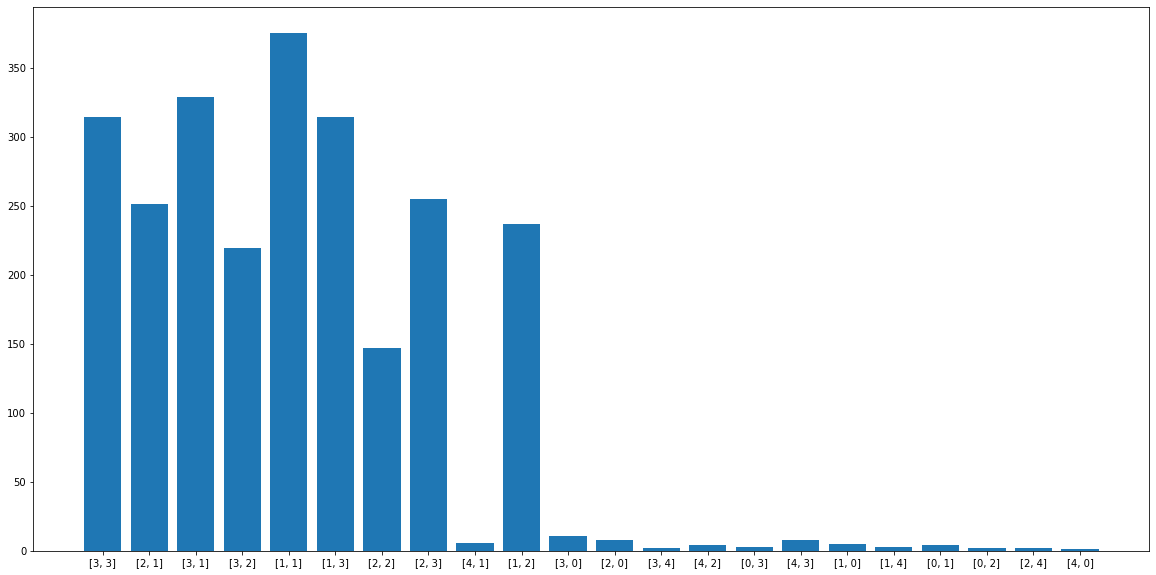

Processing Epoch 118
training start
Iteration 0, d real/fake loss 0.6036281585693359/0.6398316621780396 and g loss is 0.7439392805099487, NDiv loss 0.11546102911233902
Iteration 1, d real/fake loss 0.6036247611045837/0.6427576541900635 and g loss is 0.7478225231170654, NDiv loss 0.11517844349145889
Iteration 2, d real/fake loss 0.6036145687103271/0.637689471244812 and g loss is 0.7493914365768433, NDiv loss 0.11781561374664307
Iteration 3, d real/fake loss 0.6035975217819214/0.643837571144104 and g loss is 0.7436169385910034, NDiv loss 0.11498850584030151
Iteration 4, d real/fake loss 0.6035733819007874/0.6516803503036499 and g loss is 0.741604745388031, NDiv loss 0.10985293239355087


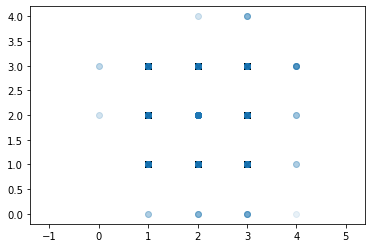

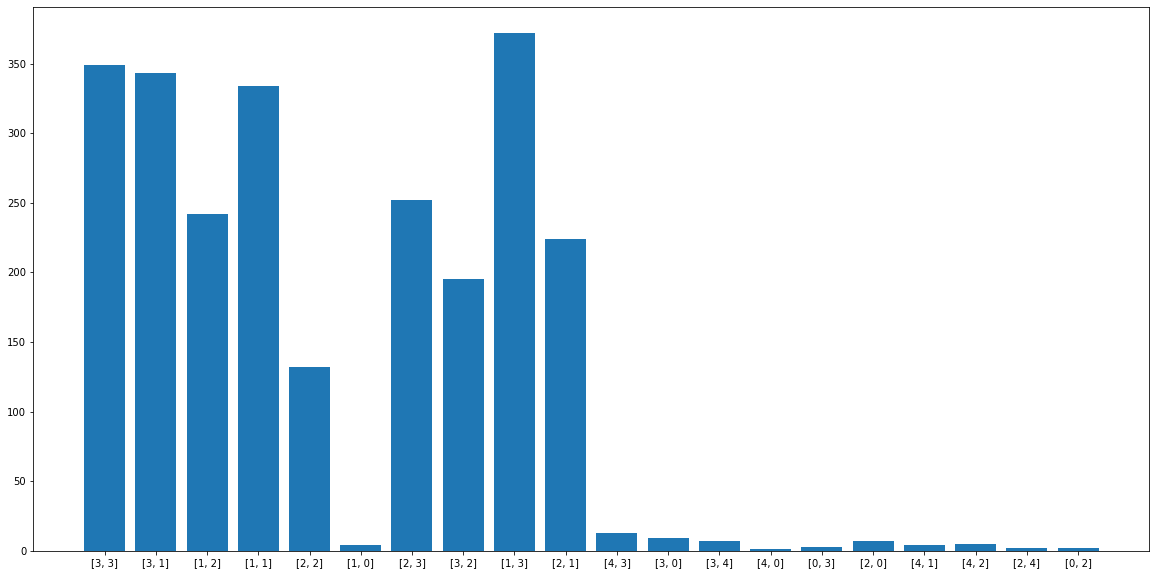

Processing Epoch 119
training start
Iteration 0, d real/fake loss 0.6053614616394043/0.6509956121444702 and g loss is 0.7435219287872314, NDiv loss 0.11725325882434845
Iteration 1, d real/fake loss 0.6053577661514282/0.6444135904312134 and g loss is 0.7472928166389465, NDiv loss 0.11900458484888077
Iteration 2, d real/fake loss 0.605340838432312/0.6599658131599426 and g loss is 0.737870454788208, NDiv loss 0.11451228708028793
Iteration 3, d real/fake loss 0.6053274869918823/0.6486425399780273 and g loss is 0.7511007785797119, NDiv loss 0.11788787692785263
Iteration 4, d real/fake loss 0.6052988767623901/0.6433768272399902 and g loss is 0.7464373111724854, NDiv loss 0.11781851202249527


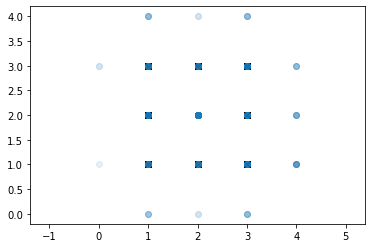

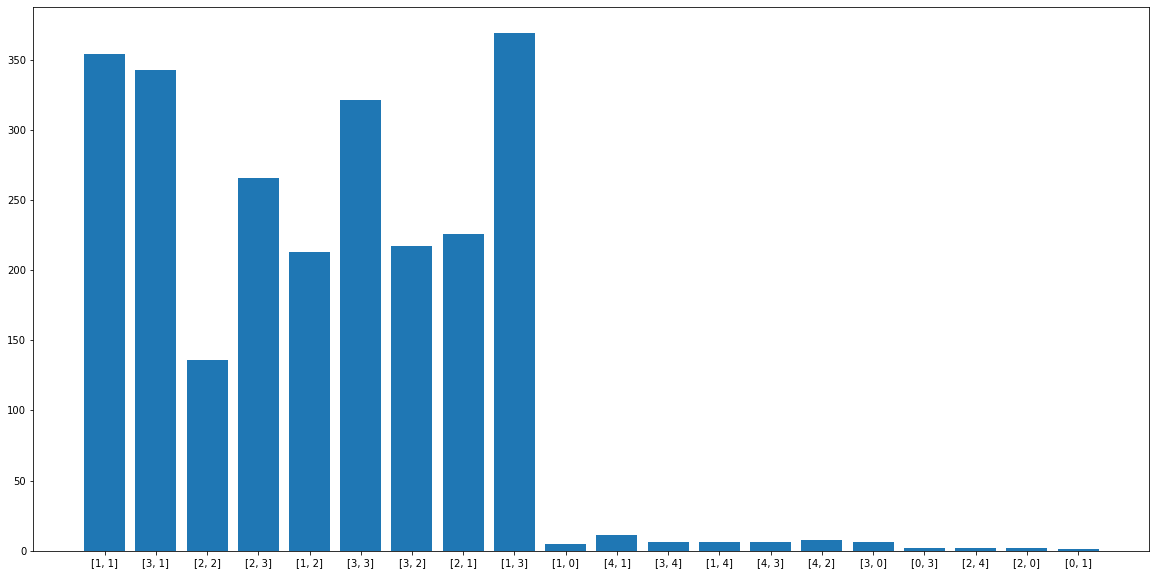

Processing Epoch 120
training start
Iteration 0, d real/fake loss 0.6058624386787415/0.6487107872962952 and g loss is 0.7423676252365112, NDiv loss 0.1146024614572525
Iteration 1, d real/fake loss 0.6058213710784912/0.6386827230453491 and g loss is 0.7498394846916199, NDiv loss 0.11646273732185364
Iteration 2, d real/fake loss 0.6057629585266113/0.649932861328125 and g loss is 0.7450001835823059, NDiv loss 0.11631004512310028
Iteration 3, d real/fake loss 0.605693519115448/0.6553711891174316 and g loss is 0.7492039203643799, NDiv loss 0.1198565810918808
Iteration 4, d real/fake loss 0.6056239008903503/0.6383032202720642 and g loss is 0.7580374479293823, NDiv loss 0.11414377391338348


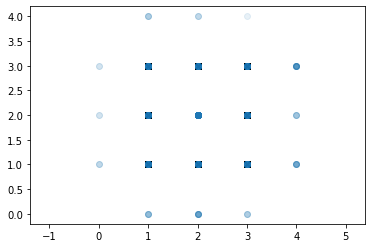

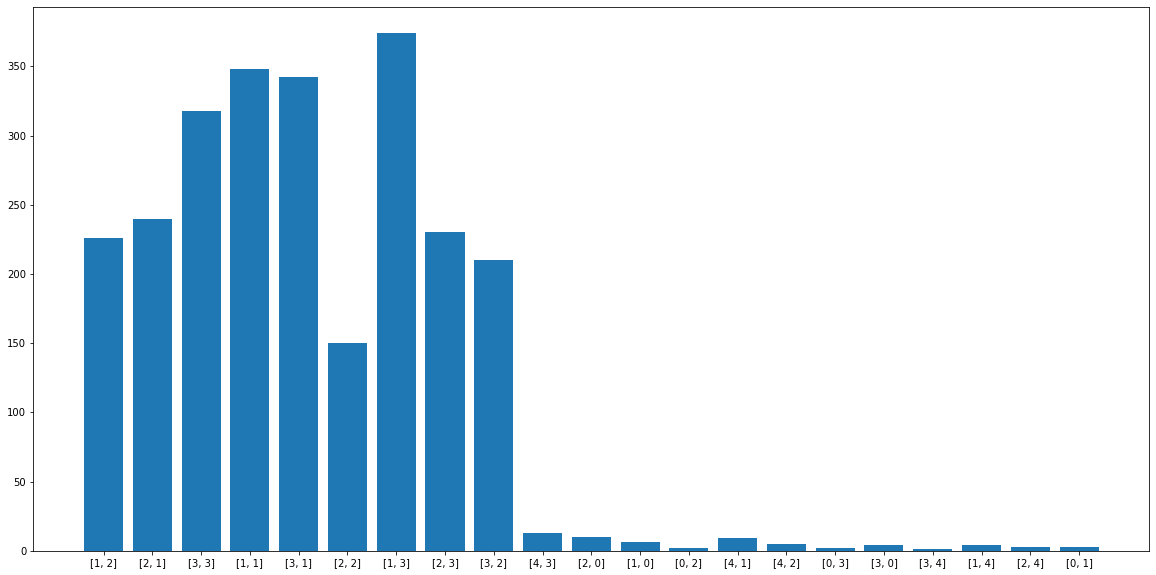

Processing Epoch 121
training start
Iteration 0, d real/fake loss 0.6048916578292847/0.6467781662940979 and g loss is 0.7389997243881226, NDiv loss 0.1157466396689415
Iteration 1, d real/fake loss 0.6048885583877563/0.6388821601867676 and g loss is 0.7453190684318542, NDiv loss 0.11333443224430084
Iteration 2, d real/fake loss 0.6048629283905029/0.6531990170478821 and g loss is 0.747535228729248, NDiv loss 0.11759206652641296
Iteration 3, d real/fake loss 0.6048415303230286/0.6447653770446777 and g loss is 0.7419487237930298, NDiv loss 0.11752045154571533
Iteration 4, d real/fake loss 0.6048095226287842/0.6346257925033569 and g loss is 0.7386066913604736, NDiv loss 0.11192508041858673


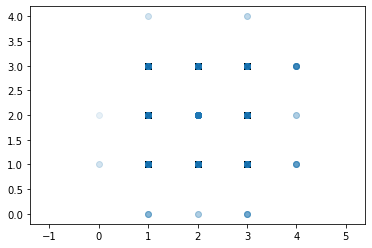

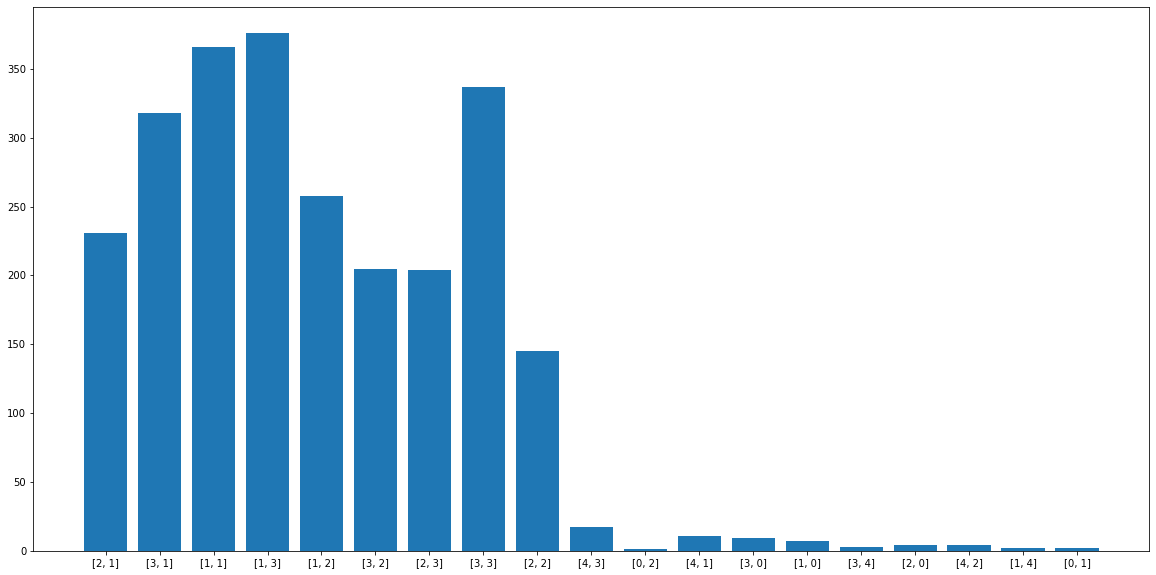

Processing Epoch 122
training start
Iteration 0, d real/fake loss 0.6064325571060181/0.6506208181381226 and g loss is 0.7459440231323242, NDiv loss 0.1131109967827797
Iteration 1, d real/fake loss 0.6063932180404663/0.650579035282135 and g loss is 0.7395496368408203, NDiv loss 0.11766864359378815
Iteration 2, d real/fake loss 0.6063518524169922/0.6458998918533325 and g loss is 0.7478504180908203, NDiv loss 0.11772217601537704
Iteration 3, d real/fake loss 0.6063059568405151/0.6468828916549683 and g loss is 0.7452258467674255, NDiv loss 0.11747795343399048
Iteration 4, d real/fake loss 0.6062619686126709/0.6463330984115601 and g loss is 0.7498396039009094, NDiv loss 0.1230669617652893


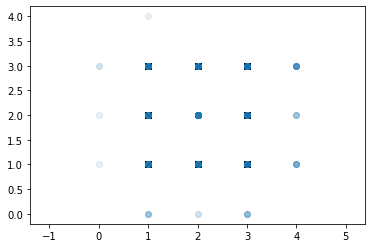

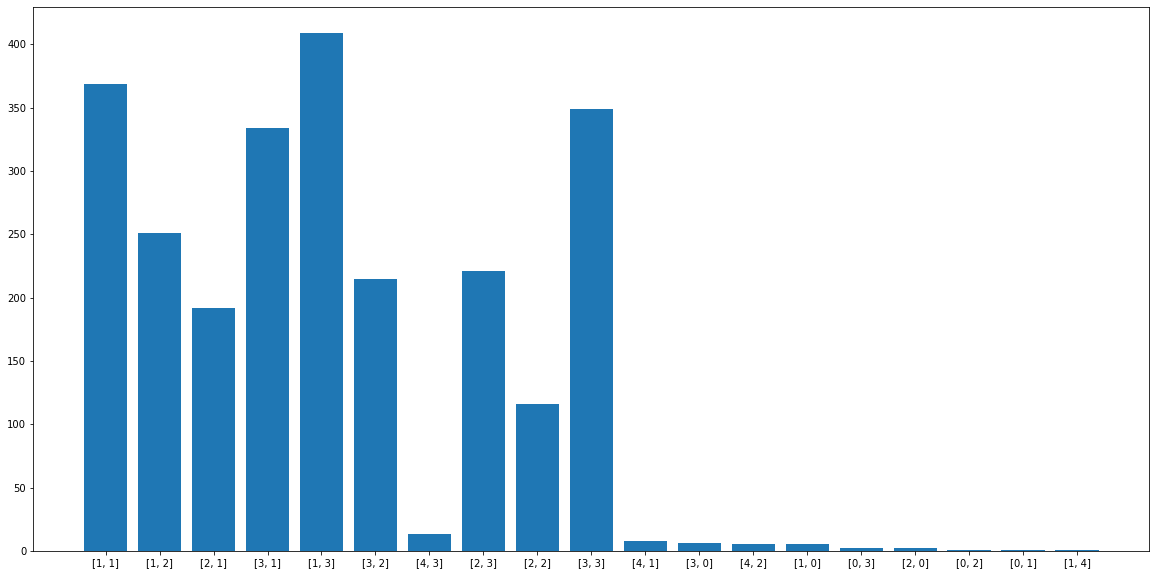

Processing Epoch 123
training start
Iteration 0, d real/fake loss 0.603692889213562/0.6441293954849243 and g loss is 0.7414172291755676, NDiv loss 0.11418404430150986
Iteration 1, d real/fake loss 0.6037040948867798/0.6418994665145874 and g loss is 0.7495163679122925, NDiv loss 0.11352864652872086
Iteration 2, d real/fake loss 0.603705883026123/0.6550318002700806 and g loss is 0.7448173761367798, NDiv loss 0.1138346940279007
Iteration 3, d real/fake loss 0.6037176847457886/0.6469447016716003 and g loss is 0.7452112436294556, NDiv loss 0.11308347433805466
Iteration 4, d real/fake loss 0.6037236452102661/0.6409662961959839 and g loss is 0.7439123392105103, NDiv loss 0.11366802453994751


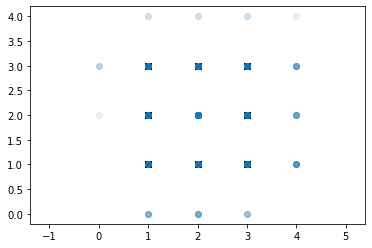

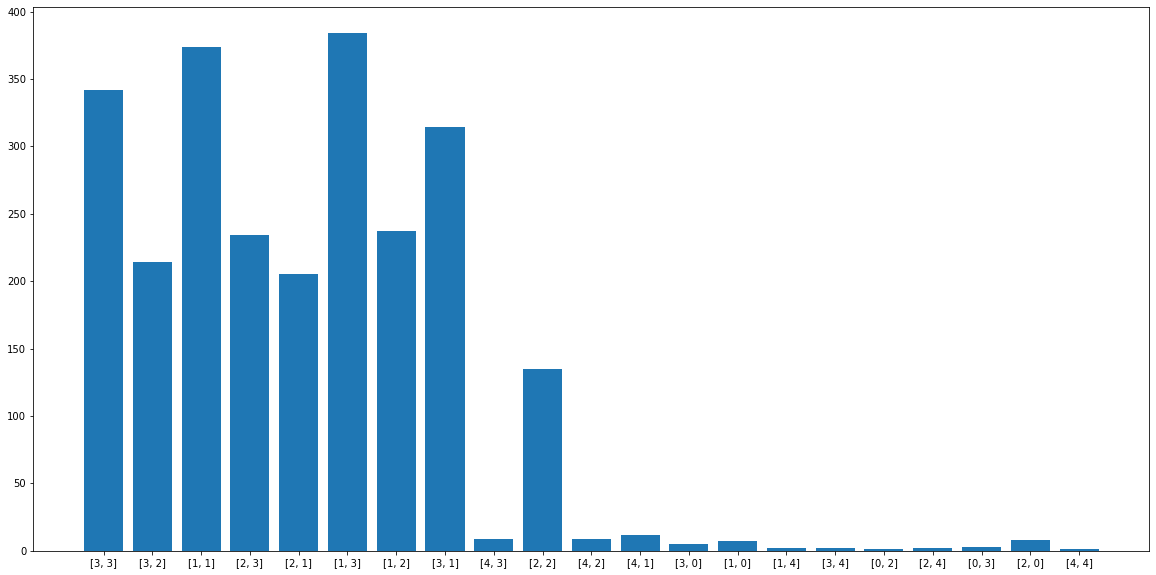

Processing Epoch 124
training start
Iteration 0, d real/fake loss 0.6055284738540649/0.642448902130127 and g loss is 0.7513018250465393, NDiv loss 0.11228293925523758
Iteration 1, d real/fake loss 0.6054901480674744/0.6492816805839539 and g loss is 0.7493085861206055, NDiv loss 0.1150728389620781
Iteration 2, d real/fake loss 0.6054231524467468/0.6451937556266785 and g loss is 0.7448951005935669, NDiv loss 0.11841317266225815
Iteration 3, d real/fake loss 0.605336606502533/0.63920658826828 and g loss is 0.7507367730140686, NDiv loss 0.11997866630554199
Iteration 4, d real/fake loss 0.6052259802818298/0.6421892046928406 and g loss is 0.758918046951294, NDiv loss 0.11629624664783478


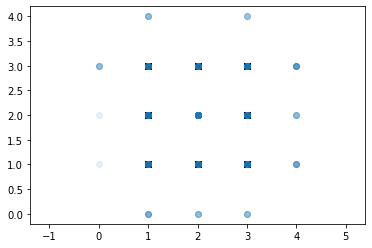

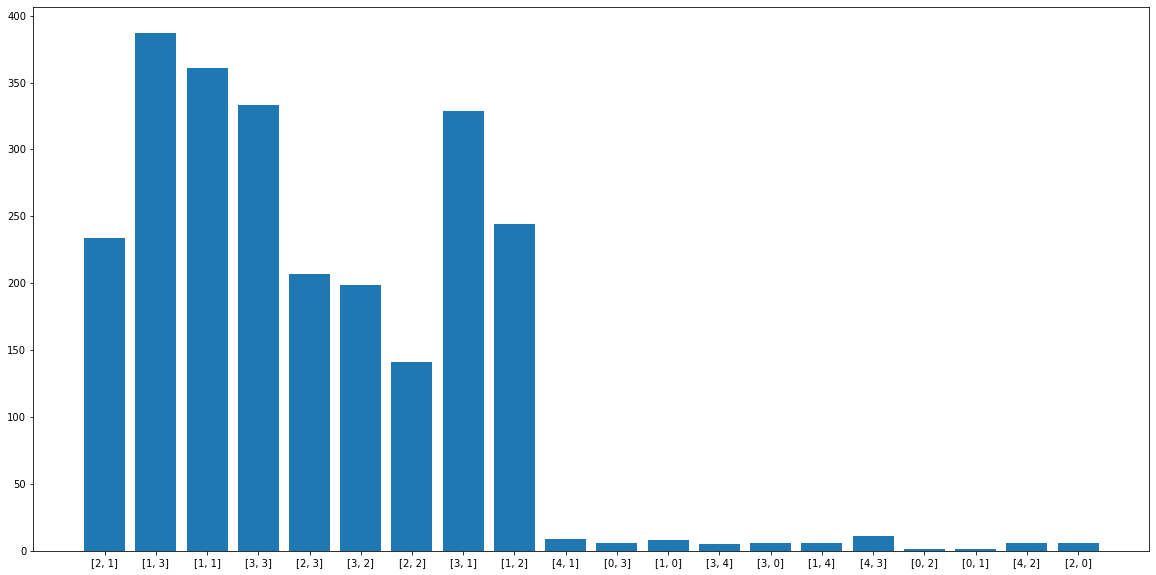

Processing Epoch 125
training start
Iteration 0, d real/fake loss 0.6061784029006958/0.6504229307174683 and g loss is 0.750816822052002, NDiv loss 0.1149713322520256
Iteration 1, d real/fake loss 0.6060807704925537/0.6530044078826904 and g loss is 0.7620102167129517, NDiv loss 0.11829409748315811
Iteration 2, d real/fake loss 0.605993390083313/0.6444863677024841 and g loss is 0.7521078586578369, NDiv loss 0.11769434064626694
Iteration 3, d real/fake loss 0.6058992147445679/0.6408506631851196 and g loss is 0.7429689168930054, NDiv loss 0.11969907581806183
Iteration 4, d real/fake loss 0.6057853698730469/0.6403613090515137 and g loss is 0.7517595291137695, NDiv loss 0.12052290886640549


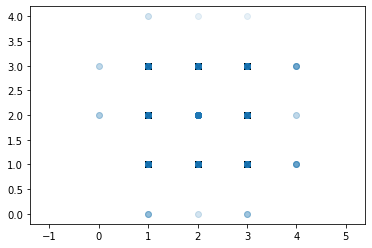

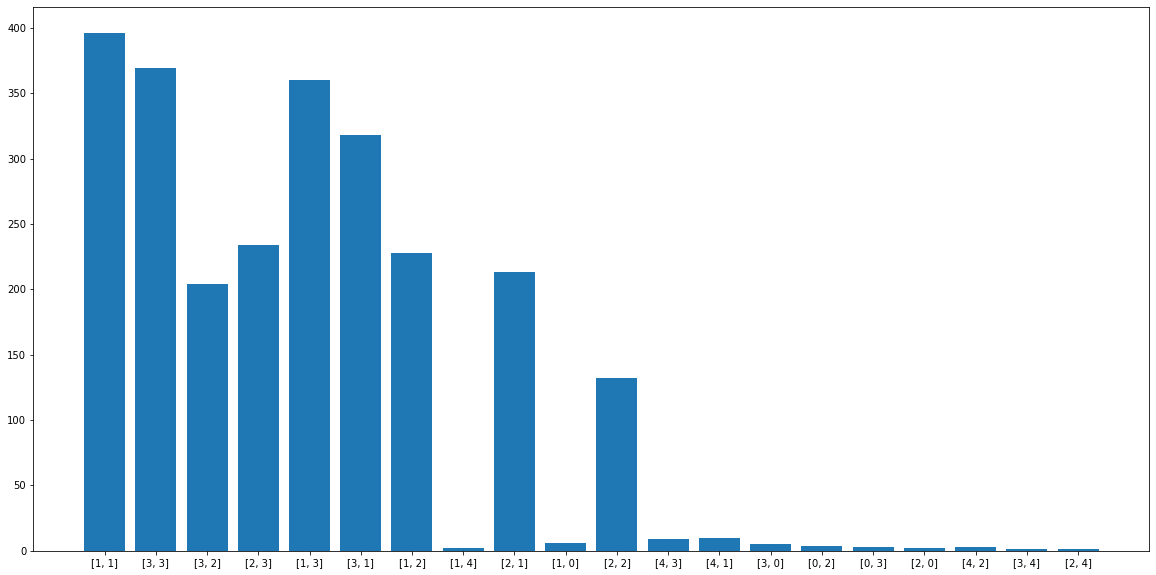

Processing Epoch 126
training start
Iteration 0, d real/fake loss 0.603634238243103/0.6361525654792786 and g loss is 0.7587761878967285, NDiv loss 0.11943656206130981
Iteration 1, d real/fake loss 0.6035376191139221/0.6484118103981018 and g loss is 0.7509320974349976, NDiv loss 0.11495461314916611
Iteration 2, d real/fake loss 0.603448748588562/0.6412063837051392 and g loss is 0.7412444949150085, NDiv loss 0.11811711639165878
Iteration 3, d real/fake loss 0.6033569574356079/0.6345473527908325 and g loss is 0.7531664967536926, NDiv loss 0.11783109605312347
Iteration 4, d real/fake loss 0.6032590866088867/0.6359521746635437 and g loss is 0.7483717203140259, NDiv loss 0.12635347247123718


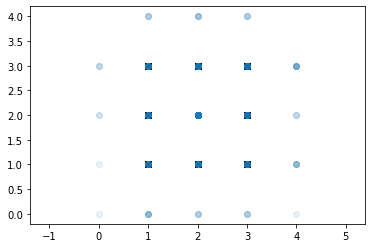

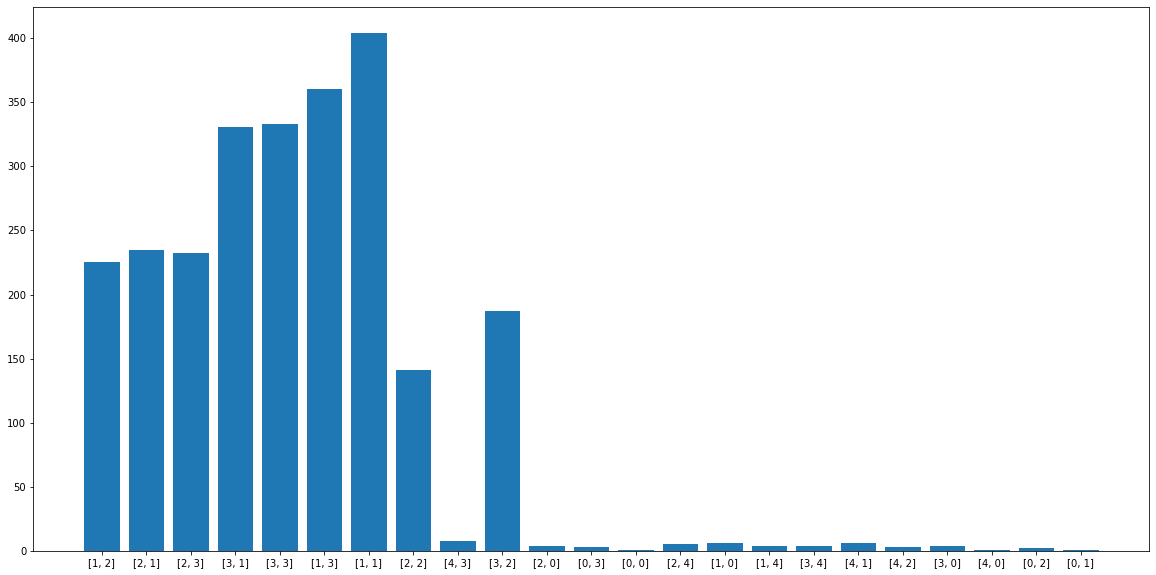

Processing Epoch 127
training start
Iteration 0, d real/fake loss 0.6050530076026917/0.6424556970596313 and g loss is 0.7577930688858032, NDiv loss 0.11545710265636444
Iteration 1, d real/fake loss 0.6049878001213074/0.6403096914291382 and g loss is 0.7463127374649048, NDiv loss 0.12333837896585464
Iteration 2, d real/fake loss 0.6048951148986816/0.6531333327293396 and g loss is 0.7577758431434631, NDiv loss 0.12024042755365372
Iteration 3, d real/fake loss 0.6048033237457275/0.6457362771034241 and g loss is 0.7422807812690735, NDiv loss 0.11851764470338821
Iteration 4, d real/fake loss 0.6047050952911377/0.6418575048446655 and g loss is 0.7496359944343567, NDiv loss 0.11919737607240677


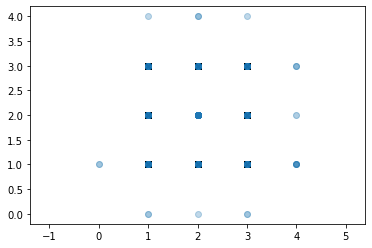

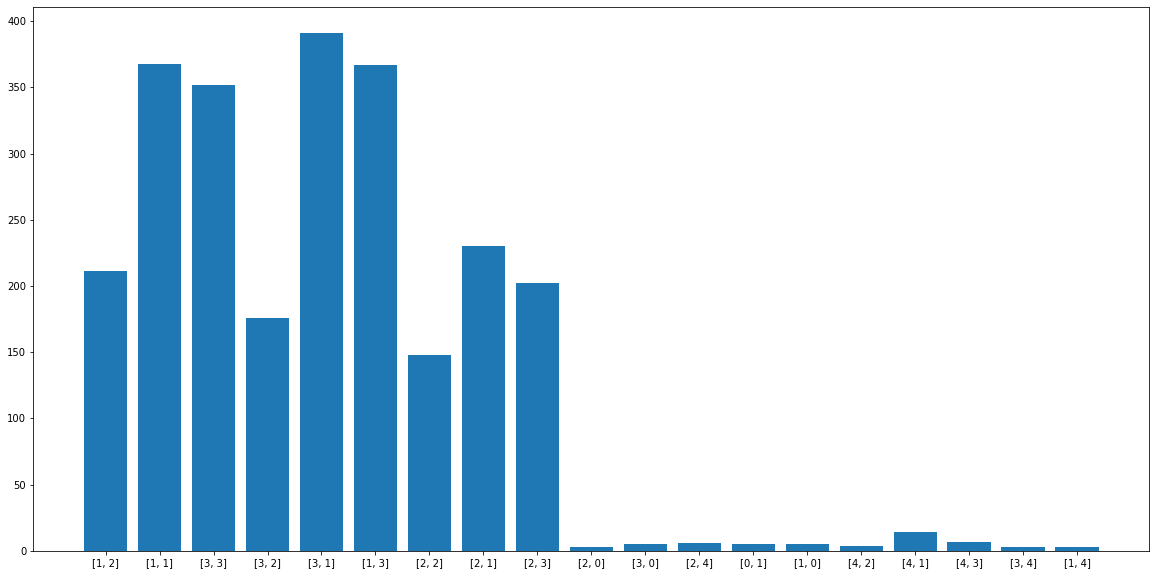

Processing Epoch 128
training start
Iteration 0, d real/fake loss 0.6033698320388794/0.640110969543457 and g loss is 0.75739586353302, NDiv loss 0.11369328945875168
Iteration 1, d real/fake loss 0.6032978296279907/0.6369163990020752 and g loss is 0.7635035514831543, NDiv loss 0.11692491918802261
Iteration 2, d real/fake loss 0.6032004356384277/0.6451357007026672 and g loss is 0.7500935792922974, NDiv loss 0.12440986931324005
Iteration 3, d real/fake loss 0.6030933260917664/0.6461724042892456 and g loss is 0.7527972459793091, NDiv loss 0.11848253756761551
Iteration 4, d real/fake loss 0.602986752986908/0.6412854194641113 and g loss is 0.758287250995636, NDiv loss 0.12148591876029968


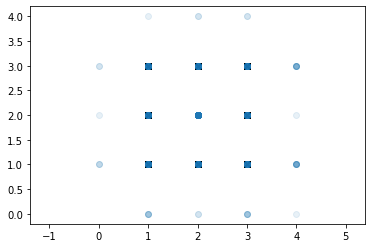

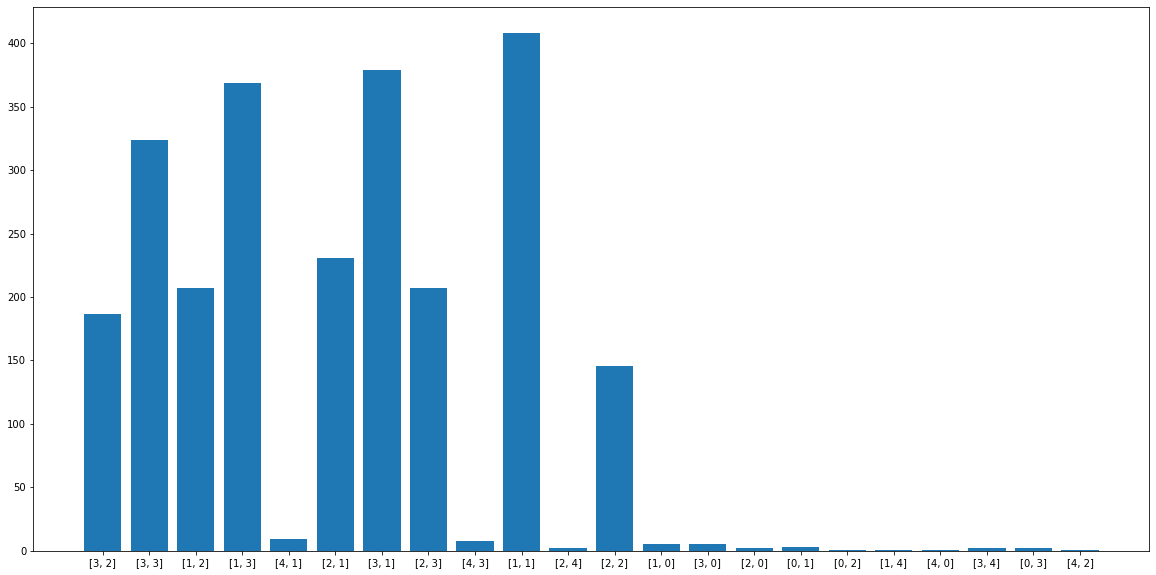

Processing Epoch 129
training start
Iteration 0, d real/fake loss 0.60251784324646/0.6317787170410156 and g loss is 0.7494948506355286, NDiv loss 0.11442921310663223
Iteration 1, d real/fake loss 0.6024461984634399/0.6379371881484985 and g loss is 0.7394995093345642, NDiv loss 0.12413053214550018
Iteration 2, d real/fake loss 0.602375864982605/0.640782356262207 and g loss is 0.743911862373352, NDiv loss 0.11788361519575119
Iteration 3, d real/fake loss 0.6023052930831909/0.6469660401344299 and g loss is 0.763718843460083, NDiv loss 0.11618606746196747
Iteration 4, d real/fake loss 0.6022440195083618/0.6472546458244324 and g loss is 0.7557550668716431, NDiv loss 0.12231861054897308


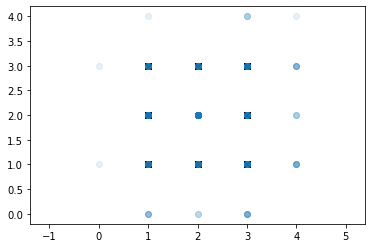

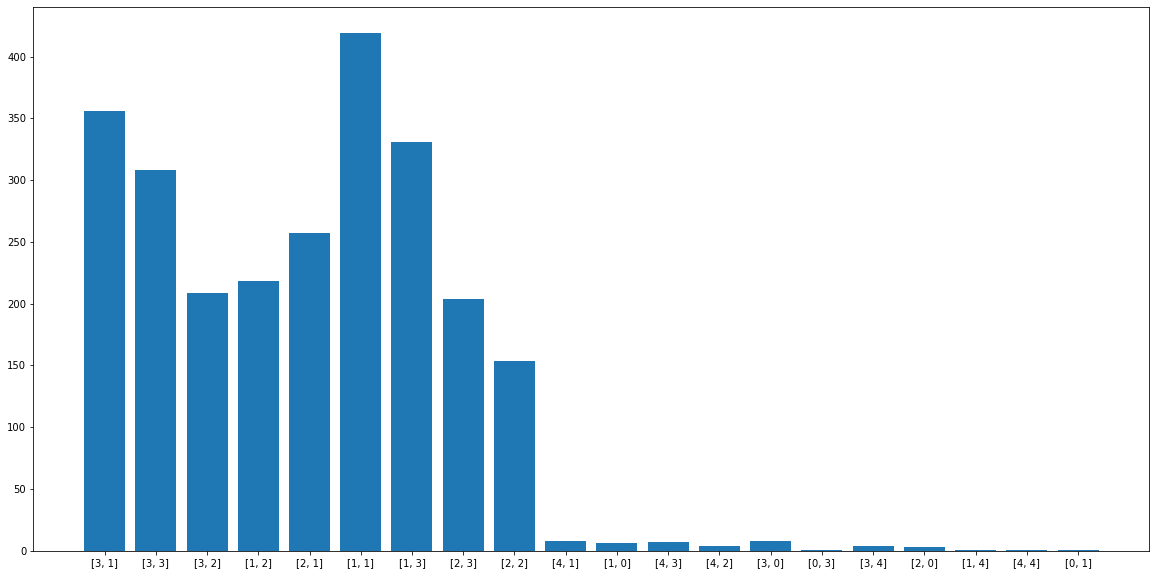

Processing Epoch 130
training start
Iteration 0, d real/fake loss 0.603042483329773/0.6473966240882874 and g loss is 0.7529565095901489, NDiv loss 0.11706583946943283
Iteration 1, d real/fake loss 0.6029819250106812/0.6439990401268005 and g loss is 0.7472846508026123, NDiv loss 0.12205373495817184
Iteration 2, d real/fake loss 0.602910578250885/0.6431187987327576 and g loss is 0.7434212565422058, NDiv loss 0.1170283779501915
Iteration 3, d real/fake loss 0.6028472185134888/0.6418439745903015 and g loss is 0.749466598033905, NDiv loss 0.12138119339942932
Iteration 4, d real/fake loss 0.6027759313583374/0.6420073509216309 and g loss is 0.759639322757721, NDiv loss 0.11770156025886536


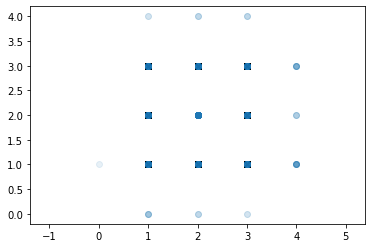

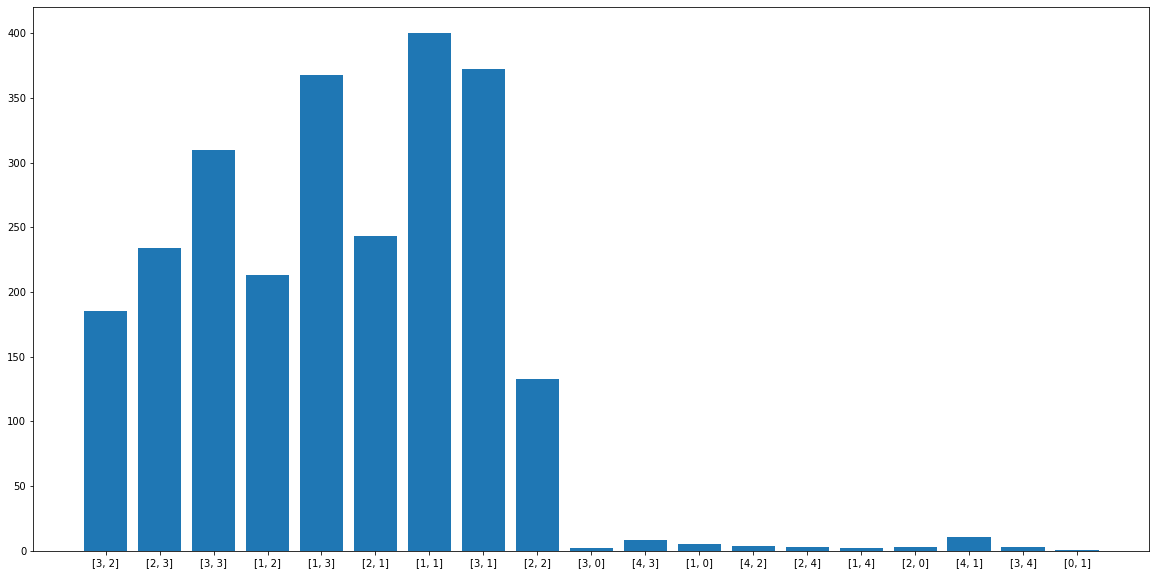

Processing Epoch 131
training start
Iteration 0, d real/fake loss 0.602774977684021/0.6396623849868774 and g loss is 0.7554603815078735, NDiv loss 0.11027657240629196
Iteration 1, d real/fake loss 0.6027287840843201/0.6378176212310791 and g loss is 0.7565150856971741, NDiv loss 0.12069391459226608
Iteration 2, d real/fake loss 0.6026716828346252/0.6401665806770325 and g loss is 0.760699450969696, NDiv loss 0.11689543724060059
Iteration 3, d real/fake loss 0.6026136875152588/0.6400993466377258 and g loss is 0.7586151957511902, NDiv loss 0.12337350845336914
Iteration 4, d real/fake loss 0.6025490164756775/0.6360055804252625 and g loss is 0.759845495223999, NDiv loss 0.11985718458890915


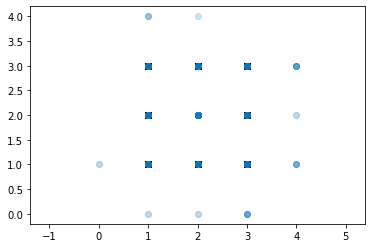

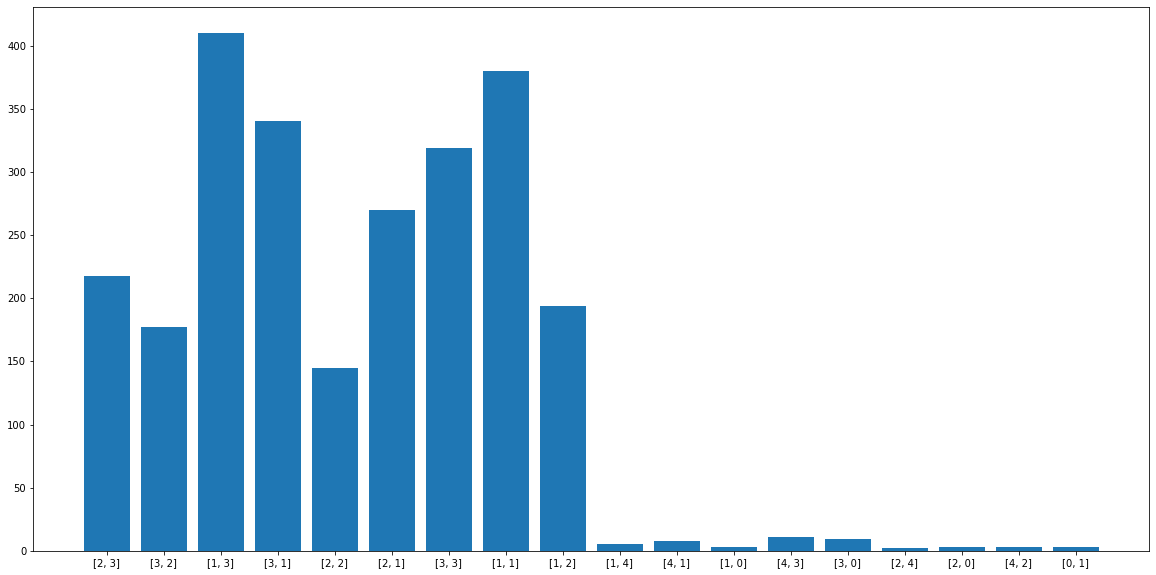

Processing Epoch 132
training start
Iteration 0, d real/fake loss 0.6018309593200684/0.6334172487258911 and g loss is 0.74488765001297, NDiv loss 0.11636325716972351
Iteration 1, d real/fake loss 0.6017745137214661/0.6418054699897766 and g loss is 0.7445788383483887, NDiv loss 0.11989374458789825
Iteration 2, d real/fake loss 0.6017251014709473/0.6406818628311157 and g loss is 0.7384685277938843, NDiv loss 0.11702112853527069
Iteration 3, d real/fake loss 0.6016807556152344/0.6338502168655396 and g loss is 0.7598599195480347, NDiv loss 0.12005101144313812
Iteration 4, d real/fake loss 0.60163414478302/0.6268296837806702 and g loss is 0.7512628436088562, NDiv loss 0.11597161740064621


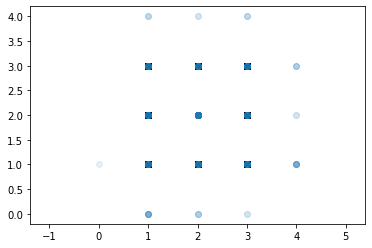

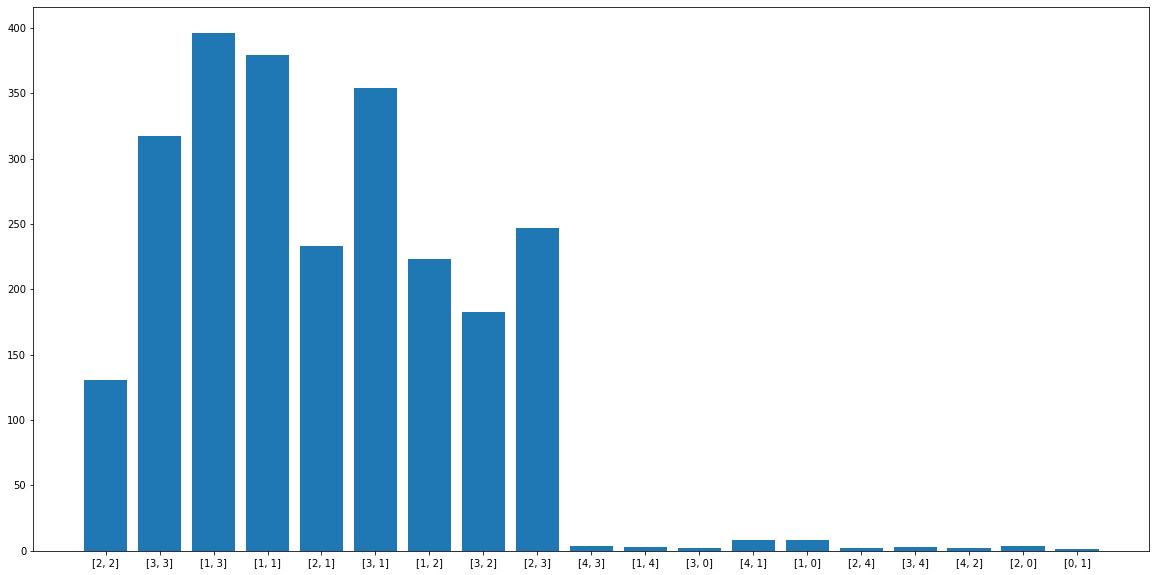

Processing Epoch 133
training start
Iteration 0, d real/fake loss 0.6022279262542725/0.6373559832572937 and g loss is 0.7477839589118958, NDiv loss 0.11558470875024796
Iteration 1, d real/fake loss 0.6021719574928284/0.6440508365631104 and g loss is 0.7545371055603027, NDiv loss 0.11931537091732025
Iteration 2, d real/fake loss 0.6021182537078857/0.644573450088501 and g loss is 0.7621722221374512, NDiv loss 0.12015151232481003
Iteration 3, d real/fake loss 0.6020641326904297/0.6365792751312256 and g loss is 0.74879390001297, NDiv loss 0.11913421005010605
Iteration 4, d real/fake loss 0.6020021438598633/0.6326178312301636 and g loss is 0.7609843015670776, NDiv loss 0.1166583001613617


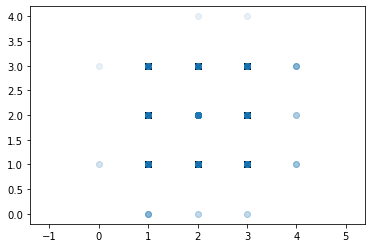

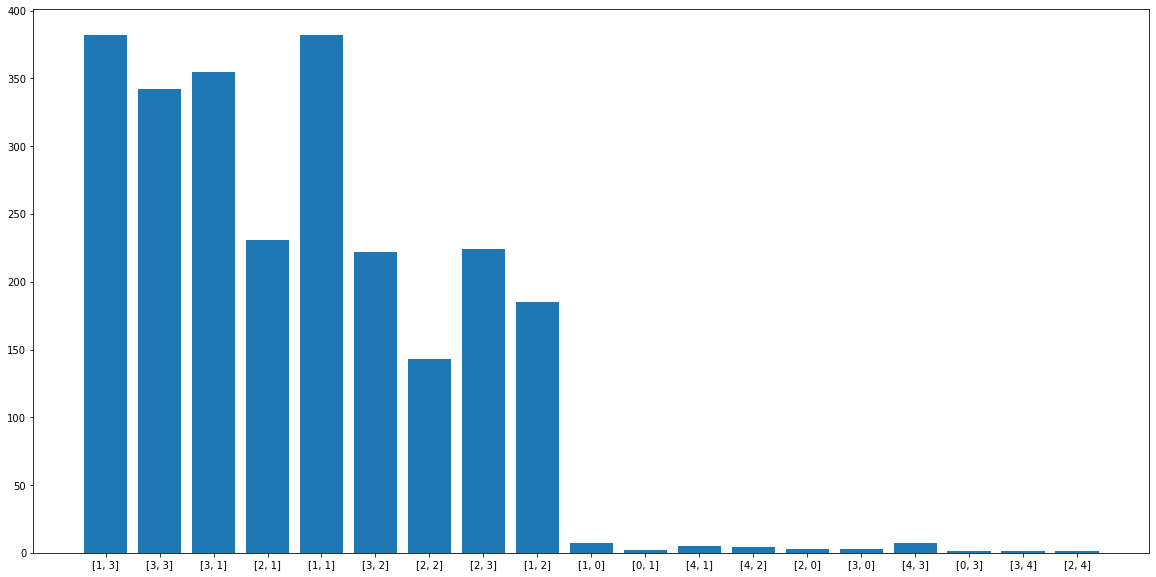

Processing Epoch 134
training start
Iteration 0, d real/fake loss 0.6026414632797241/0.6348915696144104 and g loss is 0.7546331882476807, NDiv loss 0.1244119182229042
Iteration 1, d real/fake loss 0.6025574803352356/0.6422819495201111 and g loss is 0.7651748657226562, NDiv loss 0.12043154984712601
Iteration 2, d real/fake loss 0.602461576461792/0.6449621319770813 and g loss is 0.7491180896759033, NDiv loss 0.11433958262205124
Iteration 3, d real/fake loss 0.6023586988449097/0.6389236450195312 and g loss is 0.7498936653137207, NDiv loss 0.11483393609523773
Iteration 4, d real/fake loss 0.6022316217422485/0.6432077288627625 and g loss is 0.7581814527511597, NDiv loss 0.1228480264544487


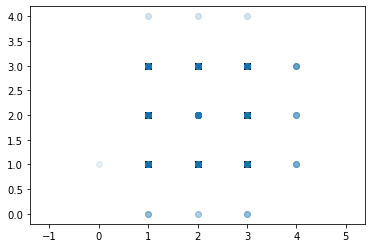

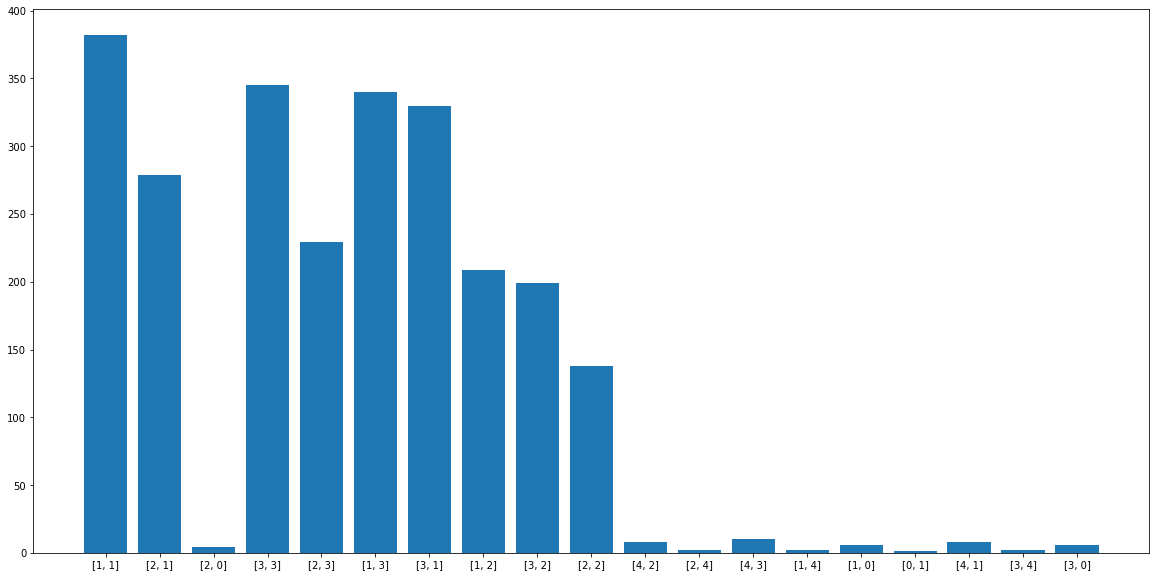

Processing Epoch 135
training start
Iteration 0, d real/fake loss 0.6010870337486267/0.6280248165130615 and g loss is 0.7488373517990112, NDiv loss 0.11396829783916473
Iteration 1, d real/fake loss 0.6009753942489624/0.6298248767852783 and g loss is 0.7582515478134155, NDiv loss 0.11726688593626022
Iteration 2, d real/fake loss 0.6008546352386475/0.6307319402694702 and g loss is 0.7540503144264221, NDiv loss 0.11840716749429703
Iteration 3, d real/fake loss 0.6007335186004639/0.6379504799842834 and g loss is 0.7566026449203491, NDiv loss 0.1245570033788681
Iteration 4, d real/fake loss 0.6006158590316772/0.6378083825111389 and g loss is 0.756079912185669, NDiv loss 0.12115182727575302


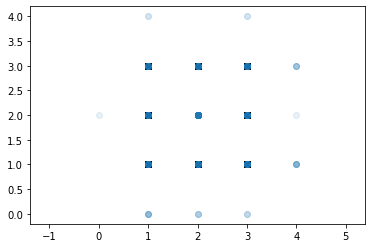

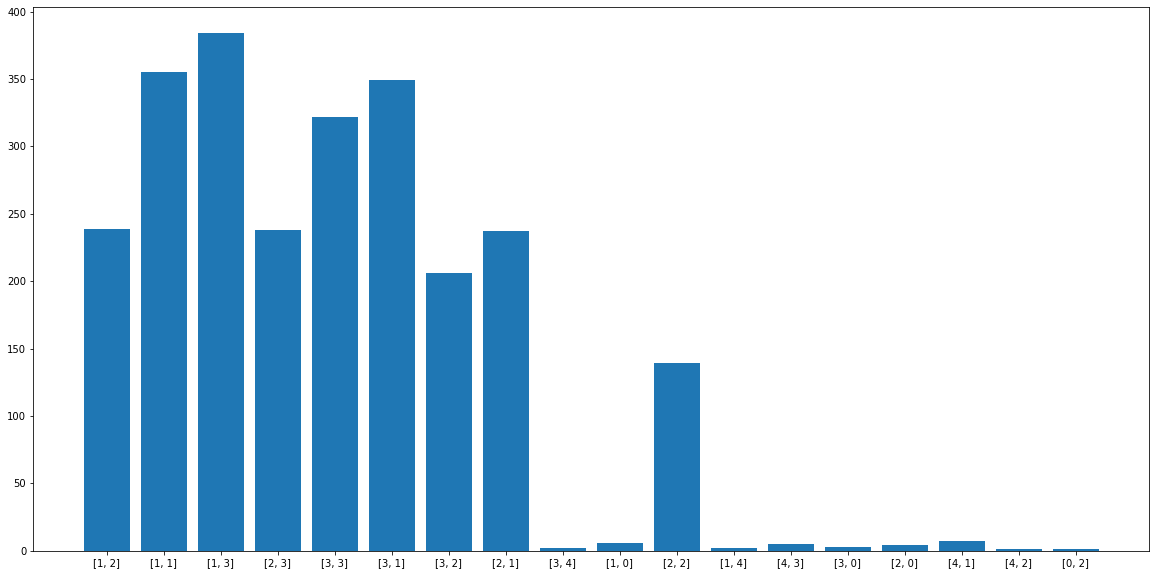

Processing Epoch 136
training start
Iteration 0, d real/fake loss 0.598526120185852/0.632361114025116 and g loss is 0.7542325258255005, NDiv loss 0.11578023433685303
Iteration 1, d real/fake loss 0.5984198451042175/0.6414756774902344 and g loss is 0.7555135488510132, NDiv loss 0.11891869455575943
Iteration 2, d real/fake loss 0.5983145833015442/0.6455076336860657 and g loss is 0.7656912207603455, NDiv loss 0.12192948907613754
Iteration 3, d real/fake loss 0.5982161164283752/0.6312278509140015 and g loss is 0.7566872835159302, NDiv loss 0.11851178109645844
Iteration 4, d real/fake loss 0.5981049537658691/0.6328458786010742 and g loss is 0.7523484230041504, NDiv loss 0.11604294925928116


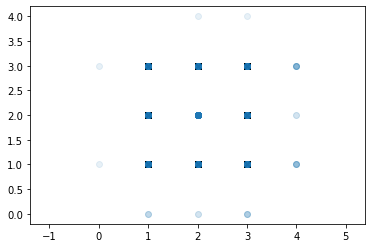

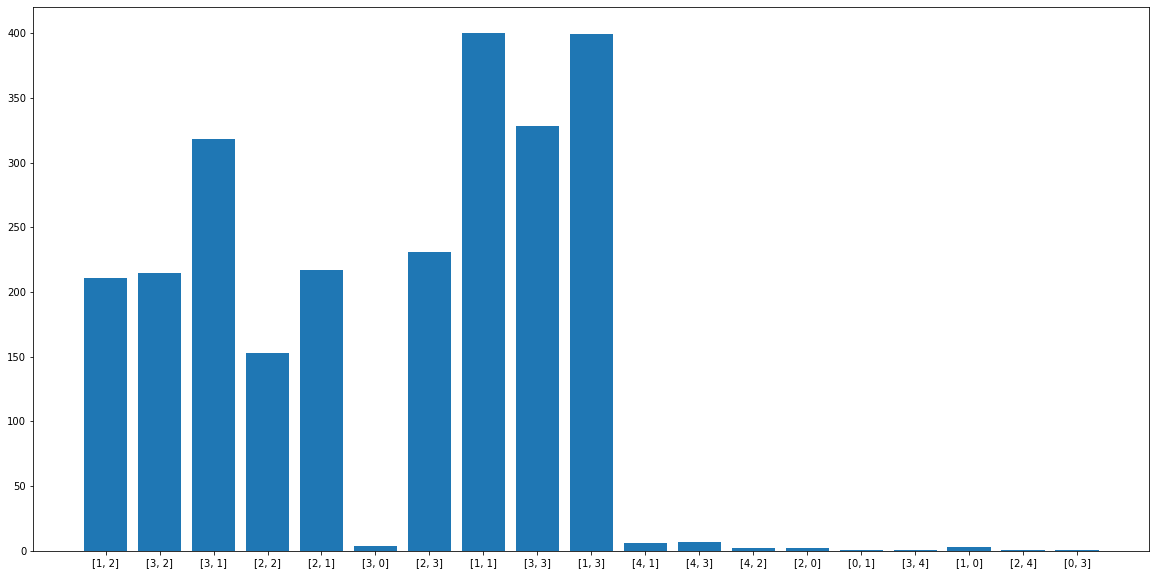

Processing Epoch 137
training start
Iteration 0, d real/fake loss 0.6015268564224243/0.6299608945846558 and g loss is 0.7580487132072449, NDiv loss 0.12074368447065353
Iteration 1, d real/fake loss 0.6014423966407776/0.640204906463623 and g loss is 0.7518829107284546, NDiv loss 0.1176672875881195
Iteration 2, d real/fake loss 0.6013423800468445/0.631304919719696 and g loss is 0.7503220438957214, NDiv loss 0.12282191962003708
Iteration 3, d real/fake loss 0.6012147665023804/0.6381043195724487 and g loss is 0.761899471282959, NDiv loss 0.11947719007730484
Iteration 4, d real/fake loss 0.6010755300521851/0.6355149745941162 and g loss is 0.7629106640815735, NDiv loss 0.11738583445549011


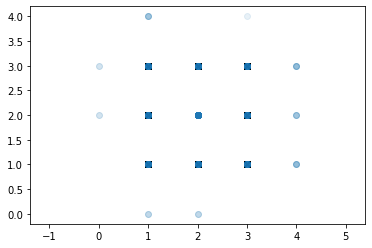

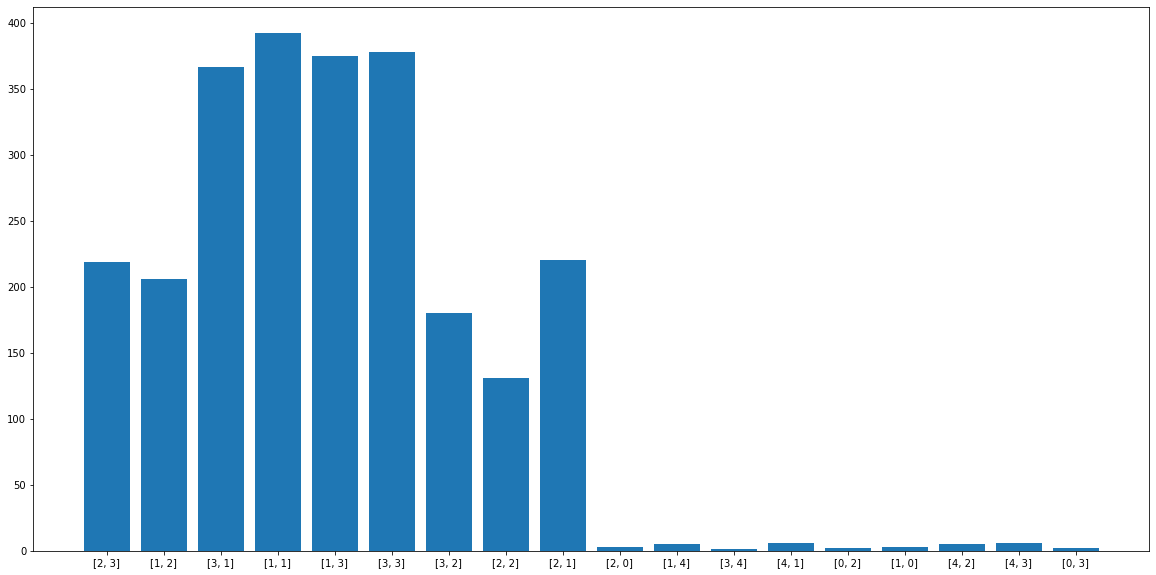

Processing Epoch 138
training start
Iteration 0, d real/fake loss 0.6012108325958252/0.6376199722290039 and g loss is 0.7581126689910889, NDiv loss 0.11083687096834183
Iteration 1, d real/fake loss 0.6010411977767944/0.6299410462379456 and g loss is 0.7531110644340515, NDiv loss 0.11988942325115204
Iteration 2, d real/fake loss 0.6008516550064087/0.6335811018943787 and g loss is 0.7575975656509399, NDiv loss 0.12527482211589813
Iteration 3, d real/fake loss 0.6006490588188171/0.6374261379241943 and g loss is 0.7613545060157776, NDiv loss 0.11788018047809601
Iteration 4, d real/fake loss 0.6004424095153809/0.6412076950073242 and g loss is 0.7613229155540466, NDiv loss 0.12081917375326157


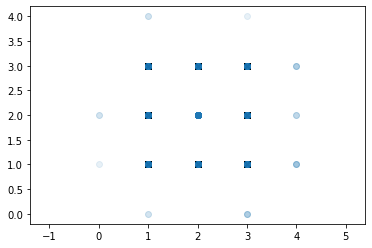

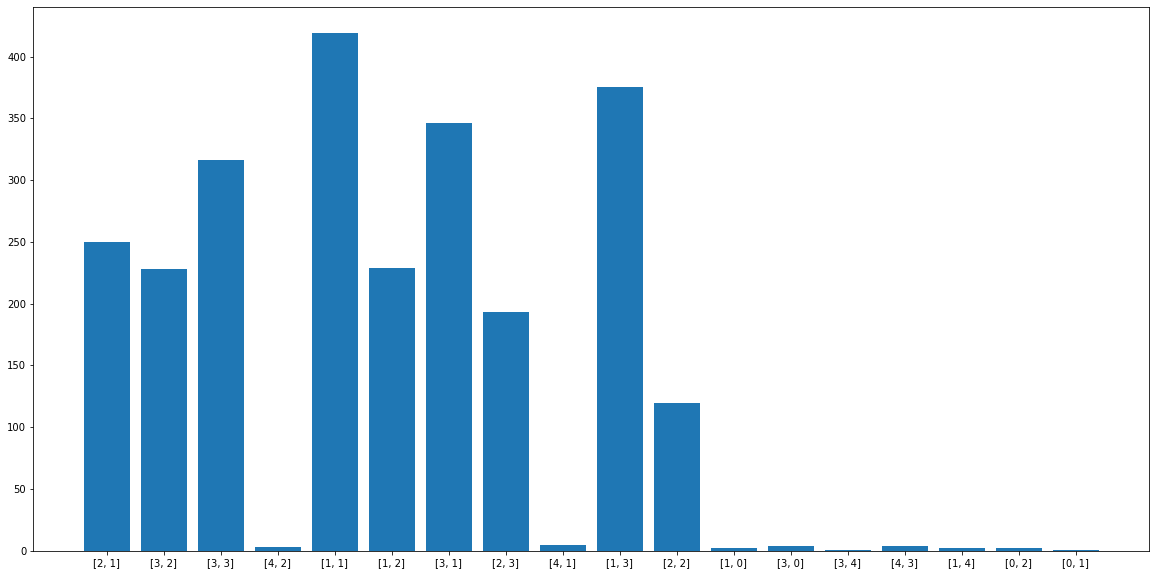

Processing Epoch 139
training start
Iteration 0, d real/fake loss 0.5982120037078857/0.6365829110145569 and g loss is 0.7478997707366943, NDiv loss 0.11693112552165985
Iteration 1, d real/fake loss 0.5980832576751709/0.6267663240432739 and g loss is 0.761589765548706, NDiv loss 0.1145486980676651
Iteration 2, d real/fake loss 0.5979397296905518/0.6276649236679077 and g loss is 0.756183922290802, NDiv loss 0.12362346798181534
Iteration 3, d real/fake loss 0.5977926850318909/0.6377813816070557 and g loss is 0.7603070735931396, NDiv loss 0.11916369944810867
Iteration 4, d real/fake loss 0.5976569652557373/0.6346989870071411 and g loss is 0.7693451642990112, NDiv loss 0.1207159012556076


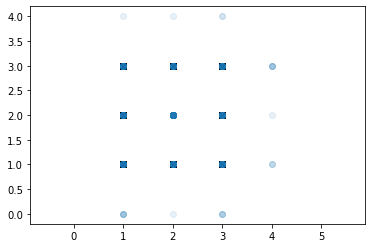

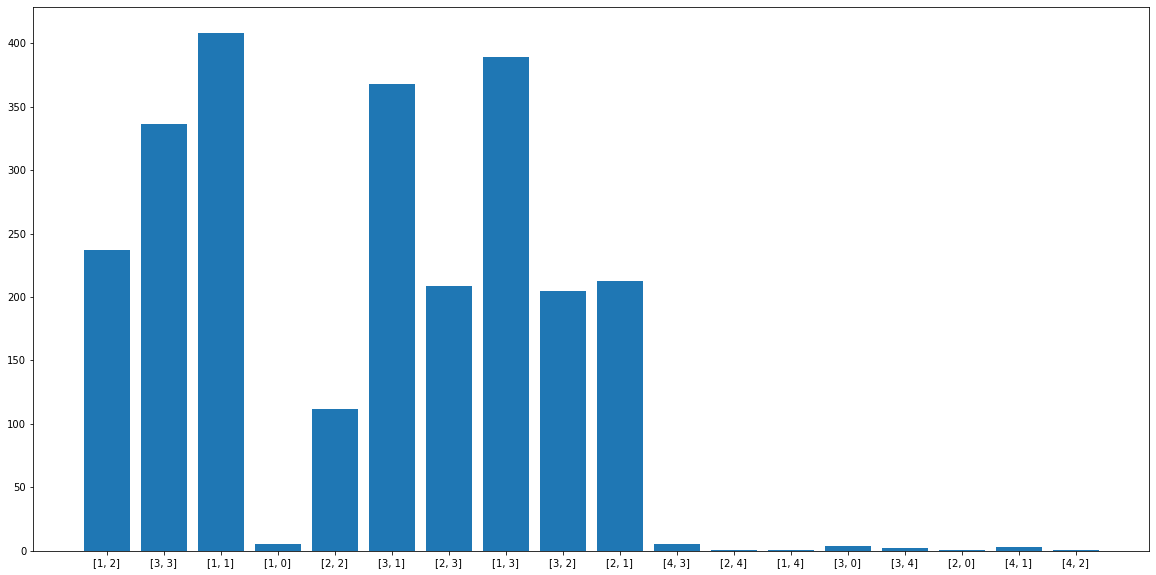

Processing Epoch 140
training start
Iteration 0, d real/fake loss 0.6010724306106567/0.6393575072288513 and g loss is 0.765048623085022, NDiv loss 0.1223873719573021
Iteration 1, d real/fake loss 0.6010000705718994/0.6414266228675842 and g loss is 0.7622931003570557, NDiv loss 0.12153699994087219
Iteration 2, d real/fake loss 0.600925087928772/0.63474041223526 and g loss is 0.7510275840759277, NDiv loss 0.1174236312508583
Iteration 3, d real/fake loss 0.6008375883102417/0.6296038627624512 and g loss is 0.7704095244407654, NDiv loss 0.12217883765697479
Iteration 4, d real/fake loss 0.600732147693634/0.6387795805931091 and g loss is 0.7578496932983398, NDiv loss 0.11988619714975357


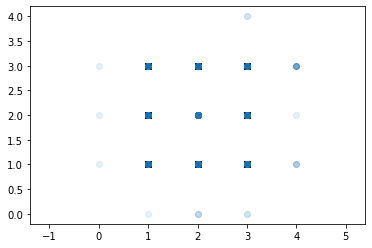

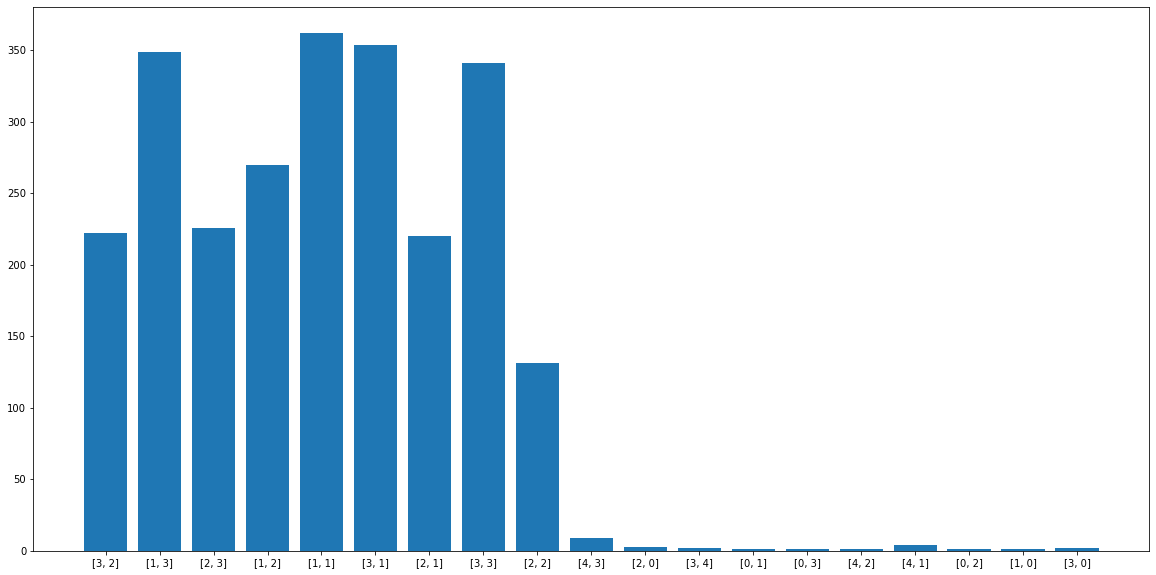

Processing Epoch 141
training start
Iteration 0, d real/fake loss 0.5955803990364075/0.6260261535644531 and g loss is 0.7592220306396484, NDiv loss 0.12242235243320465
Iteration 1, d real/fake loss 0.5954999923706055/0.6368138790130615 and g loss is 0.7599151134490967, NDiv loss 0.1099061444401741
Iteration 2, d real/fake loss 0.59541916847229/0.6280032396316528 and g loss is 0.7628903985023499, NDiv loss 0.11793141067028046
Iteration 3, d real/fake loss 0.5953162908554077/0.6309918165206909 and g loss is 0.7569206953048706, NDiv loss 0.12570326030254364
Iteration 4, d real/fake loss 0.5951979756355286/0.6346930265426636 and g loss is 0.7596743702888489, NDiv loss 0.11618149280548096


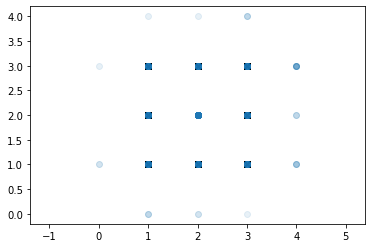

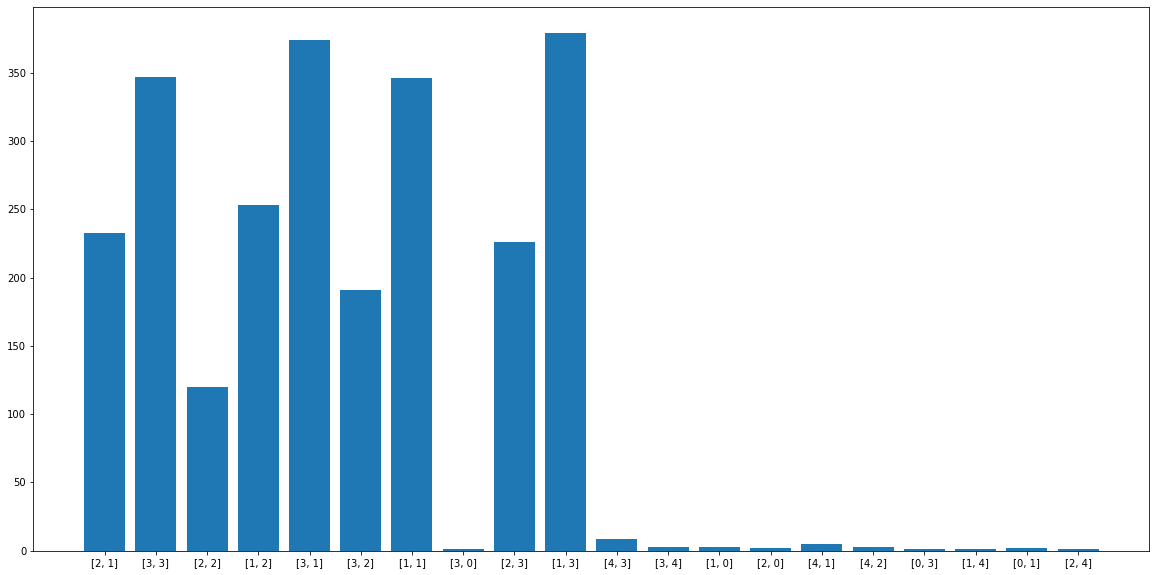

Processing Epoch 142
training start
Iteration 0, d real/fake loss 0.5978345274925232/0.6387107968330383 and g loss is 0.7647006511688232, NDiv loss 0.12149880081415176
Iteration 1, d real/fake loss 0.5977790951728821/0.6311169266700745 and g loss is 0.7632708549499512, NDiv loss 0.12311218678951263
Iteration 2, d real/fake loss 0.5977170467376709/0.6368423104286194 and g loss is 0.7673327922821045, NDiv loss 0.11927837878465652
Iteration 3, d real/fake loss 0.5976586937904358/0.6349413394927979 and g loss is 0.7711625695228577, NDiv loss 0.12339361757040024
Iteration 4, d real/fake loss 0.5976001024246216/0.6351350545883179 and g loss is 0.7613455057144165, NDiv loss 0.1196354329586029


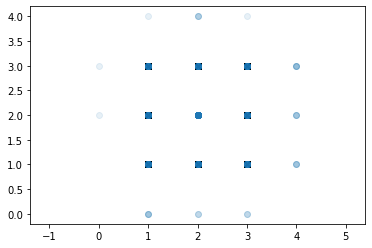

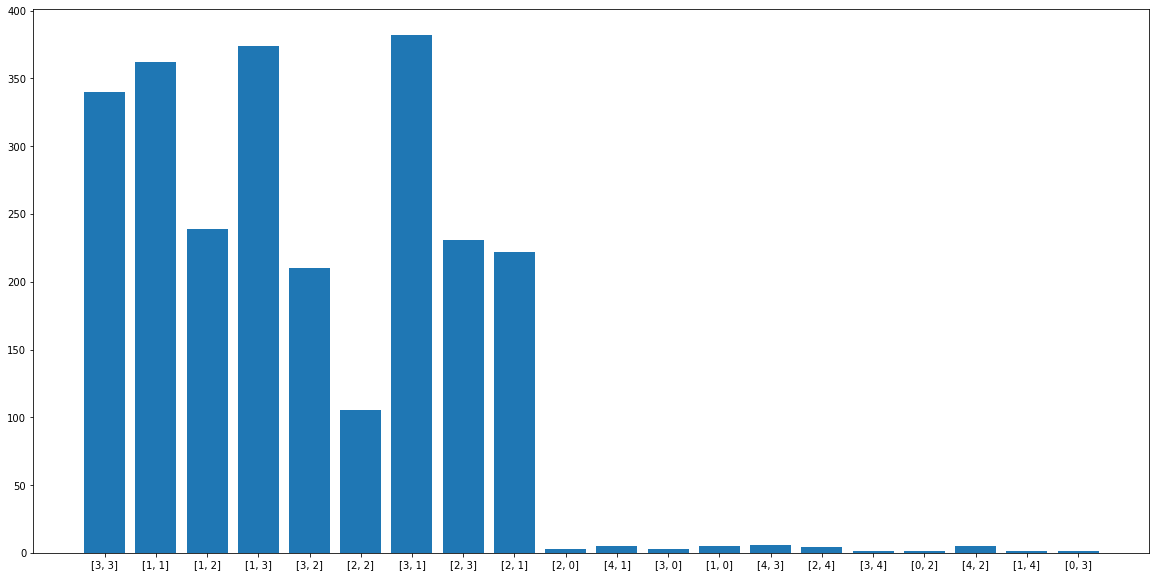

Processing Epoch 143
training start
Iteration 0, d real/fake loss 0.5971258282661438/0.6322029232978821 and g loss is 0.7554284334182739, NDiv loss 0.13375259935855865
Iteration 1, d real/fake loss 0.5970767140388489/0.6374554634094238 and g loss is 0.7644393444061279, NDiv loss 0.1254402995109558
Iteration 2, d real/fake loss 0.5970313549041748/0.6304991245269775 and g loss is 0.763637900352478, NDiv loss 0.11409541964530945
Iteration 3, d real/fake loss 0.5969829559326172/0.6344858407974243 and g loss is 0.7644457817077637, NDiv loss 0.12302539497613907
Iteration 4, d real/fake loss 0.5969327688217163/0.6380277276039124 and g loss is 0.7621010541915894, NDiv loss 0.12351477891206741


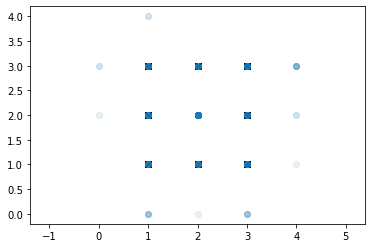

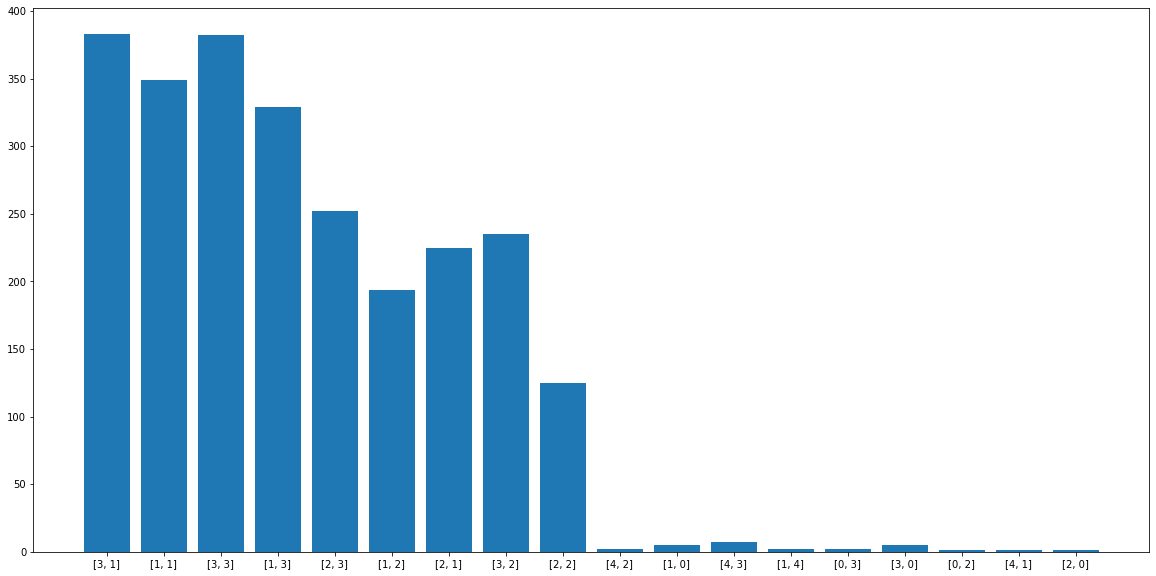

Processing Epoch 144
training start
Iteration 0, d real/fake loss 0.5989800691604614/0.6234331130981445 and g loss is 0.7576701045036316, NDiv loss 0.12209698557853699
Iteration 1, d real/fake loss 0.5989179611206055/0.6214894652366638 and g loss is 0.7656970620155334, NDiv loss 0.1255488097667694
Iteration 2, d real/fake loss 0.5988351702690125/0.6302080750465393 and g loss is 0.7640423774719238, NDiv loss 0.12532839179039001
Iteration 3, d real/fake loss 0.5987447500228882/0.6357454657554626 and g loss is 0.7720484733581543, NDiv loss 0.11715269833803177
Iteration 4, d real/fake loss 0.5986497402191162/0.6352298855781555 and g loss is 0.7583681344985962, NDiv loss 0.12030205875635147


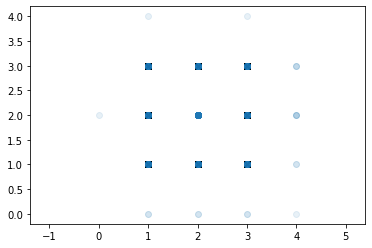

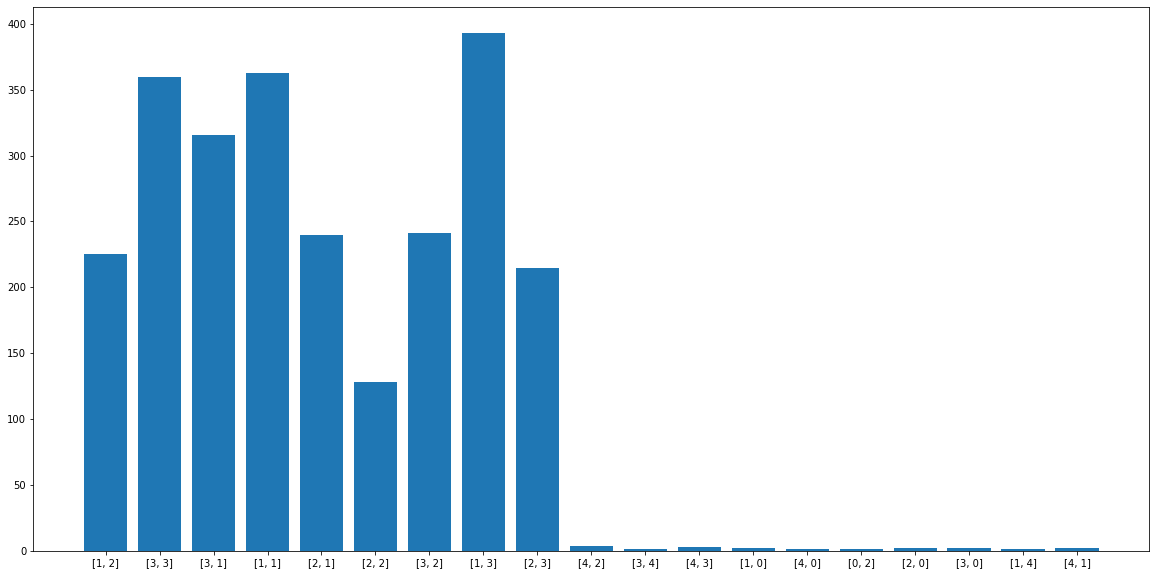

Processing Epoch 145
training start
Iteration 0, d real/fake loss 0.5948026180267334/0.6342555284500122 and g loss is 0.7600439786911011, NDiv loss 0.11803339421749115
Iteration 1, d real/fake loss 0.5947582125663757/0.6305884122848511 and g loss is 0.7700108289718628, NDiv loss 0.12091516703367233
Iteration 2, d real/fake loss 0.5946890115737915/0.6373640298843384 and g loss is 0.7719557285308838, NDiv loss 0.11773798614740372
Iteration 3, d real/fake loss 0.5946126580238342/0.6363980770111084 and g loss is 0.7555443048477173, NDiv loss 0.11390912532806396
Iteration 4, d real/fake loss 0.5945265293121338/0.6310994625091553 and g loss is 0.7683731317520142, NDiv loss 0.12197558581829071


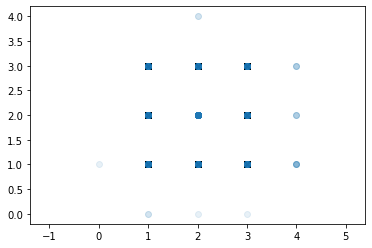

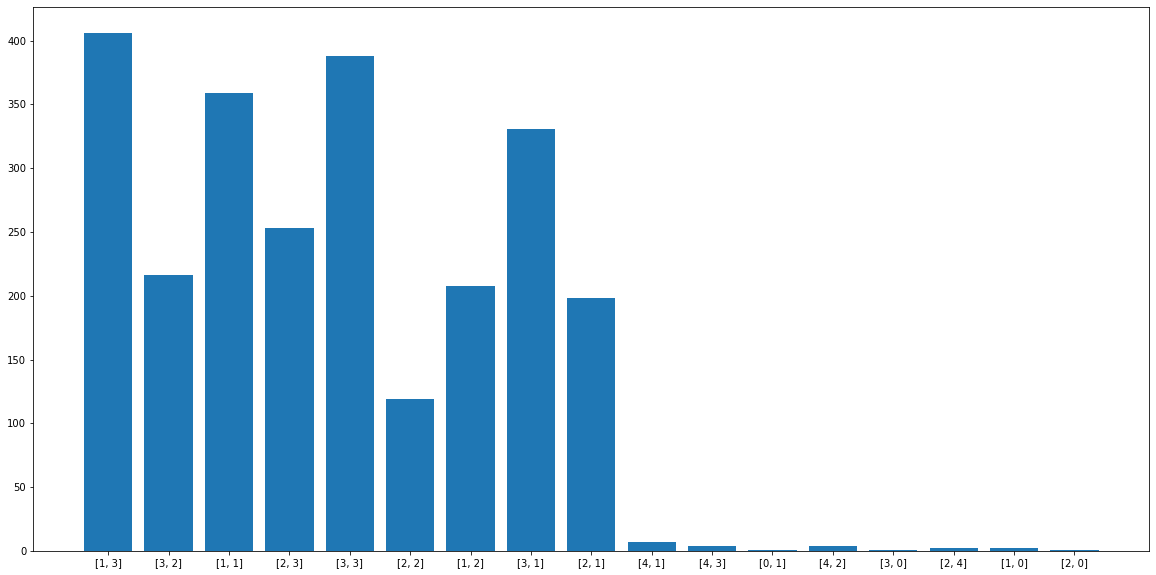

Processing Epoch 146
training start
Iteration 0, d real/fake loss 0.595908522605896/0.6346598863601685 and g loss is 0.7607376575469971, NDiv loss 0.11930374801158905
Iteration 1, d real/fake loss 0.5958589315414429/0.6212987303733826 and g loss is 0.7585897445678711, NDiv loss 0.12174174189567566
Iteration 2, d real/fake loss 0.5957876443862915/0.6362378597259521 and g loss is 0.7692946195602417, NDiv loss 0.11620438098907471
Iteration 3, d real/fake loss 0.5957236886024475/0.6203107833862305 and g loss is 0.7649465203285217, NDiv loss 0.12116140127182007
Iteration 4, d real/fake loss 0.5956391096115112/0.6337306499481201 and g loss is 0.7605117559432983, NDiv loss 0.11997002363204956


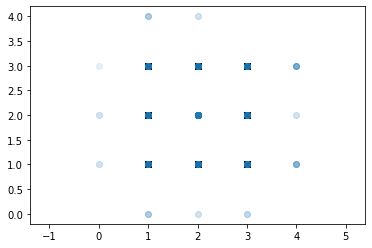

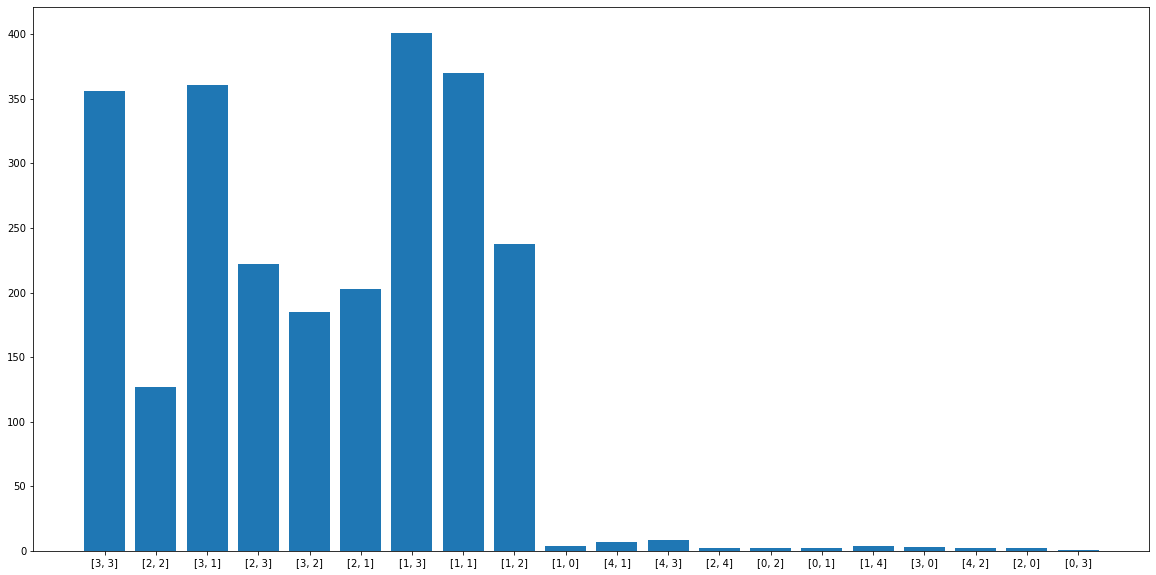

Processing Epoch 147
training start
Iteration 0, d real/fake loss 0.5983343124389648/0.6290749311447144 and g loss is 0.7510846853256226, NDiv loss 0.12165319919586182
Iteration 1, d real/fake loss 0.5982328653335571/0.6334690451622009 and g loss is 0.7620837688446045, NDiv loss 0.1174434944987297
Iteration 2, d real/fake loss 0.5981013178825378/0.6316218376159668 and g loss is 0.7643791437149048, NDiv loss 0.12225747853517532
Iteration 3, d real/fake loss 0.597960889339447/0.6294704675674438 and g loss is 0.759227991104126, NDiv loss 0.11954479664564133
Iteration 4, d real/fake loss 0.5978063344955444/0.6267762780189514 and g loss is 0.75885409116745, NDiv loss 0.123444564640522


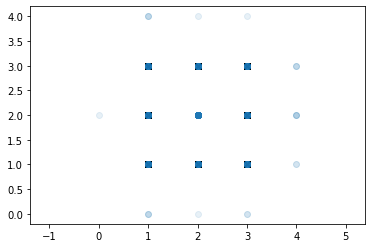

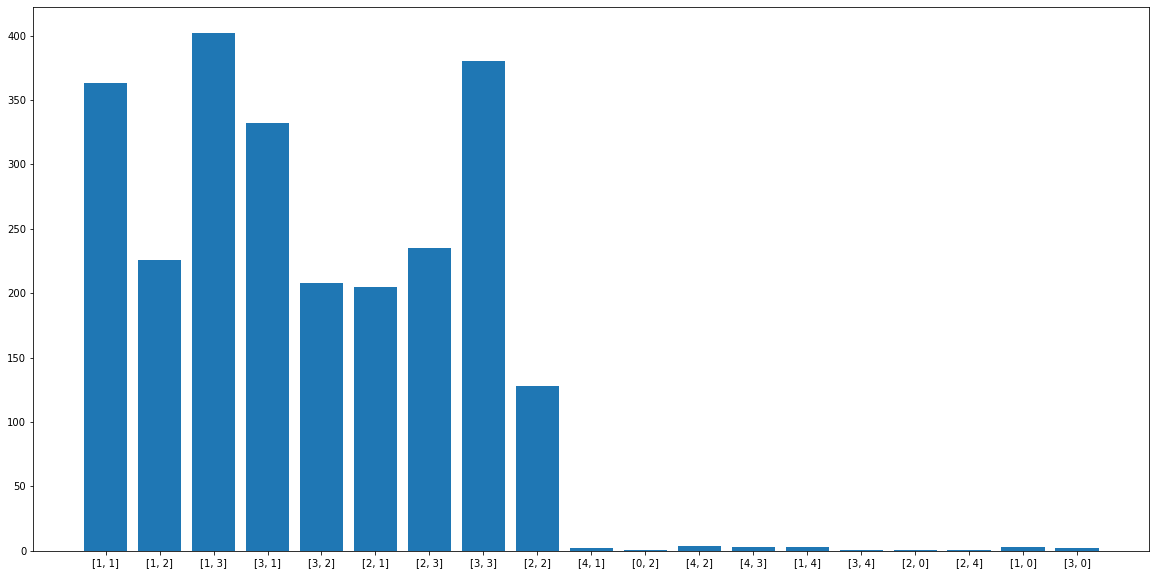

Processing Epoch 148
training start
Iteration 0, d real/fake loss 0.5951499938964844/0.6302118301391602 and g loss is 0.7536764144897461, NDiv loss 0.11529576778411865
Iteration 1, d real/fake loss 0.5950272083282471/0.6342365741729736 and g loss is 0.7715139985084534, NDiv loss 0.11963565647602081
Iteration 2, d real/fake loss 0.5949114561080933/0.6221333742141724 and g loss is 0.7662470936775208, NDiv loss 0.12857727706432343
Iteration 3, d real/fake loss 0.5947901606559753/0.6304148435592651 and g loss is 0.7574061155319214, NDiv loss 0.11762610077857971
Iteration 4, d real/fake loss 0.5946722030639648/0.6209291219711304 and g loss is 0.7623939514160156, NDiv loss 0.1221470907330513


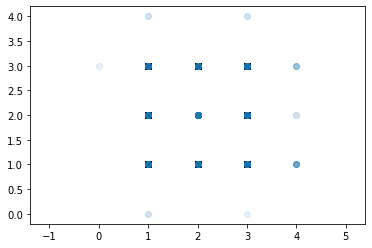

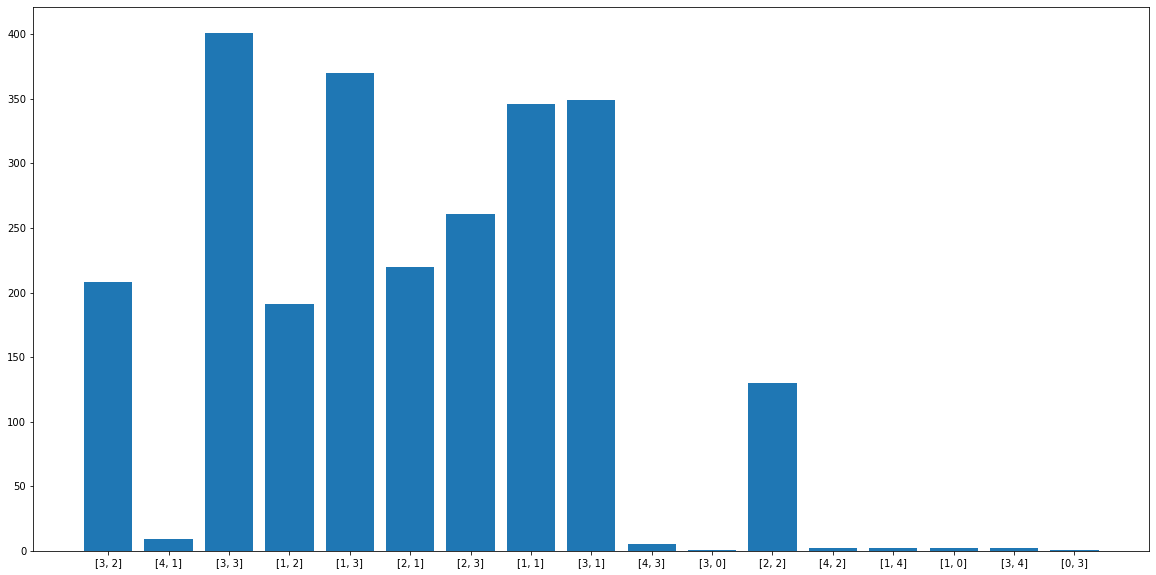

Processing Epoch 149
training start
Iteration 0, d real/fake loss 0.5949383974075317/0.6302680373191833 and g loss is 0.7614132761955261, NDiv loss 0.12516935169696808
Iteration 1, d real/fake loss 0.5947696566581726/0.6289277076721191 and g loss is 0.7661699652671814, NDiv loss 0.13227570056915283
Iteration 2, d real/fake loss 0.5945847034454346/0.6193054914474487 and g loss is 0.7635786533355713, NDiv loss 0.11961540579795837
Iteration 3, d real/fake loss 0.5943701863288879/0.6315995454788208 and g loss is 0.7570291757583618, NDiv loss 0.12005296349525452
Iteration 4, d real/fake loss 0.5941557288169861/0.6236404180526733 and g loss is 0.7662569284439087, NDiv loss 0.12966476380825043


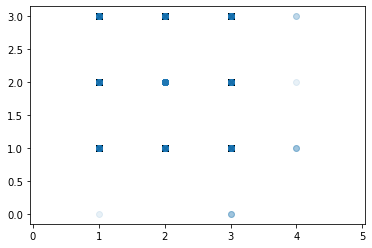

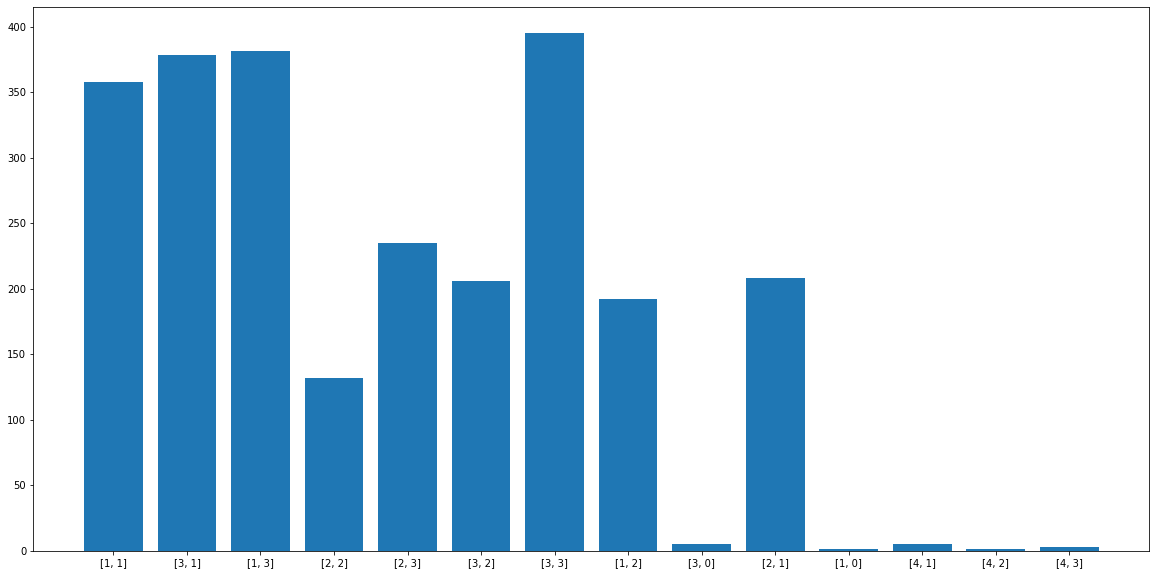

Processing Epoch 150
training start
Iteration 0, d real/fake loss 0.5940616130828857/0.6292542815208435 and g loss is 0.7682193517684937, NDiv loss 0.12263796478509903
Iteration 1, d real/fake loss 0.593921422958374/0.6271823644638062 and g loss is 0.7673736810684204, NDiv loss 0.11448267102241516
Iteration 2, d real/fake loss 0.5937899351119995/0.631346583366394 and g loss is 0.7552975416183472, NDiv loss 0.12176153063774109
Iteration 3, d real/fake loss 0.5936654210090637/0.6282393932342529 and g loss is 0.7594660520553589, NDiv loss 0.11925990879535675
Iteration 4, d real/fake loss 0.5935437679290771/0.6315619945526123 and g loss is 0.7785522937774658, NDiv loss 0.11479737609624863


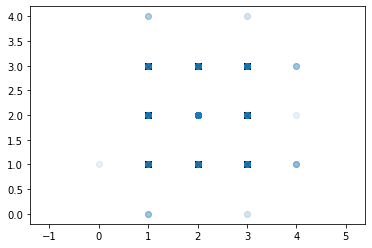

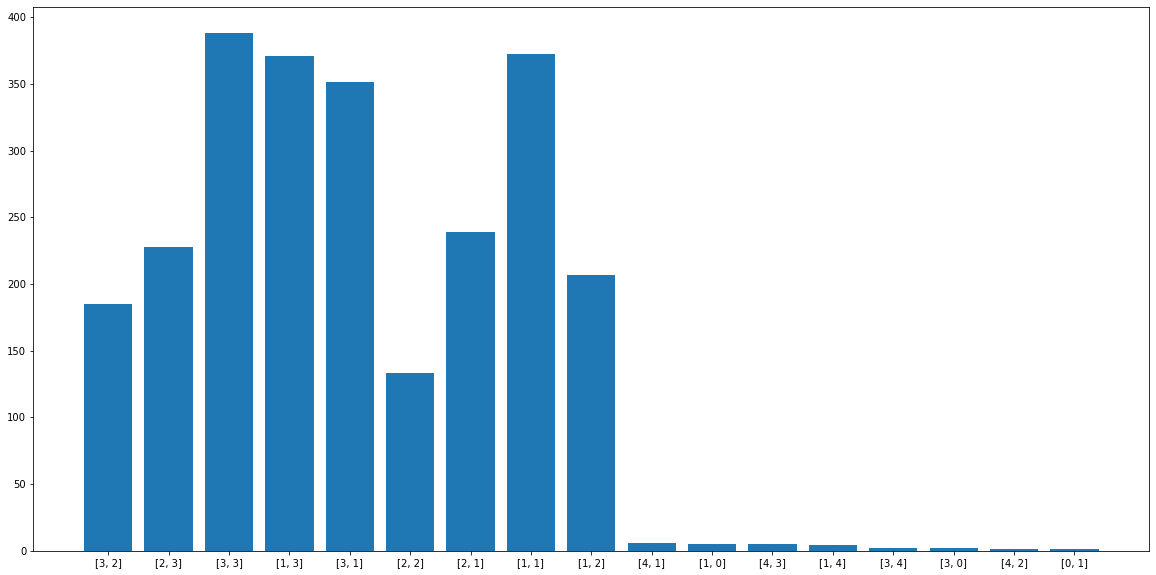

Processing Epoch 151
training start
Iteration 0, d real/fake loss 0.5940508246421814/0.6362839937210083 and g loss is 0.7706767916679382, NDiv loss 0.12351566553115845
Iteration 1, d real/fake loss 0.5940232276916504/0.6206299066543579 and g loss is 0.7693843245506287, NDiv loss 0.12204147130250931
Iteration 2, d real/fake loss 0.5939778685569763/0.6226000189781189 and g loss is 0.7618221044540405, NDiv loss 0.12781034409999847
Iteration 3, d real/fake loss 0.5939159393310547/0.6301037073135376 and g loss is 0.769289493560791, NDiv loss 0.12795257568359375
Iteration 4, d real/fake loss 0.5938518047332764/0.6255337595939636 and g loss is 0.7632136940956116, NDiv loss 0.12788818776607513


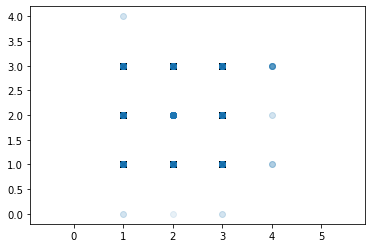

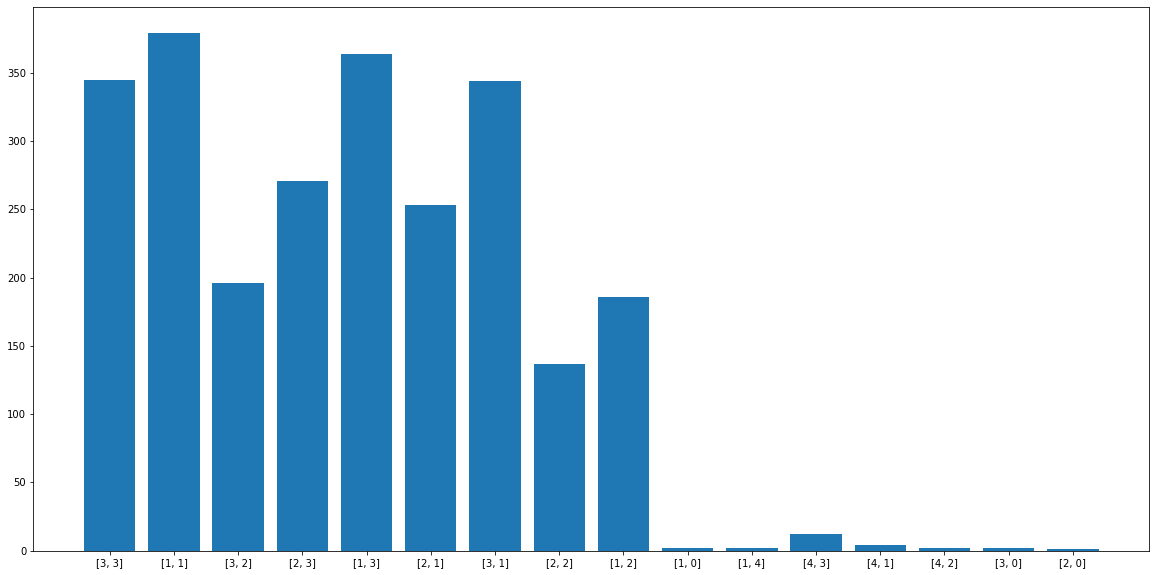

Processing Epoch 152
training start
Iteration 0, d real/fake loss 0.5947253704071045/0.6328529119491577 and g loss is 0.7756872177124023, NDiv loss 0.12007726728916168
Iteration 1, d real/fake loss 0.5946513414382935/0.6205109357833862 and g loss is 0.7670571804046631, NDiv loss 0.11937493085861206
Iteration 2, d real/fake loss 0.5945663452148438/0.628056526184082 and g loss is 0.7626824378967285, NDiv loss 0.12116292864084244
Iteration 3, d real/fake loss 0.5944706797599792/0.6222238540649414 and g loss is 0.76911860704422, NDiv loss 0.1266029328107834
Iteration 4, d real/fake loss 0.5943594574928284/0.6218666434288025 and g loss is 0.7613438367843628, NDiv loss 0.11554040759801865


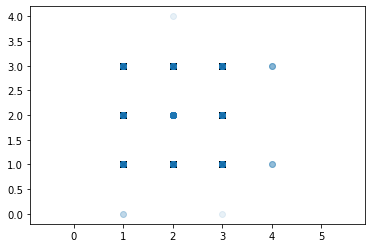

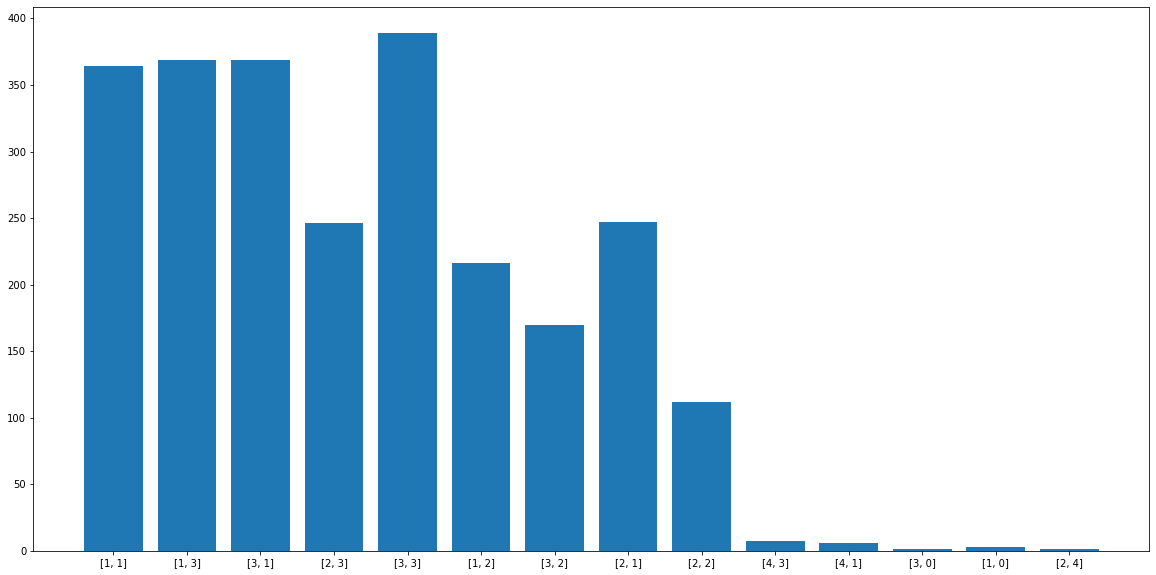

Processing Epoch 153
training start
Iteration 0, d real/fake loss 0.592342734336853/0.6241681575775146 and g loss is 0.7694822549819946, NDiv loss 0.12065798789262772
Iteration 1, d real/fake loss 0.5922552347183228/0.6228736639022827 and g loss is 0.7697948813438416, NDiv loss 0.12285526841878891
Iteration 2, d real/fake loss 0.5921615362167358/0.632784903049469 and g loss is 0.7683281898498535, NDiv loss 0.11858279258012772
Iteration 3, d real/fake loss 0.5920757055282593/0.6269546747207642 and g loss is 0.7650315165519714, NDiv loss 0.11954078078269958
Iteration 4, d real/fake loss 0.5919920206069946/0.6284565925598145 and g loss is 0.7726019620895386, NDiv loss 0.11739048361778259


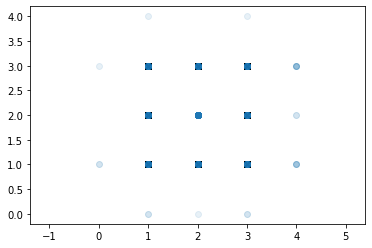

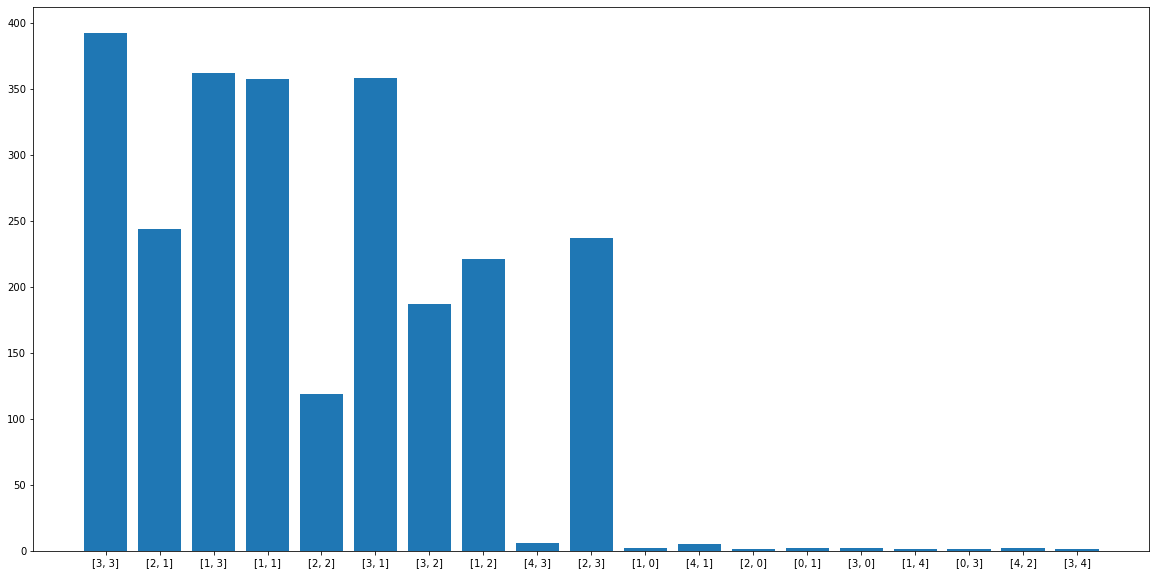

Processing Epoch 154
training start
Iteration 0, d real/fake loss 0.5936088562011719/0.6210857033729553 and g loss is 0.770245373249054, NDiv loss 0.12140846252441406
Iteration 1, d real/fake loss 0.5935115218162537/0.6194584965705872 and g loss is 0.7698637247085571, NDiv loss 0.12162529677152634
Iteration 2, d real/fake loss 0.5934028625488281/0.6261308193206787 and g loss is 0.7639957666397095, NDiv loss 0.12322096526622772
Iteration 3, d real/fake loss 0.5932917594909668/0.6259157061576843 and g loss is 0.7661736011505127, NDiv loss 0.12081148475408554
Iteration 4, d real/fake loss 0.5931776165962219/0.6311194896697998 and g loss is 0.7773040533065796, NDiv loss 0.1305241733789444


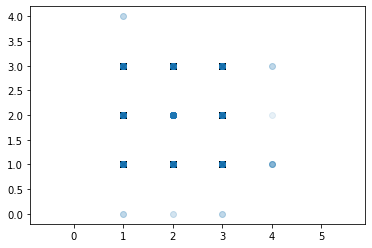

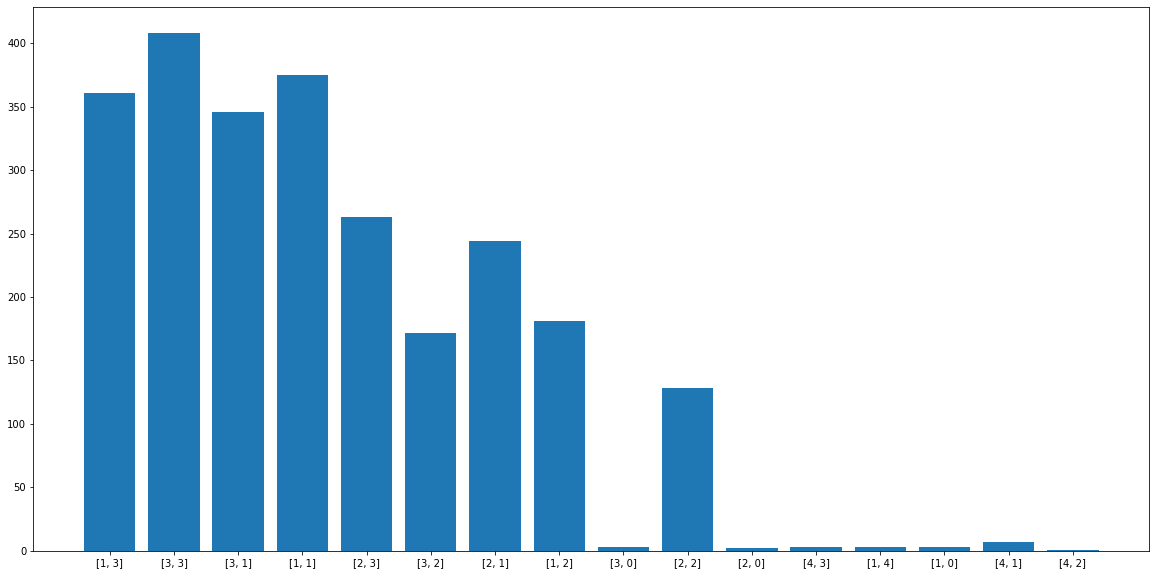

Processing Epoch 155
training start
Iteration 0, d real/fake loss 0.5932297706604004/0.6305514574050903 and g loss is 0.7693831920623779, NDiv loss 0.11804327368736267
Iteration 1, d real/fake loss 0.5931538939476013/0.623931348323822 and g loss is 0.7661381959915161, NDiv loss 0.12951895594596863
Iteration 2, d real/fake loss 0.5930674076080322/0.6203942894935608 and g loss is 0.7774069309234619, NDiv loss 0.11762282252311707
Iteration 3, d real/fake loss 0.592970073223114/0.6319676637649536 and g loss is 0.7648524045944214, NDiv loss 0.11926836520433426
Iteration 4, d real/fake loss 0.592882513999939/0.6215118765830994 and g loss is 0.7732541561126709, NDiv loss 0.11882758885622025


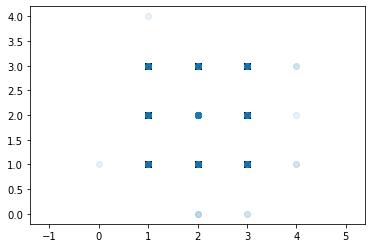

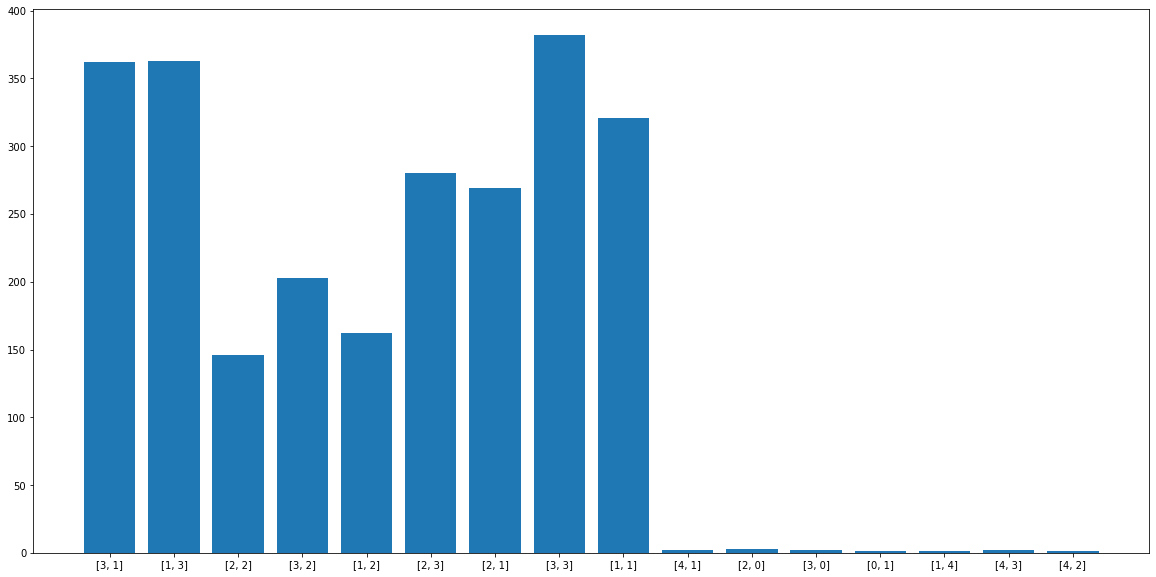

Processing Epoch 156
training start
Iteration 0, d real/fake loss 0.5940359830856323/0.6234405040740967 and g loss is 0.7649894952774048, NDiv loss 0.12617288529872894
Iteration 1, d real/fake loss 0.59394371509552/0.6282106637954712 and g loss is 0.7755765914916992, NDiv loss 0.12077268213033676
Iteration 2, d real/fake loss 0.5938608646392822/0.6238086819648743 and g loss is 0.7833812832832336, NDiv loss 0.12086507678031921
Iteration 3, d real/fake loss 0.5937724709510803/0.6259956359863281 and g loss is 0.7709211111068726, NDiv loss 0.11632485687732697
Iteration 4, d real/fake loss 0.5936875343322754/0.6260613203048706 and g loss is 0.7776360511779785, NDiv loss 0.1252514272928238


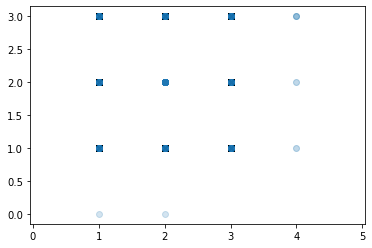

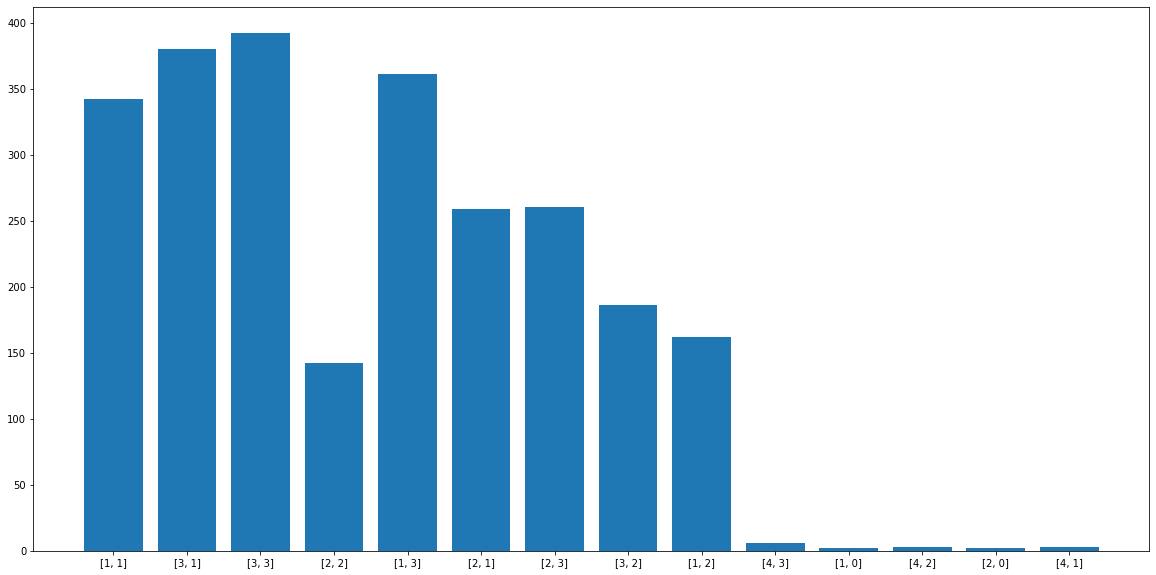

Processing Epoch 157
training start
Iteration 0, d real/fake loss 0.5907291173934937/0.6179169416427612 and g loss is 0.772301197052002, NDiv loss 0.11465881764888763
Iteration 1, d real/fake loss 0.5906918048858643/0.6295748353004456 and g loss is 0.759543240070343, NDiv loss 0.1270502209663391
Iteration 2, d real/fake loss 0.590616762638092/0.6180909276008606 and g loss is 0.7611750364303589, NDiv loss 0.1179816871881485
Iteration 3, d real/fake loss 0.5905138254165649/0.6186959743499756 and g loss is 0.7689428329467773, NDiv loss 0.12138140201568604
Iteration 4, d real/fake loss 0.5903597474098206/0.619341254234314 and g loss is 0.7546156644821167, NDiv loss 0.12388323247432709


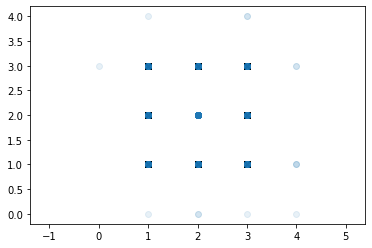

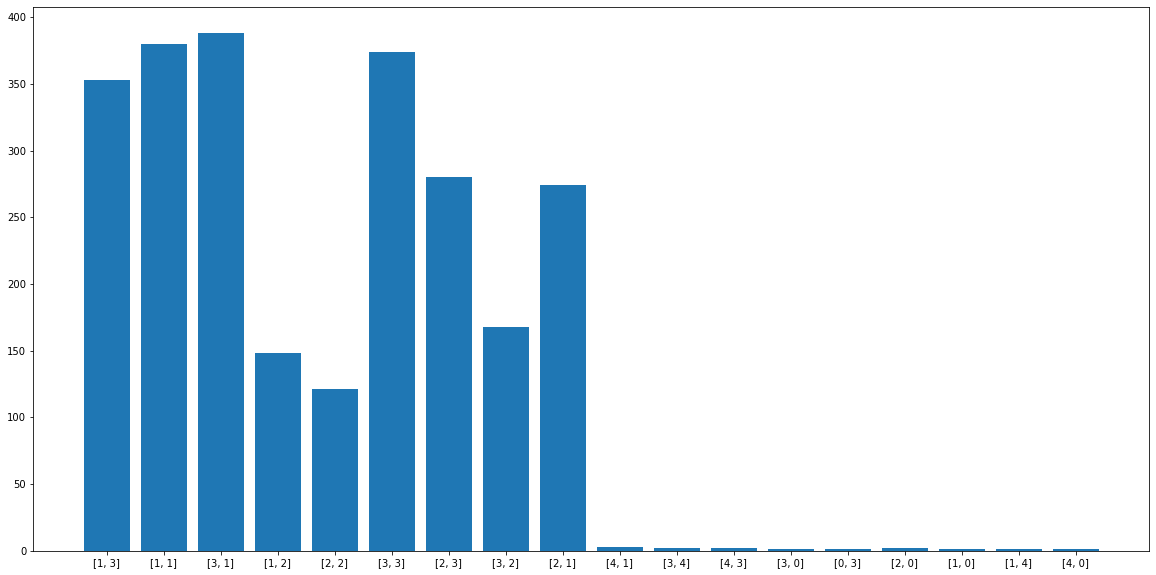

Processing Epoch 158
training start
Iteration 0, d real/fake loss 0.590789794921875/0.622852087020874 and g loss is 0.7723833322525024, NDiv loss 0.12579043209552765
Iteration 1, d real/fake loss 0.5906484723091125/0.6310908794403076 and g loss is 0.7720565795898438, NDiv loss 0.12907840311527252
Iteration 2, d real/fake loss 0.5905211567878723/0.6154887676239014 and g loss is 0.7690744400024414, NDiv loss 0.11951809376478195
Iteration 3, d real/fake loss 0.5903829336166382/0.6211947798728943 and g loss is 0.7839491963386536, NDiv loss 0.1214330717921257
Iteration 4, d real/fake loss 0.5902450084686279/0.6162232756614685 and g loss is 0.7657928466796875, NDiv loss 0.12747879326343536


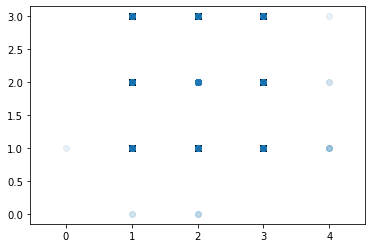

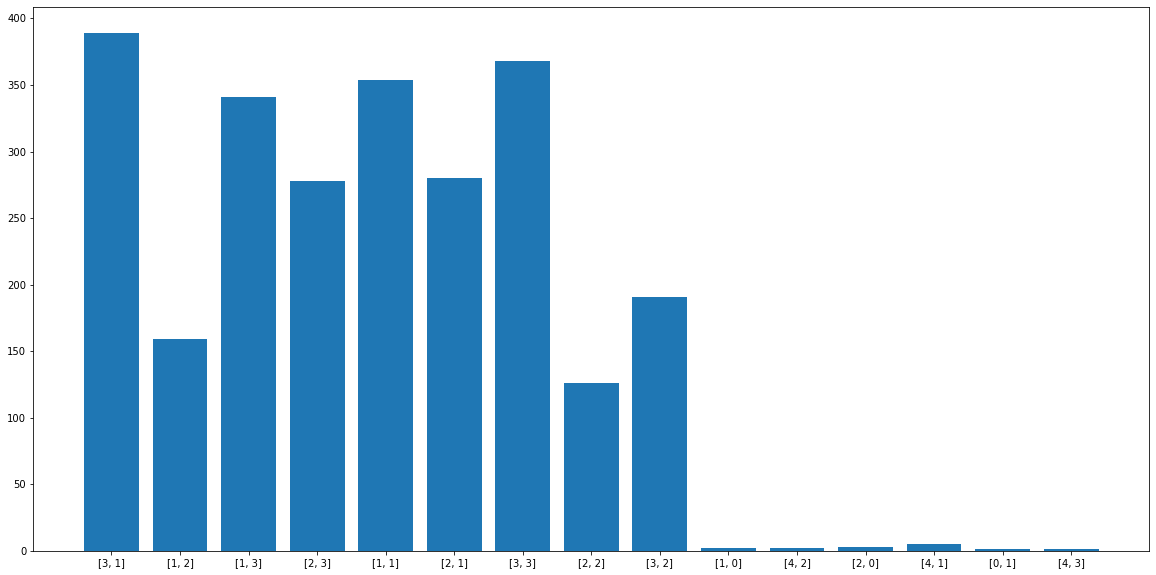

Processing Epoch 159
training start
Iteration 0, d real/fake loss 0.5911132097244263/0.6210504174232483 and g loss is 0.7688427567481995, NDiv loss 0.12688253819942474
Iteration 1, d real/fake loss 0.5910202264785767/0.6140421628952026 and g loss is 0.7718260288238525, NDiv loss 0.1216023713350296
Iteration 2, d real/fake loss 0.590916097164154/0.6240233778953552 and g loss is 0.7756068706512451, NDiv loss 0.1179385781288147
Iteration 3, d real/fake loss 0.590815007686615/0.6208480596542358 and g loss is 0.7773947715759277, NDiv loss 0.12476064264774323
Iteration 4, d real/fake loss 0.5907184481620789/0.6145460605621338 and g loss is 0.7756763696670532, NDiv loss 0.12520483136177063


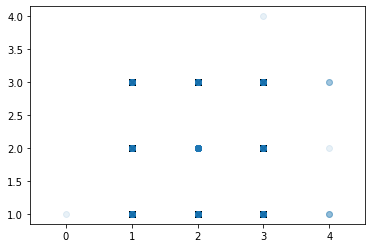

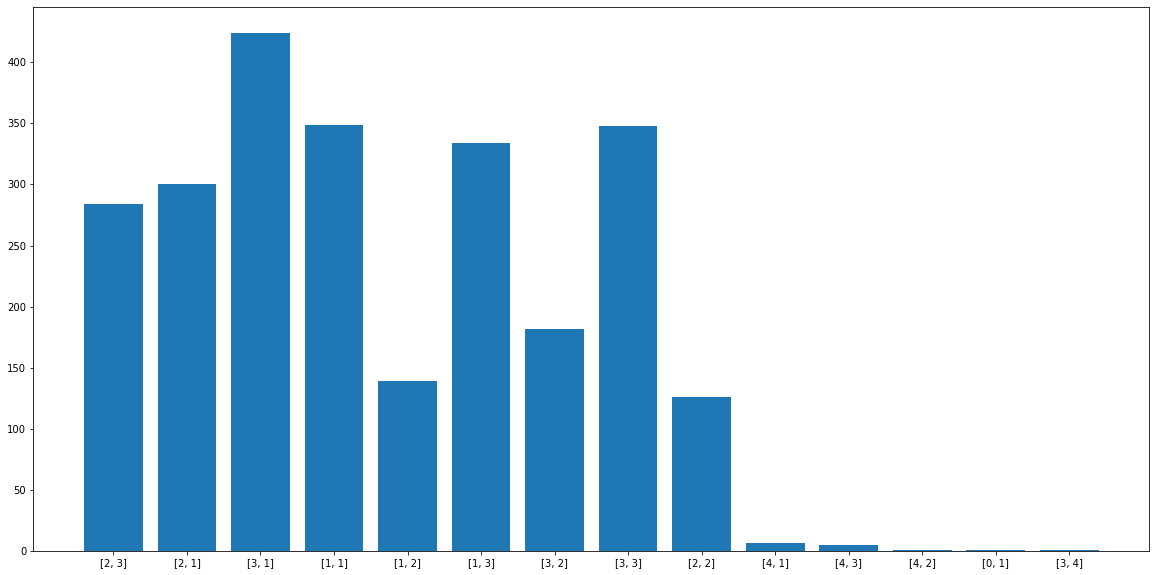

Processing Epoch 160
training start
Iteration 0, d real/fake loss 0.5903982520103455/0.6204180717468262 and g loss is 0.7745124697685242, NDiv loss 0.12839557230472565
Iteration 1, d real/fake loss 0.5903028845787048/0.6150827407836914 and g loss is 0.7734861373901367, NDiv loss 0.12206671386957169
Iteration 2, d real/fake loss 0.5901865363121033/0.6274582743644714 and g loss is 0.7657628655433655, NDiv loss 0.12348897755146027
Iteration 3, d real/fake loss 0.5900801420211792/0.632584810256958 and g loss is 0.7833464741706848, NDiv loss 0.12306518107652664
Iteration 4, d real/fake loss 0.5899892449378967/0.6101033687591553 and g loss is 0.7688467502593994, NDiv loss 0.11770744621753693


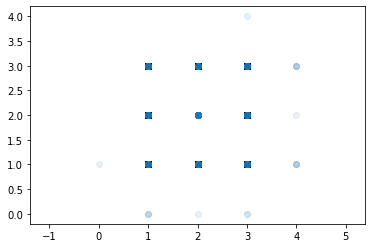

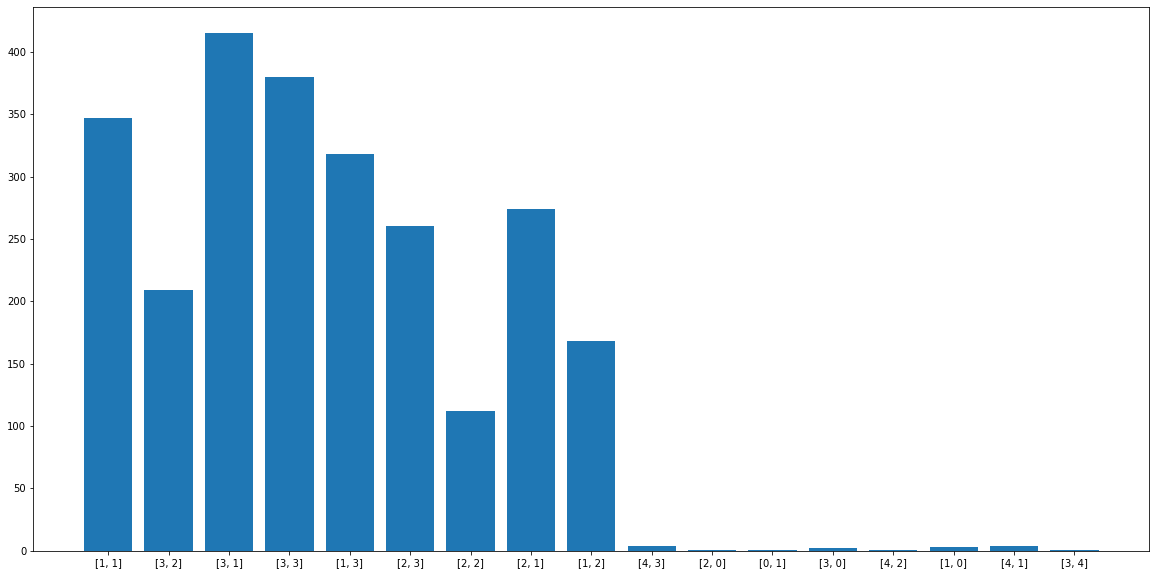

Processing Epoch 161
training start
Iteration 0, d real/fake loss 0.5905531644821167/0.6285679340362549 and g loss is 0.7723177075386047, NDiv loss 0.1216471865773201
Iteration 1, d real/fake loss 0.5904728174209595/0.6300979852676392 and g loss is 0.7696003317832947, NDiv loss 0.1297839730978012
Iteration 2, d real/fake loss 0.5904079079627991/0.6138085126876831 and g loss is 0.7805838584899902, NDiv loss 0.12140234559774399
Iteration 3, d real/fake loss 0.5903431177139282/0.619623064994812 and g loss is 0.777996301651001, NDiv loss 0.12199226021766663
Iteration 4, d real/fake loss 0.5902743339538574/0.6295482516288757 and g loss is 0.7770736217498779, NDiv loss 0.1195177212357521


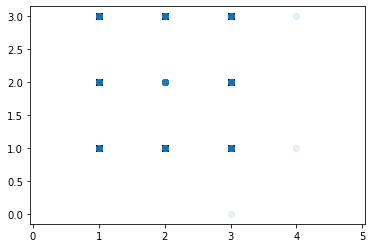

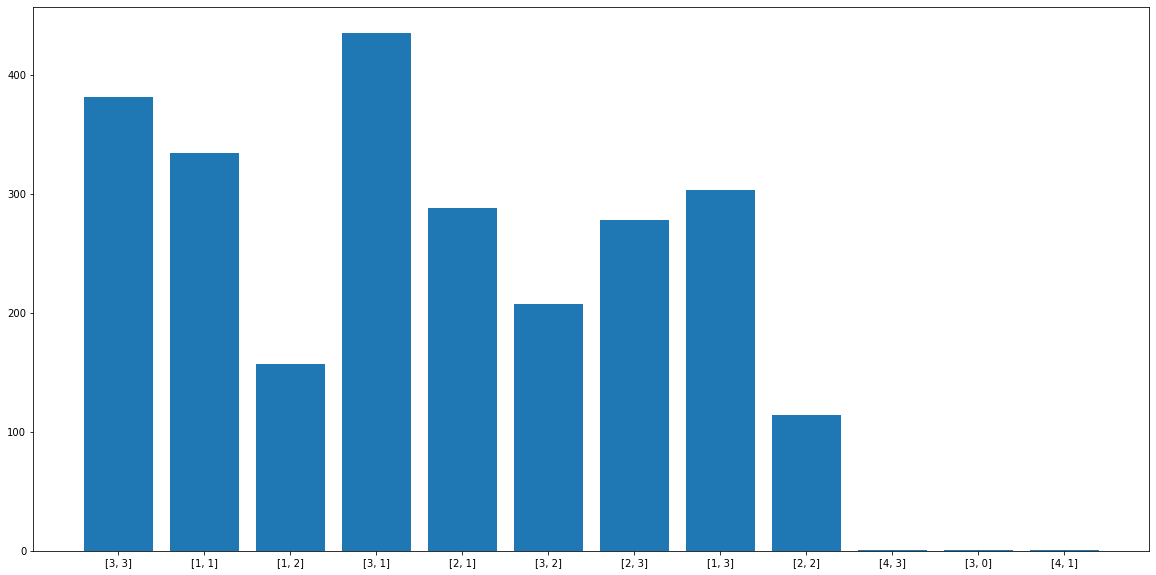

Processing Epoch 162
training start
Iteration 0, d real/fake loss 0.5903856158256531/0.6112678647041321 and g loss is 0.7687755823135376, NDiv loss 0.12973329424858093
Iteration 1, d real/fake loss 0.590327799320221/0.6129300594329834 and g loss is 0.7747012376785278, NDiv loss 0.12469706684350967
Iteration 2, d real/fake loss 0.5902527570724487/0.625661313533783 and g loss is 0.7786269187927246, NDiv loss 0.12070140242576599
Iteration 3, d real/fake loss 0.5901795625686646/0.6210124492645264 and g loss is 0.7802199125289917, NDiv loss 0.12487103044986725
Iteration 4, d real/fake loss 0.5901057720184326/0.6193287372589111 and g loss is 0.7876275777816772, NDiv loss 0.12862224876880646


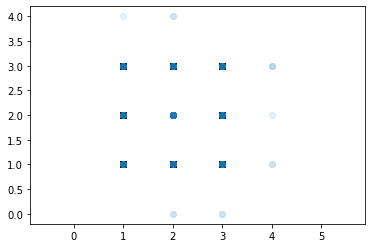

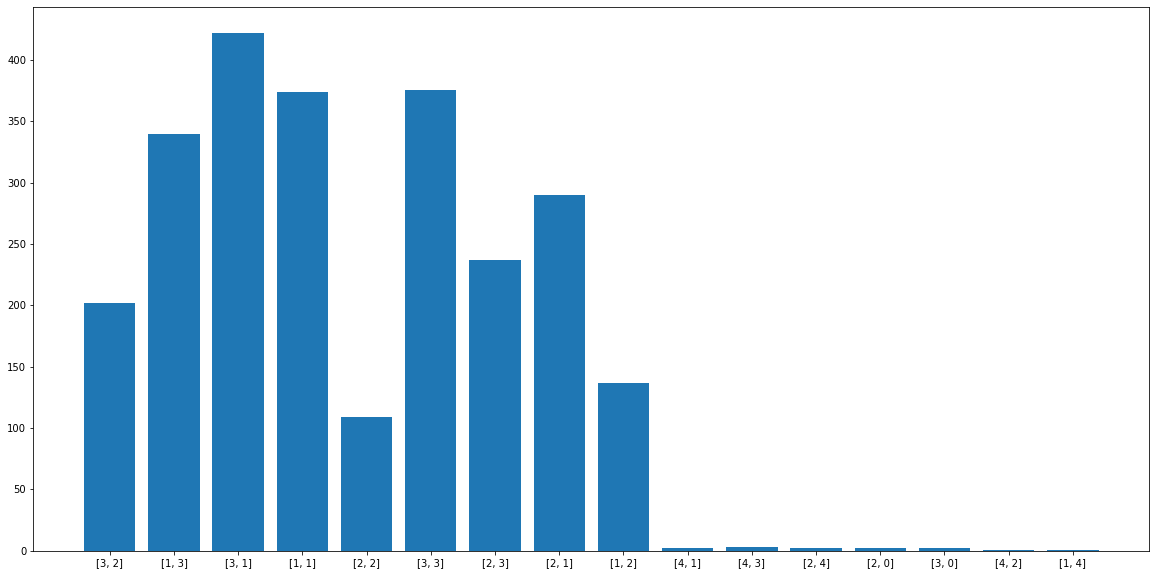

Processing Epoch 163
training start
Iteration 0, d real/fake loss 0.5889427661895752/0.6316752433776855 and g loss is 0.7743607759475708, NDiv loss 0.1198526918888092
Iteration 1, d real/fake loss 0.5889290571212769/0.6084470748901367 and g loss is 0.7755687236785889, NDiv loss 0.12901516258716583
Iteration 2, d real/fake loss 0.5888664722442627/0.6075007915496826 and g loss is 0.7670273780822754, NDiv loss 0.12708808481693268
Iteration 3, d real/fake loss 0.5887678265571594/0.616718053817749 and g loss is 0.7808412313461304, NDiv loss 0.12382391840219498
Iteration 4, d real/fake loss 0.5886486768722534/0.6137993335723877 and g loss is 0.7866519689559937, NDiv loss 0.1221349835395813


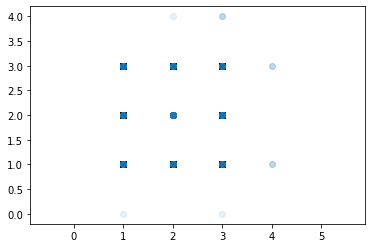

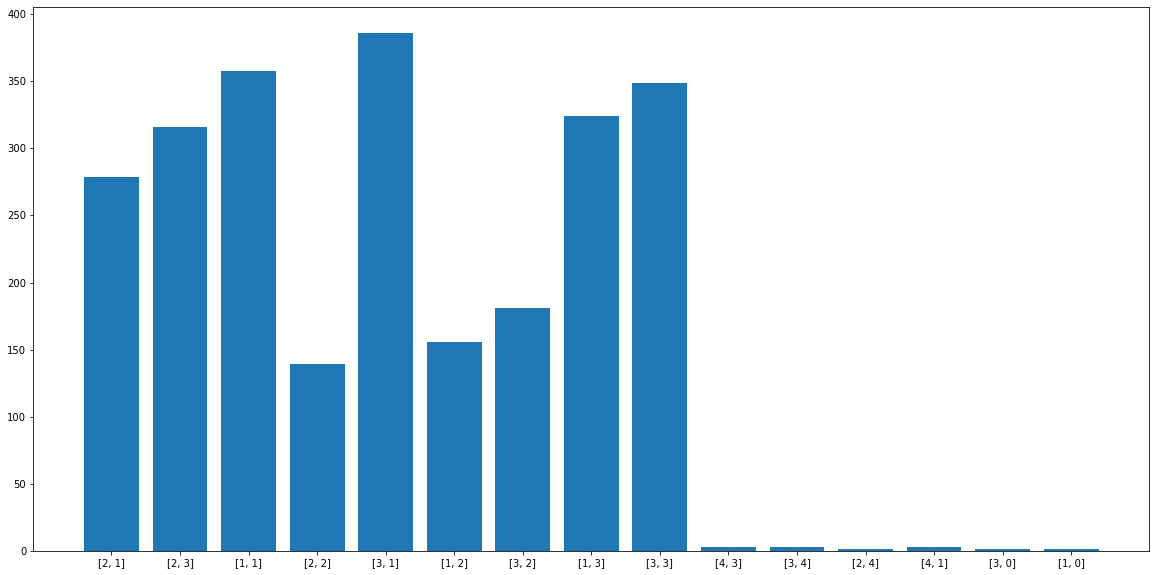

Processing Epoch 164
training start
Iteration 0, d real/fake loss 0.5880646705627441/0.618213415145874 and g loss is 0.7692639827728271, NDiv loss 0.12135317921638489
Iteration 1, d real/fake loss 0.5878769159317017/0.6178913712501526 and g loss is 0.7919174432754517, NDiv loss 0.1218867152929306
Iteration 2, d real/fake loss 0.5876824855804443/0.6191241145133972 and g loss is 0.7826182246208191, NDiv loss 0.11875464022159576
Iteration 3, d real/fake loss 0.5874738693237305/0.6109619736671448 and g loss is 0.7786613702774048, NDiv loss 0.1201038733124733
Iteration 4, d real/fake loss 0.5872471928596497/0.6235693693161011 and g loss is 0.7709019184112549, NDiv loss 0.11955087631940842


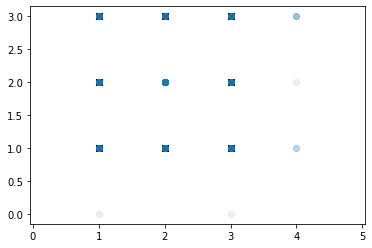

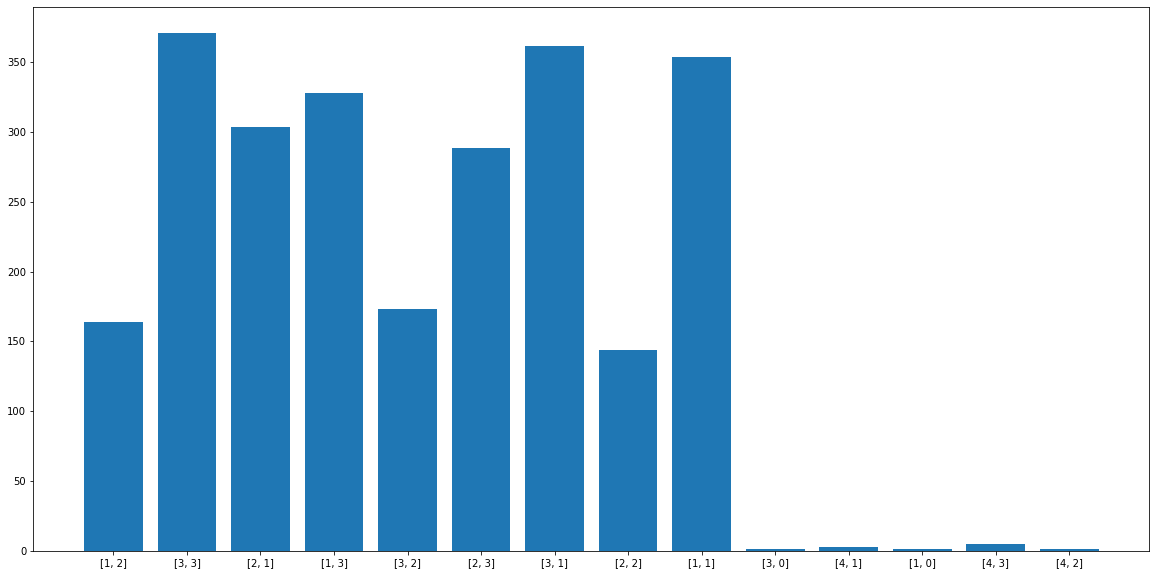

Processing Epoch 165
training start
Iteration 0, d real/fake loss 0.5888233184814453/0.6176310777664185 and g loss is 0.7852040529251099, NDiv loss 0.12247808277606964
Iteration 1, d real/fake loss 0.5886775255203247/0.61331707239151 and g loss is 0.7637982368469238, NDiv loss 0.12266875803470612
Iteration 2, d real/fake loss 0.5885239839553833/0.6139137744903564 and g loss is 0.7721792459487915, NDiv loss 0.1213500127196312
Iteration 3, d real/fake loss 0.5883638858795166/0.6203296184539795 and g loss is 0.7820242643356323, NDiv loss 0.11875703185796738
Iteration 4, d real/fake loss 0.588213324546814/0.6081320643424988 and g loss is 0.7779144048690796, NDiv loss 0.12101839482784271


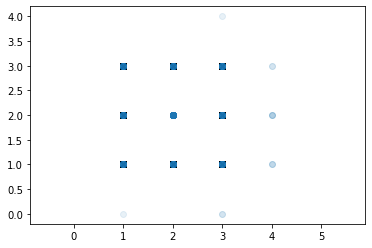

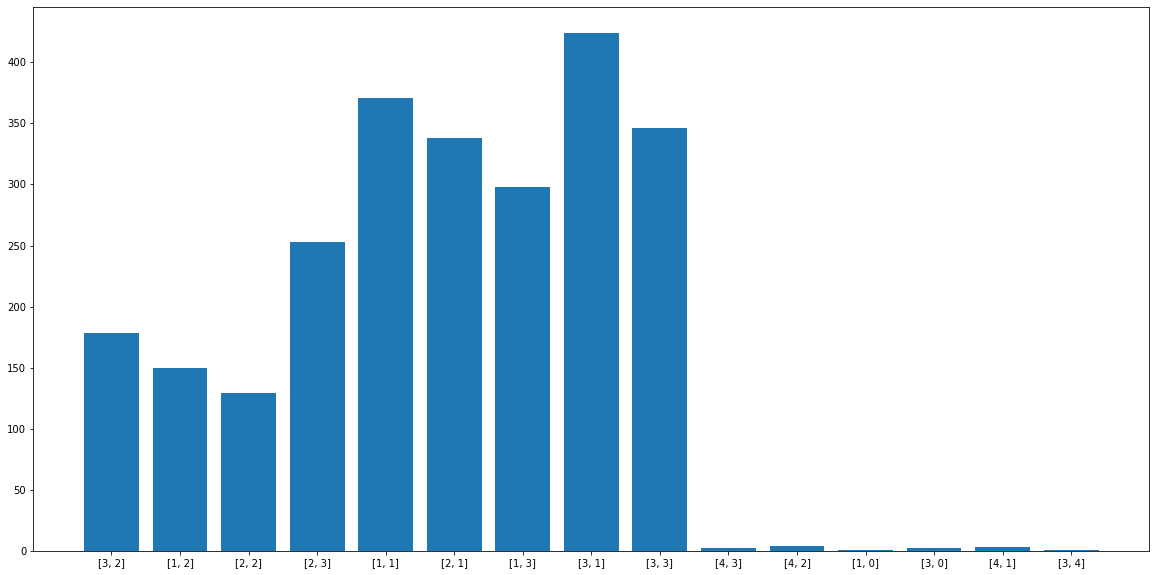

Processing Epoch 166
training start
Iteration 0, d real/fake loss 0.5892038345336914/0.6127393245697021 and g loss is 0.7767107486724854, NDiv loss 0.12385877221822739
Iteration 1, d real/fake loss 0.5891385674476624/0.6177172660827637 and g loss is 0.7818993330001831, NDiv loss 0.12159331142902374
Iteration 2, d real/fake loss 0.5890733003616333/0.6173166036605835 and g loss is 0.7856695652008057, NDiv loss 0.12065344303846359
Iteration 3, d real/fake loss 0.5890011787414551/0.6071392893791199 and g loss is 0.7868304252624512, NDiv loss 0.12657378613948822
Iteration 4, d real/fake loss 0.5889112949371338/0.6251806020736694 and g loss is 0.7721008658409119, NDiv loss 0.12171071767807007


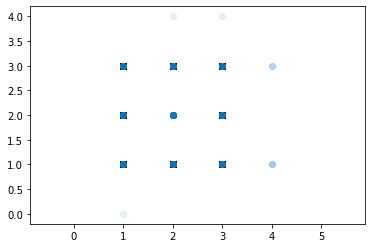

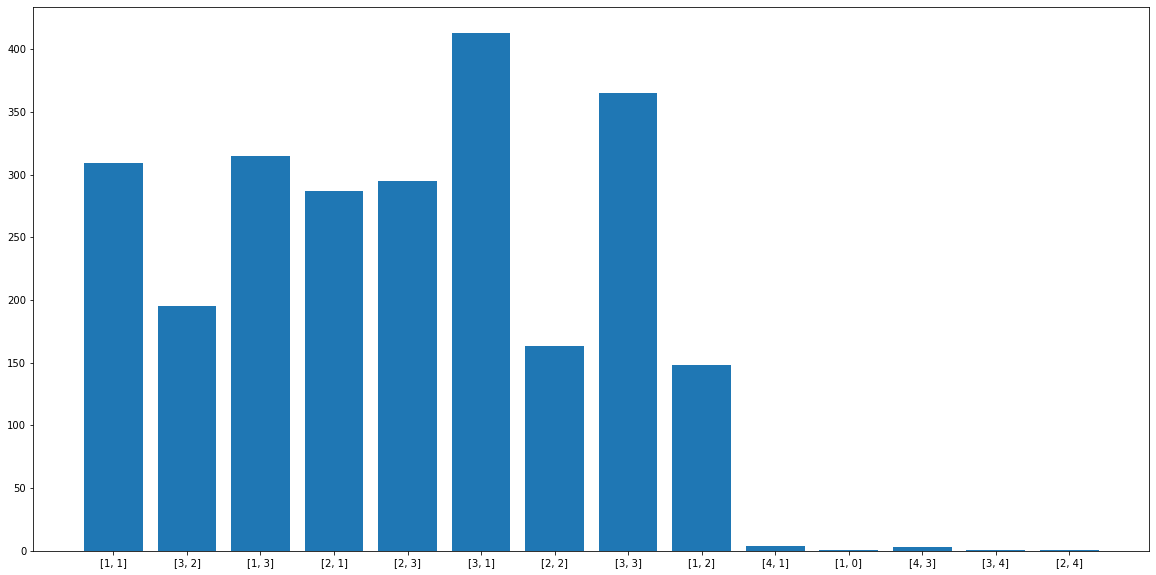

Processing Epoch 167
training start
Iteration 0, d real/fake loss 0.5885430574417114/0.6175735592842102 and g loss is 0.7895440459251404, NDiv loss 0.12063458561897278
Iteration 1, d real/fake loss 0.588566243648529/0.6178464889526367 and g loss is 0.7785851955413818, NDiv loss 0.12048329412937164
Iteration 2, d real/fake loss 0.588567852973938/0.6076624393463135 and g loss is 0.7795564532279968, NDiv loss 0.1196337640285492
Iteration 3, d real/fake loss 0.5885319709777832/0.6188828945159912 and g loss is 0.777764081954956, NDiv loss 0.12415650486946106
Iteration 4, d real/fake loss 0.5884825587272644/0.6196582317352295 and g loss is 0.7836047410964966, NDiv loss 0.11830069869756699


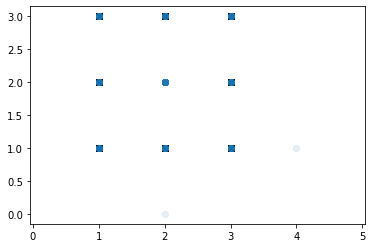

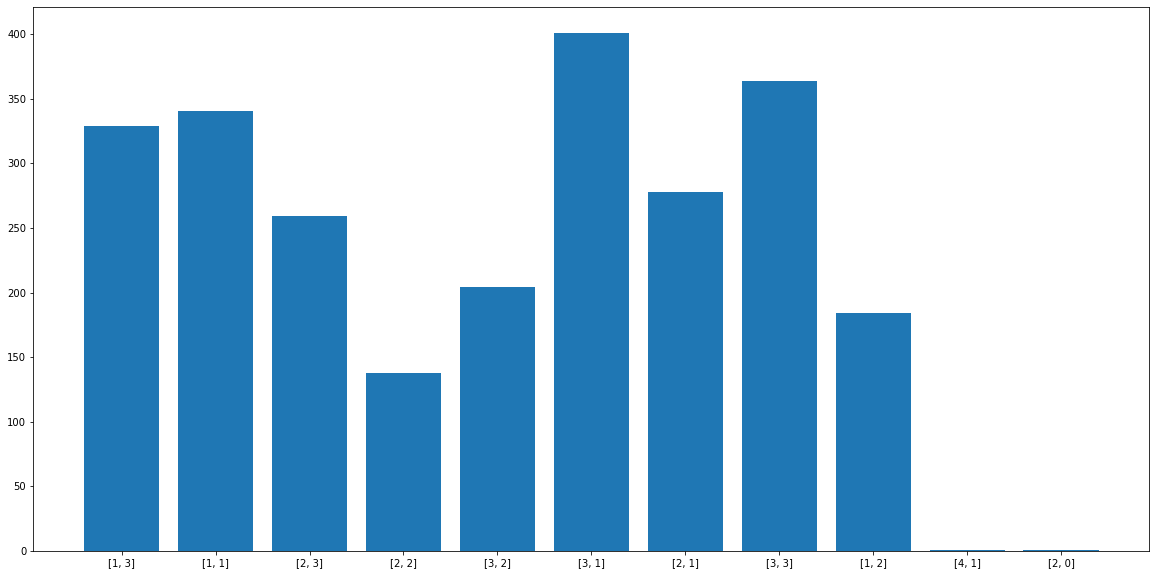

Processing Epoch 168
training start
Iteration 0, d real/fake loss 0.5865885019302368/0.6171677708625793 and g loss is 0.7846816778182983, NDiv loss 0.12161502242088318
Iteration 1, d real/fake loss 0.5865025520324707/0.6128525733947754 and g loss is 0.7808151245117188, NDiv loss 0.1203109472990036
Iteration 2, d real/fake loss 0.5864130258560181/0.6132213473320007 and g loss is 0.7856336236000061, NDiv loss 0.11831400543451309
Iteration 3, d real/fake loss 0.5863176584243774/0.6093235611915588 and g loss is 0.7822501063346863, NDiv loss 0.12509603798389435
Iteration 4, d real/fake loss 0.5862113237380981/0.6129487752914429 and g loss is 0.7908884286880493, NDiv loss 0.1288471668958664


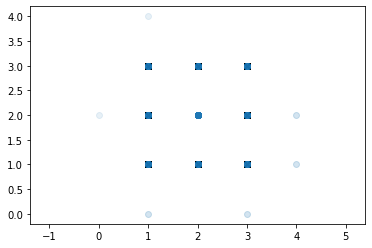

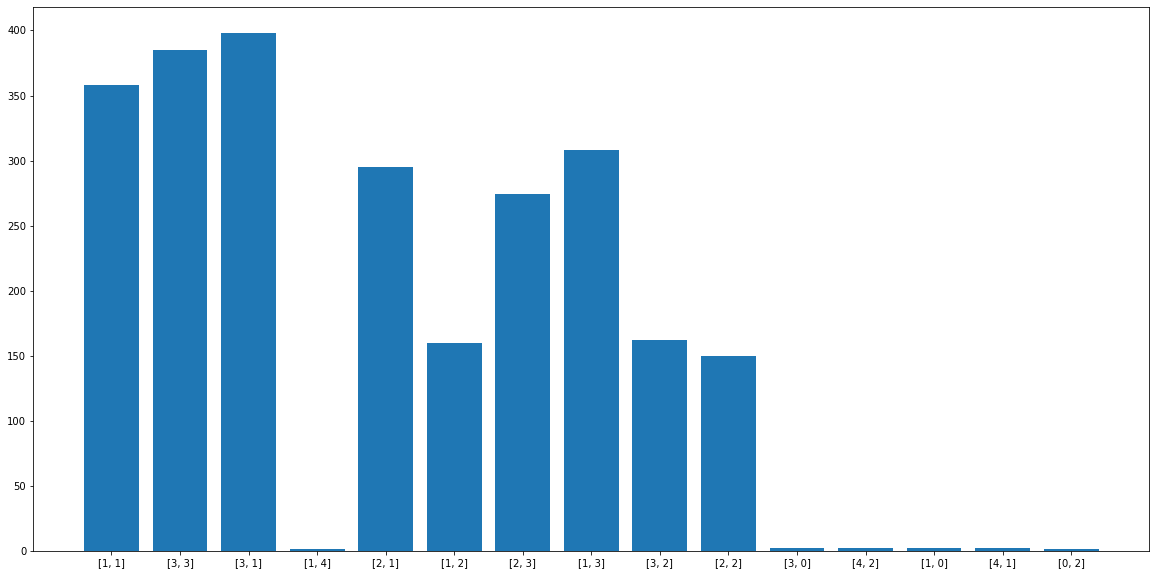

Processing Epoch 169
training start
Iteration 0, d real/fake loss 0.5859129428863525/0.6108498573303223 and g loss is 0.795697033405304, NDiv loss 0.11831717938184738
Iteration 1, d real/fake loss 0.5857898592948914/0.6169079542160034 and g loss is 0.7857324481010437, NDiv loss 0.12602536380290985
Iteration 2, d real/fake loss 0.5856688022613525/0.5981588363647461 and g loss is 0.779934287071228, NDiv loss 0.12465368211269379
Iteration 3, d real/fake loss 0.5855215191841125/0.6178542971611023 and g loss is 0.7789032459259033, NDiv loss 0.12248533219099045
Iteration 4, d real/fake loss 0.5853763818740845/0.6166843771934509 and g loss is 0.7946233749389648, NDiv loss 0.12246952950954437


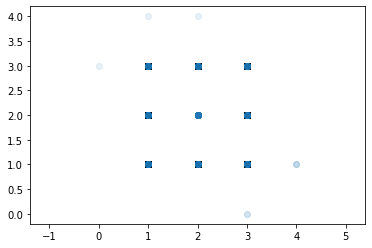

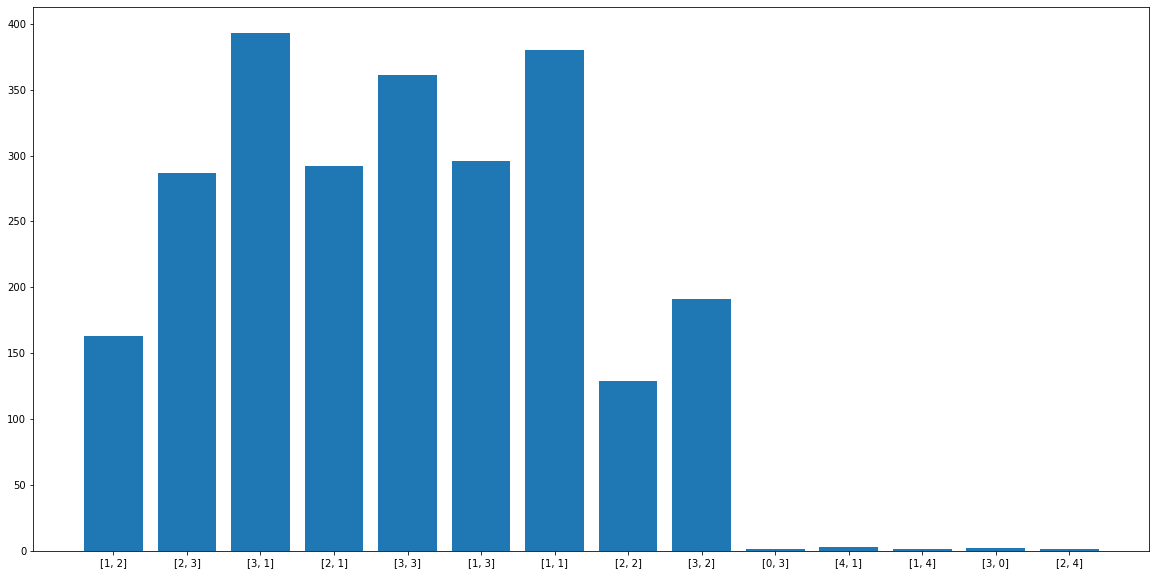

Processing Epoch 170
training start
Iteration 0, d real/fake loss 0.5870651602745056/0.6125263571739197 and g loss is 0.7941199541091919, NDiv loss 0.12176994234323502
Iteration 1, d real/fake loss 0.5869621634483337/0.6154855489730835 and g loss is 0.7889851331710815, NDiv loss 0.11557070910930634
Iteration 2, d real/fake loss 0.5868587493896484/0.6184580326080322 and g loss is 0.7848514318466187, NDiv loss 0.1166166439652443
Iteration 3, d real/fake loss 0.586753785610199/0.6162314414978027 and g loss is 0.7902899980545044, NDiv loss 0.12005352973937988
Iteration 4, d real/fake loss 0.5866498947143555/0.6135376691818237 and g loss is 0.7843066453933716, NDiv loss 0.1182374432682991


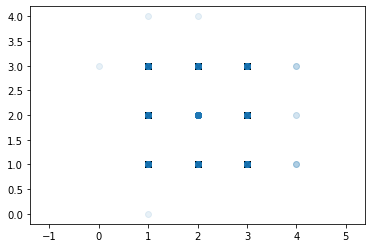

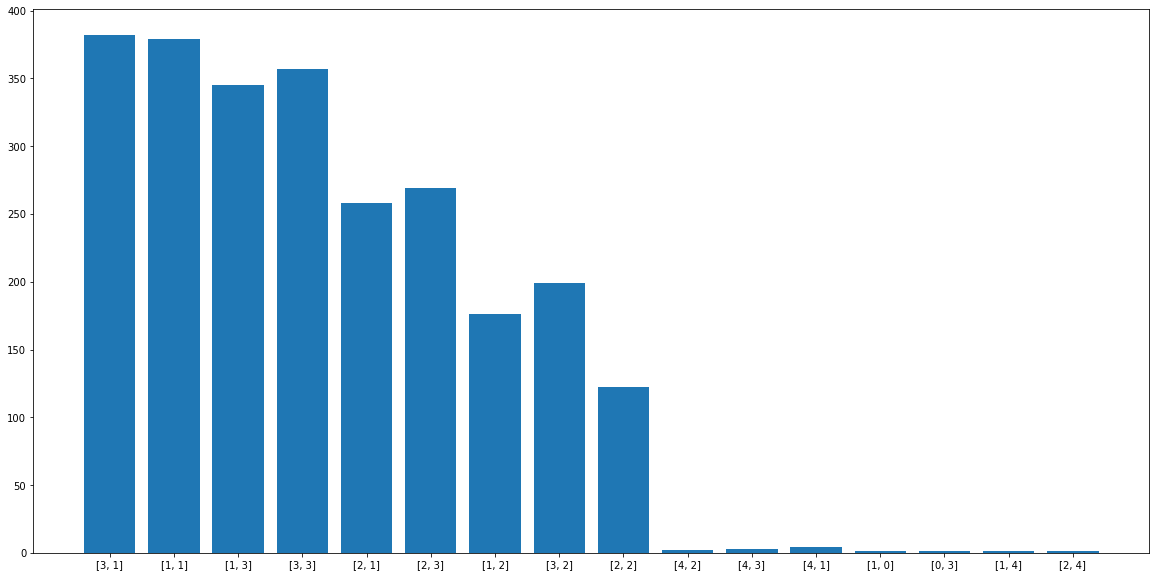

Processing Epoch 171
training start
Iteration 0, d real/fake loss 0.5863558053970337/0.6234896183013916 and g loss is 0.7884932160377502, NDiv loss 0.12493976205587387
Iteration 1, d real/fake loss 0.5862573385238647/0.6065058708190918 and g loss is 0.7936019897460938, NDiv loss 0.12300629168748856
Iteration 2, d real/fake loss 0.5861513614654541/0.6100009083747864 and g loss is 0.788598895072937, NDiv loss 0.12028298527002335
Iteration 3, d real/fake loss 0.586040735244751/0.6110727190971375 and g loss is 0.7878055572509766, NDiv loss 0.1221567690372467
Iteration 4, d real/fake loss 0.585922360420227/0.6257959008216858 and g loss is 0.7941234111785889, NDiv loss 0.12141469866037369


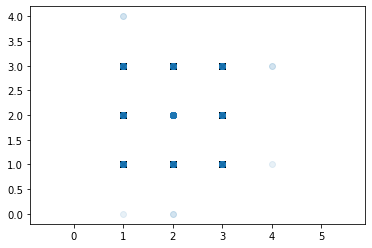

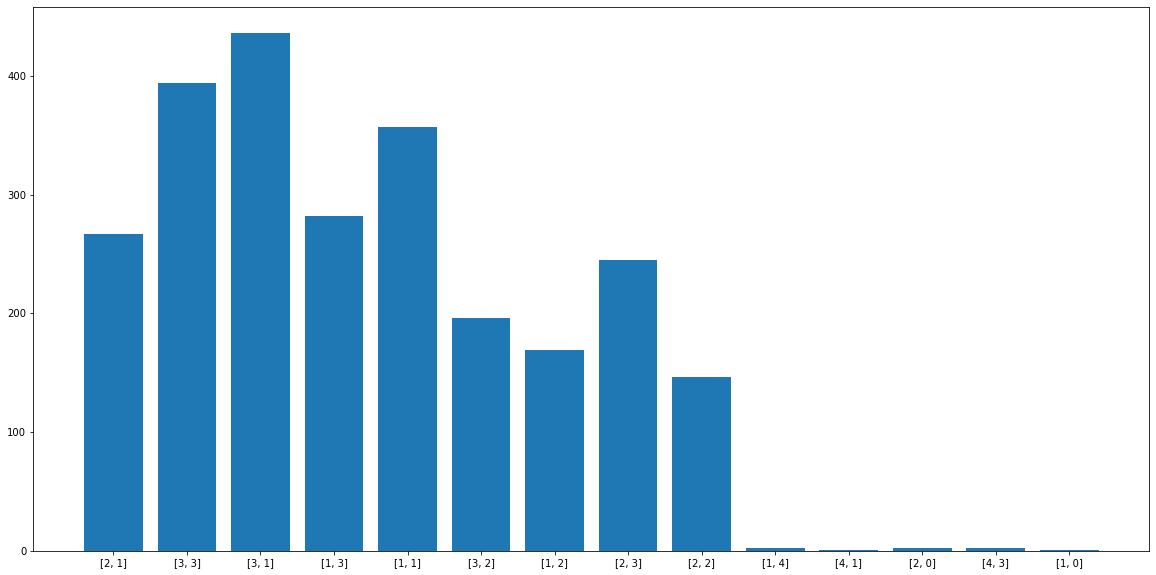

Processing Epoch 172
training start
Iteration 0, d real/fake loss 0.5840234160423279/0.6133157014846802 and g loss is 0.7789844274520874, NDiv loss 0.11737857013940811
Iteration 1, d real/fake loss 0.5839403867721558/0.6116788983345032 and g loss is 0.7831931114196777, NDiv loss 0.122189961373806
Iteration 2, d real/fake loss 0.5838454365730286/0.6093612313270569 and g loss is 0.7724447846412659, NDiv loss 0.12227782607078552
Iteration 3, d real/fake loss 0.583742618560791/0.6162269115447998 and g loss is 0.7908890247344971, NDiv loss 0.11962699890136719
Iteration 4, d real/fake loss 0.5836432576179504/0.6055846214294434 and g loss is 0.7872135043144226, NDiv loss 0.12344323843717575


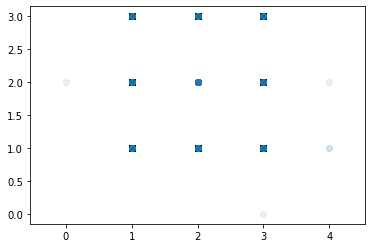

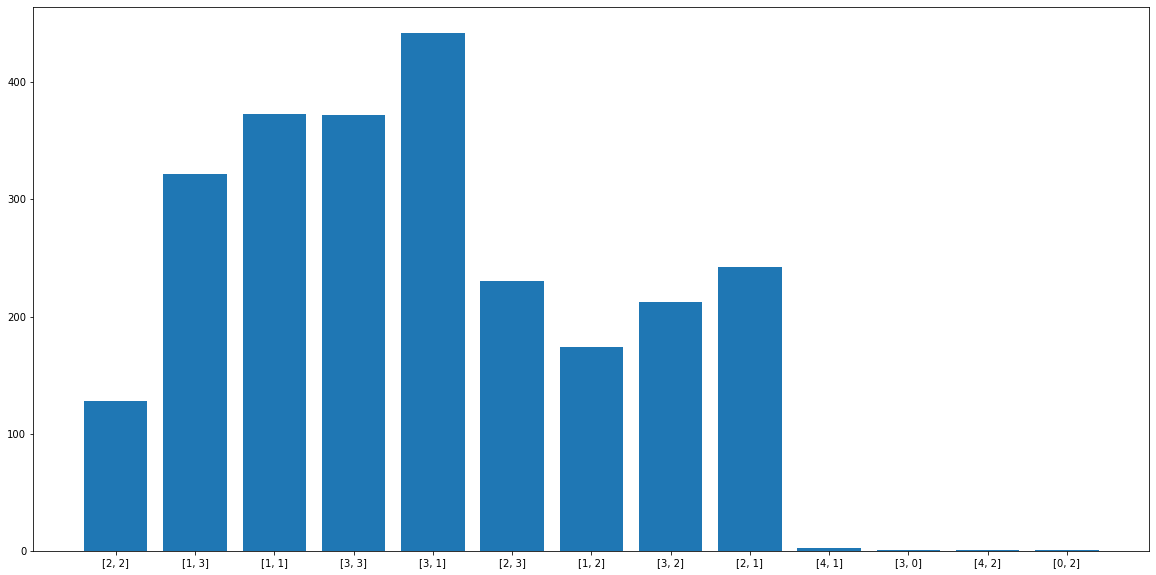

Processing Epoch 173
training start
Iteration 0, d real/fake loss 0.5842681527137756/0.5984745025634766 and g loss is 0.7851794958114624, NDiv loss 0.12090067565441132
Iteration 1, d real/fake loss 0.5841521620750427/0.5987304449081421 and g loss is 0.783661961555481, NDiv loss 0.12101303040981293
Iteration 2, d real/fake loss 0.5840001106262207/0.6081409454345703 and g loss is 0.7844760417938232, NDiv loss 0.11661709100008011
Iteration 3, d real/fake loss 0.5838407874107361/0.6076829433441162 and g loss is 0.8016761541366577, NDiv loss 0.12243274599313736
Iteration 4, d real/fake loss 0.5836753249168396/0.601421594619751 and g loss is 0.7845857739448547, NDiv loss 0.1182415634393692


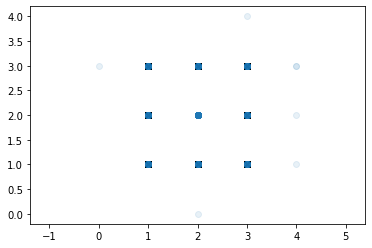

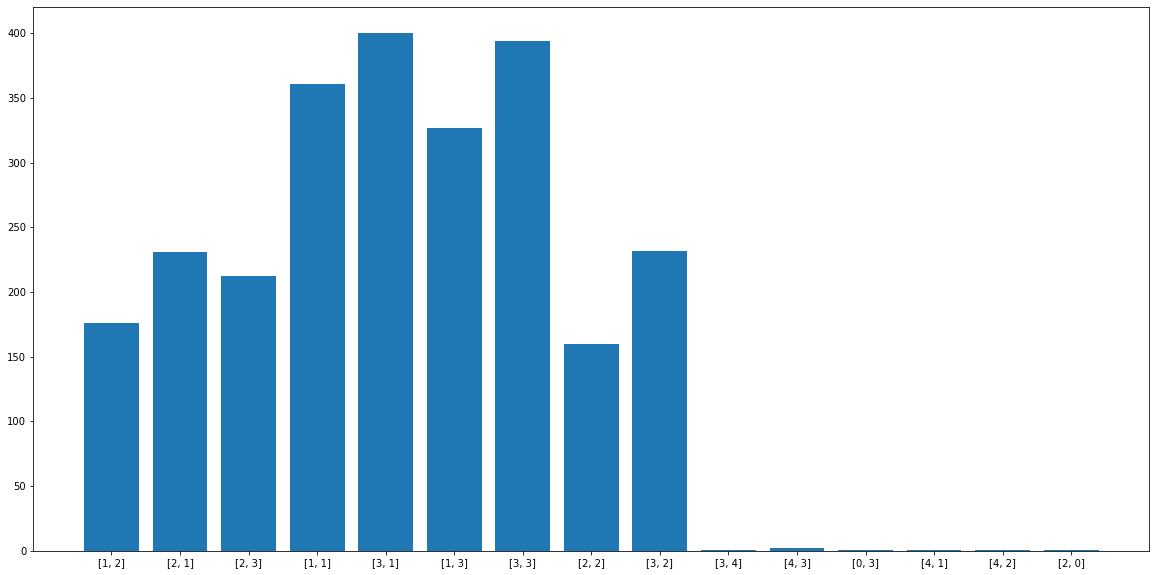

Processing Epoch 174
training start
Iteration 0, d real/fake loss 0.5849069356918335/0.6157565712928772 and g loss is 0.7934983372688293, NDiv loss 0.1199517771601677
Iteration 1, d real/fake loss 0.5847354531288147/0.5943096876144409 and g loss is 0.799521803855896, NDiv loss 0.12338785827159882
Iteration 2, d real/fake loss 0.5845333337783813/0.6078199148178101 and g loss is 0.7814105749130249, NDiv loss 0.1264098733663559
Iteration 3, d real/fake loss 0.5843285918235779/0.6041389107704163 and g loss is 0.7947200536727905, NDiv loss 0.12268058955669403
Iteration 4, d real/fake loss 0.5841129422187805/0.61434006690979 and g loss is 0.79248046875, NDiv loss 0.12938839197158813


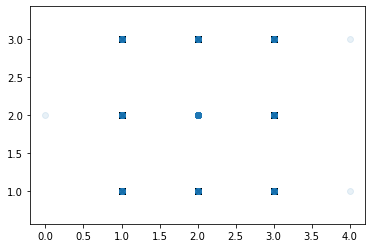

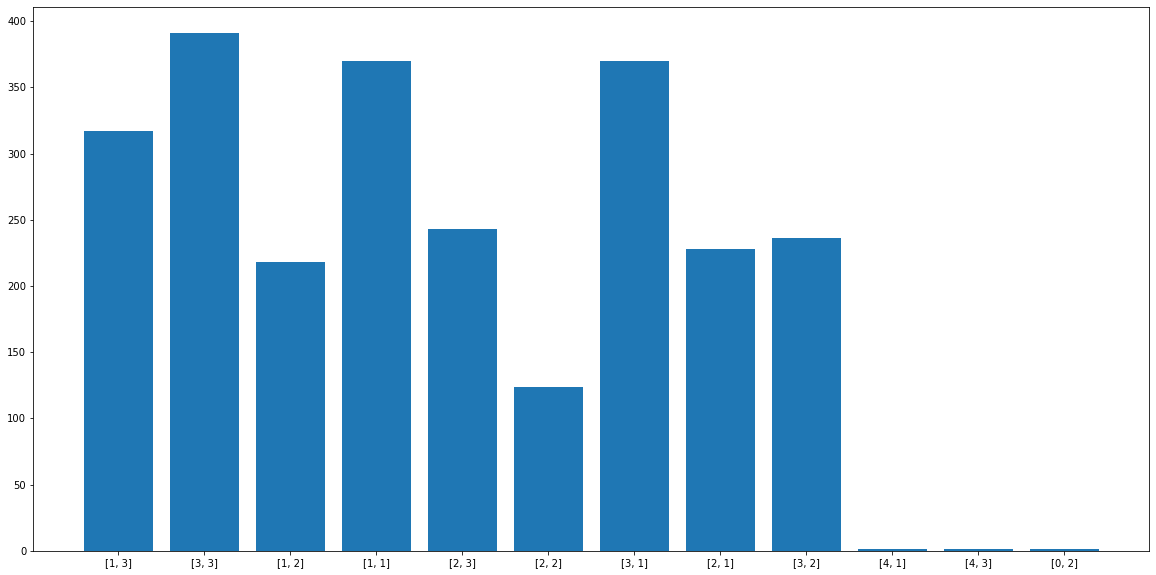

Processing Epoch 175
training start
Iteration 0, d real/fake loss 0.5835721492767334/0.6145045757293701 and g loss is 0.7977584004402161, NDiv loss 0.12162894755601883
Iteration 1, d real/fake loss 0.5833929777145386/0.6055952310562134 and g loss is 0.8003824949264526, NDiv loss 0.12273552268743515
Iteration 2, d real/fake loss 0.5831959247589111/0.6145395040512085 and g loss is 0.7856470346450806, NDiv loss 0.12772414088249207
Iteration 3, d real/fake loss 0.583003044128418/0.6083996891975403 and g loss is 0.7787390351295471, NDiv loss 0.1181410700082779
Iteration 4, d real/fake loss 0.5828074216842651/0.6102317571640015 and g loss is 0.7907043695449829, NDiv loss 0.12112738937139511


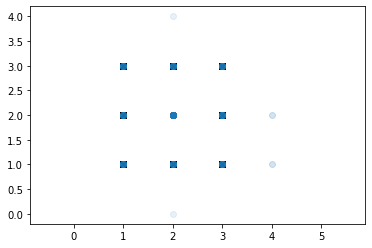

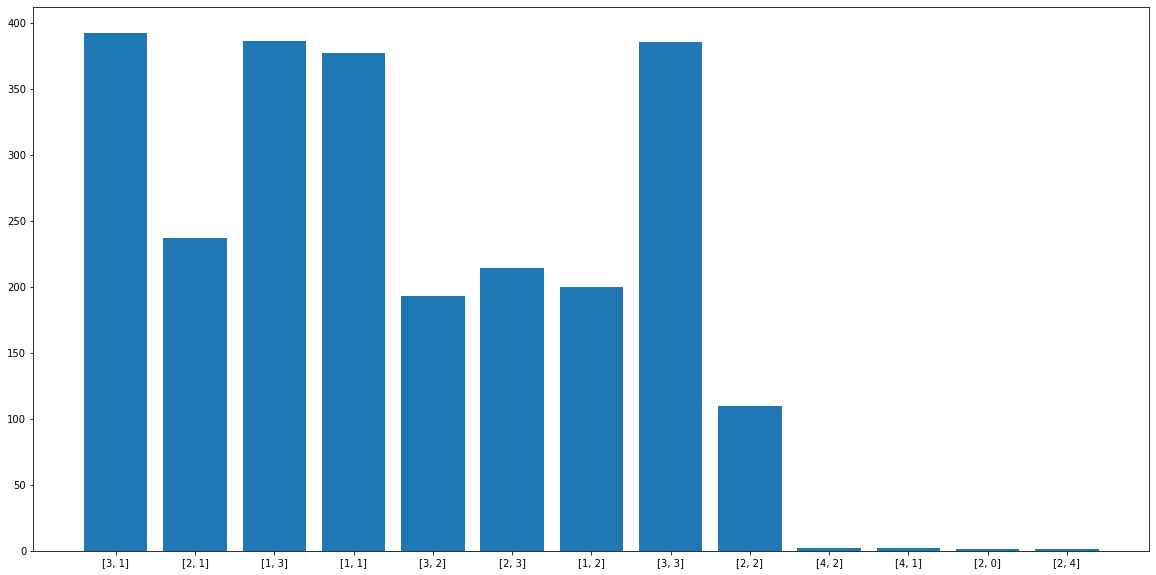

Processing Epoch 176
training start
Iteration 0, d real/fake loss 0.5825122594833374/0.6102319359779358 and g loss is 0.7970782518386841, NDiv loss 0.1205543652176857
Iteration 1, d real/fake loss 0.5822741985321045/0.6122663617134094 and g loss is 0.7802430391311646, NDiv loss 0.11820218712091446
Iteration 2, d real/fake loss 0.582032322883606/0.6110379695892334 and g loss is 0.787140965461731, NDiv loss 0.12120471149682999
Iteration 3, d real/fake loss 0.5817790031433105/0.6061562895774841 and g loss is 0.7950078845024109, NDiv loss 0.12709107995033264
Iteration 4, d real/fake loss 0.581504762172699/0.6132808923721313 and g loss is 0.791555643081665, NDiv loss 0.12264271080493927


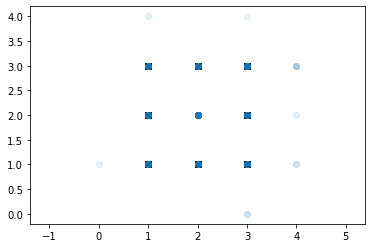

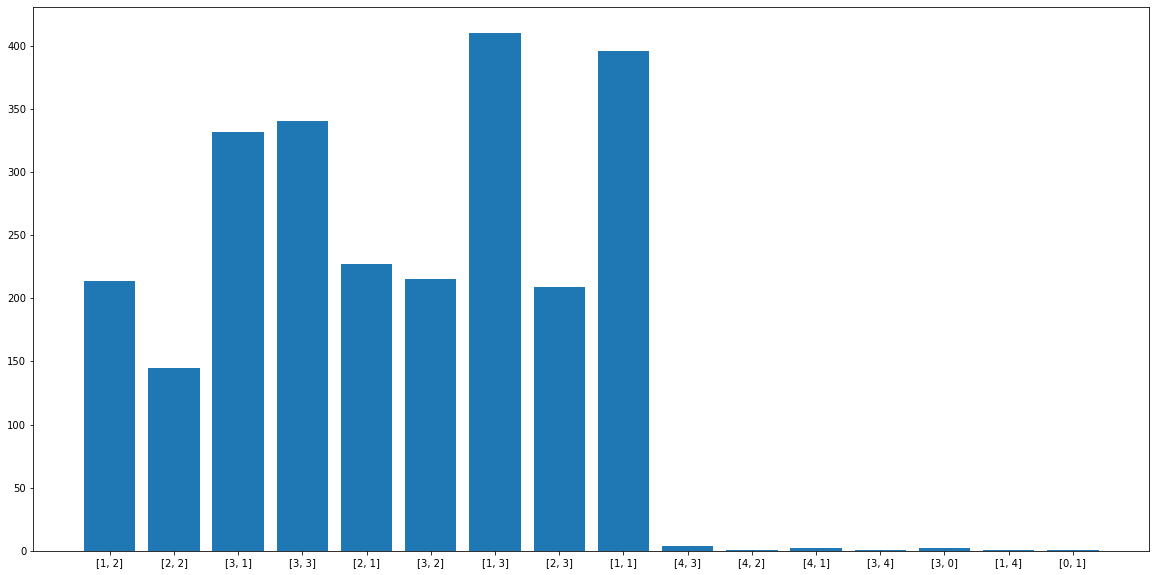

Processing Epoch 177
training start
Iteration 0, d real/fake loss 0.578732430934906/0.6161623001098633 and g loss is 0.7915311455726624, NDiv loss 0.12713876366615295
Iteration 1, d real/fake loss 0.5785129070281982/0.6127209663391113 and g loss is 0.7892692685127258, NDiv loss 0.12501078844070435
Iteration 2, d real/fake loss 0.5782864689826965/0.6052477359771729 and g loss is 0.7883225083351135, NDiv loss 0.12001820653676987
Iteration 3, d real/fake loss 0.5780481696128845/0.6063273549079895 and g loss is 0.7919815182685852, NDiv loss 0.12162226438522339
Iteration 4, d real/fake loss 0.5777997970581055/0.6018112897872925 and g loss is 0.7931907176971436, NDiv loss 0.12435770034790039


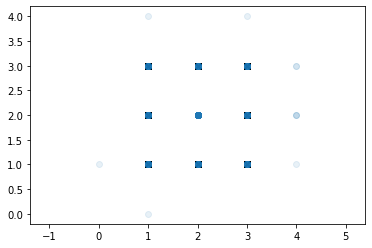

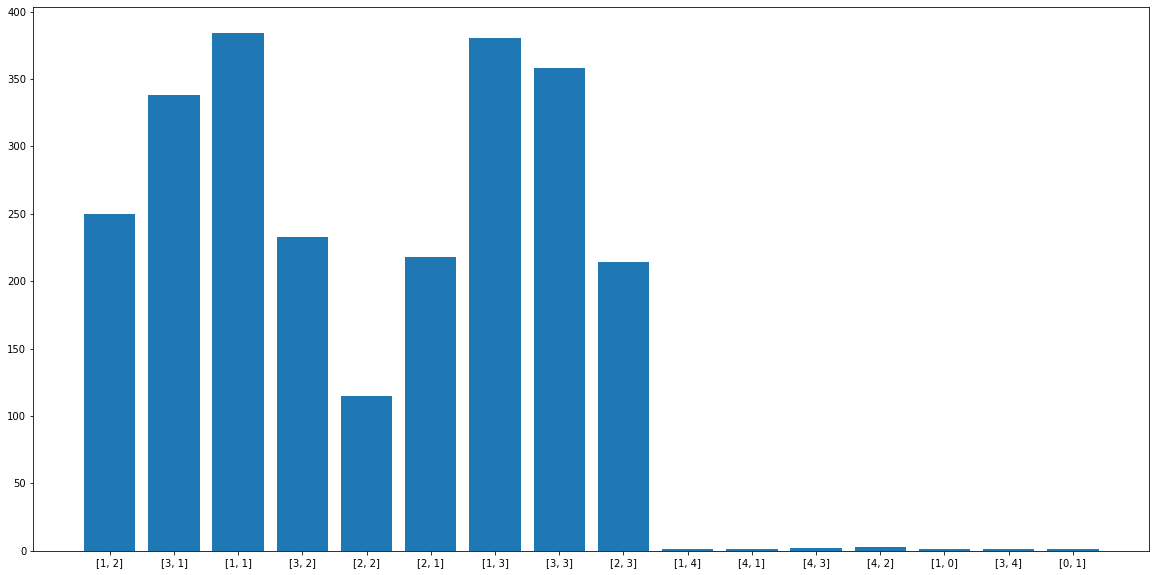

Processing Epoch 178
training start
Iteration 0, d real/fake loss 0.5771462321281433/0.605862021446228 and g loss is 0.7835423946380615, NDiv loss 0.1216147392988205
Iteration 1, d real/fake loss 0.5768933296203613/0.6097142696380615 and g loss is 0.7831382155418396, NDiv loss 0.12366798520088196
Iteration 2, d real/fake loss 0.5766432881355286/0.6114146113395691 and g loss is 0.798363208770752, NDiv loss 0.1242436096072197
Iteration 3, d real/fake loss 0.5763974189758301/0.6009699106216431 and g loss is 0.7909507155418396, NDiv loss 0.11987822502851486
Iteration 4, d real/fake loss 0.5761358737945557/0.6038510799407959 and g loss is 0.787494421005249, NDiv loss 0.12110378593206406


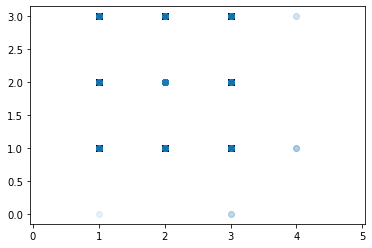

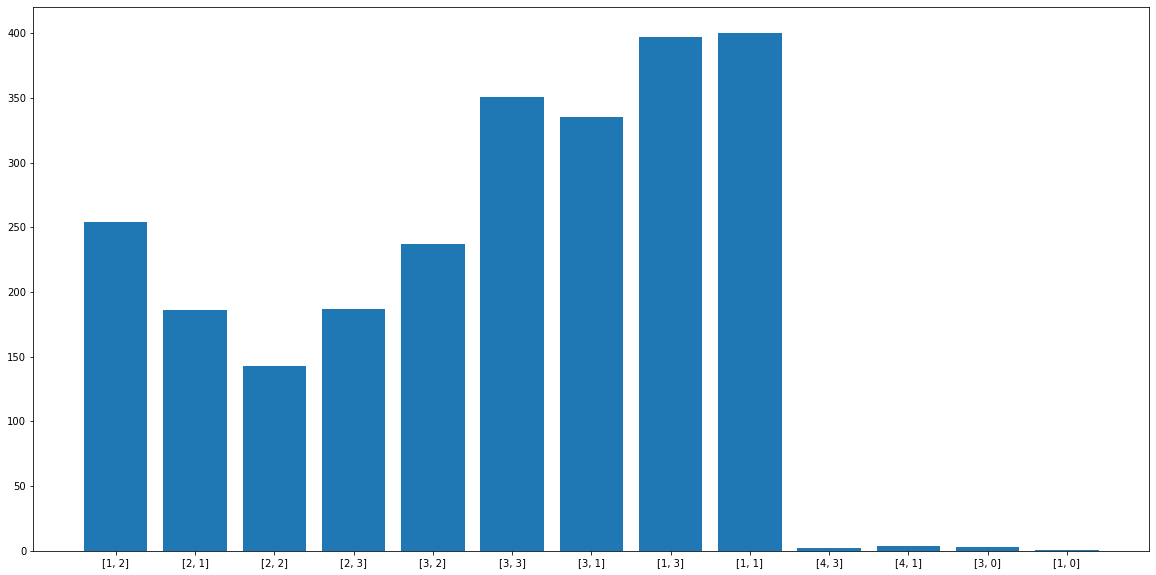

Processing Epoch 179
training start
Iteration 0, d real/fake loss 0.5788030624389648/0.5985927581787109 and g loss is 0.7881300449371338, NDiv loss 0.12401621043682098
Iteration 1, d real/fake loss 0.5785439014434814/0.620367705821991 and g loss is 0.7881941199302673, NDiv loss 0.11955631524324417
Iteration 2, d real/fake loss 0.5782996416091919/0.611545205116272 and g loss is 0.7946081757545471, NDiv loss 0.12257850915193558
Iteration 3, d real/fake loss 0.5780491828918457/0.610434353351593 and g loss is 0.7958757877349854, NDiv loss 0.12041652947664261
Iteration 4, d real/fake loss 0.5777908563613892/0.6071882247924805 and g loss is 0.7902260422706604, NDiv loss 0.1211317703127861


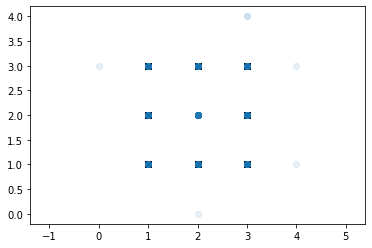

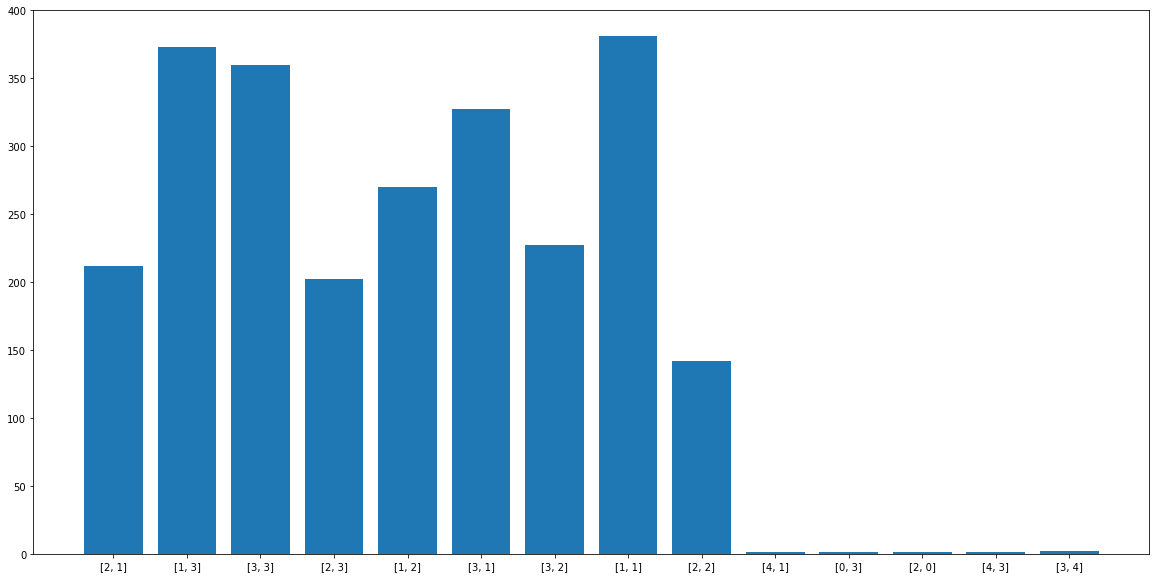

Processing Epoch 180
training start
Iteration 0, d real/fake loss 0.5784132480621338/0.609401524066925 and g loss is 0.782975971698761, NDiv loss 0.12466905266046524
Iteration 1, d real/fake loss 0.5782657265663147/0.6174768209457397 and g loss is 0.7898375988006592, NDiv loss 0.12310998886823654
Iteration 2, d real/fake loss 0.5781323909759521/0.6168383955955505 and g loss is 0.7916600704193115, NDiv loss 0.12618395686149597
Iteration 3, d real/fake loss 0.5780125856399536/0.6126299500465393 and g loss is 0.797102689743042, NDiv loss 0.12334845215082169
Iteration 4, d real/fake loss 0.5778976678848267/0.604438066482544 and g loss is 0.7902038097381592, NDiv loss 0.12568563222885132


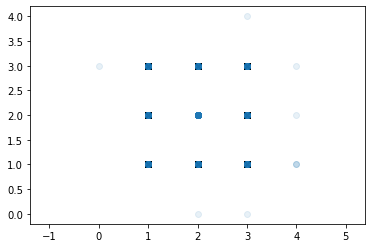

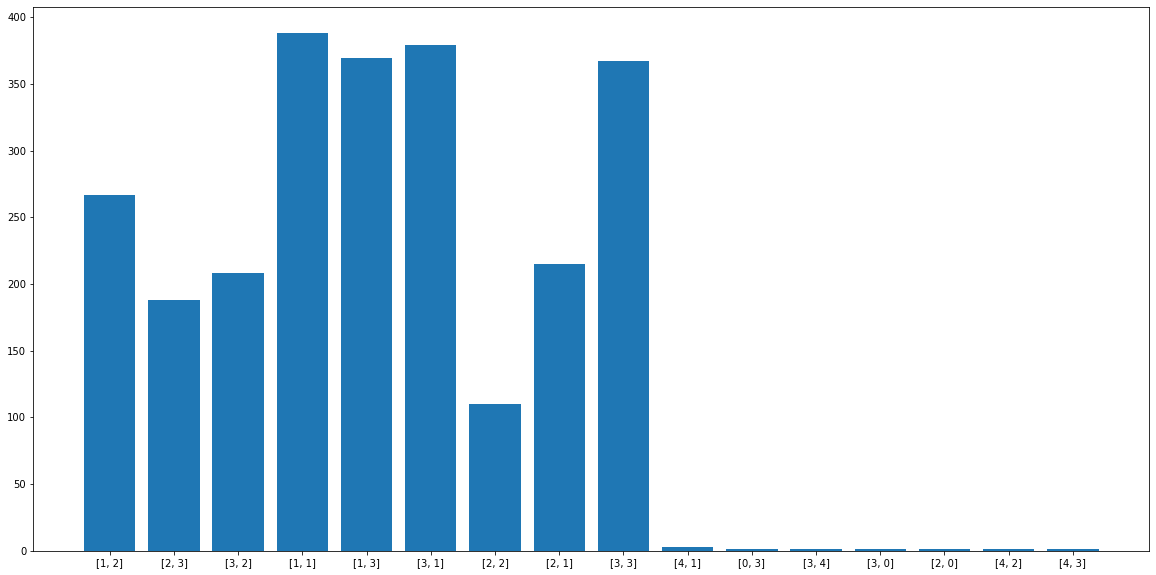

Processing Epoch 181
training start
Iteration 0, d real/fake loss 0.576592743396759/0.6038730144500732 and g loss is 0.7815762758255005, NDiv loss 0.12260313332080841
Iteration 1, d real/fake loss 0.5764684677124023/0.6074421405792236 and g loss is 0.7819809913635254, NDiv loss 0.12204761803150177
Iteration 2, d real/fake loss 0.5763272047042847/0.6021326184272766 and g loss is 0.8059539794921875, NDiv loss 0.12130048125982285
Iteration 3, d real/fake loss 0.5761699676513672/0.6094284057617188 and g loss is 0.7940542697906494, NDiv loss 0.12015213072299957
Iteration 4, d real/fake loss 0.5760061740875244/0.6059775948524475 and g loss is 0.7900253534317017, NDiv loss 0.12561576068401337


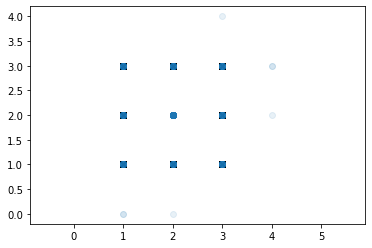

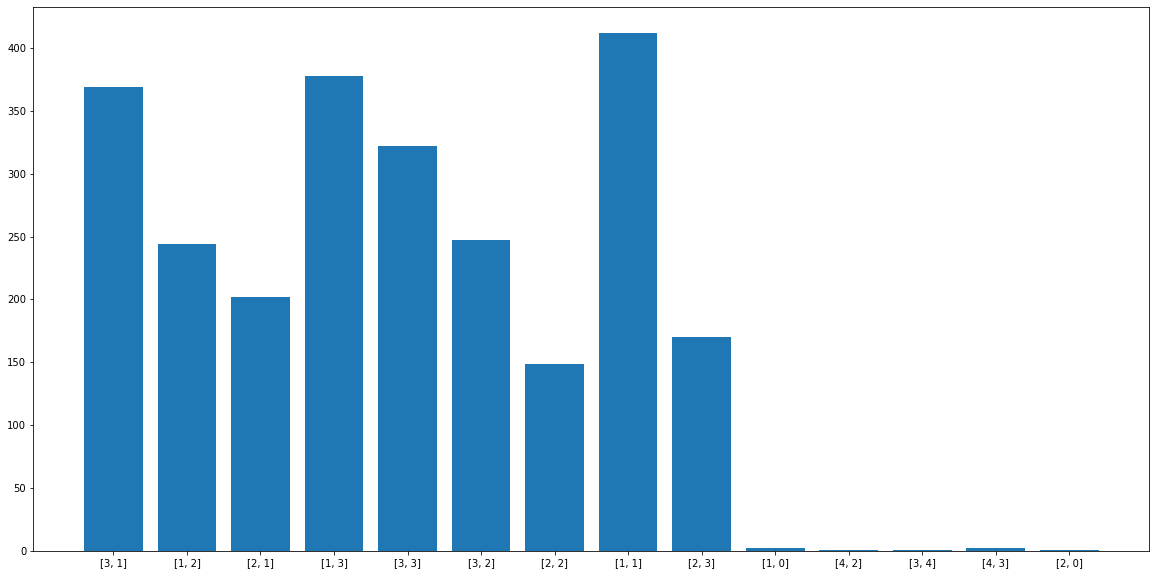

Processing Epoch 182
training start
Iteration 0, d real/fake loss 0.577472448348999/0.6028077602386475 and g loss is 0.7845985889434814, NDiv loss 0.11891422420740128
Iteration 1, d real/fake loss 0.5773556232452393/0.6149945855140686 and g loss is 0.7932320237159729, NDiv loss 0.12067677825689316
Iteration 2, d real/fake loss 0.5772548913955688/0.601275622844696 and g loss is 0.8027148842811584, NDiv loss 0.11996063590049744
Iteration 3, d real/fake loss 0.5771422386169434/0.6094527244567871 and g loss is 0.7802378535270691, NDiv loss 0.11712495237588882
Iteration 4, d real/fake loss 0.5770382881164551/0.6085388660430908 and g loss is 0.7943334579467773, NDiv loss 0.12171953171491623


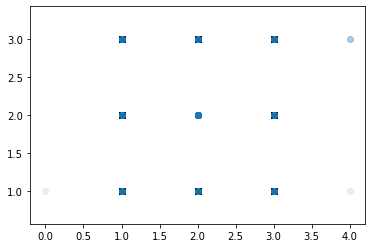

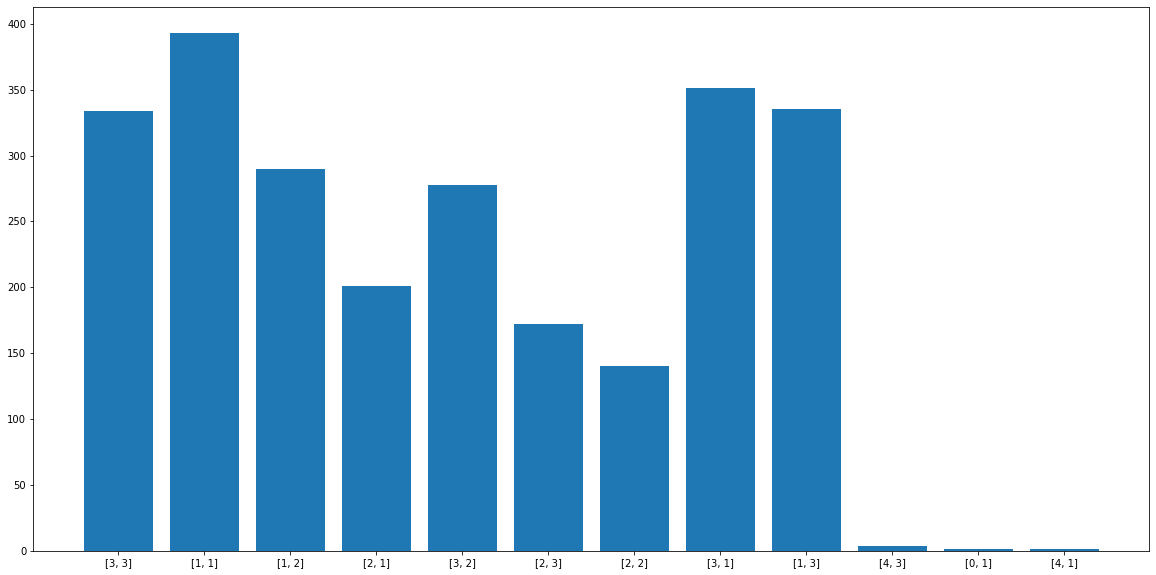

Processing Epoch 183
training start
Iteration 0, d real/fake loss 0.5754387378692627/0.605736494064331 and g loss is 0.7888251543045044, NDiv loss 0.12089661508798599
Iteration 1, d real/fake loss 0.5753142833709717/0.6050742864608765 and g loss is 0.7894664406776428, NDiv loss 0.12390408664941788
Iteration 2, d real/fake loss 0.5751737356185913/0.60004723072052 and g loss is 0.8034532070159912, NDiv loss 0.12351138889789581
Iteration 3, d real/fake loss 0.5750044584274292/0.5999180674552917 and g loss is 0.7944167256355286, NDiv loss 0.11977043002843857
Iteration 4, d real/fake loss 0.5748064517974854/0.6118901968002319 and g loss is 0.7925819754600525, NDiv loss 0.11697576195001602


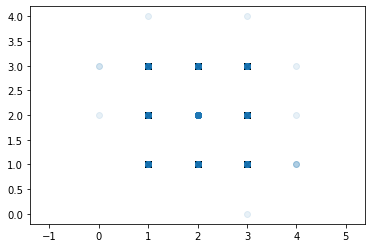

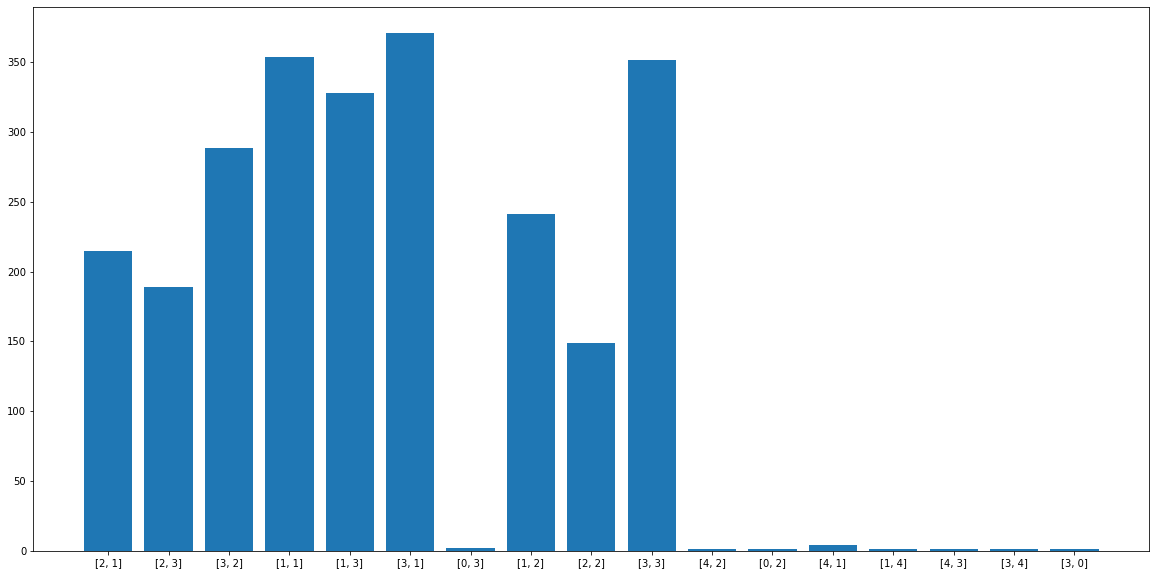

Processing Epoch 184
training start
Iteration 0, d real/fake loss 0.5731251239776611/0.6032668948173523 and g loss is 0.8108313679695129, NDiv loss 0.120461106300354
Iteration 1, d real/fake loss 0.5729308128356934/0.613638162612915 and g loss is 0.7844146490097046, NDiv loss 0.12011438608169556
Iteration 2, d real/fake loss 0.5727447867393494/0.6069838404655457 and g loss is 0.7893036603927612, NDiv loss 0.12379100173711777
Iteration 3, d real/fake loss 0.5725590586662292/0.6076170802116394 and g loss is 0.798486053943634, NDiv loss 0.12366776168346405
Iteration 4, d real/fake loss 0.5723729133605957/0.6088742613792419 and g loss is 0.8025876879692078, NDiv loss 0.12181244790554047


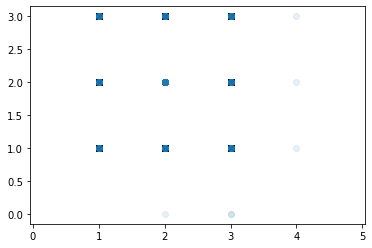

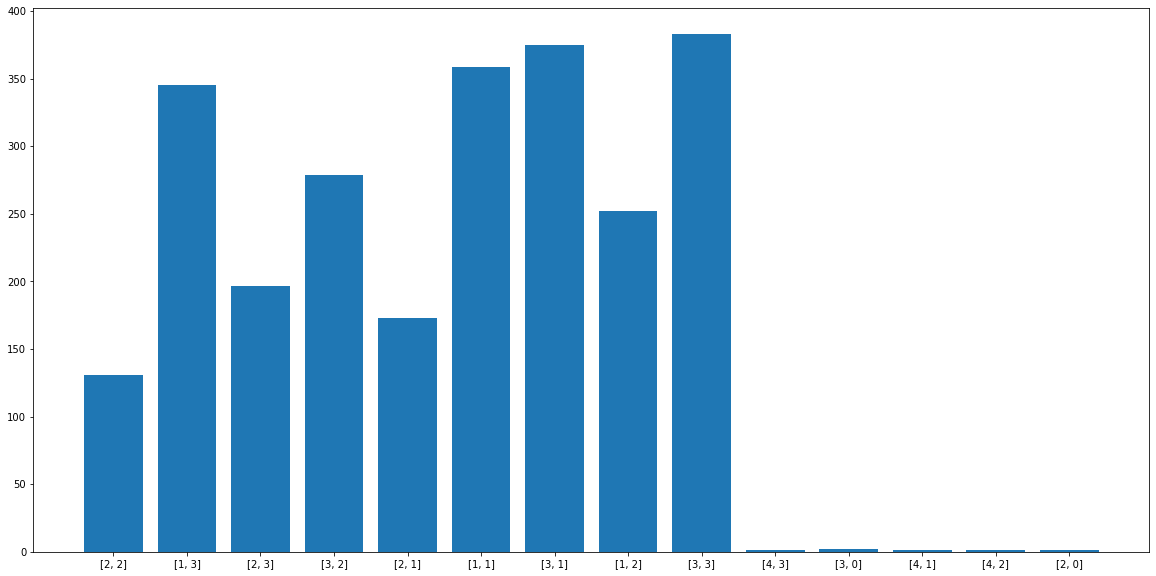

Processing Epoch 185
training start
Iteration 0, d real/fake loss 0.5723309516906738/0.6156755685806274 and g loss is 0.7947592735290527, NDiv loss 0.12477818876504898
Iteration 1, d real/fake loss 0.5721907019615173/0.601022481918335 and g loss is 0.8026124238967896, NDiv loss 0.1212756484746933
Iteration 2, d real/fake loss 0.5720431804656982/0.6117662191390991 and g loss is 0.7898861765861511, NDiv loss 0.11760715395212173
Iteration 3, d real/fake loss 0.5719080567359924/0.6085354685783386 and g loss is 0.7959821820259094, NDiv loss 0.12031085044145584
Iteration 4, d real/fake loss 0.5717872977256775/0.5952379703521729 and g loss is 0.8080015182495117, NDiv loss 0.12247373163700104


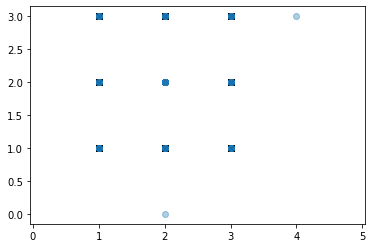

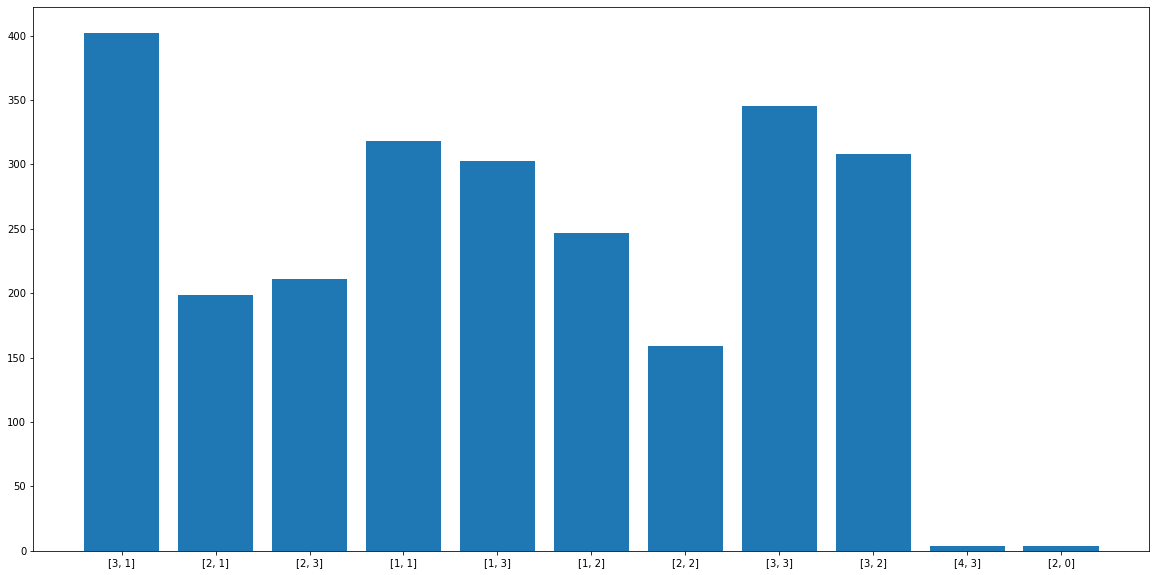

Processing Epoch 186
training start
Iteration 0, d real/fake loss 0.574069619178772/0.5975506901741028 and g loss is 0.7927908301353455, NDiv loss 0.12337089329957962
Iteration 1, d real/fake loss 0.5738860368728638/0.6079882383346558 and g loss is 0.8039032220840454, NDiv loss 0.12144935876131058
Iteration 2, d real/fake loss 0.5736985802650452/0.6111171841621399 and g loss is 0.7998884320259094, NDiv loss 0.12530864775180817
Iteration 3, d real/fake loss 0.5735129714012146/0.5954738855361938 and g loss is 0.7978241443634033, NDiv loss 0.12549546360969543
Iteration 4, d real/fake loss 0.5732934474945068/0.5979219675064087 and g loss is 0.7975607514381409, NDiv loss 0.11775057762861252


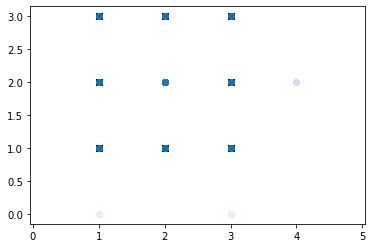

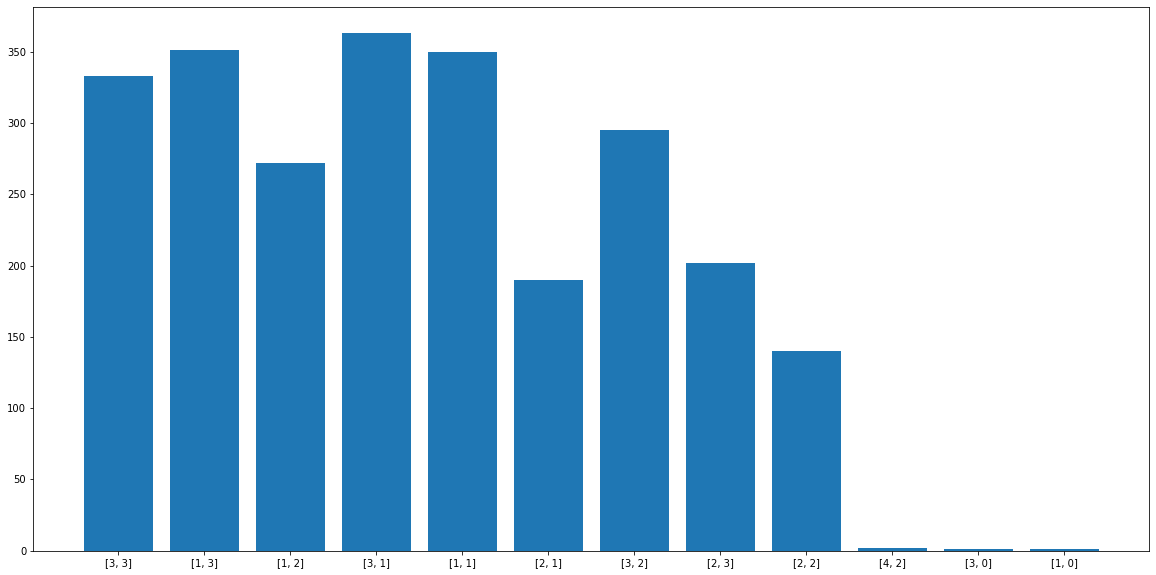

Processing Epoch 187
training start
Iteration 0, d real/fake loss 0.5734078884124756/0.5950168371200562 and g loss is 0.7918468713760376, NDiv loss 0.12652795016765594
Iteration 1, d real/fake loss 0.5731915235519409/0.6034963130950928 and g loss is 0.7852147817611694, NDiv loss 0.12822195887565613
Iteration 2, d real/fake loss 0.5729588270187378/0.6033549308776855 and g loss is 0.8019895553588867, NDiv loss 0.1169528141617775
Iteration 3, d real/fake loss 0.5727201104164124/0.6009882092475891 and g loss is 0.806372880935669, NDiv loss 0.11880172044038773
Iteration 4, d real/fake loss 0.5724639892578125/0.5960487127304077 and g loss is 0.7994884848594666, NDiv loss 0.1214895248413086


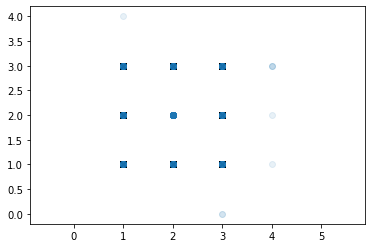

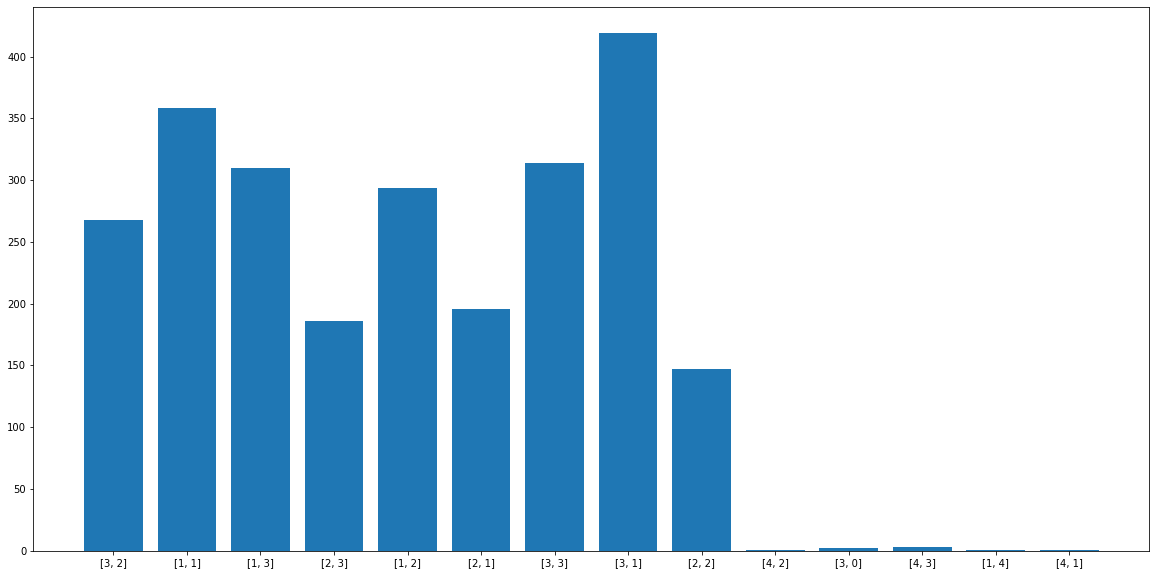

Processing Epoch 188
training start
Iteration 0, d real/fake loss 0.5703961849212646/0.5915807485580444 and g loss is 0.7833496332168579, NDiv loss 0.12443205714225769
Iteration 1, d real/fake loss 0.570101261138916/0.6025022864341736 and g loss is 0.8011578321456909, NDiv loss 0.12322898209095001
Iteration 2, d real/fake loss 0.5698131322860718/0.6005319356918335 and g loss is 0.7996535301208496, NDiv loss 0.12318021804094315
Iteration 3, d real/fake loss 0.5695246458053589/0.598242461681366 and g loss is 0.8061820268630981, NDiv loss 0.12200991809368134
Iteration 4, d real/fake loss 0.5692441463470459/0.5996448993682861 and g loss is 0.7970728874206543, NDiv loss 0.12477736175060272


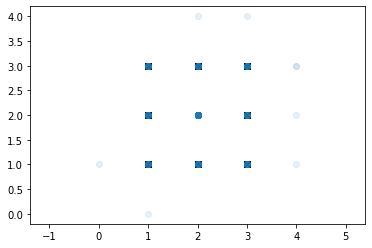

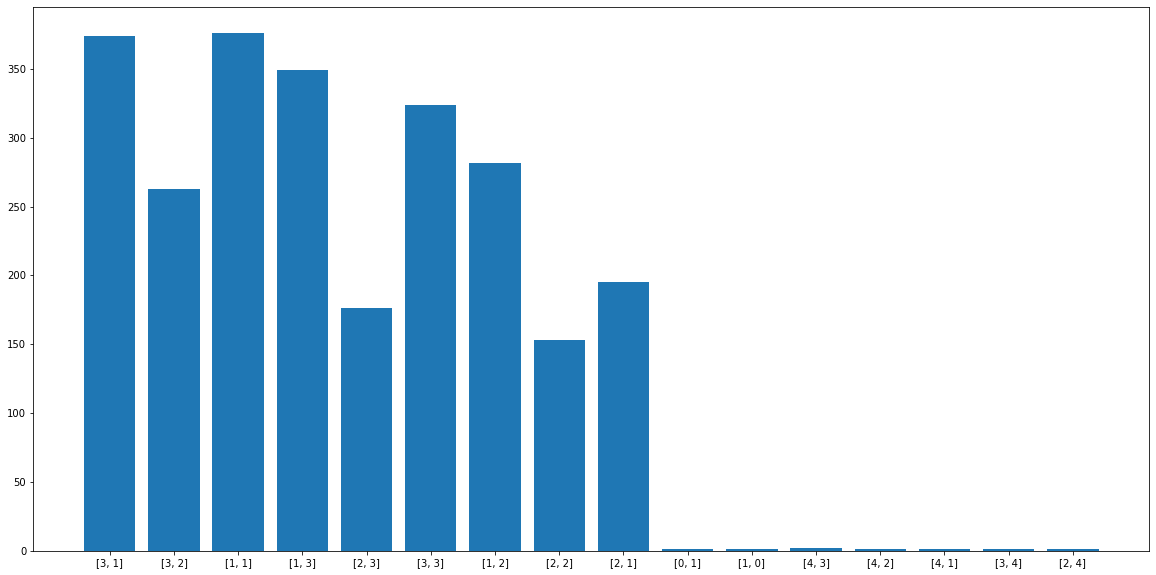

Processing Epoch 189
training start
Iteration 0, d real/fake loss 0.5715591907501221/0.5985147356987 and g loss is 0.8012644052505493, NDiv loss 0.11948356032371521
Iteration 1, d real/fake loss 0.5713000297546387/0.6008453369140625 and g loss is 0.7908177375793457, NDiv loss 0.11988186836242676
Iteration 2, d real/fake loss 0.5710566639900208/0.6054750084877014 and g loss is 0.8231661915779114, NDiv loss 0.12295179814100266
Iteration 3, d real/fake loss 0.5708329081535339/0.6041840314865112 and g loss is 0.7950319051742554, NDiv loss 0.12051591277122498
Iteration 4, d real/fake loss 0.5706049203872681/0.6039551496505737 and g loss is 0.8114652633666992, NDiv loss 0.12333059310913086


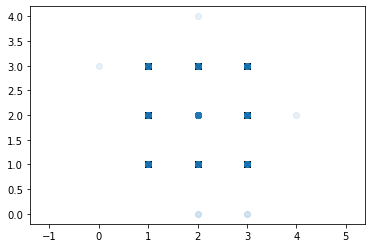

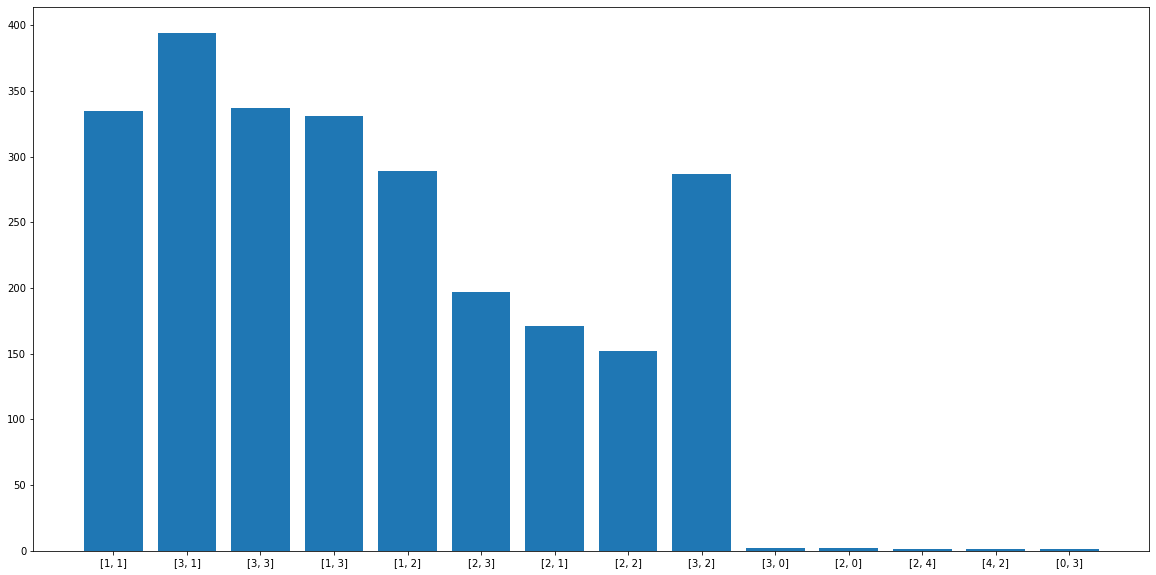

Processing Epoch 190
training start
Iteration 0, d real/fake loss 0.568975567817688/0.5941699743270874 and g loss is 0.8148778080940247, NDiv loss 0.12383461743593216
Iteration 1, d real/fake loss 0.5687490701675415/0.6065512299537659 and g loss is 0.7835181951522827, NDiv loss 0.12093161791563034
Iteration 2, d real/fake loss 0.5685317516326904/0.5972933769226074 and g loss is 0.8095839619636536, NDiv loss 0.11914922297000885
Iteration 3, d real/fake loss 0.5683045983314514/0.5954095125198364 and g loss is 0.8082666397094727, NDiv loss 0.12359195947647095
Iteration 4, d real/fake loss 0.5680612921714783/0.6036593914031982 and g loss is 0.8000959157943726, NDiv loss 0.1314641684293747


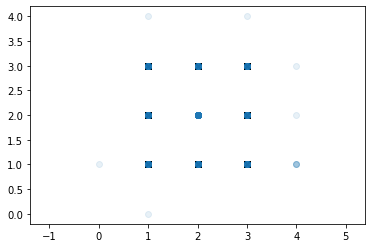

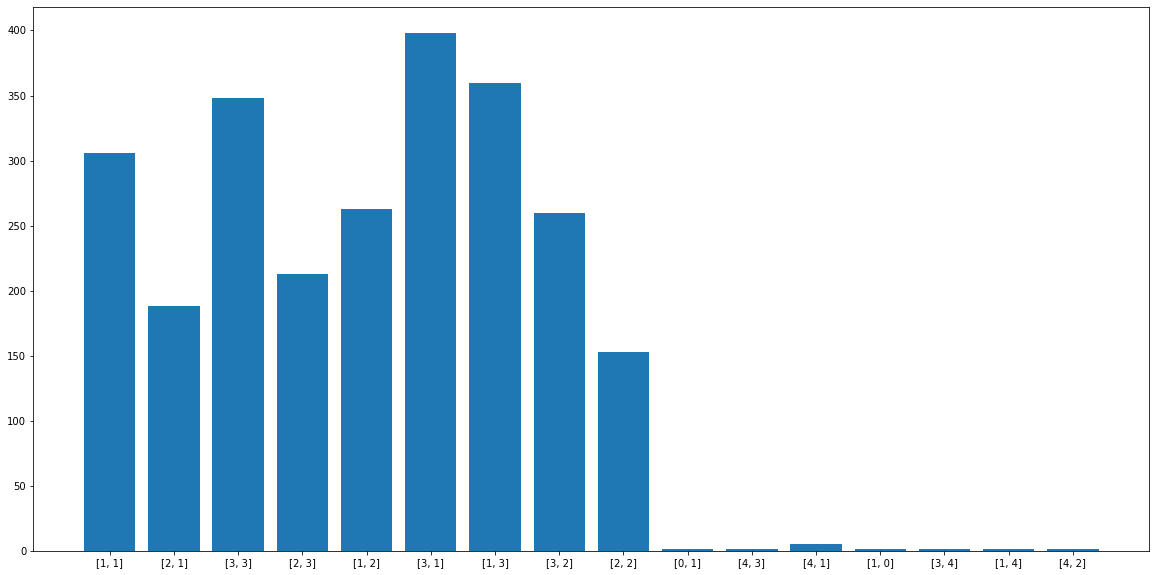

Processing Epoch 191
training start
Iteration 0, d real/fake loss 0.5715086460113525/0.5996735095977783 and g loss is 0.8077200651168823, NDiv loss 0.11637308448553085
Iteration 1, d real/fake loss 0.5713975429534912/0.5984366536140442 and g loss is 0.7962992191314697, NDiv loss 0.12261026352643967
Iteration 2, d real/fake loss 0.5712758302688599/0.6064952611923218 and g loss is 0.8015627861022949, NDiv loss 0.12296538800001144
Iteration 3, d real/fake loss 0.5711526274681091/0.5931827425956726 and g loss is 0.7959726452827454, NDiv loss 0.1198270246386528
Iteration 4, d real/fake loss 0.5710135698318481/0.6014764308929443 and g loss is 0.8017765283584595, NDiv loss 0.12713143229484558


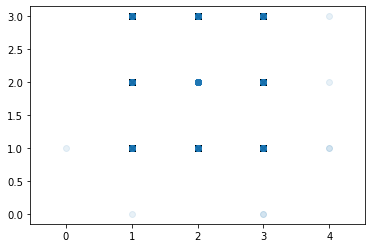

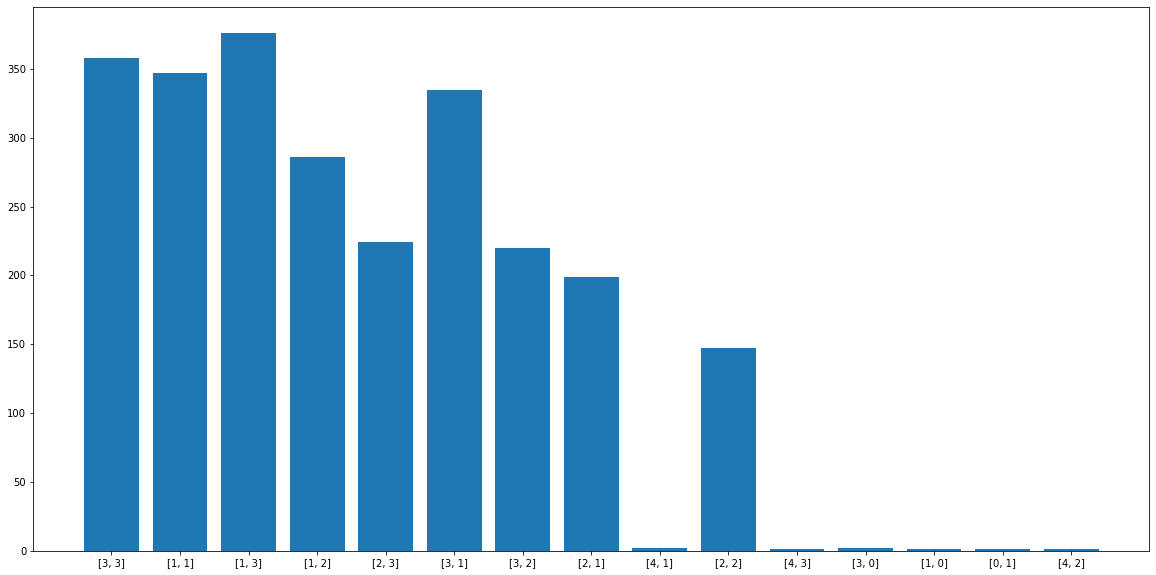

Processing Epoch 192
training start
Iteration 0, d real/fake loss 0.5691078901290894/0.6004542112350464 and g loss is 0.8060848712921143, NDiv loss 0.12132154405117035
Iteration 1, d real/fake loss 0.5689858794212341/0.609060525894165 and g loss is 0.804772138595581, NDiv loss 0.12127943336963654
Iteration 2, d real/fake loss 0.5688830018043518/0.5880274772644043 and g loss is 0.8108067512512207, NDiv loss 0.1200627014040947
Iteration 3, d real/fake loss 0.5687476396560669/0.6018795967102051 and g loss is 0.8004164695739746, NDiv loss 0.12800554931163788
Iteration 4, d real/fake loss 0.5686138868331909/0.6048539280891418 and g loss is 0.8004810810089111, NDiv loss 0.12456859648227692


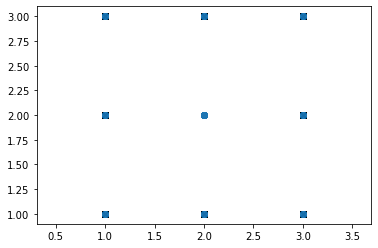

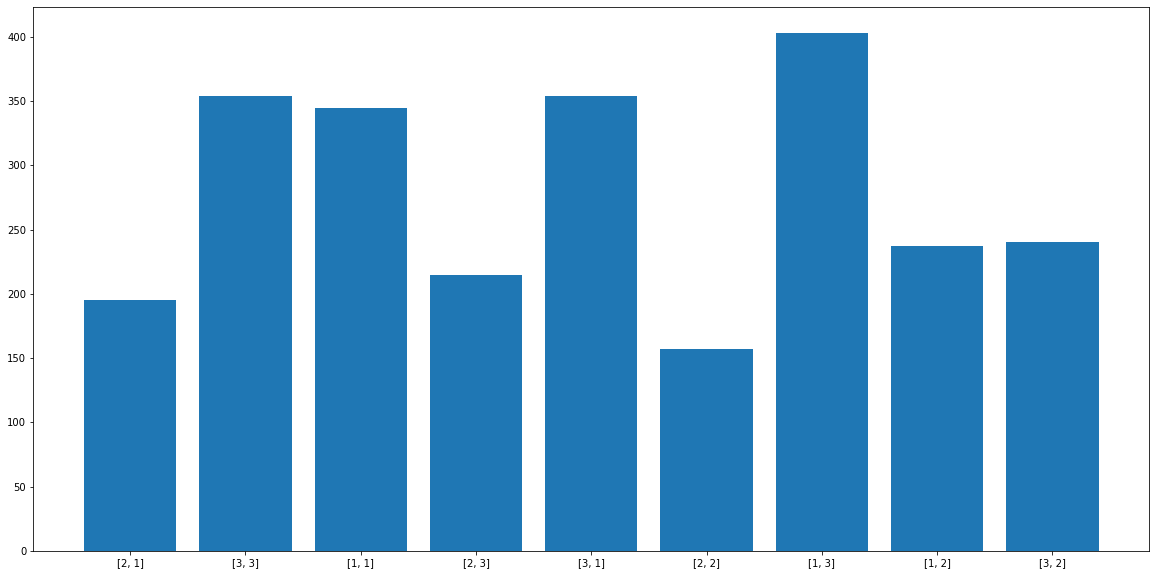

Processing Epoch 193
training start
Iteration 0, d real/fake loss 0.5672774910926819/0.6021748781204224 and g loss is 0.8117157220840454, NDiv loss 0.11971072107553482
Iteration 1, d real/fake loss 0.5671594142913818/0.5932410955429077 and g loss is 0.8059076070785522, NDiv loss 0.1155976876616478
Iteration 2, d real/fake loss 0.5670286417007446/0.5993939638137817 and g loss is 0.8072474002838135, NDiv loss 0.12057659029960632
Iteration 3, d real/fake loss 0.5668975114822388/0.6004122495651245 and g loss is 0.8139894008636475, NDiv loss 0.11893485486507416
Iteration 4, d real/fake loss 0.5667673349380493/0.5916818380355835 and g loss is 0.7818384766578674, NDiv loss 0.119306281208992


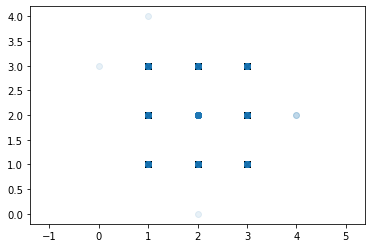

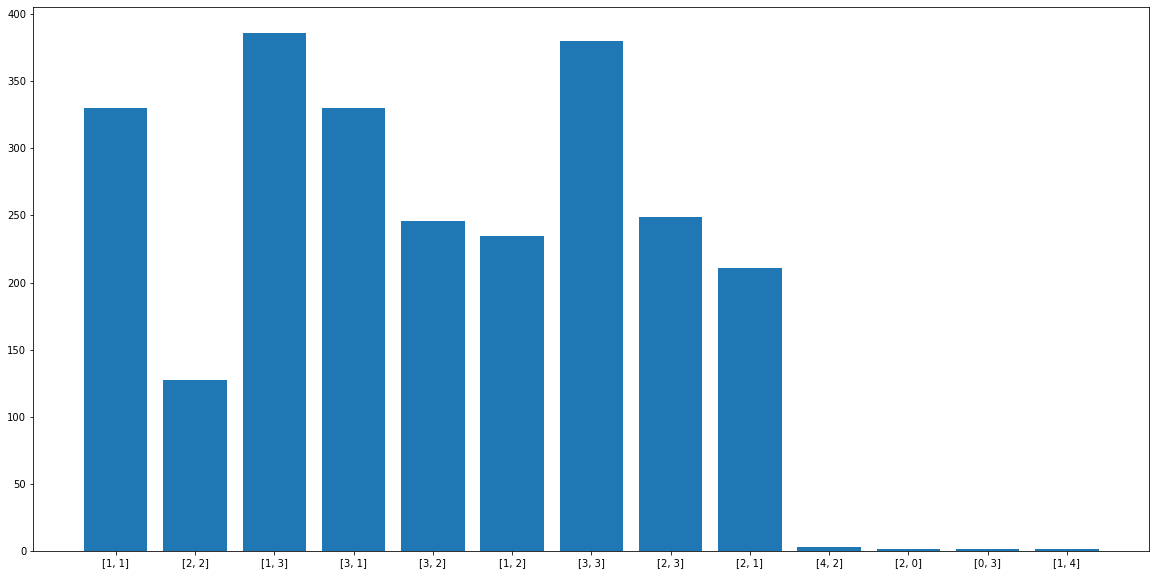

Processing Epoch 194
training start
Iteration 0, d real/fake loss 0.5670962929725647/0.5943697690963745 and g loss is 0.7920118570327759, NDiv loss 0.11469249427318573
Iteration 1, d real/fake loss 0.5669775605201721/0.6031022071838379 and g loss is 0.7992261648178101, NDiv loss 0.12114981561899185
Iteration 2, d real/fake loss 0.566852331161499/0.5921756029129028 and g loss is 0.7953120470046997, NDiv loss 0.12153350561857224
Iteration 3, d real/fake loss 0.5666995644569397/0.6018002033233643 and g loss is 0.7987477779388428, NDiv loss 0.11988117545843124
Iteration 4, d real/fake loss 0.5665432214736938/0.5868408679962158 and g loss is 0.7999657392501831, NDiv loss 0.12284619361162186


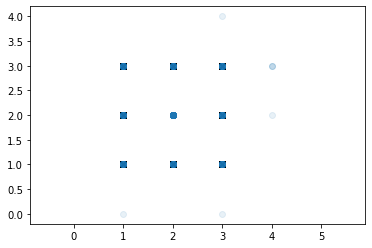

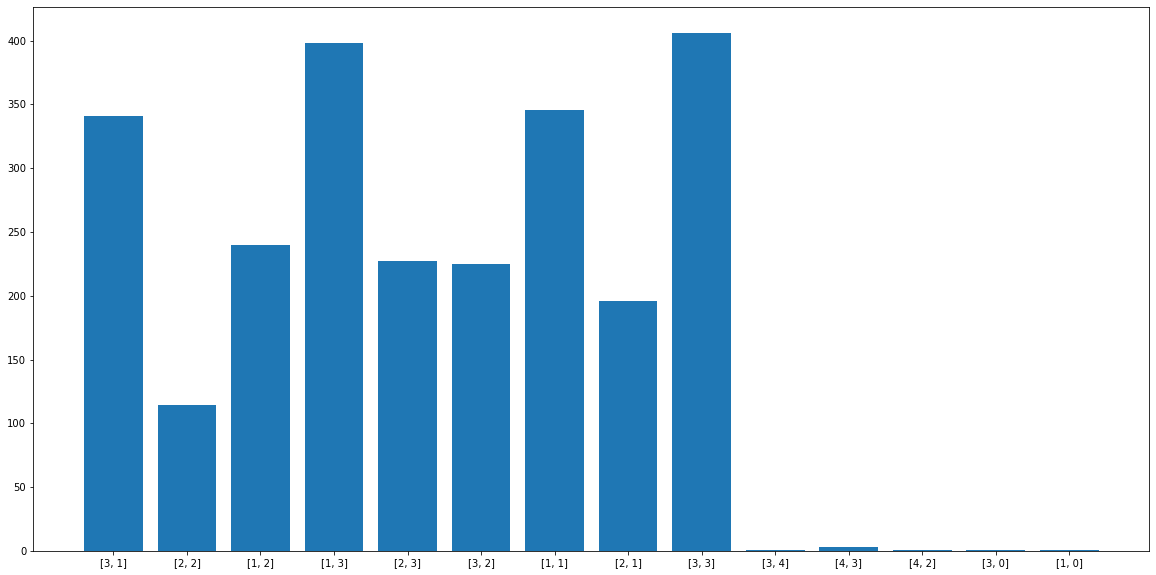

Processing Epoch 195
training start
Iteration 0, d real/fake loss 0.5666180849075317/0.5997830033302307 and g loss is 0.8056008219718933, NDiv loss 0.12546895444393158
Iteration 1, d real/fake loss 0.5664770603179932/0.5947593450546265 and g loss is 0.809332013130188, NDiv loss 0.12566836178302765
Iteration 2, d real/fake loss 0.5663379430770874/0.5937505960464478 and g loss is 0.8042243719100952, NDiv loss 0.11743223667144775
Iteration 3, d real/fake loss 0.566196084022522/0.5990206003189087 and g loss is 0.7988440990447998, NDiv loss 0.11955416202545166
Iteration 4, d real/fake loss 0.5660545825958252/0.5887129902839661 and g loss is 0.8142702579498291, NDiv loss 0.12737643718719482


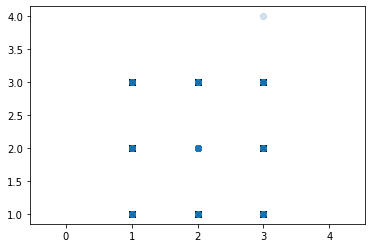

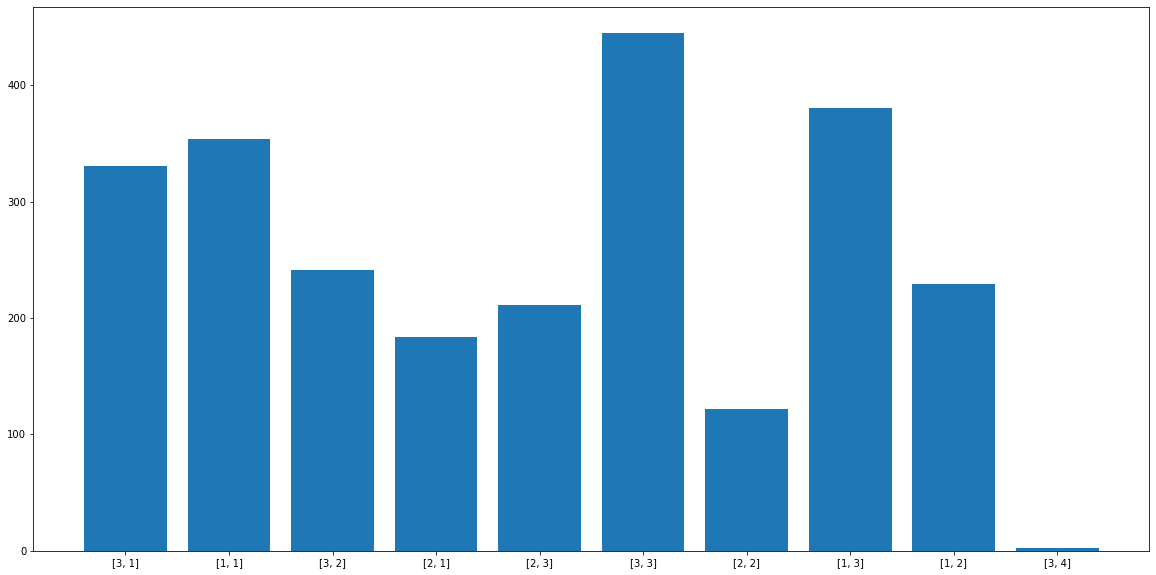

Processing Epoch 196
training start
Iteration 0, d real/fake loss 0.5663353800773621/0.6055479049682617 and g loss is 0.8091135025024414, NDiv loss 0.1258745640516281
Iteration 1, d real/fake loss 0.5661830902099609/0.6079270839691162 and g loss is 0.8073024153709412, NDiv loss 0.11854100227355957
Iteration 2, d real/fake loss 0.5660420656204224/0.5968989133834839 and g loss is 0.7976952791213989, NDiv loss 0.11919008195400238
Iteration 3, d real/fake loss 0.565893292427063/0.6000402569770813 and g loss is 0.8060051202774048, NDiv loss 0.12240656465291977
Iteration 4, d real/fake loss 0.5657534599304199/0.6049007177352905 and g loss is 0.8028100728988647, NDiv loss 0.12510977685451508


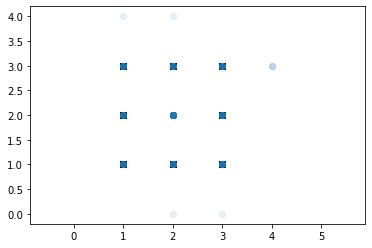

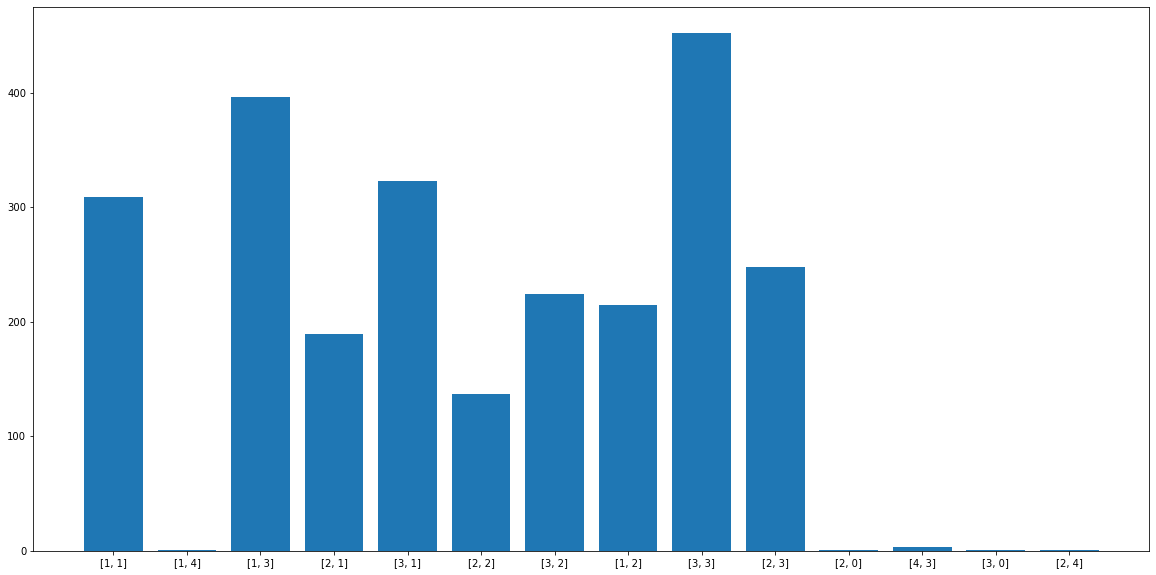

Processing Epoch 197
training start
Iteration 0, d real/fake loss 0.5651285648345947/0.5980182886123657 and g loss is 0.7963452935218811, NDiv loss 0.1278386116027832
Iteration 1, d real/fake loss 0.5650222301483154/0.5996423959732056 and g loss is 0.8096555471420288, NDiv loss 0.12378128618001938
Iteration 2, d real/fake loss 0.564922571182251/0.6020745038986206 and g loss is 0.7972578406333923, NDiv loss 0.12130411714315414
Iteration 3, d real/fake loss 0.564828097820282/0.6025780439376831 and g loss is 0.8119734525680542, NDiv loss 0.1203206479549408
Iteration 4, d real/fake loss 0.5647449493408203/0.6092978715896606 and g loss is 0.8118047714233398, NDiv loss 0.12768998742103577


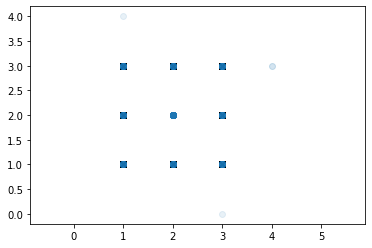

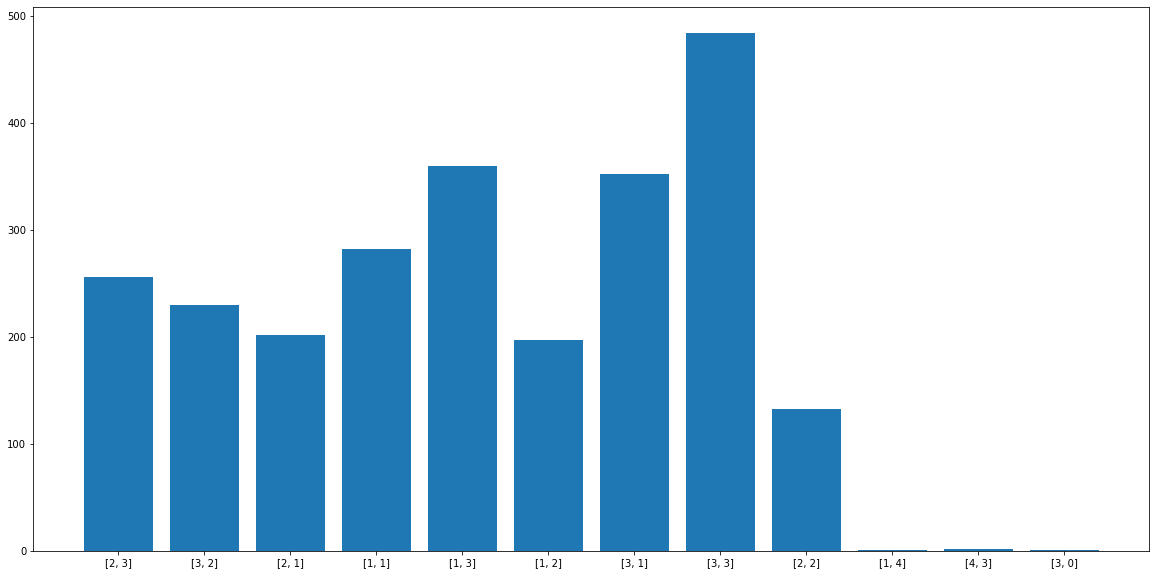

Processing Epoch 198
training start
Iteration 0, d real/fake loss 0.5653690099716187/0.5979900360107422 and g loss is 0.8132367134094238, NDiv loss 0.1218675747513771
Iteration 1, d real/fake loss 0.565315842628479/0.6038793921470642 and g loss is 0.800338625907898, NDiv loss 0.12124968320131302
Iteration 2, d real/fake loss 0.5652577877044678/0.5920630097389221 and g loss is 0.7957582473754883, NDiv loss 0.12266002595424652
Iteration 3, d real/fake loss 0.5651850700378418/0.6001037359237671 and g loss is 0.8200852870941162, NDiv loss 0.11907210201025009
Iteration 4, d real/fake loss 0.5651106834411621/0.5975182056427002 and g loss is 0.7997505068778992, NDiv loss 0.1265639364719391


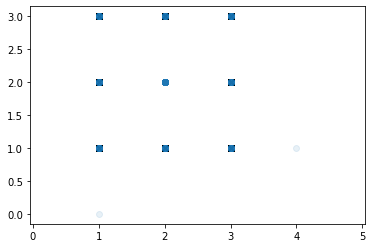

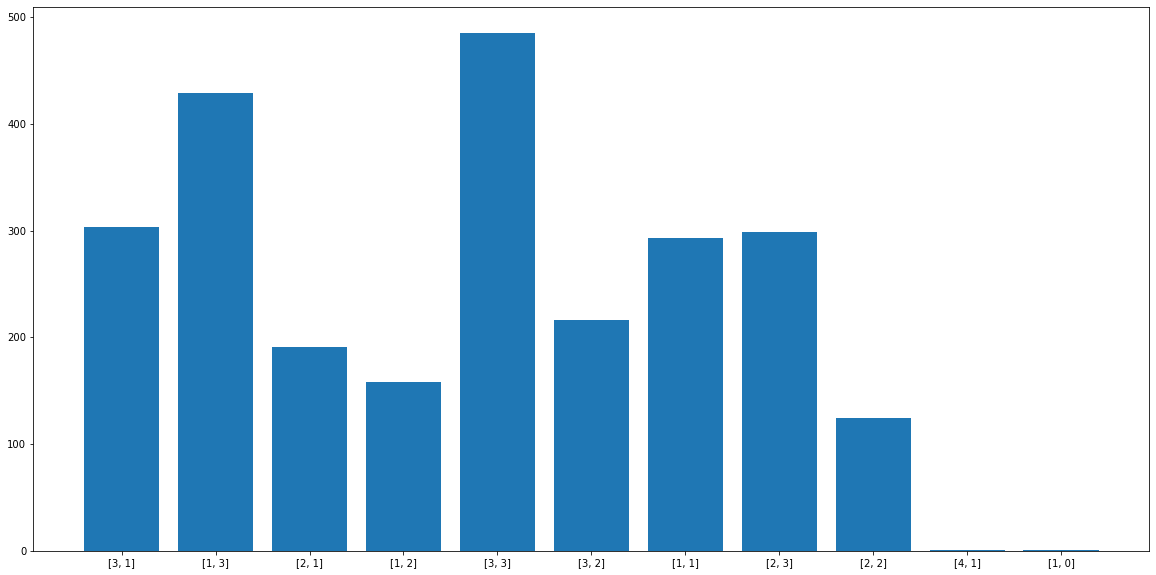

Processing Epoch 199
training start
Iteration 0, d real/fake loss 0.5639297366142273/0.5956803560256958 and g loss is 0.8127680420875549, NDiv loss 0.118219755589962
Iteration 1, d real/fake loss 0.5639185905456543/0.6054395437240601 and g loss is 0.809583306312561, NDiv loss 0.12525683641433716
Iteration 2, d real/fake loss 0.5639186501502991/0.6017918586730957 and g loss is 0.8070086240768433, NDiv loss 0.12799493968486786
Iteration 3, d real/fake loss 0.563926100730896/0.5922830104827881 and g loss is 0.8157124519348145, NDiv loss 0.12145724147558212
Iteration 4, d real/fake loss 0.5639215707778931/0.6050171852111816 and g loss is 0.8103179335594177, NDiv loss 0.12510015070438385


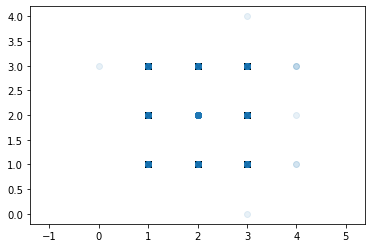

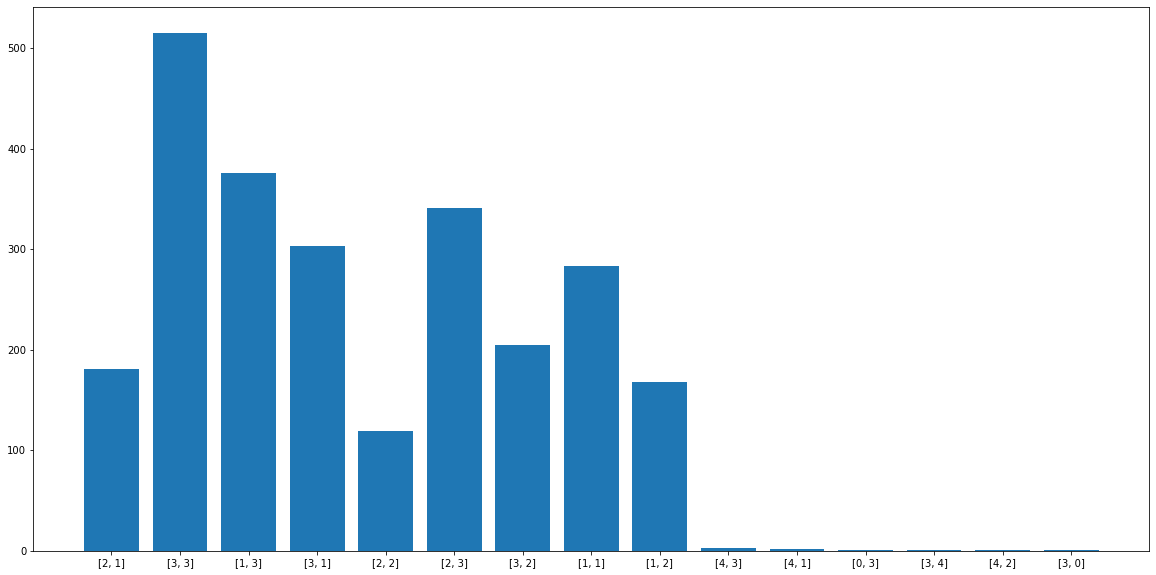

Processing Epoch 200
training start
Iteration 0, d real/fake loss 0.5644351243972778/0.6018333435058594 and g loss is 0.788689136505127, NDiv loss 0.12233435362577438
Iteration 1, d real/fake loss 0.564395546913147/0.601523220539093 and g loss is 0.801856279373169, NDiv loss 0.12698352336883545
Iteration 2, d real/fake loss 0.5643521547317505/0.5882904529571533 and g loss is 0.7998981475830078, NDiv loss 0.1190149113535881
Iteration 3, d real/fake loss 0.5642820000648499/0.6023336052894592 and g loss is 0.8170009255409241, NDiv loss 0.13053324818611145
Iteration 4, d real/fake loss 0.5642164945602417/0.5948917865753174 and g loss is 0.812930166721344, NDiv loss 0.1275162547826767


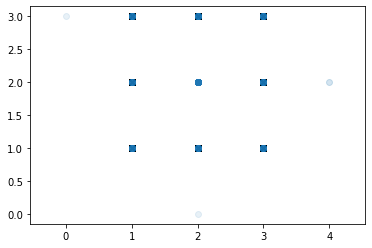

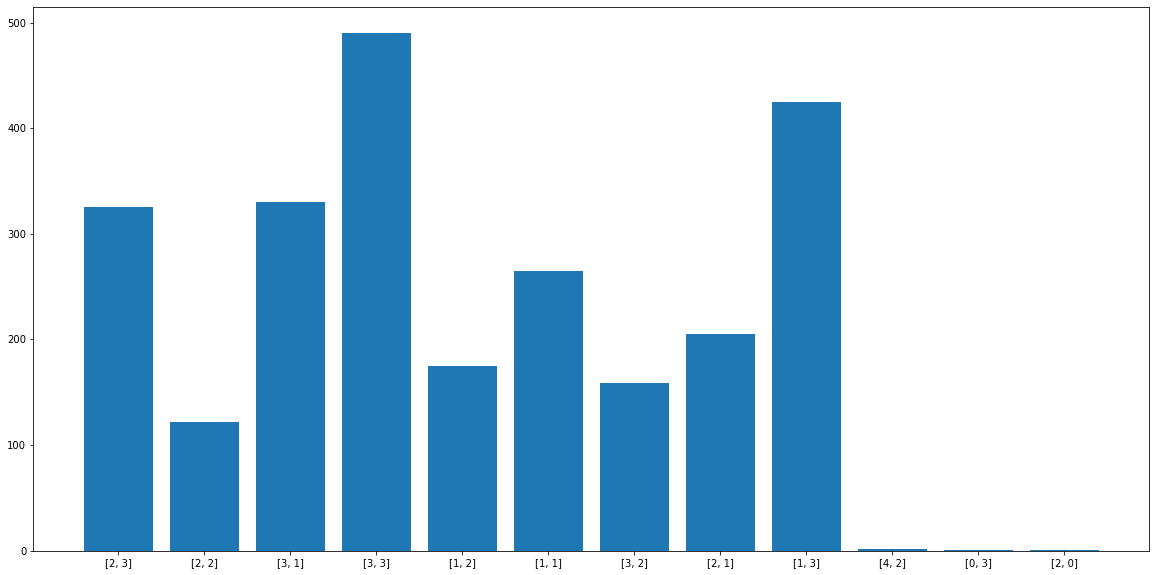

Processing Epoch 201
training start
Iteration 0, d real/fake loss 0.5643375515937805/0.5920047163963318 and g loss is 0.8077332973480225, NDiv loss 0.12671765685081482
Iteration 1, d real/fake loss 0.5642723441123962/0.5957720875740051 and g loss is 0.8190536499023438, NDiv loss 0.12444953620433807
Iteration 2, d real/fake loss 0.5642061233520508/0.5866556763648987 and g loss is 0.8201645016670227, NDiv loss 0.12501269578933716
Iteration 3, d real/fake loss 0.5641165971755981/0.6098280549049377 and g loss is 0.8086881637573242, NDiv loss 0.12383457273244858
Iteration 4, d real/fake loss 0.5640466213226318/0.589872419834137 and g loss is 0.8126657009124756, NDiv loss 0.12620893120765686


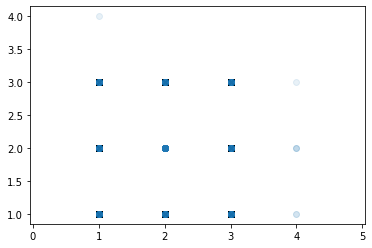

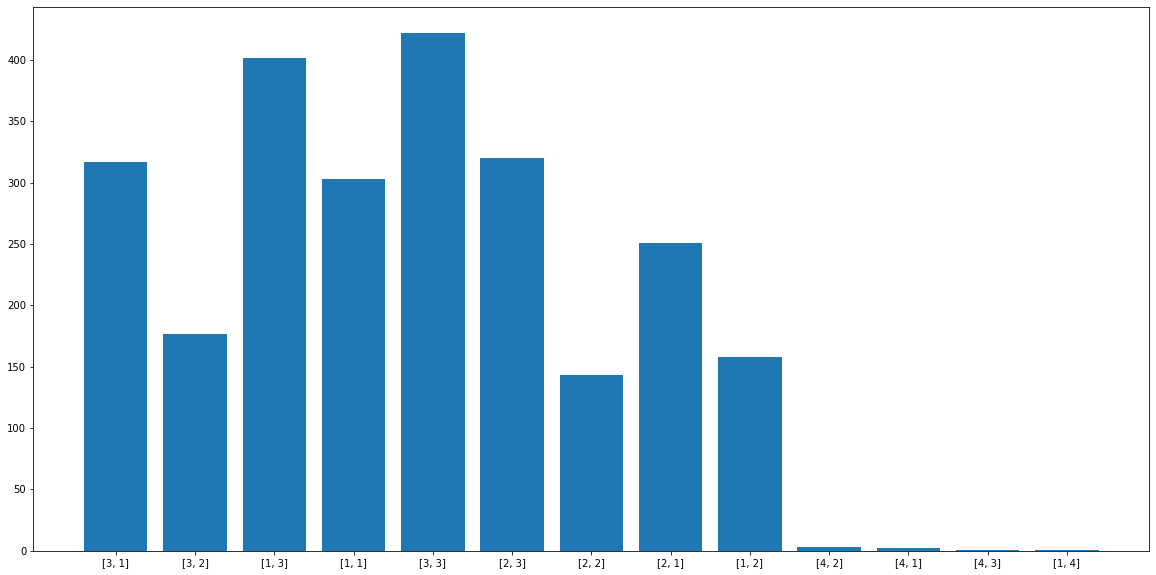

Processing Epoch 202
training start
Iteration 0, d real/fake loss 0.5643776655197144/0.5909634828567505 and g loss is 0.8037912845611572, NDiv loss 0.12630562484264374
Iteration 1, d real/fake loss 0.5643401145935059/0.6018246412277222 and g loss is 0.82404625415802, NDiv loss 0.1264377385377884
Iteration 2, d real/fake loss 0.5643110275268555/0.5942927598953247 and g loss is 0.7948089838027954, NDiv loss 0.12377668172121048
Iteration 3, d real/fake loss 0.5642873644828796/0.5914368033409119 and g loss is 0.8101320862770081, NDiv loss 0.12407685816287994
Iteration 4, d real/fake loss 0.5642508268356323/0.5837885141372681 and g loss is 0.8098785877227783, NDiv loss 0.12365487217903137


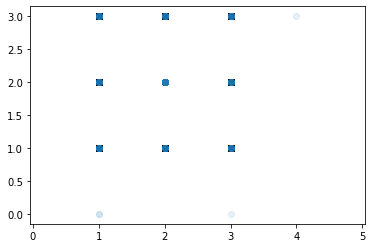

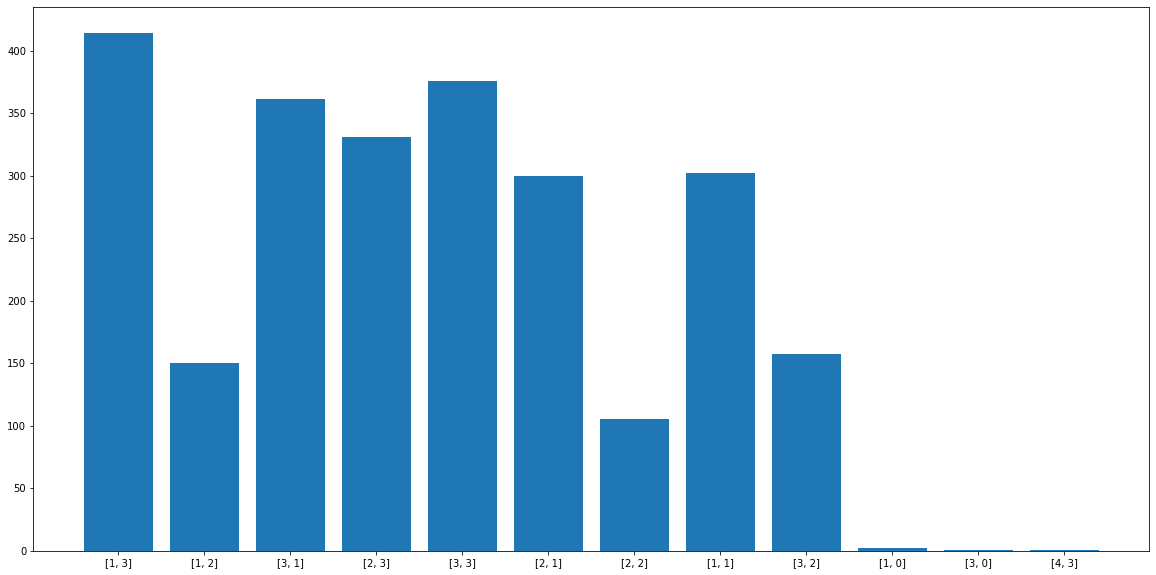

Processing Epoch 203
training start
Iteration 0, d real/fake loss 0.5669513940811157/0.6043190360069275 and g loss is 0.8179628252983093, NDiv loss 0.12500347197055817
Iteration 1, d real/fake loss 0.5668805837631226/0.5979375243186951 and g loss is 0.8215563297271729, NDiv loss 0.12010402232408524
Iteration 2, d real/fake loss 0.5668156147003174/0.5971971750259399 and g loss is 0.8154716491699219, NDiv loss 0.12754042446613312
Iteration 3, d real/fake loss 0.566754937171936/0.600044310092926 and g loss is 0.8162695169448853, NDiv loss 0.1237824484705925
Iteration 4, d real/fake loss 0.5667023658752441/0.6028810143470764 and g loss is 0.8009133338928223, NDiv loss 0.12452005594968796


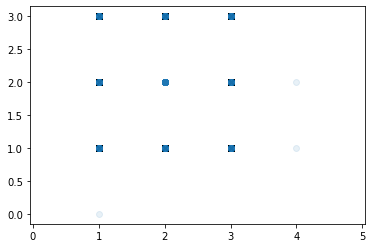

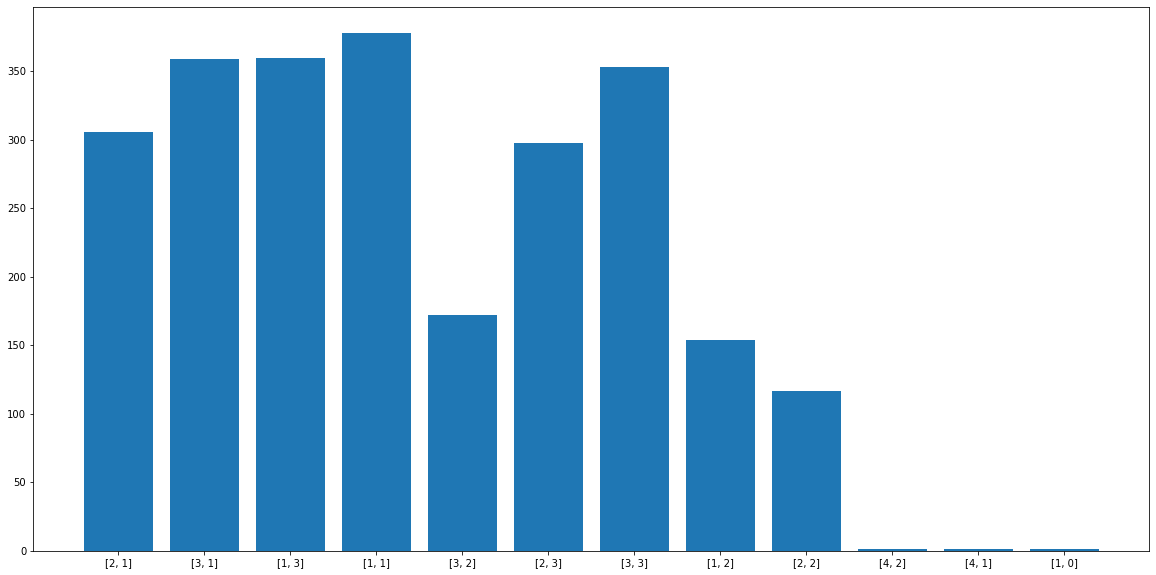

Processing Epoch 204
training start
Iteration 0, d real/fake loss 0.5651655197143555/0.5976908802986145 and g loss is 0.8114367723464966, NDiv loss 0.12998980283737183
Iteration 1, d real/fake loss 0.5651524066925049/0.6001788377761841 and g loss is 0.8177773952484131, NDiv loss 0.1165195181965828
Iteration 2, d real/fake loss 0.5651427507400513/0.6016405820846558 and g loss is 0.8185100555419922, NDiv loss 0.12387237697839737
Iteration 3, d real/fake loss 0.5651279091835022/0.5917127132415771 and g loss is 0.8187636137008667, NDiv loss 0.12940075993537903
Iteration 4, d real/fake loss 0.5650963187217712/0.6036229133605957 and g loss is 0.8141999840736389, NDiv loss 0.12114487588405609


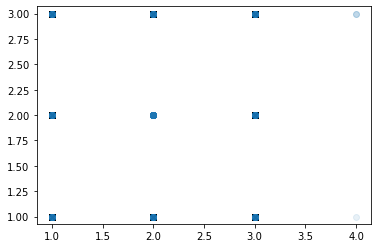

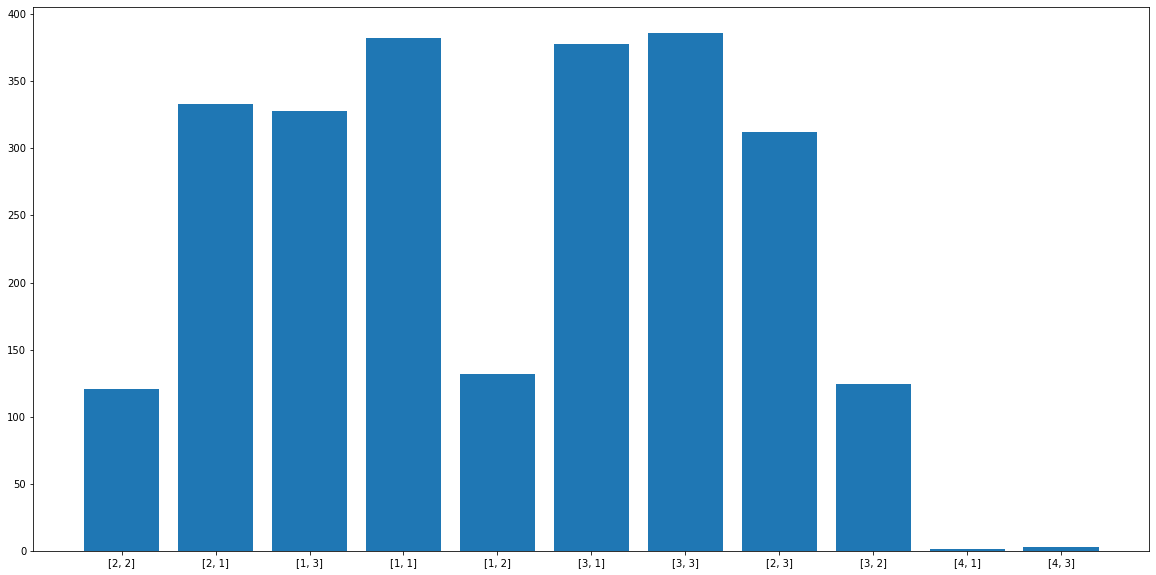

Processing Epoch 205
training start
Iteration 0, d real/fake loss 0.5641123652458191/0.5955674648284912 and g loss is 0.8062877655029297, NDiv loss 0.12232935428619385
Iteration 1, d real/fake loss 0.5641363859176636/0.5830172300338745 and g loss is 0.8135948181152344, NDiv loss 0.12218581140041351
Iteration 2, d real/fake loss 0.5641347169876099/0.5990929007530212 and g loss is 0.8117704391479492, NDiv loss 0.12830398976802826
Iteration 3, d real/fake loss 0.5641413927078247/0.5963792204856873 and g loss is 0.8180130124092102, NDiv loss 0.12192558497190475
Iteration 4, d real/fake loss 0.5641494989395142/0.59358811378479 and g loss is 0.8156957030296326, NDiv loss 0.12280014902353287


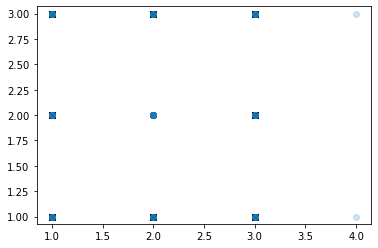

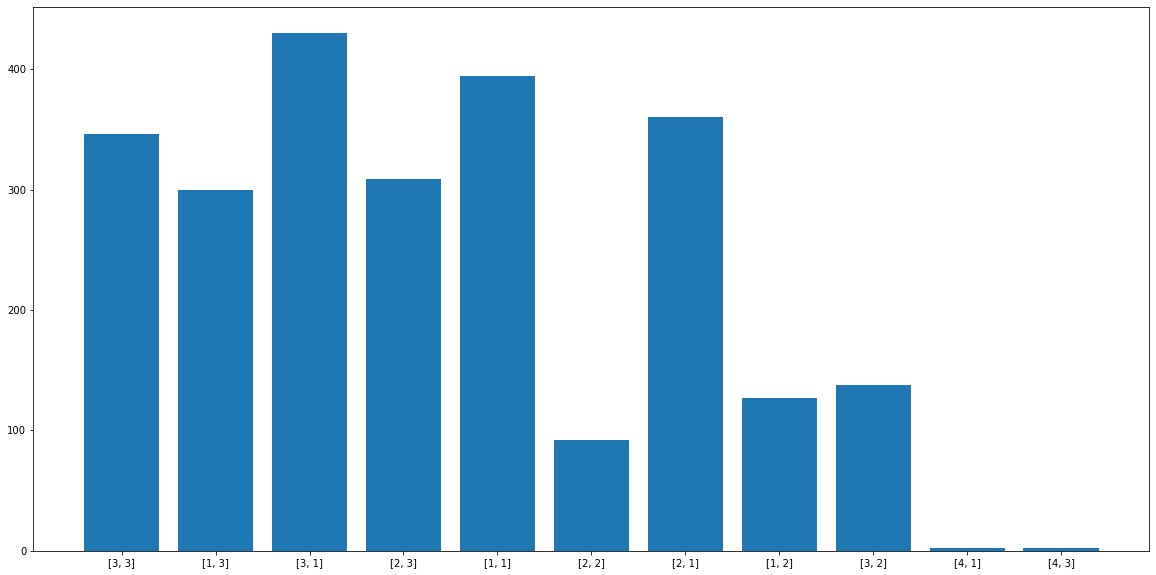

Processing Epoch 206
training start
Iteration 0, d real/fake loss 0.5622309446334839/0.5869271755218506 and g loss is 0.8111832141876221, NDiv loss 0.12461500614881516
Iteration 1, d real/fake loss 0.5622639060020447/0.5970599055290222 and g loss is 0.8111096024513245, NDiv loss 0.12589401006698608
Iteration 2, d real/fake loss 0.5622771382331848/0.5884578227996826 and g loss is 0.8145408630371094, NDiv loss 0.1296263188123703
Iteration 3, d real/fake loss 0.562275767326355/0.5850827693939209 and g loss is 0.8137227892875671, NDiv loss 0.12582044303417206
Iteration 4, d real/fake loss 0.5622255206108093/0.5913779735565186 and g loss is 0.8165276050567627, NDiv loss 0.12555749714374542


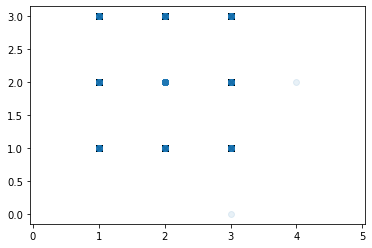

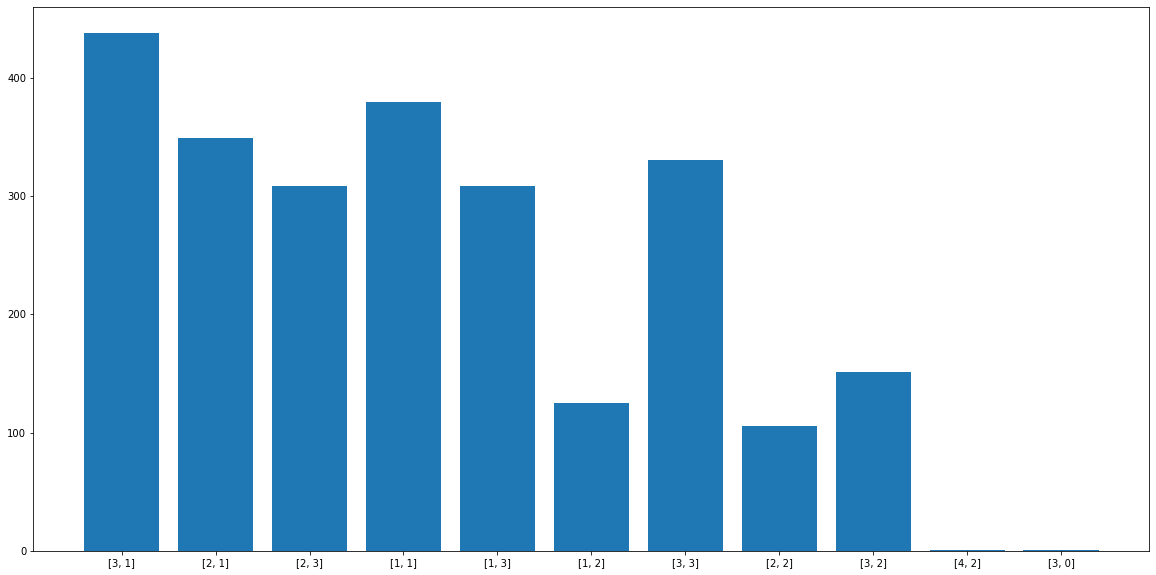

Processing Epoch 207
training start
Iteration 0, d real/fake loss 0.5649833083152771/0.5888420939445496 and g loss is 0.8089325428009033, NDiv loss 0.12842583656311035
Iteration 1, d real/fake loss 0.5649060606956482/0.5981433987617493 and g loss is 0.8167195320129395, NDiv loss 0.13137058913707733
Iteration 2, d real/fake loss 0.5648404359817505/0.588725745677948 and g loss is 0.8125827312469482, NDiv loss 0.12918396294116974
Iteration 3, d real/fake loss 0.5647625923156738/0.5826553106307983 and g loss is 0.8116137981414795, NDiv loss 0.11975249648094177
Iteration 4, d real/fake loss 0.5646641254425049/0.5979757308959961 and g loss is 0.8260353207588196, NDiv loss 0.11949070543050766


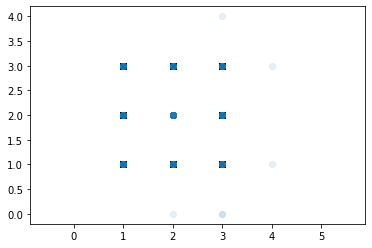

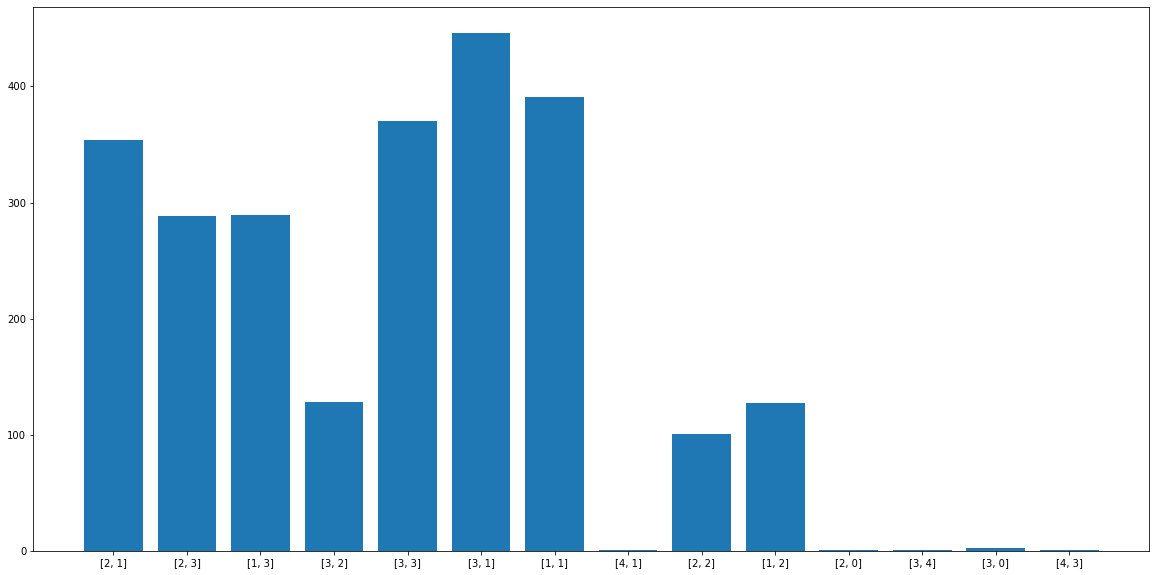

Processing Epoch 208
training start
Iteration 0, d real/fake loss 0.565037727355957/0.5958386063575745 and g loss is 0.8156262636184692, NDiv loss 0.1276453137397766
Iteration 1, d real/fake loss 0.5649183988571167/0.5798245072364807 and g loss is 0.8166147470474243, NDiv loss 0.12554439902305603
Iteration 2, d real/fake loss 0.564764142036438/0.596781849861145 and g loss is 0.8038409948348999, NDiv loss 0.12396421283483505
Iteration 3, d real/fake loss 0.564606785774231/0.593757688999176 and g loss is 0.8299809098243713, NDiv loss 0.12446622550487518
Iteration 4, d real/fake loss 0.5644489526748657/0.585240364074707 and g loss is 0.8346846103668213, NDiv loss 0.12335709482431412


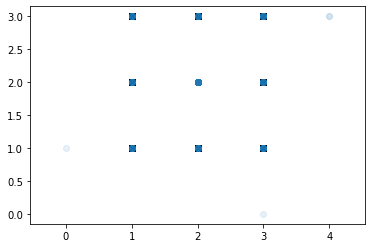

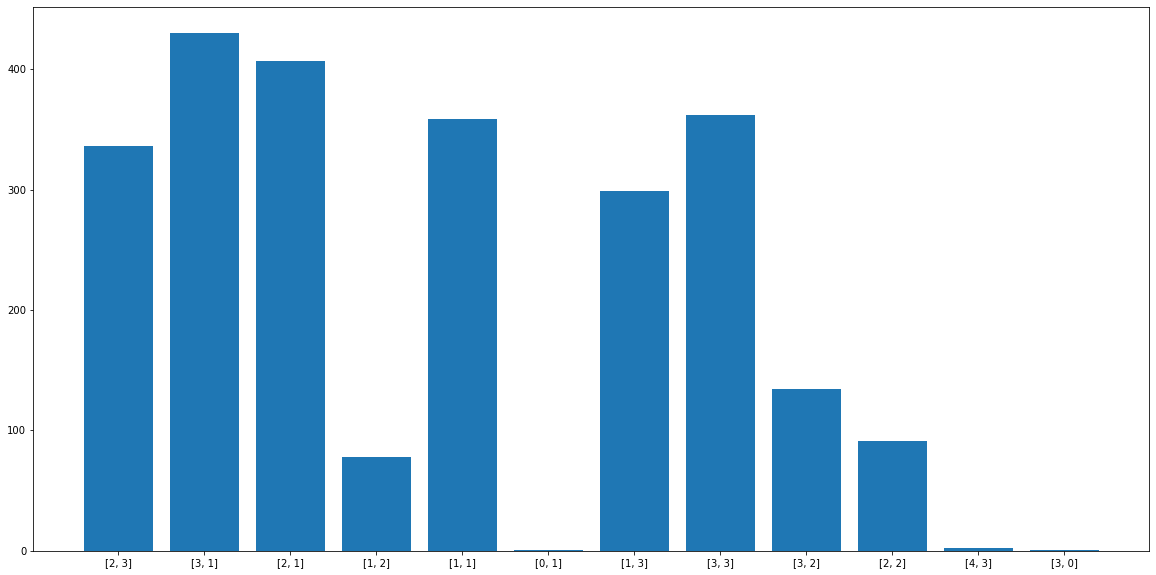

Processing Epoch 209
training start
Iteration 0, d real/fake loss 0.5626715421676636/0.5837451219558716 and g loss is 0.8132380247116089, NDiv loss 0.12378707528114319
Iteration 1, d real/fake loss 0.5626427531242371/0.5936726927757263 and g loss is 0.8218538165092468, NDiv loss 0.13097602128982544
Iteration 2, d real/fake loss 0.5626069903373718/0.5767546892166138 and g loss is 0.8126777410507202, NDiv loss 0.12418847531080246
Iteration 3, d real/fake loss 0.5625123381614685/0.5888149738311768 and g loss is 0.81348717212677, NDiv loss 0.12908197939395905
Iteration 4, d real/fake loss 0.5624046921730042/0.5775766968727112 and g loss is 0.8076497316360474, NDiv loss 0.12622074782848358


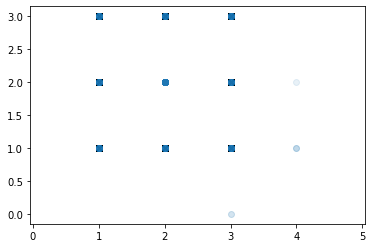

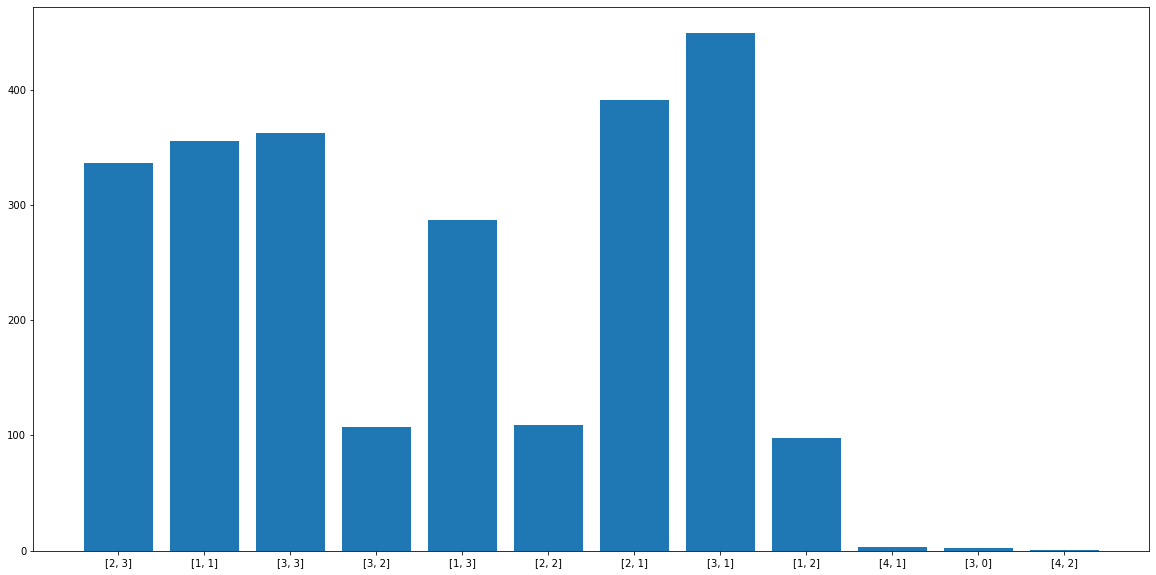

Processing Epoch 210
training start
Iteration 0, d real/fake loss 0.5607779622077942/0.5722697973251343 and g loss is 0.8234844207763672, NDiv loss 0.12088106572628021
Iteration 1, d real/fake loss 0.5605617165565491/0.5886250734329224 and g loss is 0.8154401779174805, NDiv loss 0.12659232318401337
Iteration 2, d real/fake loss 0.5603357553482056/0.58966064453125 and g loss is 0.816145658493042, NDiv loss 0.12422394007444382
Iteration 3, d real/fake loss 0.5600988864898682/0.5780373215675354 and g loss is 0.8035312294960022, NDiv loss 0.13017700612545013
Iteration 4, d real/fake loss 0.5598422288894653/0.5891827344894409 and g loss is 0.8164796233177185, NDiv loss 0.12428215891122818


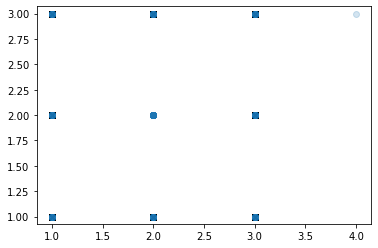

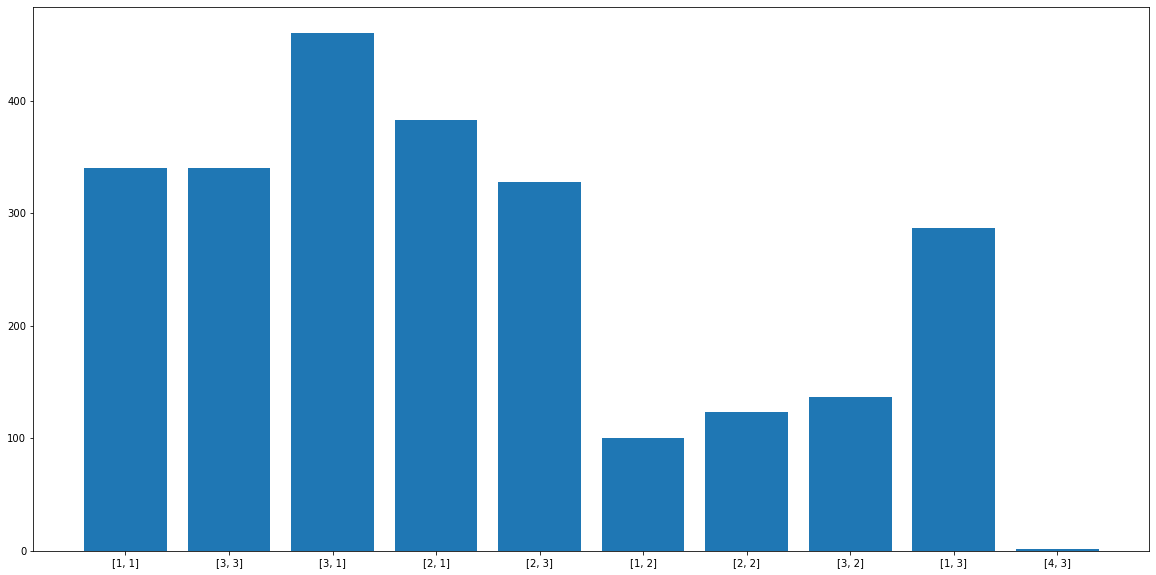

Processing Epoch 211
training start
Iteration 0, d real/fake loss 0.5642268657684326/0.5746335387229919 and g loss is 0.8120782971382141, NDiv loss 0.12210658937692642
Iteration 1, d real/fake loss 0.5640740394592285/0.5682332515716553 and g loss is 0.8191553354263306, NDiv loss 0.12698617577552795
Iteration 2, d real/fake loss 0.5638980865478516/0.5846695899963379 and g loss is 0.8252739906311035, NDiv loss 0.1254301518201828
Iteration 3, d real/fake loss 0.5637238025665283/0.5781871676445007 and g loss is 0.8280472755432129, NDiv loss 0.130192369222641
Iteration 4, d real/fake loss 0.563541054725647/0.5869190096855164 and g loss is 0.8121417760848999, NDiv loss 0.13155141472816467


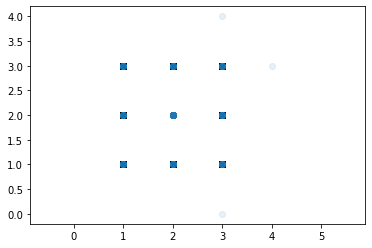

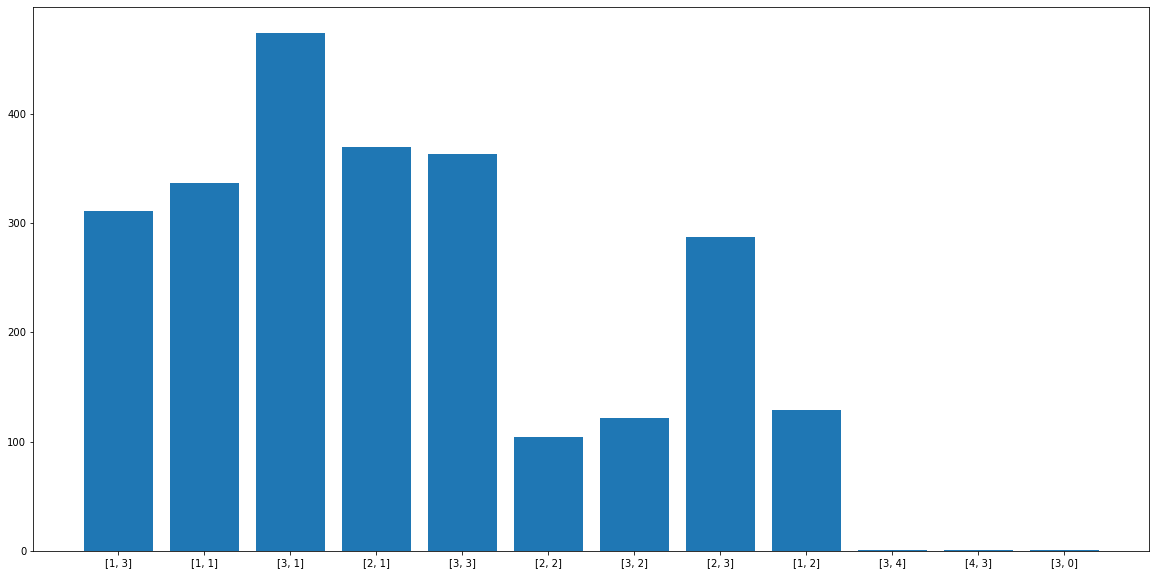

Processing Epoch 212
training start
Iteration 0, d real/fake loss 0.5638726949691772/0.59422367811203 and g loss is 0.815630316734314, NDiv loss 0.11928753554821014
Iteration 1, d real/fake loss 0.5637303590774536/0.5820452570915222 and g loss is 0.8123138546943665, NDiv loss 0.12708112597465515
Iteration 2, d real/fake loss 0.5635643005371094/0.5712412595748901 and g loss is 0.8196693062782288, NDiv loss 0.12673917412757874
Iteration 3, d real/fake loss 0.5633672475814819/0.5811639428138733 and g loss is 0.8379430174827576, NDiv loss 0.13245688378810883
Iteration 4, d real/fake loss 0.5631678104400635/0.5833027958869934 and g loss is 0.8164311647415161, NDiv loss 0.12541456520557404


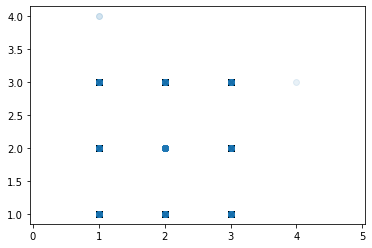

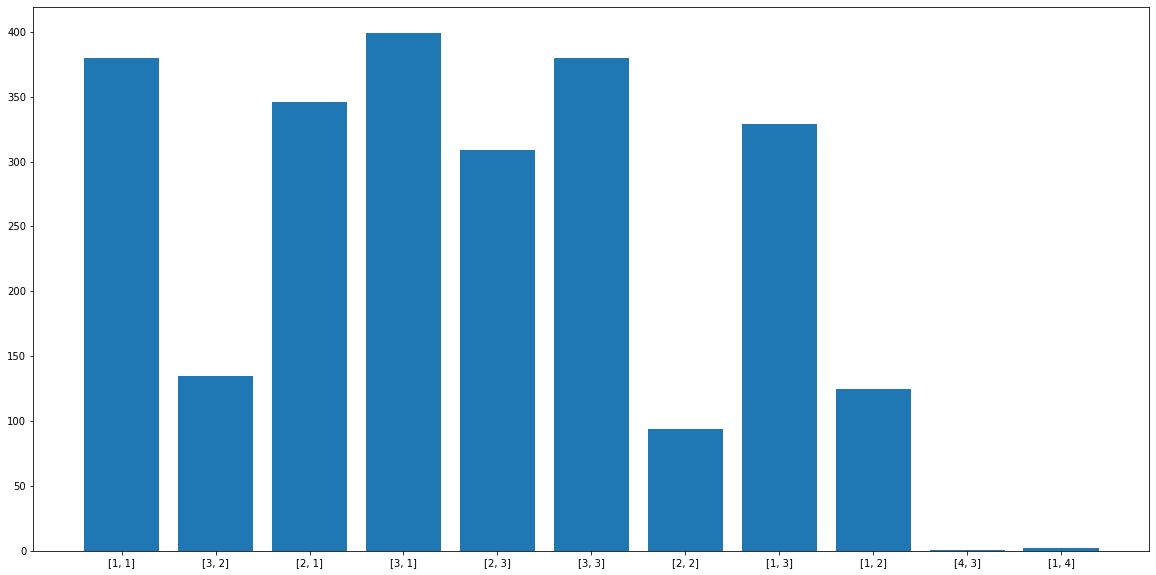

Processing Epoch 213
training start
Iteration 0, d real/fake loss 0.5600517988204956/0.58234041929245 and g loss is 0.8212332725524902, NDiv loss 0.12433440238237381
Iteration 1, d real/fake loss 0.559827983379364/0.5686255693435669 and g loss is 0.824815571308136, NDiv loss 0.12538127601146698
Iteration 2, d real/fake loss 0.5595766305923462/0.591445803642273 and g loss is 0.8136060237884521, NDiv loss 0.12416873872280121
Iteration 3, d real/fake loss 0.5593346953392029/0.5710919499397278 and g loss is 0.8193415999412537, NDiv loss 0.12261104583740234
Iteration 4, d real/fake loss 0.559071958065033/0.5870633721351624 and g loss is 0.8273928165435791, NDiv loss 0.1288352906703949


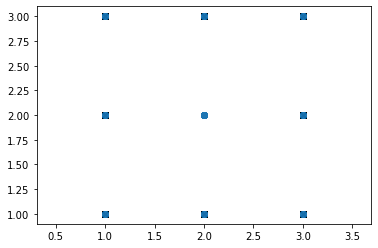

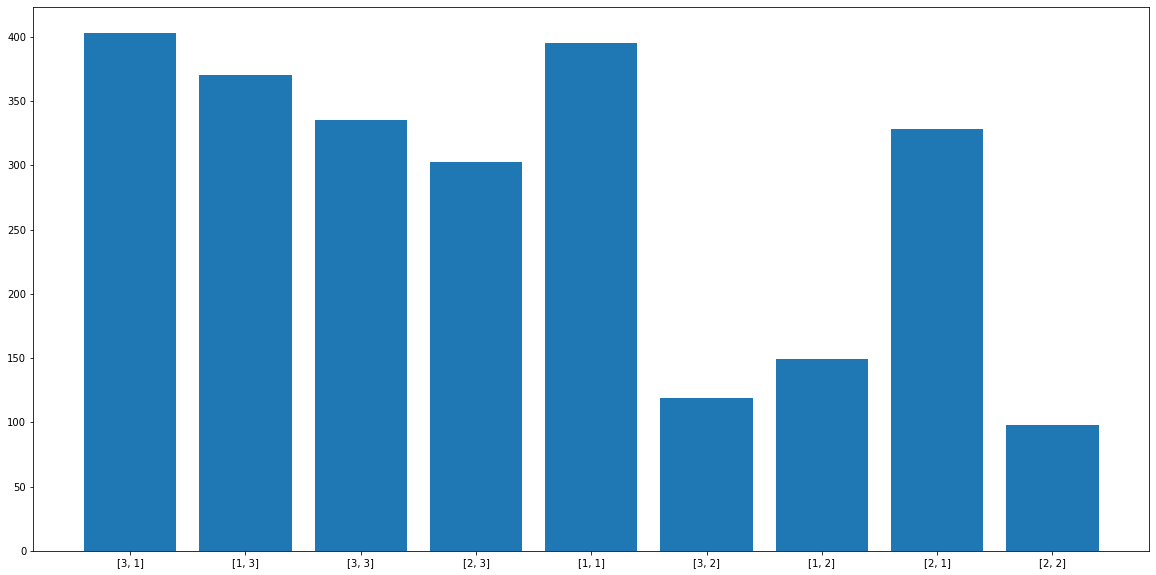

Processing Epoch 214
training start
Iteration 0, d real/fake loss 0.5598083138465881/0.5867491364479065 and g loss is 0.8128071427345276, NDiv loss 0.1224454864859581
Iteration 1, d real/fake loss 0.5595108270645142/0.5804643034934998 and g loss is 0.8310643434524536, NDiv loss 0.12743516266345978
Iteration 2, d real/fake loss 0.5592076778411865/0.5804412364959717 and g loss is 0.8321012258529663, NDiv loss 0.1211327537894249
Iteration 3, d real/fake loss 0.5588951110839844/0.5755175948143005 and g loss is 0.8303678631782532, NDiv loss 0.12315654009580612
Iteration 4, d real/fake loss 0.5585711002349854/0.5836533904075623 and g loss is 0.8180733919143677, NDiv loss 0.1266890913248062


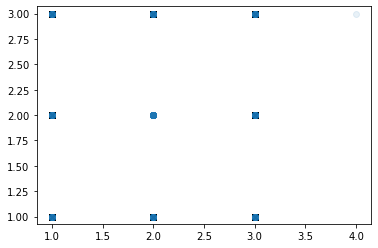

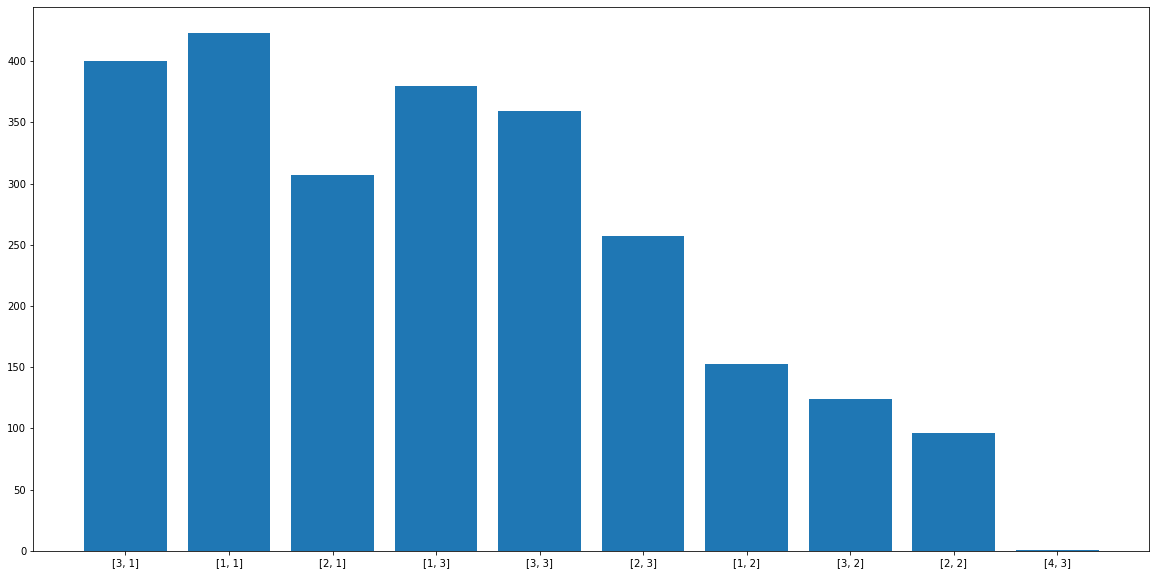

Processing Epoch 215
training start
Iteration 0, d real/fake loss 0.5623184442520142/0.5885069370269775 and g loss is 0.8199350833892822, NDiv loss 0.12577295303344727
Iteration 1, d real/fake loss 0.562166690826416/0.5794445276260376 and g loss is 0.8199245929718018, NDiv loss 0.12566059827804565
Iteration 2, d real/fake loss 0.5619959831237793/0.586354672908783 and g loss is 0.826313853263855, NDiv loss 0.12494825571775436
Iteration 3, d real/fake loss 0.5618244409561157/0.5757110118865967 and g loss is 0.8414479494094849, NDiv loss 0.12415970861911774
Iteration 4, d real/fake loss 0.5616310834884644/0.580706775188446 and g loss is 0.8234808444976807, NDiv loss 0.12796834111213684


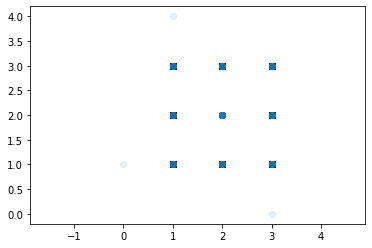

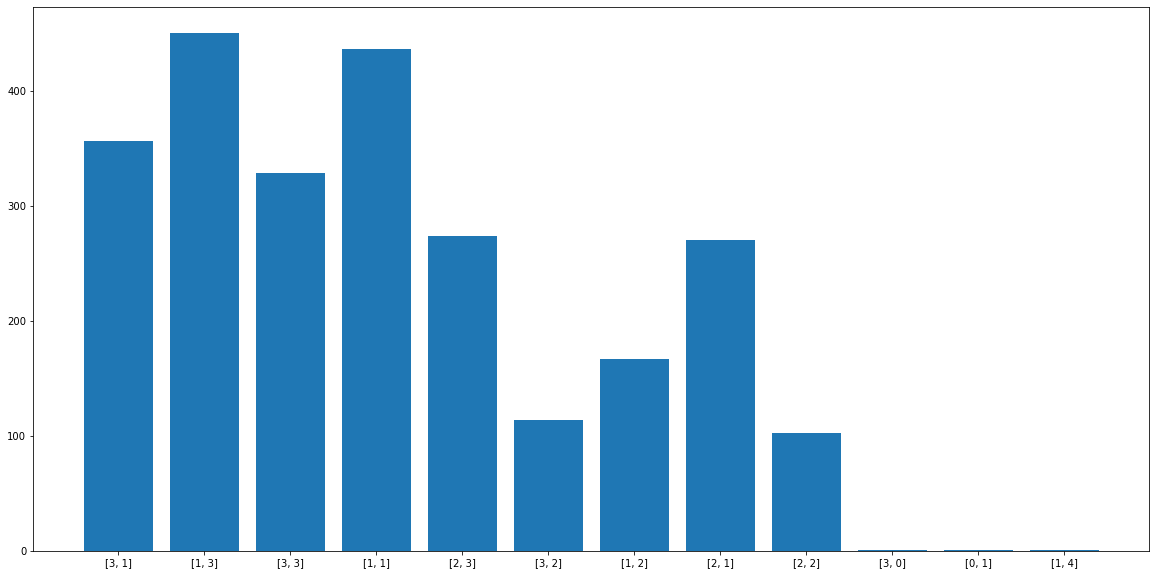

Processing Epoch 216
training start
Iteration 0, d real/fake loss 0.5582942962646484/0.5865059494972229 and g loss is 0.8347633481025696, NDiv loss 0.13117116689682007
Iteration 1, d real/fake loss 0.5580981969833374/0.5844801068305969 and g loss is 0.8178753852844238, NDiv loss 0.12525121867656708
Iteration 2, d real/fake loss 0.5578939318656921/0.5919936895370483 and g loss is 0.8083466291427612, NDiv loss 0.12350869923830032
Iteration 3, d real/fake loss 0.5577003359794617/0.5892564058303833 and g loss is 0.8438481688499451, NDiv loss 0.1293853223323822
Iteration 4, d real/fake loss 0.5575119256973267/0.593293309211731 and g loss is 0.8407782316207886, NDiv loss 0.1301250010728836


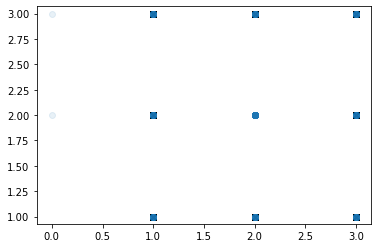

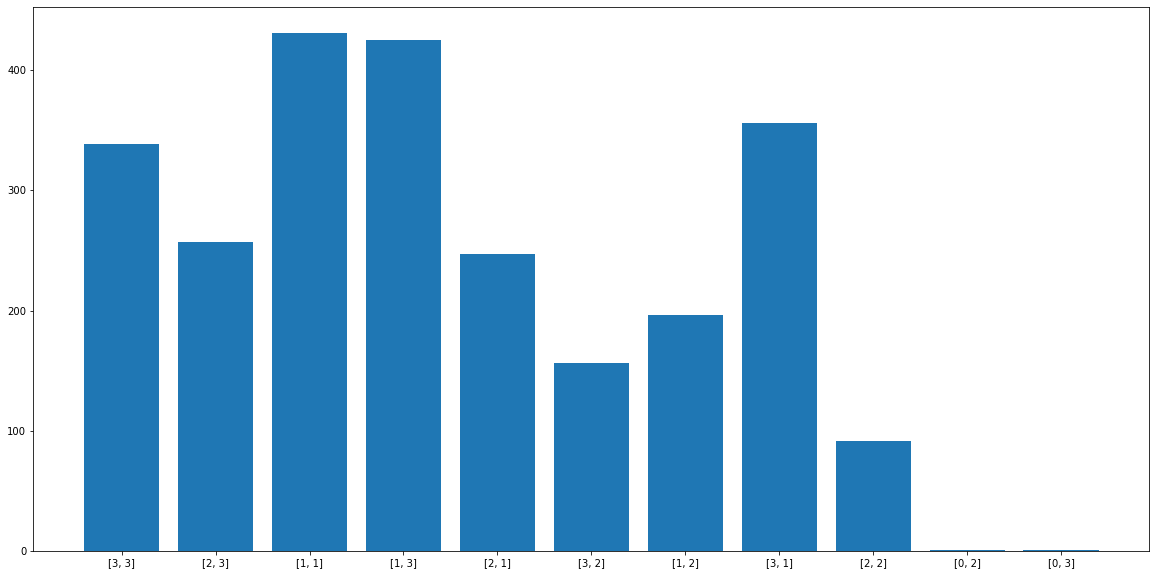

Processing Epoch 217
training start
Iteration 0, d real/fake loss 0.560465395450592/0.582251787185669 and g loss is 0.8330788612365723, NDiv loss 0.12823091447353363
Iteration 1, d real/fake loss 0.5602853298187256/0.5767936706542969 and g loss is 0.8373035192489624, NDiv loss 0.12534447014331818
Iteration 2, d real/fake loss 0.560051441192627/0.575607419013977 and g loss is 0.8328268527984619, NDiv loss 0.12363539636135101
Iteration 3, d real/fake loss 0.5597580671310425/0.5779809951782227 and g loss is 0.8268140554428101, NDiv loss 0.12446203827857971
Iteration 4, d real/fake loss 0.5594261288642883/0.5803743600845337 and g loss is 0.8291662931442261, NDiv loss 0.12675781548023224


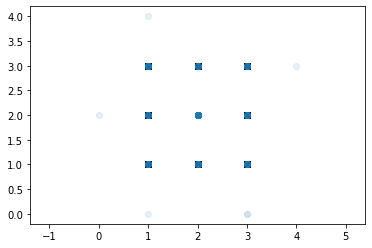

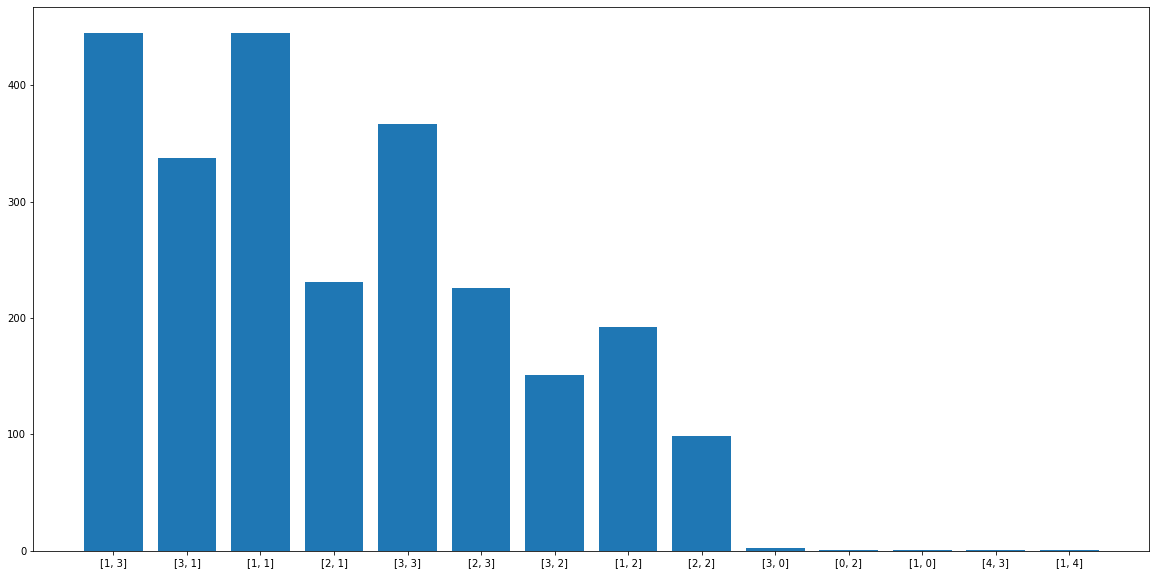

Processing Epoch 218
training start
Iteration 0, d real/fake loss 0.5572370886802673/0.5738686919212341 and g loss is 0.8349637389183044, NDiv loss 0.12374027818441391
Iteration 1, d real/fake loss 0.5569600462913513/0.5901793837547302 and g loss is 0.831554651260376, NDiv loss 0.12435342371463776
Iteration 2, d real/fake loss 0.5567085146903992/0.5897909998893738 and g loss is 0.8218104839324951, NDiv loss 0.13066916167736053
Iteration 3, d real/fake loss 0.5564776659011841/0.5775872468948364 and g loss is 0.8062981963157654, NDiv loss 0.12444455921649933
Iteration 4, d real/fake loss 0.5562491416931152/0.597440242767334 and g loss is 0.8276541233062744, NDiv loss 0.12127724289894104


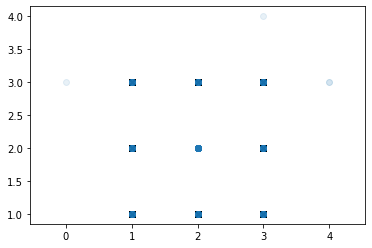

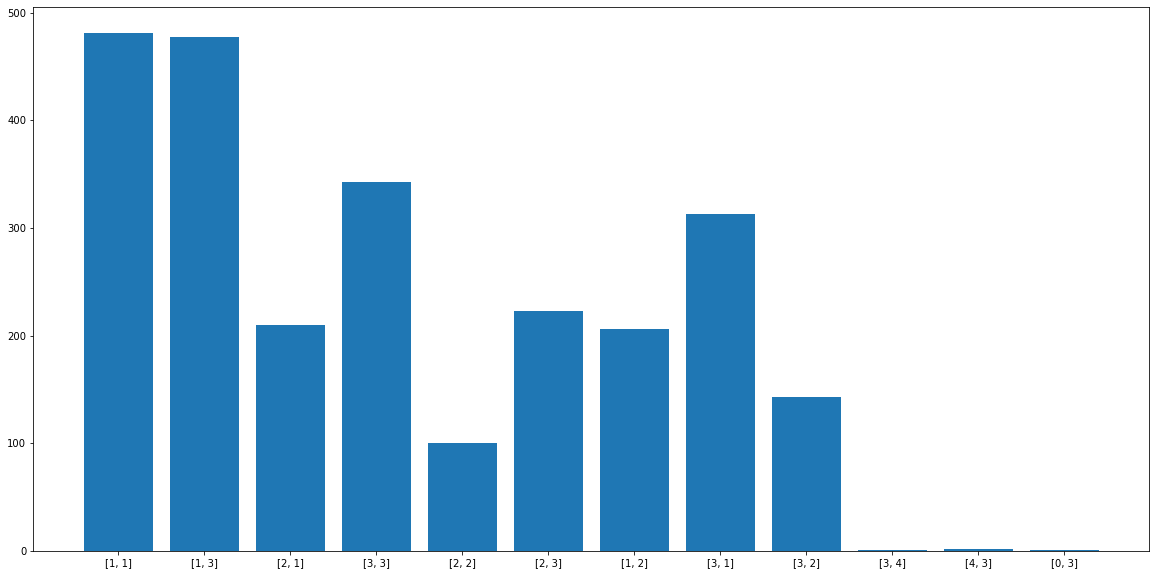

Processing Epoch 219
training start
Iteration 0, d real/fake loss 0.5530223250389099/0.581436038017273 and g loss is 0.8256070613861084, NDiv loss 0.12447705119848251
Iteration 1, d real/fake loss 0.5528479814529419/0.591150164604187 and g loss is 0.8209061622619629, NDiv loss 0.12508843839168549
Iteration 2, d real/fake loss 0.552692711353302/0.585544228553772 and g loss is 0.8294486999511719, NDiv loss 0.12849554419517517
Iteration 3, d real/fake loss 0.552544355392456/0.576004147529602 and g loss is 0.8277710676193237, NDiv loss 0.12692852318286896
Iteration 4, d real/fake loss 0.5523874759674072/0.5759605169296265 and g loss is 0.8363066911697388, NDiv loss 0.12362853437662125


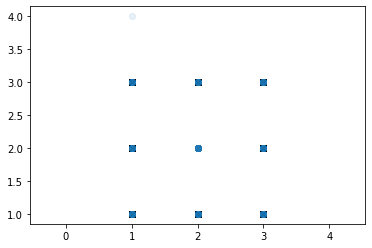

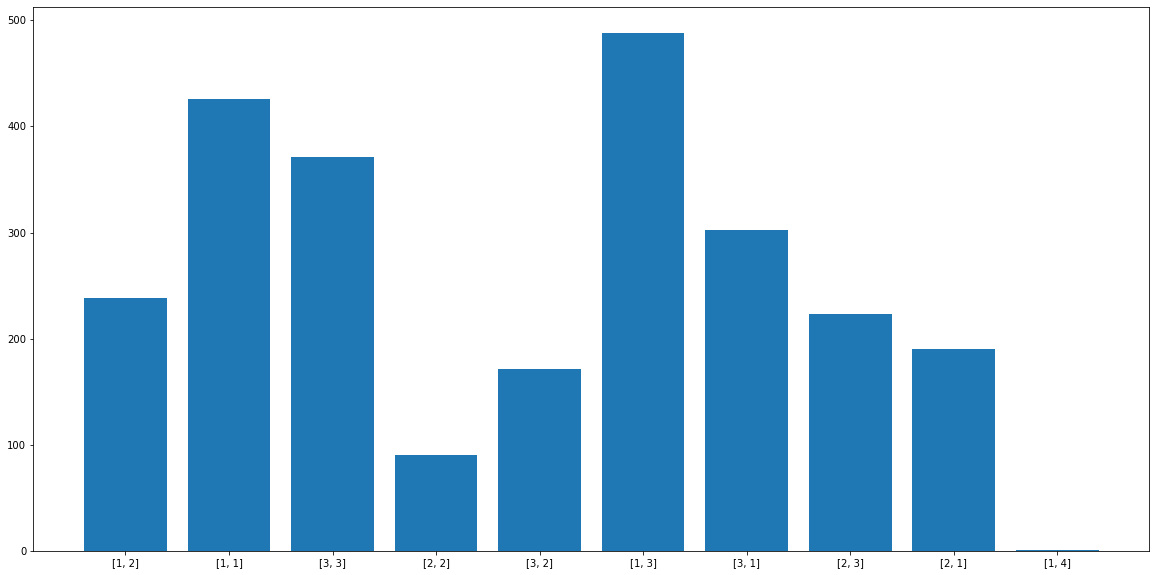

Processing Epoch 220
training start
Iteration 0, d real/fake loss 0.552568793296814/0.5894306898117065 and g loss is 0.8161084055900574, NDiv loss 0.12822264432907104
Iteration 1, d real/fake loss 0.5524254441261292/0.5705516934394836 and g loss is 0.8127486705780029, NDiv loss 0.1247054934501648
Iteration 2, d real/fake loss 0.5522353649139404/0.5868812203407288 and g loss is 0.8183947801589966, NDiv loss 0.1342156082391739
Iteration 3, d real/fake loss 0.5520302057266235/0.581417441368103 and g loss is 0.8431676626205444, NDiv loss 0.12718455493450165
Iteration 4, d real/fake loss 0.5517977476119995/0.5837161540985107 and g loss is 0.810847818851471, NDiv loss 0.12931348383426666


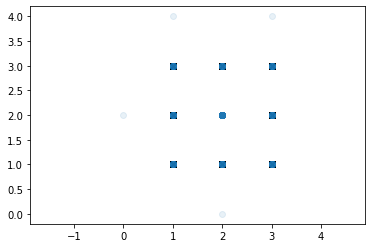

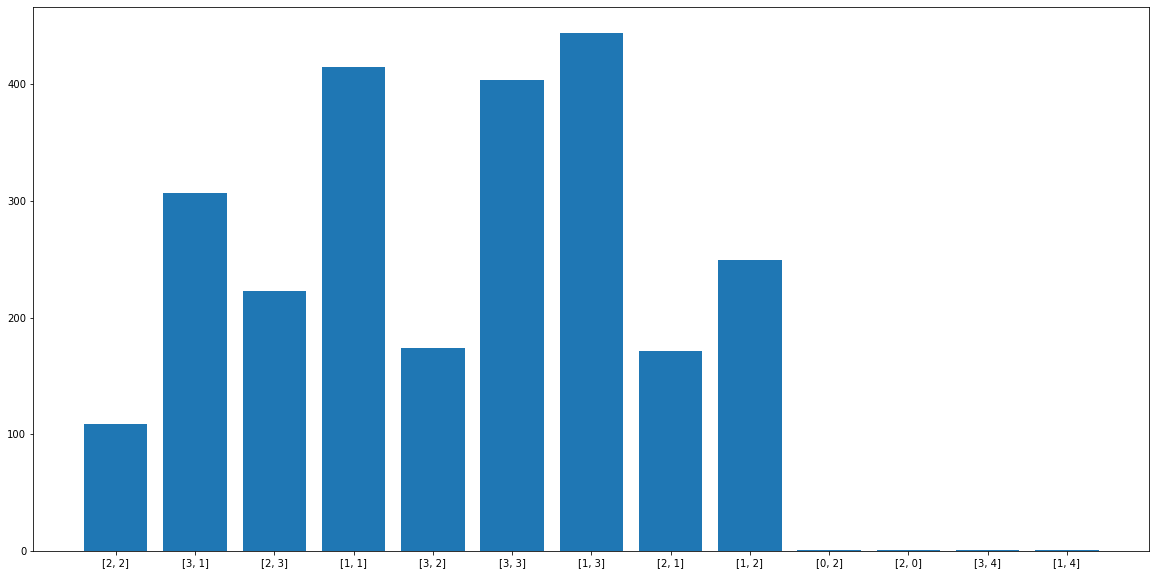

Processing Epoch 221
training start
Iteration 0, d real/fake loss 0.5580023527145386/0.5911079049110413 and g loss is 0.8247482776641846, NDiv loss 0.12377405166625977
Iteration 1, d real/fake loss 0.5578284859657288/0.583540678024292 and g loss is 0.8130040168762207, NDiv loss 0.12134269624948502
Iteration 2, d real/fake loss 0.5576394200325012/0.5869742631912231 and g loss is 0.8412922620773315, NDiv loss 0.12286294251680374
Iteration 3, d real/fake loss 0.5574425458908081/0.6069610118865967 and g loss is 0.8345282077789307, NDiv loss 0.1235850378870964
Iteration 4, d real/fake loss 0.5572644472122192/0.5821388363838196 and g loss is 0.8338354229927063, NDiv loss 0.12728603184223175


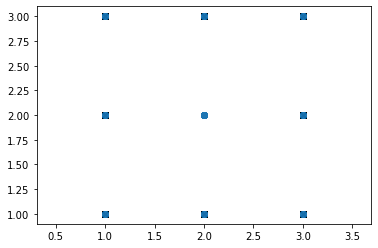

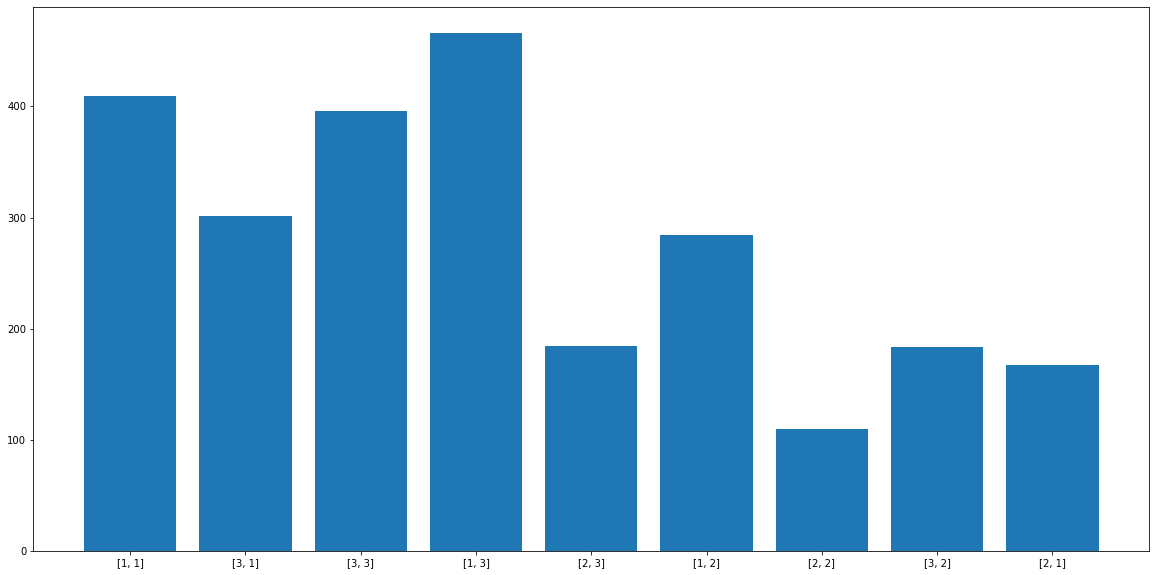

Processing Epoch 222
training start
Iteration 0, d real/fake loss 0.5496708750724792/0.5888045430183411 and g loss is 0.825452446937561, NDiv loss 0.12104612588882446
Iteration 1, d real/fake loss 0.5495007038116455/0.5784795880317688 and g loss is 0.8295704126358032, NDiv loss 0.12052679806947708
Iteration 2, d real/fake loss 0.5493066906929016/0.5905894637107849 and g loss is 0.8262926340103149, NDiv loss 0.12411616742610931
Iteration 3, d real/fake loss 0.549098551273346/0.5788387060165405 and g loss is 0.839634120464325, NDiv loss 0.12954109907150269
Iteration 4, d real/fake loss 0.5488584637641907/0.5799785256385803 and g loss is 0.8262290954589844, NDiv loss 0.12265774607658386


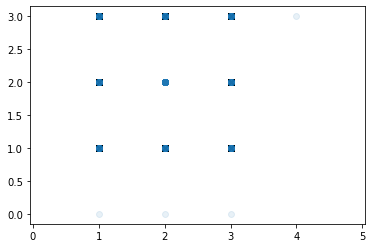

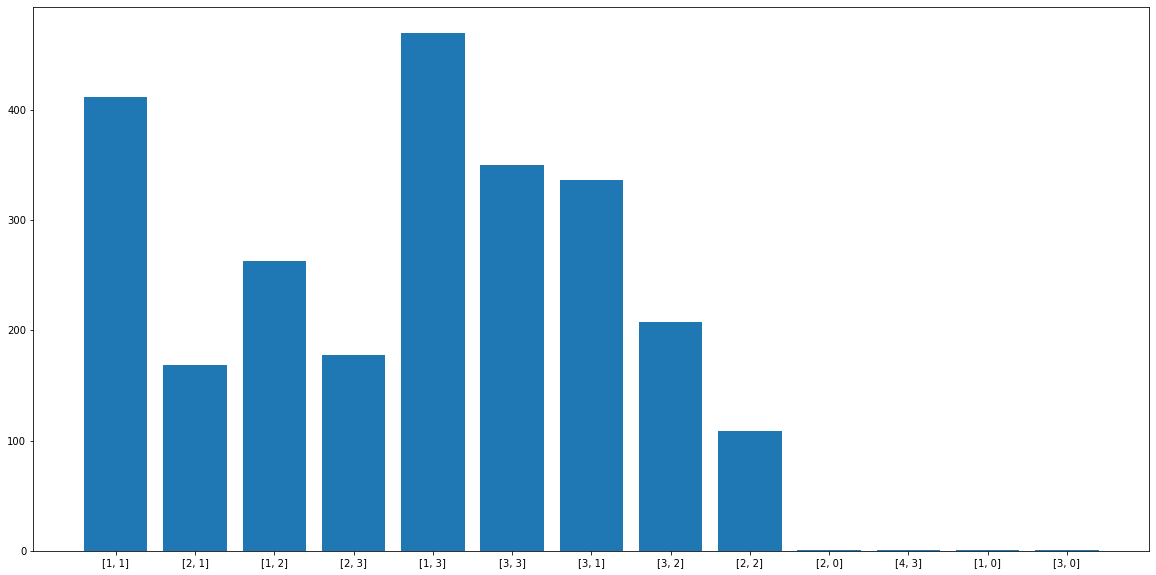

Processing Epoch 223
training start
Iteration 0, d real/fake loss 0.5494590997695923/0.5947282910346985 and g loss is 0.8446435332298279, NDiv loss 0.1292736977338791
Iteration 1, d real/fake loss 0.5492532253265381/0.5704389810562134 and g loss is 0.8224189281463623, NDiv loss 0.12190666049718857
Iteration 2, d real/fake loss 0.54902184009552/0.581882655620575 and g loss is 0.8415950536727905, NDiv loss 0.11754456162452698
Iteration 3, d real/fake loss 0.5487807989120483/0.5800490975379944 and g loss is 0.823151707649231, NDiv loss 0.13781720399856567
Iteration 4, d real/fake loss 0.5485280752182007/0.6004924774169922 and g loss is 0.8289161324501038, NDiv loss 0.1309192031621933


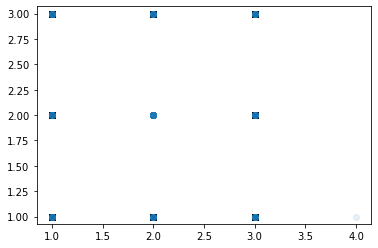

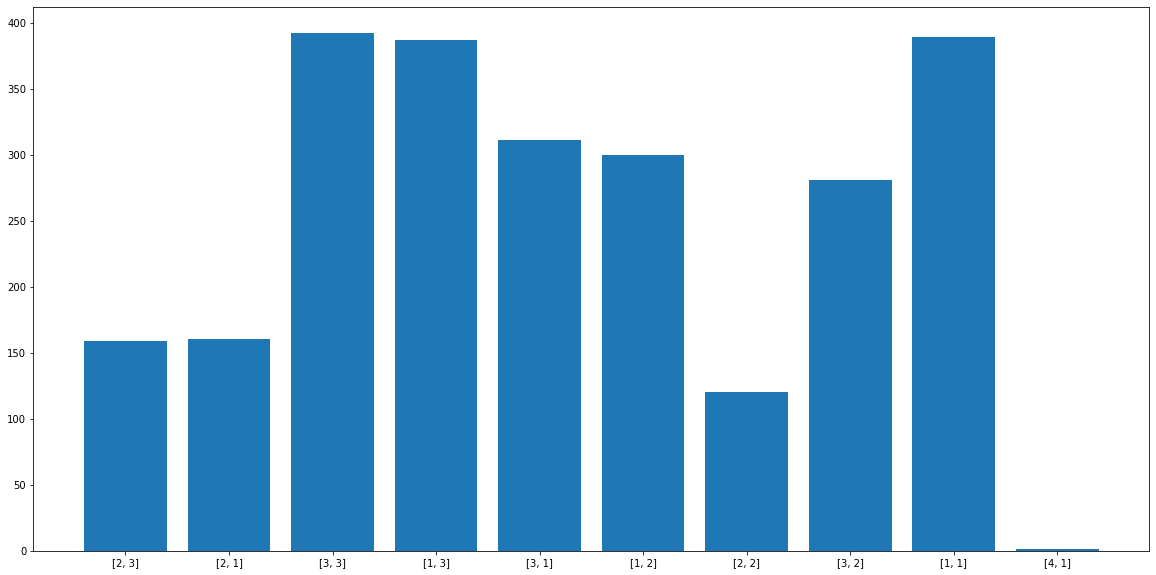

Processing Epoch 224
training start
Iteration 0, d real/fake loss 0.5517433881759644/0.6029117703437805 and g loss is 0.8223774433135986, NDiv loss 0.1310829520225525
Iteration 1, d real/fake loss 0.551653265953064/0.5877941250801086 and g loss is 0.8376446962356567, NDiv loss 0.12121820449829102
Iteration 2, d real/fake loss 0.5515631437301636/0.5866228342056274 and g loss is 0.8317363858222961, NDiv loss 0.12242245674133301
Iteration 3, d real/fake loss 0.551473081111908/0.5935790538787842 and g loss is 0.844266414642334, NDiv loss 0.12441606819629669
Iteration 4, d real/fake loss 0.5513895750045776/0.5721211433410645 and g loss is 0.822185218334198, NDiv loss 0.12432731688022614


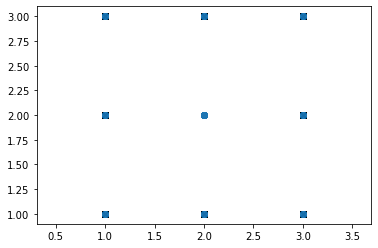

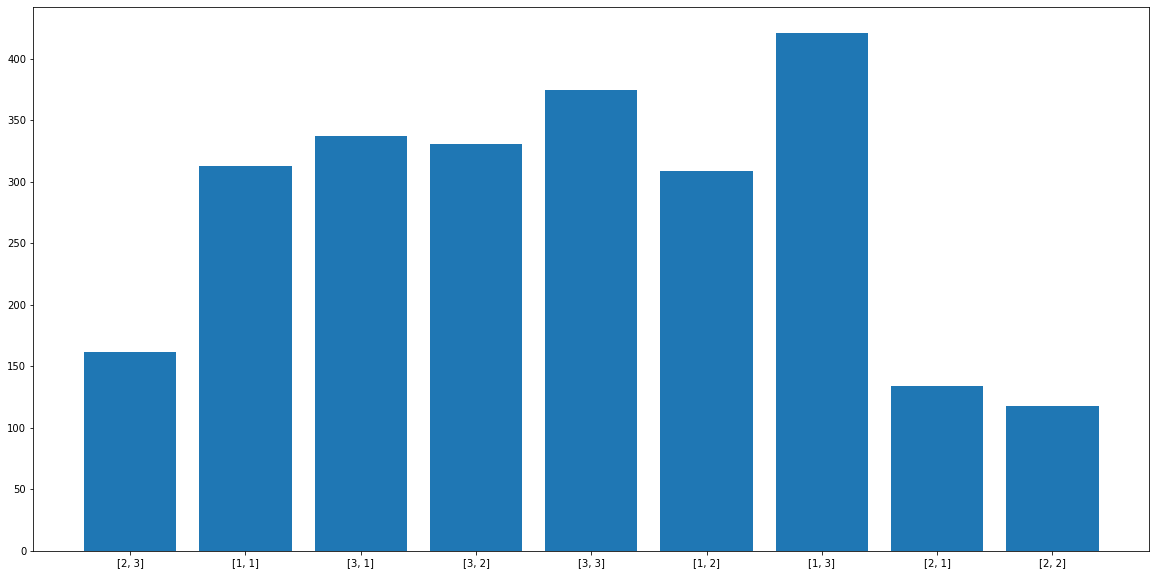

Processing Epoch 225
training start
Iteration 0, d real/fake loss 0.5480824708938599/0.5824023485183716 and g loss is 0.8411757946014404, NDiv loss 0.12512050569057465
Iteration 1, d real/fake loss 0.5479614734649658/0.5899736285209656 and g loss is 0.8368139266967773, NDiv loss 0.123076431453228
Iteration 2, d real/fake loss 0.5478600263595581/0.5799949765205383 and g loss is 0.8281669616699219, NDiv loss 0.12323089689016342
Iteration 3, d real/fake loss 0.5477591156959534/0.5813610553741455 and g loss is 0.8189080953598022, NDiv loss 0.12018590420484543
Iteration 4, d real/fake loss 0.5476589798927307/0.5779429078102112 and g loss is 0.8158011436462402, NDiv loss 0.12471485882997513


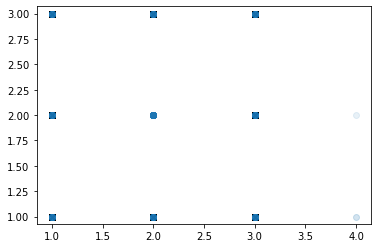

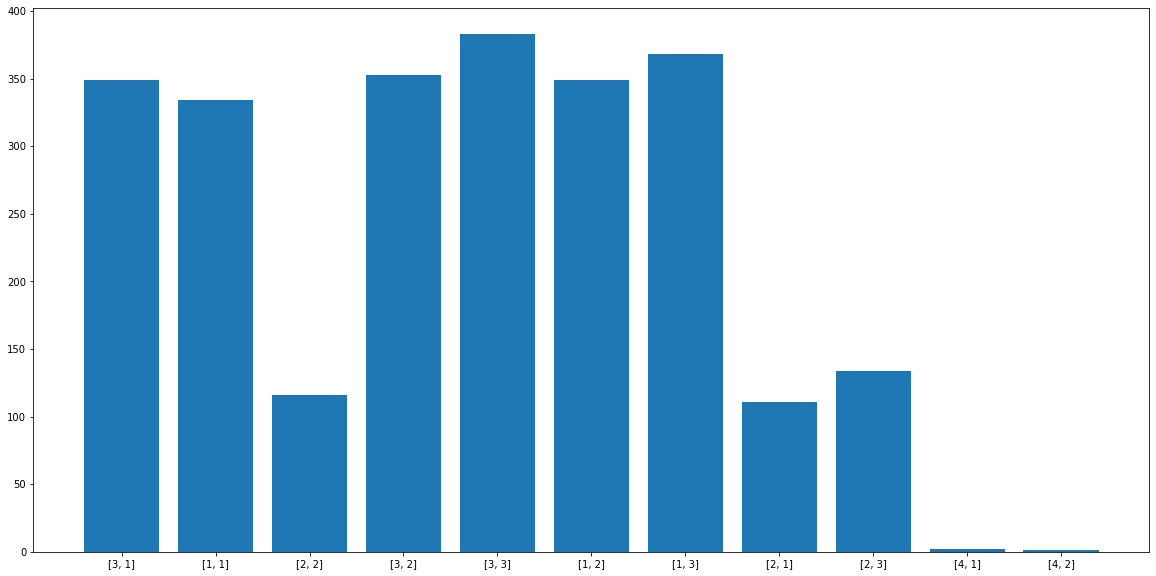

Processing Epoch 226
training start
Iteration 0, d real/fake loss 0.5487698316574097/0.5896956920623779 and g loss is 0.8324758410453796, NDiv loss 0.12615135312080383
Iteration 1, d real/fake loss 0.5486377477645874/0.5980152487754822 and g loss is 0.8201429843902588, NDiv loss 0.12244392186403275
Iteration 2, d real/fake loss 0.5485225319862366/0.587445080280304 and g loss is 0.8235471844673157, NDiv loss 0.13538865745067596
Iteration 3, d real/fake loss 0.5484127998352051/0.5850970149040222 and g loss is 0.8301882743835449, NDiv loss 0.12622393667697906
Iteration 4, d real/fake loss 0.5482989549636841/0.5798193216323853 and g loss is 0.8309811353683472, NDiv loss 0.12708628177642822


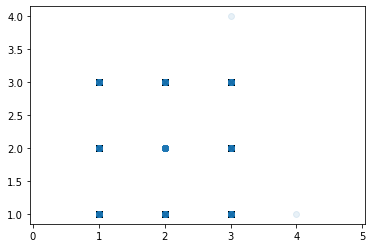

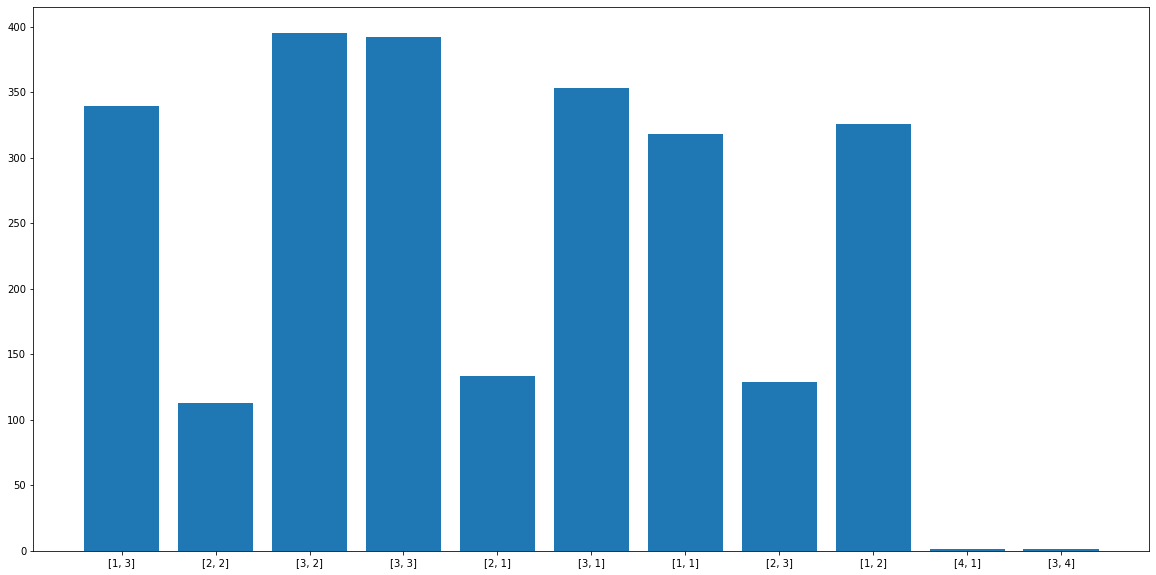

Processing Epoch 227
training start
Iteration 0, d real/fake loss 0.5455705523490906/0.5852682590484619 and g loss is 0.8088483810424805, NDiv loss 0.127984419465065
Iteration 1, d real/fake loss 0.5455526113510132/0.5756055116653442 and g loss is 0.827936053276062, NDiv loss 0.123114675283432
Iteration 2, d real/fake loss 0.5455039143562317/0.5910752415657043 and g loss is 0.8217164874076843, NDiv loss 0.12743093073368073
Iteration 3, d real/fake loss 0.5454525947570801/0.5854581594467163 and g loss is 0.8311524987220764, NDiv loss 0.12369624525308609
Iteration 4, d real/fake loss 0.5453954935073853/0.5775778293609619 and g loss is 0.8211822509765625, NDiv loss 0.12483041733503342


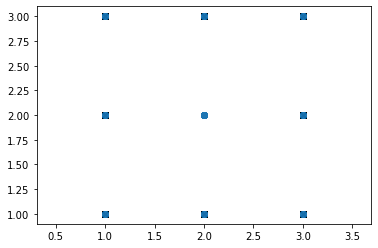

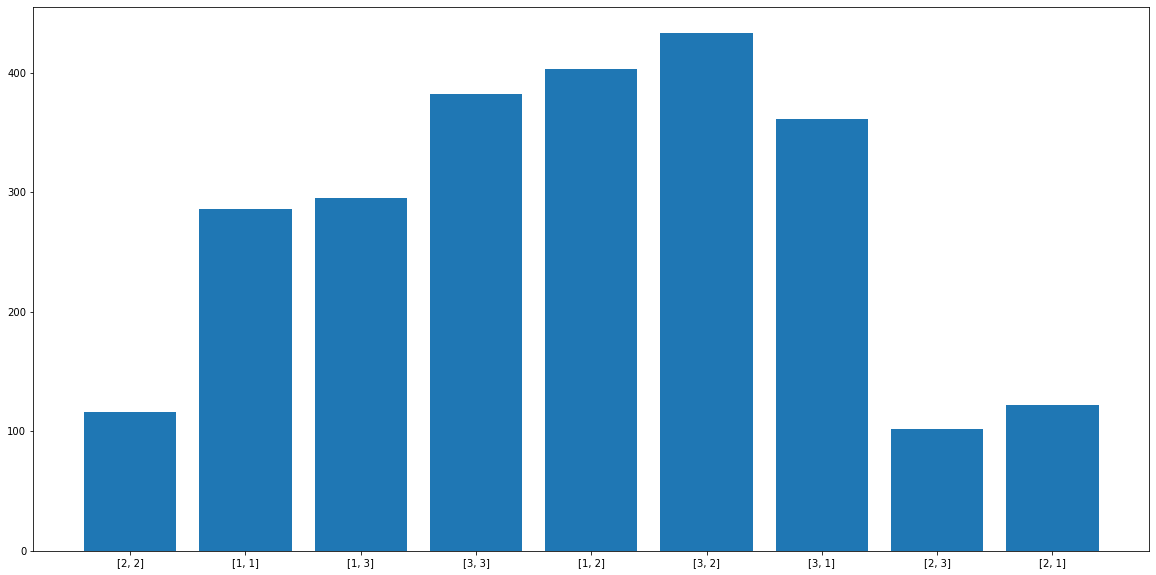

Processing Epoch 228
training start
Iteration 0, d real/fake loss 0.5500549674034119/0.579139769077301 and g loss is 0.8335272669792175, NDiv loss 0.12347234785556793
Iteration 1, d real/fake loss 0.5499648451805115/0.5975574254989624 and g loss is 0.837692141532898, NDiv loss 0.1276269406080246
Iteration 2, d real/fake loss 0.5498853921890259/0.5952696800231934 and g loss is 0.8304111361503601, NDiv loss 0.1243787556886673
Iteration 3, d real/fake loss 0.5498123168945312/0.5918807983398438 and g loss is 0.8403109312057495, NDiv loss 0.12992936372756958
Iteration 4, d real/fake loss 0.5497341156005859/0.584272563457489 and g loss is 0.8264076709747314, NDiv loss 0.12558437883853912


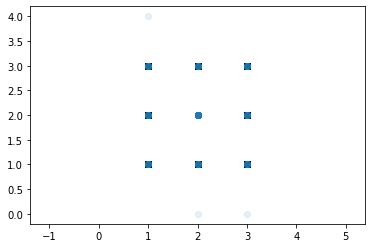

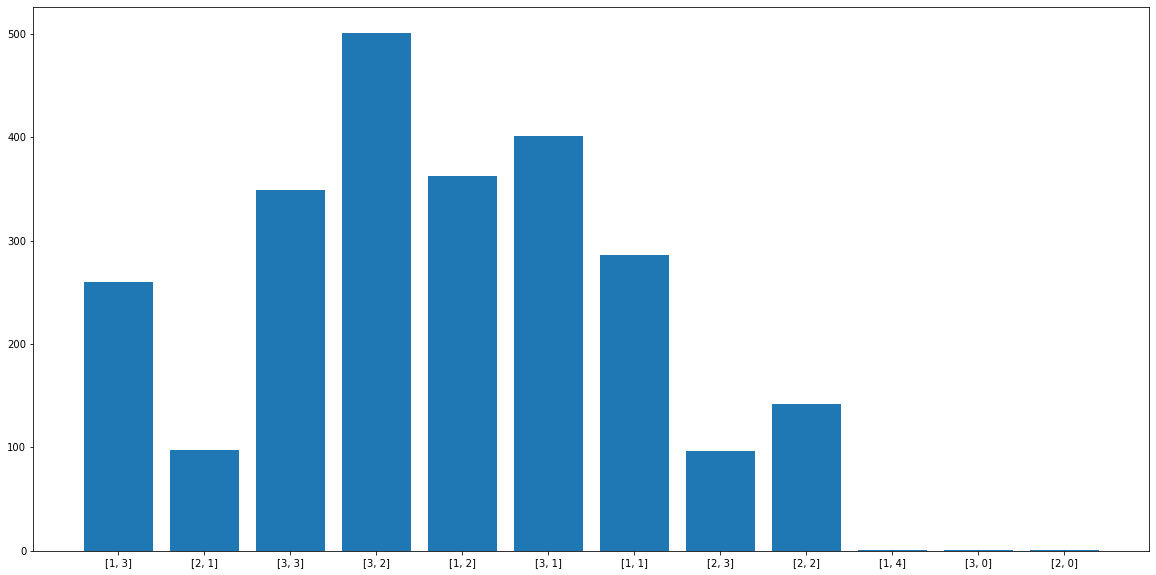

Processing Epoch 229
training start
Iteration 0, d real/fake loss 0.5523990392684937/0.6088572144508362 and g loss is 0.8120119571685791, NDiv loss 0.12923133373260498
Iteration 1, d real/fake loss 0.5524296760559082/0.5838329792022705 and g loss is 0.8226873874664307, NDiv loss 0.129873126745224
Iteration 2, d real/fake loss 0.5524425506591797/0.583797812461853 and g loss is 0.8223375082015991, NDiv loss 0.12540633976459503
Iteration 3, d real/fake loss 0.5524340867996216/0.5833656191825867 and g loss is 0.8083788156509399, NDiv loss 0.12623485922813416
Iteration 4, d real/fake loss 0.5524033308029175/0.5822432041168213 and g loss is 0.8415770530700684, NDiv loss 0.13250957429409027


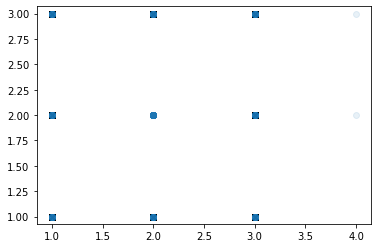

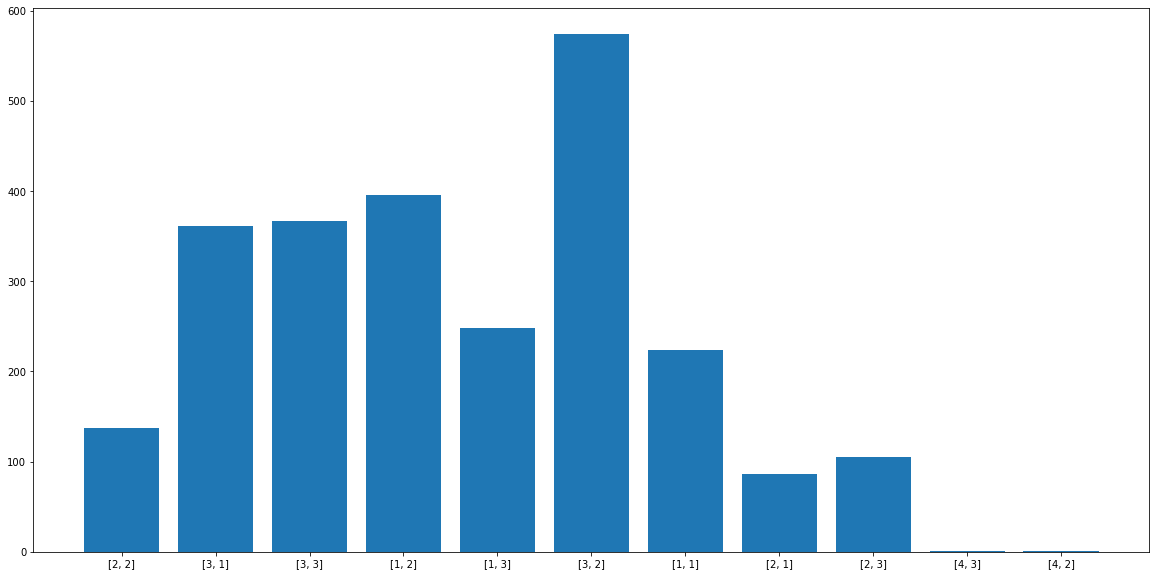

Processing Epoch 230
training start
Iteration 0, d real/fake loss 0.5480051040649414/0.5855587124824524 and g loss is 0.8186834454536438, NDiv loss 0.13011474907398224
Iteration 1, d real/fake loss 0.5479831695556641/0.5689911842346191 and g loss is 0.8173536062240601, NDiv loss 0.1288607269525528
Iteration 2, d real/fake loss 0.5479246973991394/0.5868443846702576 and g loss is 0.8398630023002625, NDiv loss 0.12601421773433685
Iteration 3, d real/fake loss 0.5478724241256714/0.5911540389060974 and g loss is 0.8313747048377991, NDiv loss 0.13436564803123474
Iteration 4, d real/fake loss 0.5478270649909973/0.5859529972076416 and g loss is 0.8384432196617126, NDiv loss 0.12085205316543579


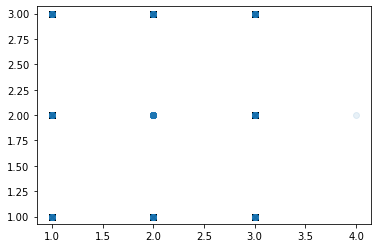

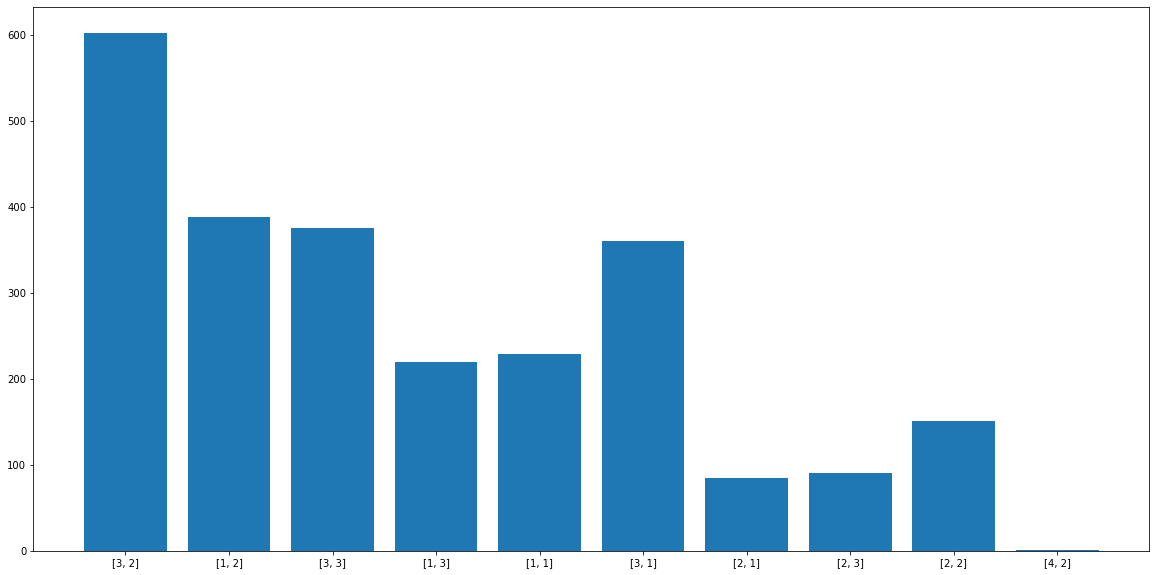

Processing Epoch 231
training start
Iteration 0, d real/fake loss 0.5501490831375122/0.5919015407562256 and g loss is 0.8452956676483154, NDiv loss 0.1341697871685028
Iteration 1, d real/fake loss 0.5501275062561035/0.5692259073257446 and g loss is 0.8260605931282043, NDiv loss 0.127186581492424
Iteration 2, d real/fake loss 0.5500714182853699/0.5862783193588257 and g loss is 0.8384735584259033, NDiv loss 0.12438387423753738
Iteration 3, d real/fake loss 0.5500123500823975/0.5656877160072327 and g loss is 0.8399125337600708, NDiv loss 0.13055157661437988
Iteration 4, d real/fake loss 0.5499047636985779/0.5801277160644531 and g loss is 0.8397605419158936, NDiv loss 0.12860934436321259


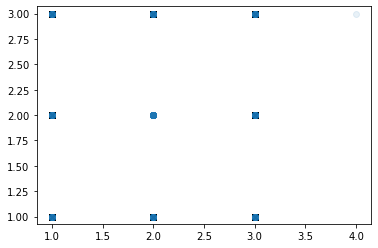

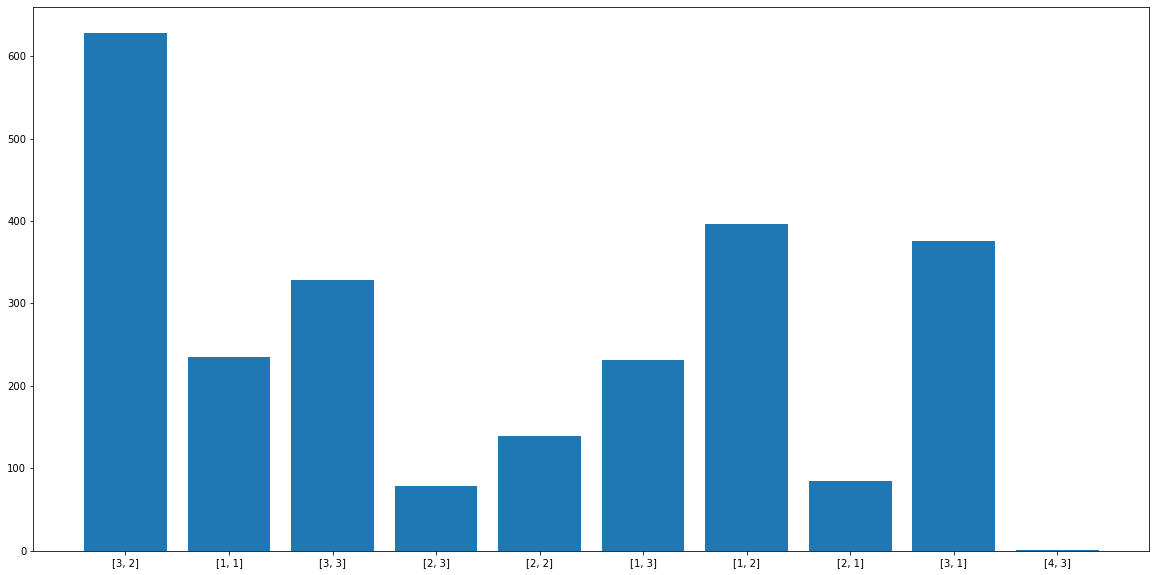

Processing Epoch 232
training start
Iteration 0, d real/fake loss 0.5452834367752075/0.5787819027900696 and g loss is 0.8231626749038696, NDiv loss 0.12462935596704483
Iteration 1, d real/fake loss 0.5452437996864319/0.5903083682060242 and g loss is 0.8373382091522217, NDiv loss 0.13582941889762878
Iteration 2, d real/fake loss 0.5452086925506592/0.5705887079238892 and g loss is 0.8353195190429688, NDiv loss 0.12749439477920532
Iteration 3, d real/fake loss 0.5451349020004272/0.5641289353370667 and g loss is 0.832804262638092, NDiv loss 0.1384078860282898
Iteration 4, d real/fake loss 0.5450260043144226/0.5732806324958801 and g loss is 0.8533364534378052, NDiv loss 0.12675808370113373


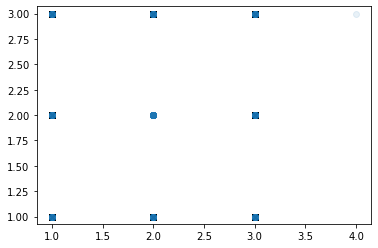

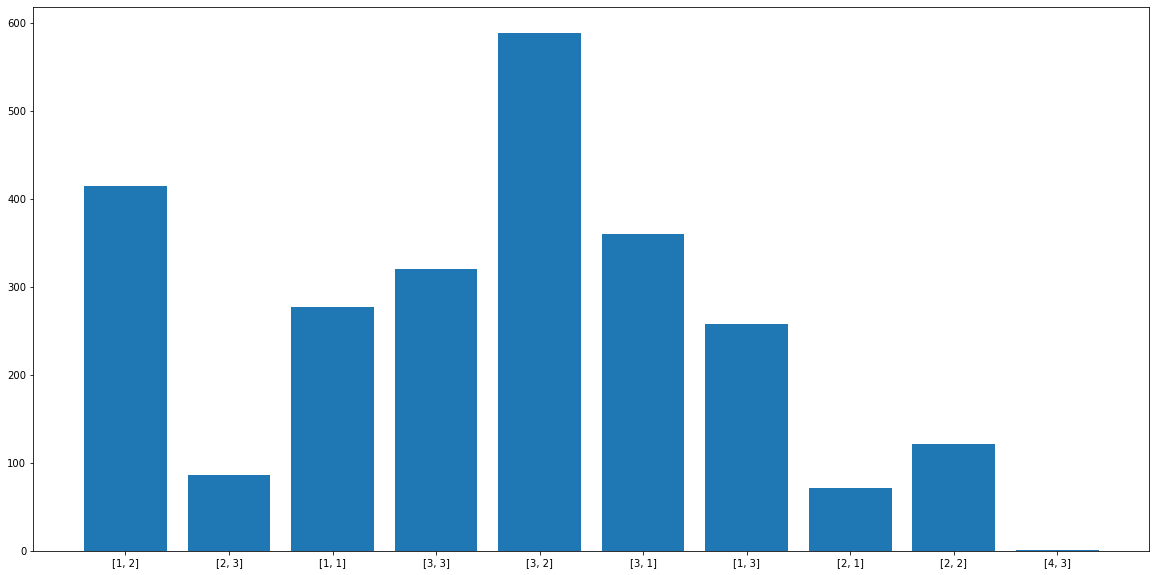

Processing Epoch 233
training start
Iteration 0, d real/fake loss 0.5470313429832458/0.587329626083374 and g loss is 0.844344437122345, NDiv loss 0.13175903260707855
Iteration 1, d real/fake loss 0.5468651056289673/0.571956992149353 and g loss is 0.8413983583450317, NDiv loss 0.13236726820468903
Iteration 2, d real/fake loss 0.5466840267181396/0.581217885017395 and g loss is 0.854150652885437, NDiv loss 0.13966993987560272
Iteration 3, d real/fake loss 0.546509325504303/0.5684134364128113 and g loss is 0.8403222560882568, NDiv loss 0.12539629638195038
Iteration 4, d real/fake loss 0.5463144779205322/0.5726417303085327 and g loss is 0.8263858556747437, NDiv loss 0.1252223700284958


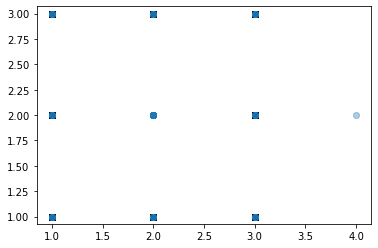

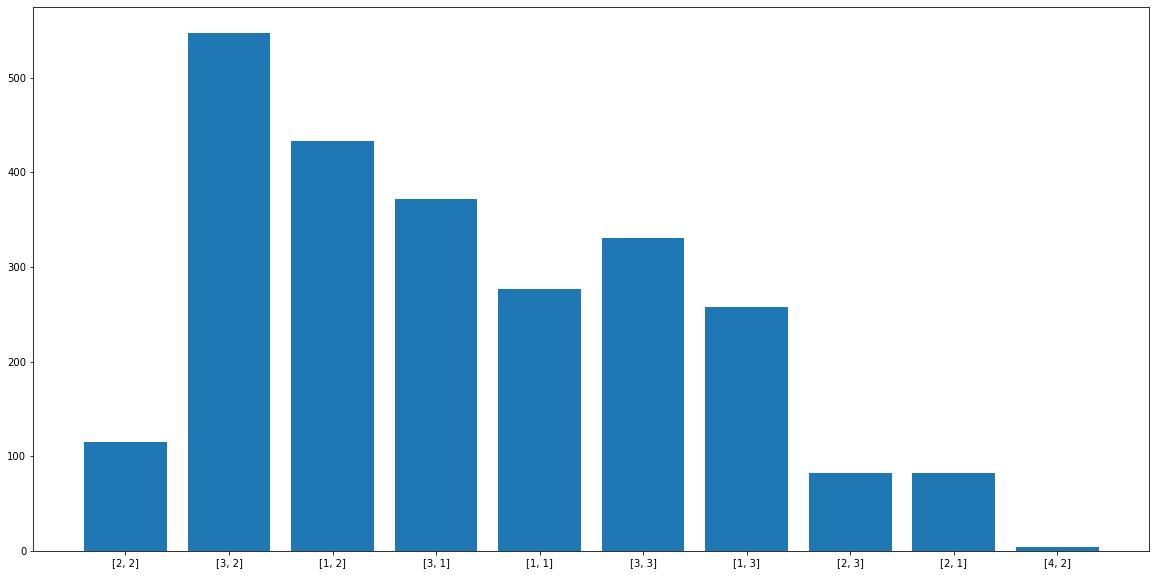

Processing Epoch 234
training start
Iteration 0, d real/fake loss 0.5464895367622375/0.5622029304504395 and g loss is 0.8421660661697388, NDiv loss 0.1263911873102188
Iteration 1, d real/fake loss 0.5463106632232666/0.5638101696968079 and g loss is 0.8709559440612793, NDiv loss 0.1287100613117218
Iteration 2, d real/fake loss 0.5460991859436035/0.5763598680496216 and g loss is 0.8616070747375488, NDiv loss 0.12542207539081573
Iteration 3, d real/fake loss 0.5458880662918091/0.5690995454788208 and g loss is 0.8638025522232056, NDiv loss 0.12945346534252167
Iteration 4, d real/fake loss 0.5456546545028687/0.5564535856246948 and g loss is 0.8416965007781982, NDiv loss 0.12764522433280945


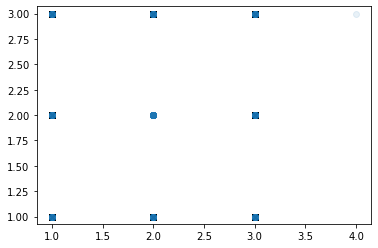

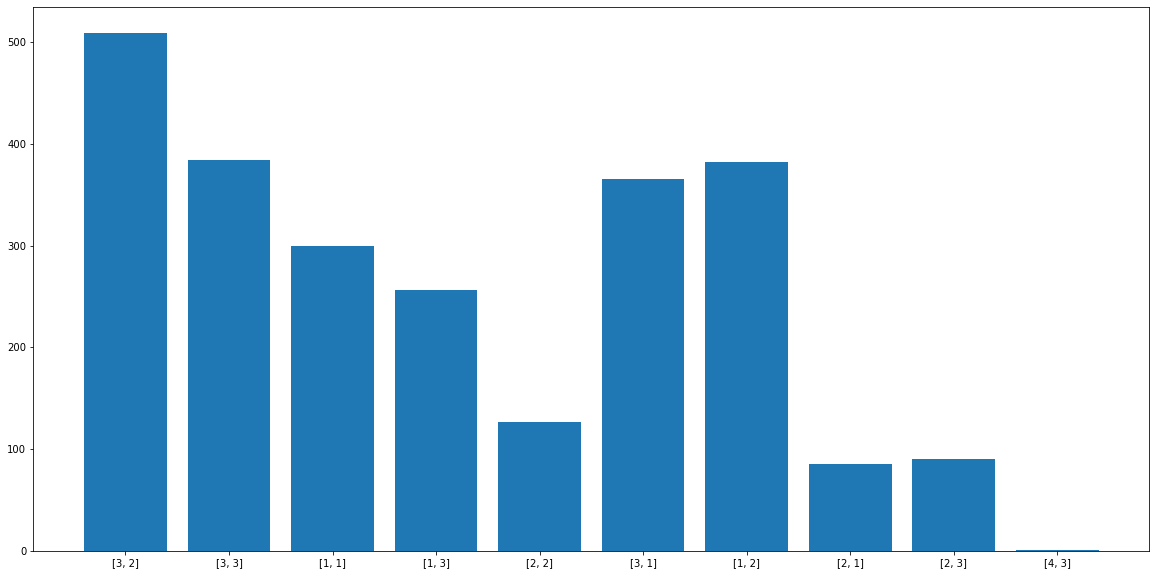

Processing Epoch 235
training start
Iteration 0, d real/fake loss 0.5412907600402832/0.5825122594833374 and g loss is 0.8217493295669556, NDiv loss 0.12395050376653671
Iteration 1, d real/fake loss 0.5410879850387573/0.5664728879928589 and g loss is 0.8523566722869873, NDiv loss 0.12854711711406708
Iteration 2, d real/fake loss 0.5408619046211243/0.5745741128921509 and g loss is 0.8539720773696899, NDiv loss 0.12446427345275879
Iteration 3, d real/fake loss 0.5406238436698914/0.5651538968086243 and g loss is 0.8398264050483704, NDiv loss 0.12276895344257355
Iteration 4, d real/fake loss 0.5403618812561035/0.5747838020324707 and g loss is 0.8520254492759705, NDiv loss 0.12965594232082367


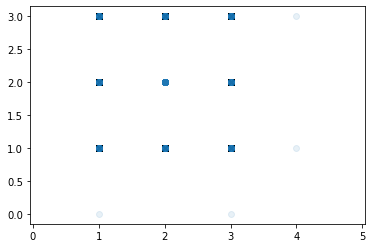

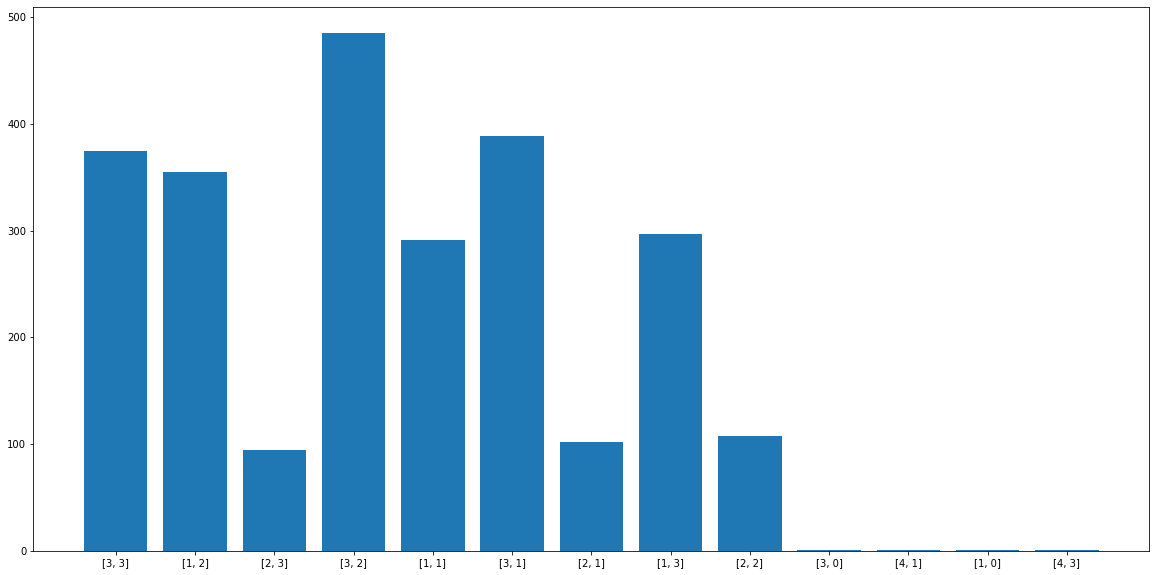

Processing Epoch 236
training start
Iteration 0, d real/fake loss 0.5454050898551941/0.5667078495025635 and g loss is 0.8183221817016602, NDiv loss 0.13244763016700745
Iteration 1, d real/fake loss 0.5452015995979309/0.5576978325843811 and g loss is 0.8600429892539978, NDiv loss 0.12512493133544922
Iteration 2, d real/fake loss 0.5449768900871277/0.572117030620575 and g loss is 0.8449910879135132, NDiv loss 0.13011538982391357
Iteration 3, d real/fake loss 0.5447598099708557/0.5700932741165161 and g loss is 0.8390401005744934, NDiv loss 0.12465592473745346
Iteration 4, d real/fake loss 0.5445454120635986/0.5812323689460754 and g loss is 0.8511135578155518, NDiv loss 0.12708905339241028


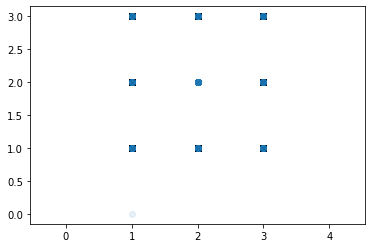

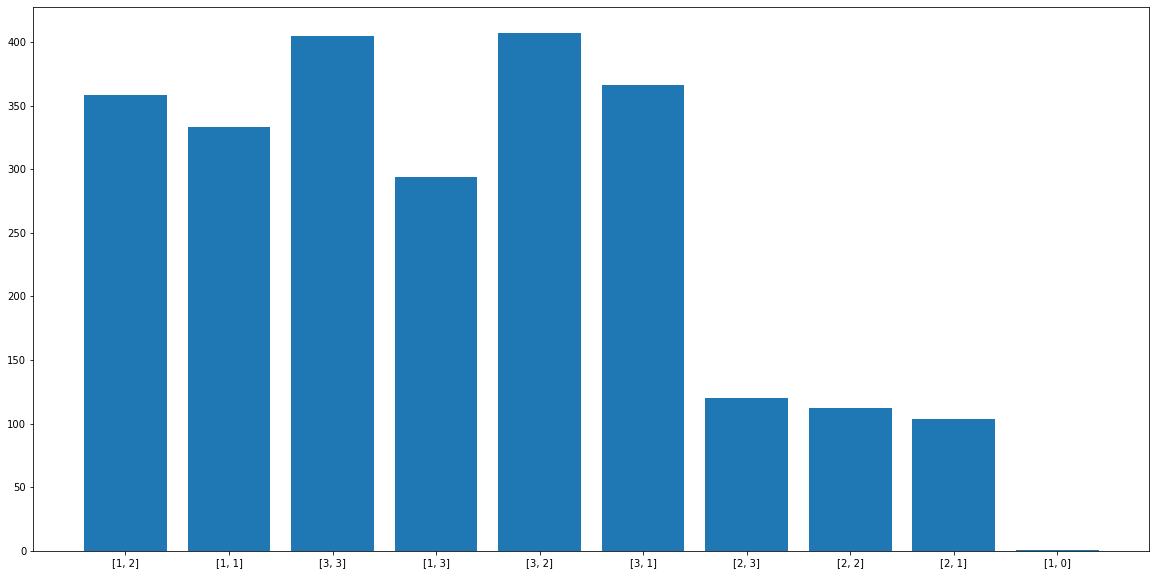

Processing Epoch 237
training start
Iteration 0, d real/fake loss 0.5412473678588867/0.5593357086181641 and g loss is 0.8435056805610657, NDiv loss 0.1348031610250473
Iteration 1, d real/fake loss 0.5410066843032837/0.5689464807510376 and g loss is 0.8535446524620056, NDiv loss 0.1337706595659256
Iteration 2, d real/fake loss 0.5407660007476807/0.5649588108062744 and g loss is 0.8628515601158142, NDiv loss 0.12627892196178436
Iteration 3, d real/fake loss 0.5405216813087463/0.5666807293891907 and g loss is 0.8419630527496338, NDiv loss 0.12758517265319824
Iteration 4, d real/fake loss 0.540271520614624/0.5812154412269592 and g loss is 0.8327359557151794, NDiv loss 0.12838444113731384


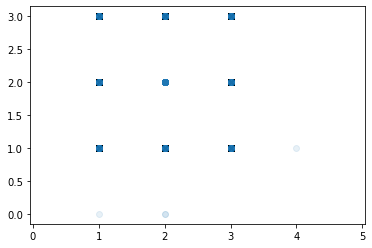

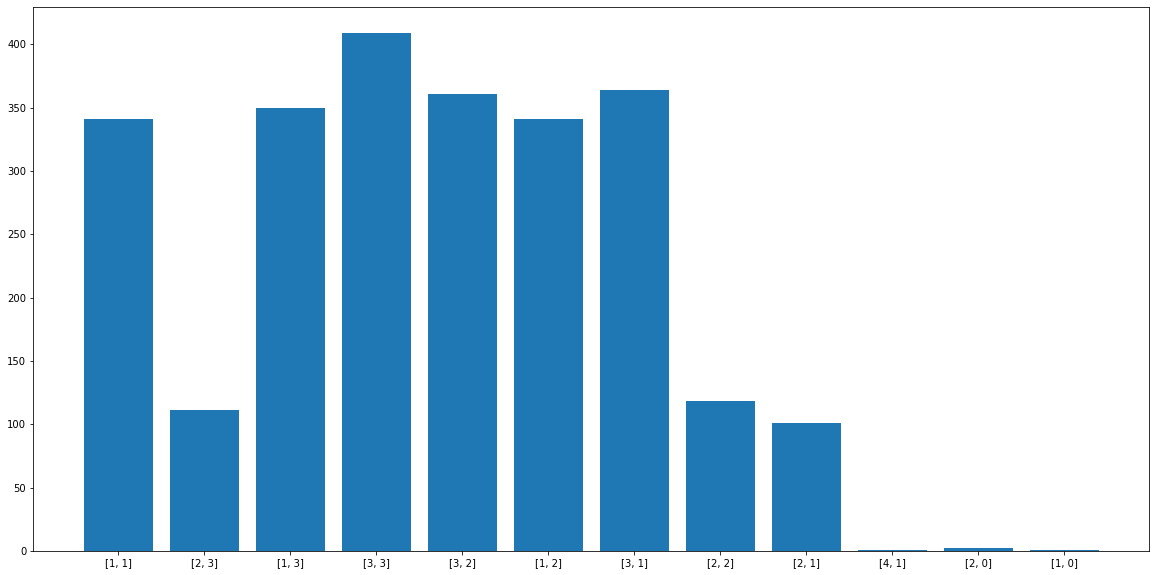

Processing Epoch 238
training start
Iteration 0, d real/fake loss 0.5295701026916504/0.5617306232452393 and g loss is 0.8521348834037781, NDiv loss 0.12697456777095795
Iteration 1, d real/fake loss 0.5291739702224731/0.5642495155334473 and g loss is 0.855582594871521, NDiv loss 0.12768368422985077
Iteration 2, d real/fake loss 0.5287668704986572/0.581574559211731 and g loss is 0.849002480506897, NDiv loss 0.12498747557401657
Iteration 3, d real/fake loss 0.528387725353241/0.572699785232544 and g loss is 0.8481450080871582, NDiv loss 0.12652848660945892
Iteration 4, d real/fake loss 0.5280143618583679/0.5719449520111084 and g loss is 0.8548798561096191, NDiv loss 0.12853582203388214


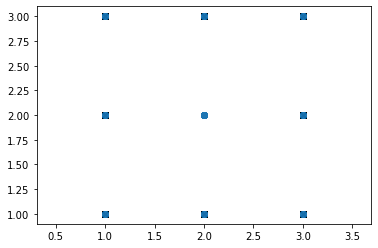

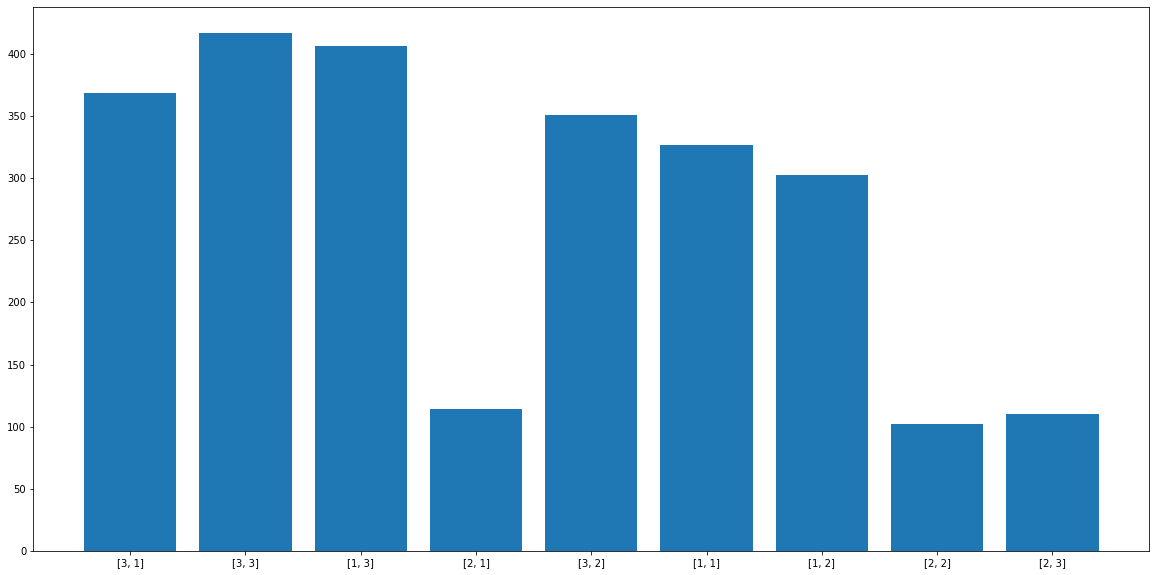

Processing Epoch 239
training start
Iteration 0, d real/fake loss 0.5361286401748657/0.5757485628128052 and g loss is 0.84309983253479, NDiv loss 0.12761680781841278
Iteration 1, d real/fake loss 0.5359511375427246/0.5724695920944214 and g loss is 0.8433975577354431, NDiv loss 0.12446842342615128
Iteration 2, d real/fake loss 0.5357789993286133/0.573514461517334 and g loss is 0.8627059459686279, NDiv loss 0.1271519809961319
Iteration 3, d real/fake loss 0.5356141328811646/0.569199800491333 and g loss is 0.844346284866333, NDiv loss 0.1256842464208603
Iteration 4, d real/fake loss 0.535447895526886/0.5576813817024231 and g loss is 0.8398370146751404, NDiv loss 0.12666001915931702


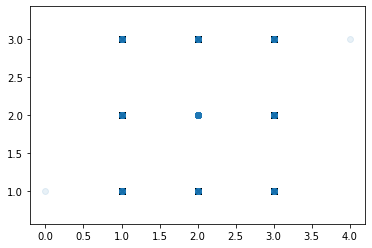

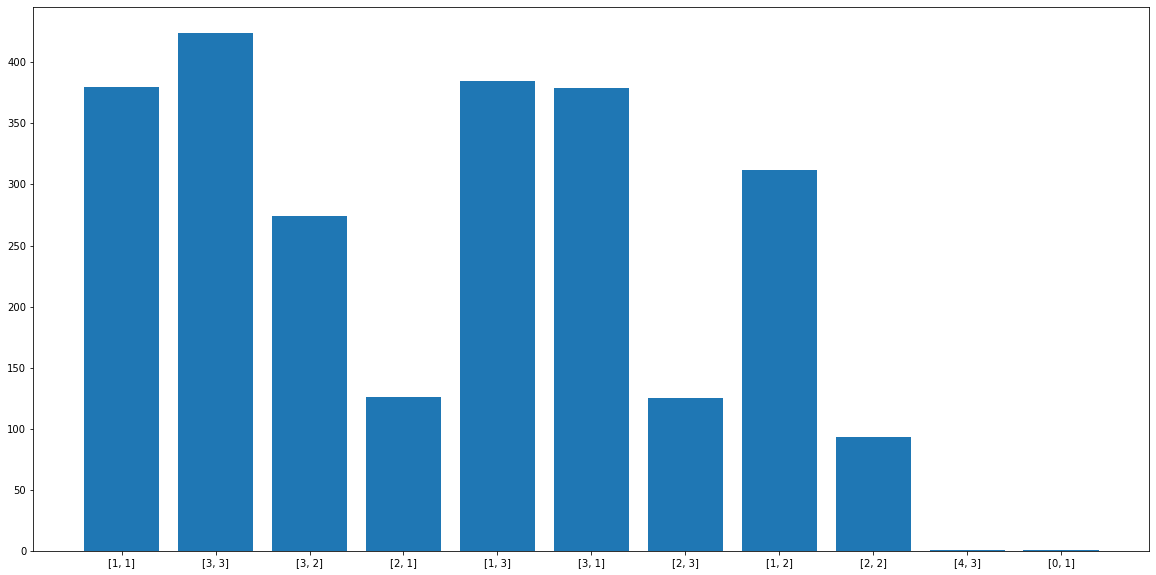

Processing Epoch 240
training start
Iteration 0, d real/fake loss 0.5390539169311523/0.5605717897415161 and g loss is 0.8613863587379456, NDiv loss 0.1258283108472824
Iteration 1, d real/fake loss 0.5388967990875244/0.5658718347549438 and g loss is 0.8432488441467285, NDiv loss 0.12713564932346344
Iteration 2, d real/fake loss 0.5387358665466309/0.5707523822784424 and g loss is 0.837846040725708, NDiv loss 0.1294243335723877
Iteration 3, d real/fake loss 0.5385783910751343/0.5536310076713562 and g loss is 0.8637180328369141, NDiv loss 0.12441845238208771
Iteration 4, d real/fake loss 0.5383912324905396/0.5680159330368042 and g loss is 0.8466612100601196, NDiv loss 0.12484776228666306


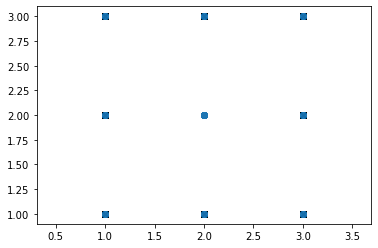

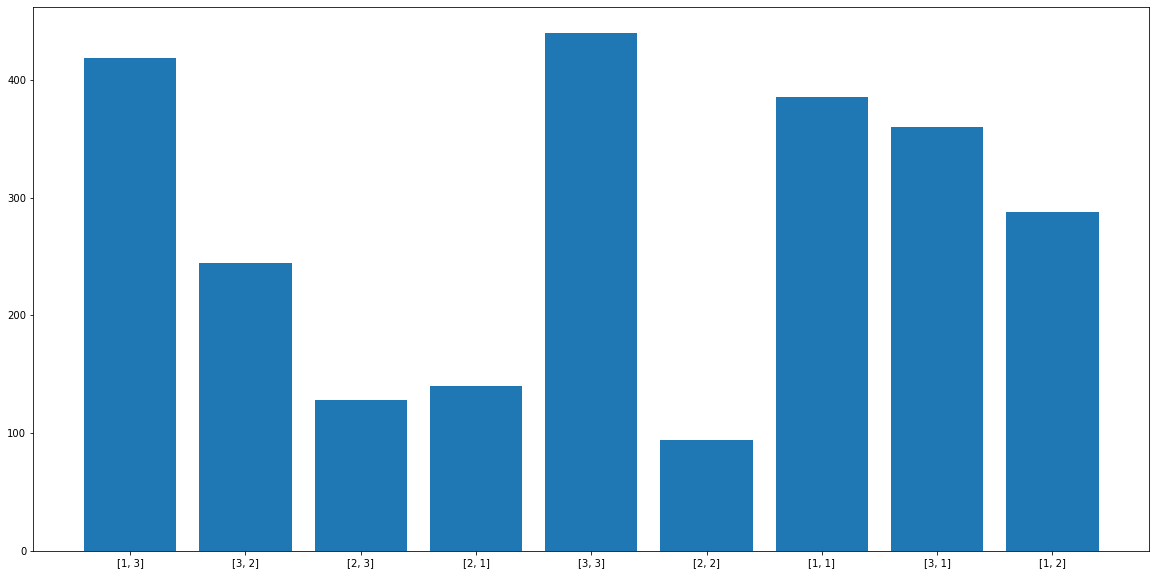

Processing Epoch 241
training start
Iteration 0, d real/fake loss 0.5344095230102539/0.5754430294036865 and g loss is 0.8458293676376343, NDiv loss 0.12430650740861893
Iteration 1, d real/fake loss 0.534244179725647/0.5631303191184998 and g loss is 0.8163008093833923, NDiv loss 0.12803496420383453
Iteration 2, d real/fake loss 0.5340567231178284/0.5699357390403748 and g loss is 0.8321734070777893, NDiv loss 0.12456192076206207
Iteration 3, d real/fake loss 0.5338733196258545/0.5646424293518066 and g loss is 0.8395991921424866, NDiv loss 0.12880565226078033
Iteration 4, d real/fake loss 0.5336883068084717/0.5591591596603394 and g loss is 0.8380323648452759, NDiv loss 0.12858863174915314


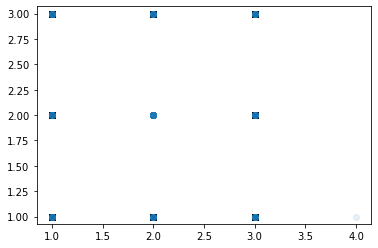

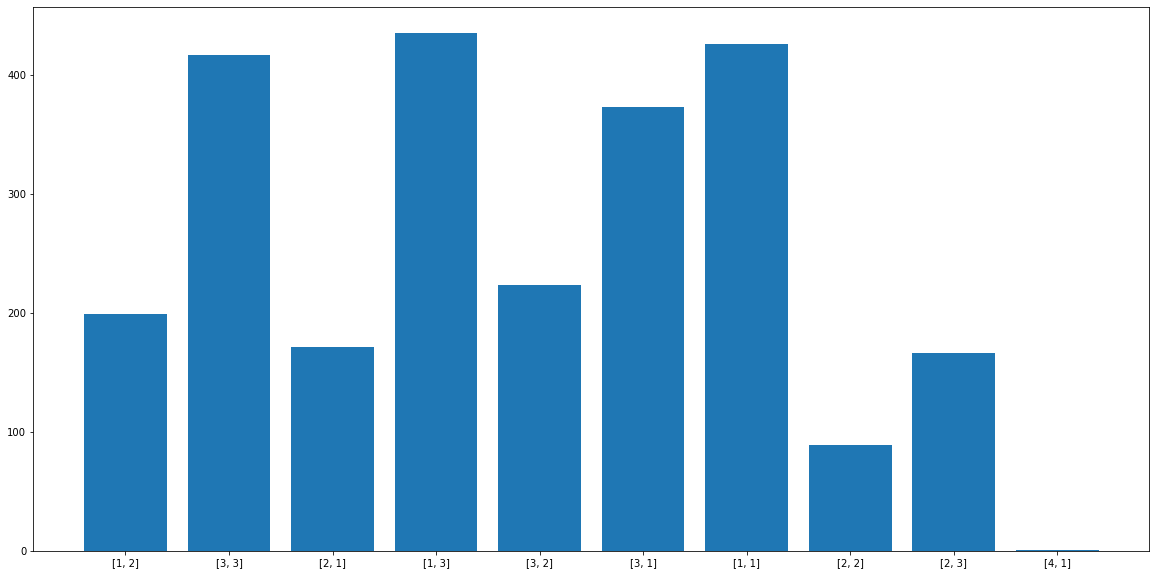

Processing Epoch 242
training start
Iteration 0, d real/fake loss 0.5342607498168945/0.5630346536636353 and g loss is 0.8493432998657227, NDiv loss 0.12325706332921982
Iteration 1, d real/fake loss 0.5340828895568848/0.5700240135192871 and g loss is 0.8314467668533325, NDiv loss 0.12777364253997803
Iteration 2, d real/fake loss 0.5339243412017822/0.567957878112793 and g loss is 0.8359413146972656, NDiv loss 0.12956765294075012
Iteration 3, d real/fake loss 0.5337718725204468/0.555364191532135 and g loss is 0.850284993648529, NDiv loss 0.13098664581775665
Iteration 4, d real/fake loss 0.5336034297943115/0.5771262645721436 and g loss is 0.8388018608093262, NDiv loss 0.12958702445030212


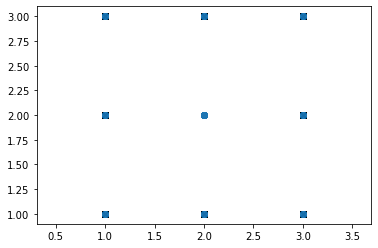

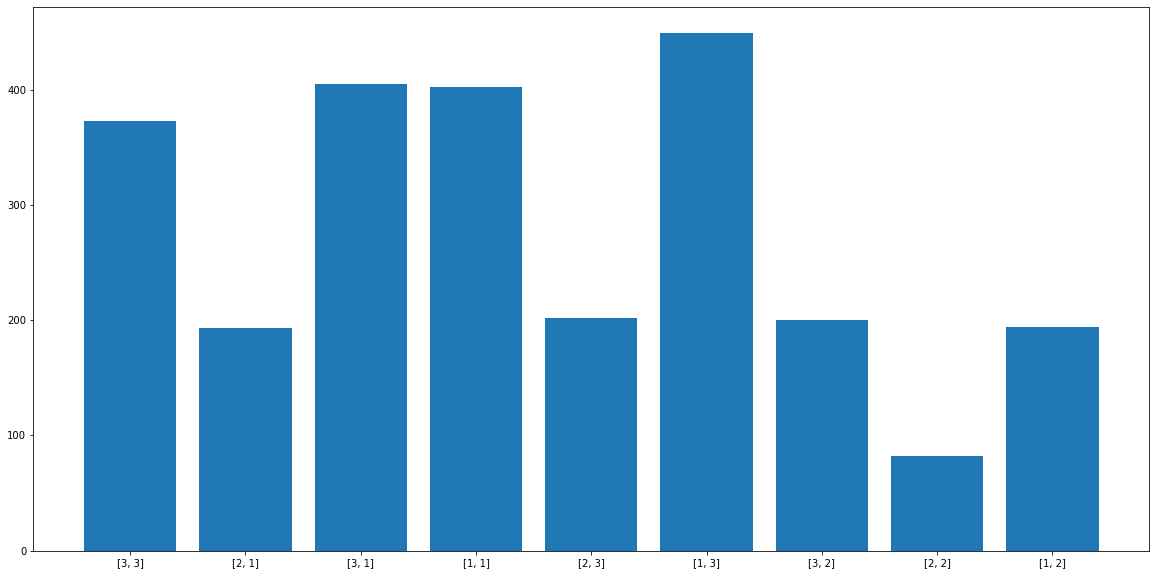

Processing Epoch 243
training start
Iteration 0, d real/fake loss 0.5342147350311279/0.5684552192687988 and g loss is 0.8415448665618896, NDiv loss 0.1242024302482605
Iteration 1, d real/fake loss 0.5341008901596069/0.5766770839691162 and g loss is 0.8422433137893677, NDiv loss 0.12518732249736786
Iteration 2, d real/fake loss 0.5340086817741394/0.5744991302490234 and g loss is 0.8582555055618286, NDiv loss 0.12287960201501846
Iteration 3, d real/fake loss 0.5339301228523254/0.5790451765060425 and g loss is 0.832706093788147, NDiv loss 0.1280626505613327
Iteration 4, d real/fake loss 0.5338720083236694/0.5731006264686584 and g loss is 0.8598370552062988, NDiv loss 0.12803040444850922


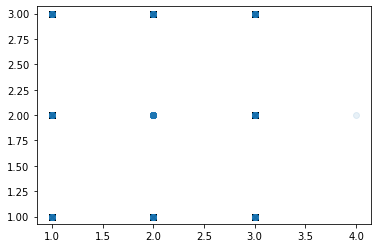

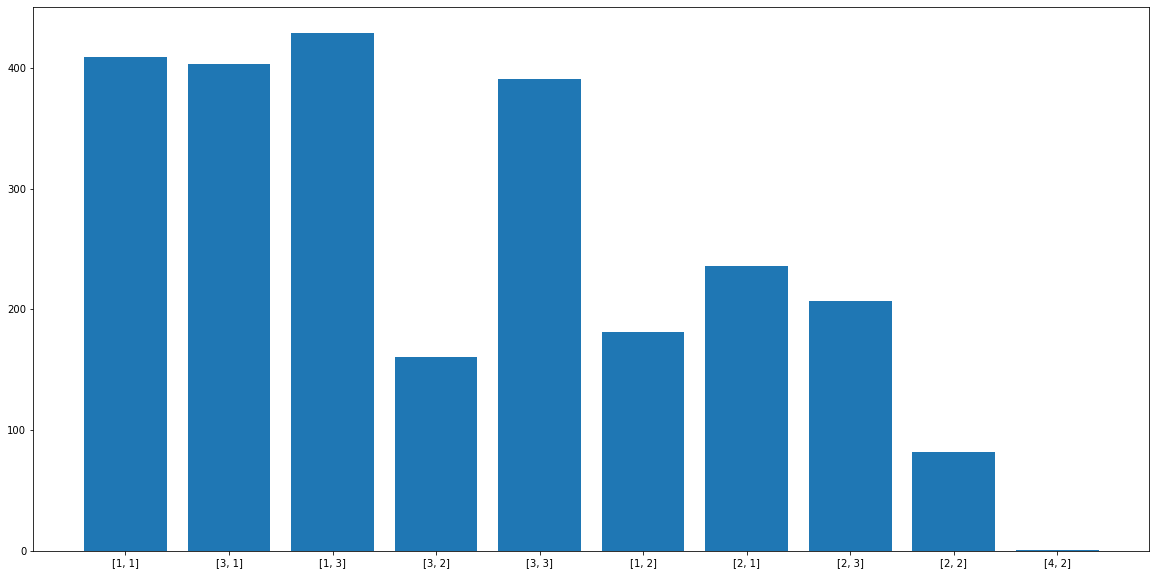

Processing Epoch 244
training start
Iteration 0, d real/fake loss 0.5325130820274353/0.5797727108001709 and g loss is 0.8481682538986206, NDiv loss 0.13354969024658203
Iteration 1, d real/fake loss 0.532480776309967/0.5670459270477295 and g loss is 0.8443821668624878, NDiv loss 0.1302521675825119
Iteration 2, d real/fake loss 0.5324432849884033/0.5745487213134766 and g loss is 0.8457114696502686, NDiv loss 0.12421507388353348
Iteration 3, d real/fake loss 0.5324196815490723/0.5888585448265076 and g loss is 0.8178906440734863, NDiv loss 0.12195397913455963
Iteration 4, d real/fake loss 0.5324306488037109/0.5666362643241882 and g loss is 0.8463478684425354, NDiv loss 0.13222478330135345


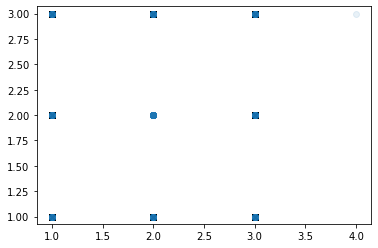

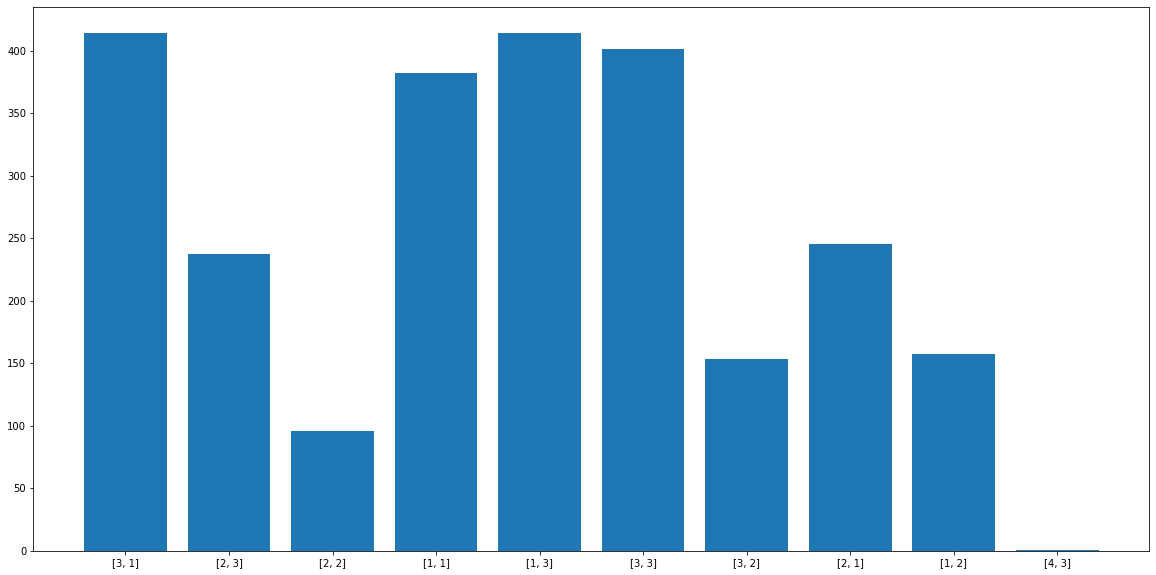

Processing Epoch 245
training start
Iteration 0, d real/fake loss 0.5345436334609985/0.5740423202514648 and g loss is 0.8161158561706543, NDiv loss 0.12557964026927948
Iteration 1, d real/fake loss 0.5345590114593506/0.588664710521698 and g loss is 0.8484145402908325, NDiv loss 0.12839224934577942
Iteration 2, d real/fake loss 0.5345994234085083/0.5773788094520569 and g loss is 0.8333950042724609, NDiv loss 0.1294538676738739
Iteration 3, d real/fake loss 0.5346450805664062/0.588505208492279 and g loss is 0.8373330235481262, NDiv loss 0.12673982977867126
Iteration 4, d real/fake loss 0.5347075462341309/0.5767340064048767 and g loss is 0.8495903015136719, NDiv loss 0.12800158560276031


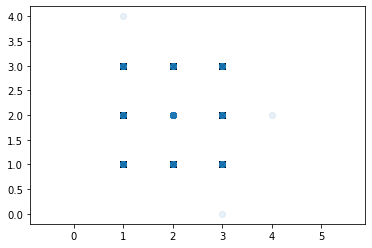

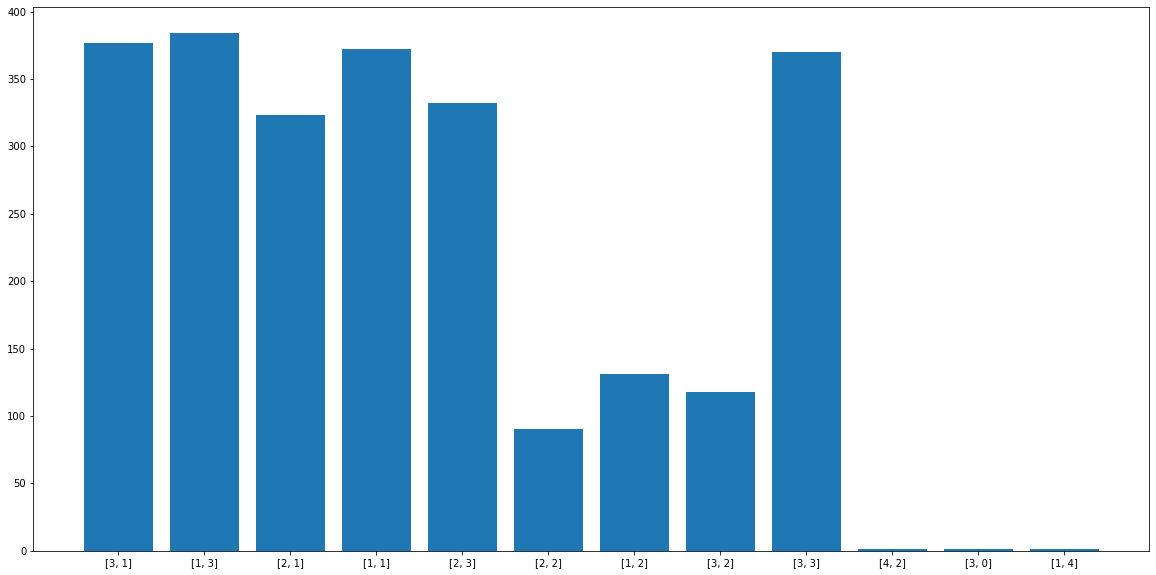

Processing Epoch 246
training start
Iteration 0, d real/fake loss 0.5322932004928589/0.5729459524154663 and g loss is 0.8247019052505493, NDiv loss 0.12987945973873138
Iteration 1, d real/fake loss 0.5324058532714844/0.5819255113601685 and g loss is 0.8436899185180664, NDiv loss 0.13423016667366028
Iteration 2, d real/fake loss 0.5325349569320679/0.5885511636734009 and g loss is 0.8269673585891724, NDiv loss 0.12193760275840759
Iteration 3, d real/fake loss 0.5326995849609375/0.5793334245681763 and g loss is 0.8476015329360962, NDiv loss 0.13199444115161896
Iteration 4, d real/fake loss 0.532873272895813/0.5730758905410767 and g loss is 0.832634687423706, NDiv loss 0.12907567620277405


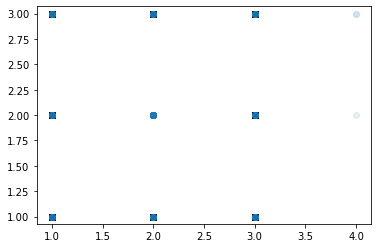

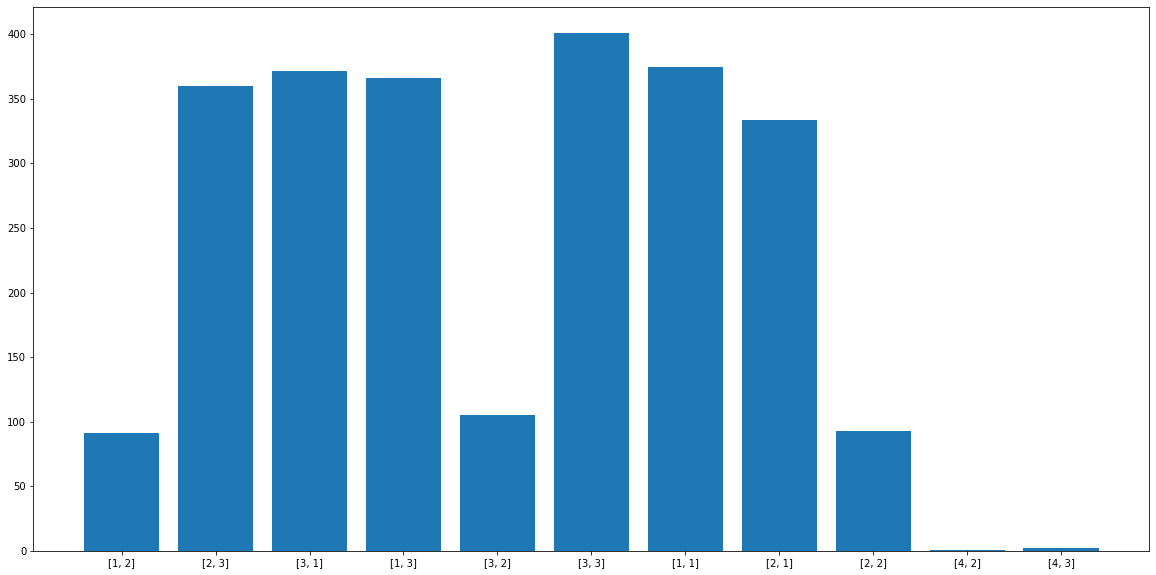

Processing Epoch 247
training start
Iteration 0, d real/fake loss 0.5390899777412415/0.5716773867607117 and g loss is 0.8167660236358643, NDiv loss 0.1273382604122162
Iteration 1, d real/fake loss 0.5392626523971558/0.5800890922546387 and g loss is 0.8252413272857666, NDiv loss 0.13098135590553284
Iteration 2, d real/fake loss 0.539439857006073/0.6038863658905029 and g loss is 0.8481247425079346, NDiv loss 0.12838588654994965
Iteration 3, d real/fake loss 0.5396636128425598/0.5902464985847473 and g loss is 0.8258858919143677, NDiv loss 0.12730008363723755
Iteration 4, d real/fake loss 0.5399043560028076/0.5986706018447876 and g loss is 0.8215415477752686, NDiv loss 0.131395161151886


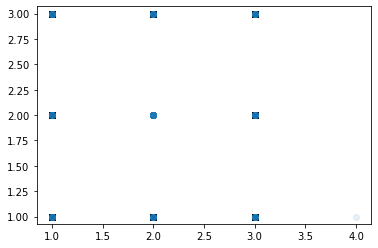

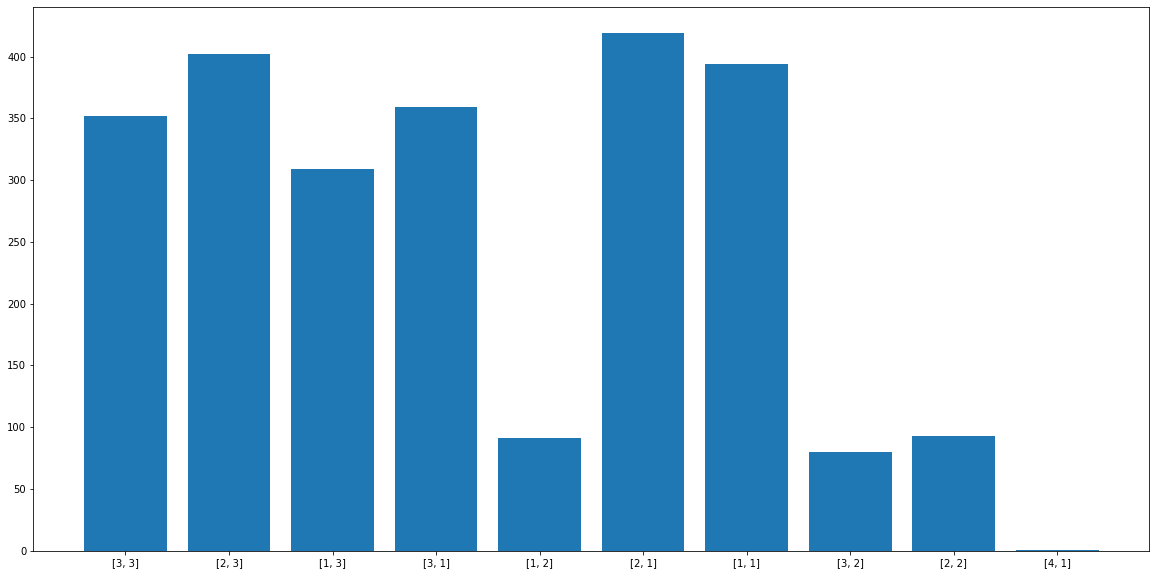

Processing Epoch 248
training start
Iteration 0, d real/fake loss 0.5281013250350952/0.596309244632721 and g loss is 0.8103341460227966, NDiv loss 0.12490703165531158
Iteration 1, d real/fake loss 0.5286229252815247/0.5882281064987183 and g loss is 0.8191070556640625, NDiv loss 0.1324368566274643
Iteration 2, d real/fake loss 0.5291564464569092/0.5942745208740234 and g loss is 0.8189727067947388, NDiv loss 0.12510347366333008
Iteration 3, d real/fake loss 0.5297064185142517/0.5762648582458496 and g loss is 0.8312583565711975, NDiv loss 0.13647915422916412
Iteration 4, d real/fake loss 0.5302456617355347/0.5964046716690063 and g loss is 0.8187476396560669, NDiv loss 0.1339925229549408


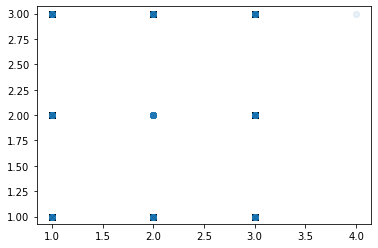

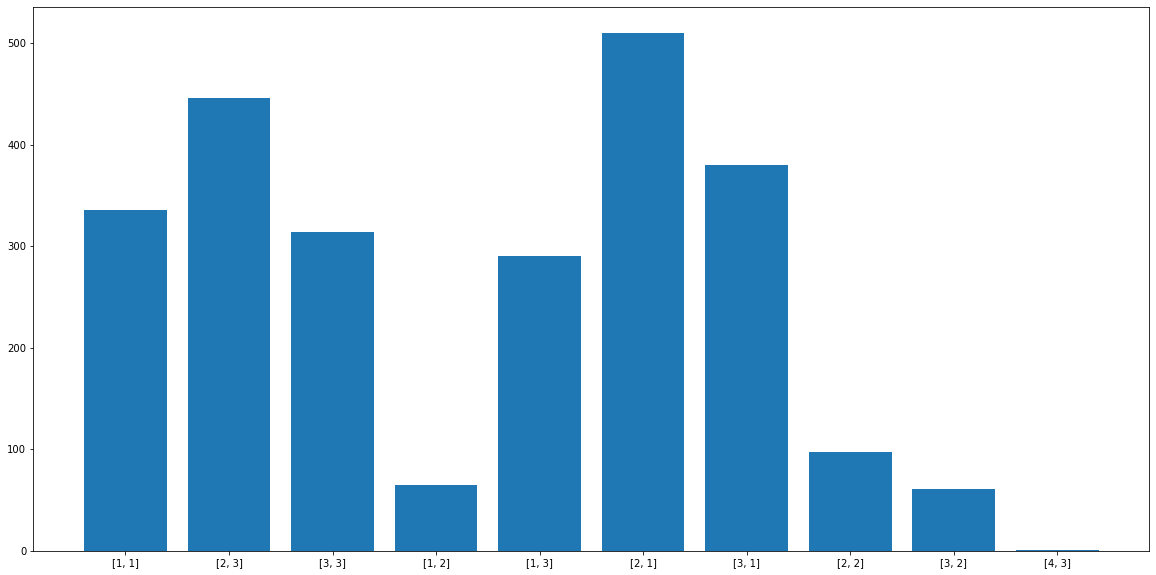

Processing Epoch 249
training start
Iteration 0, d real/fake loss 0.5426988005638123/0.5908358097076416 and g loss is 0.8228534460067749, NDiv loss 0.12841133773326874
Iteration 1, d real/fake loss 0.5431700944900513/0.5911718010902405 and g loss is 0.8234354257583618, NDiv loss 0.12784485518932343
Iteration 2, d real/fake loss 0.5436309576034546/0.5888567566871643 and g loss is 0.8213542699813843, NDiv loss 0.1344204992055893
Iteration 3, d real/fake loss 0.5440778732299805/0.6037556529045105 and g loss is 0.8134540319442749, NDiv loss 0.12951251864433289
Iteration 4, d real/fake loss 0.5445457100868225/0.5960177183151245 and g loss is 0.8441041707992554, NDiv loss 0.13685277104377747


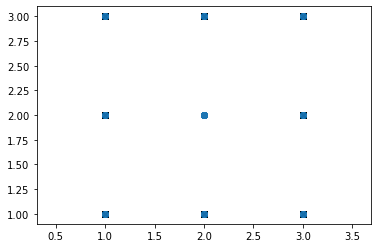

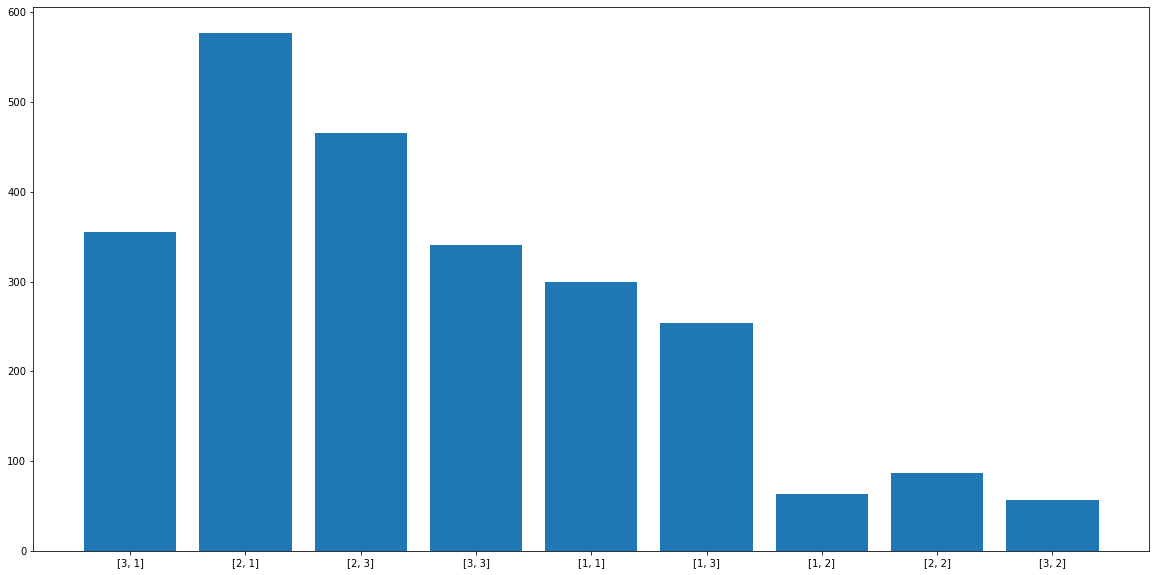

In [15]:
### Start training
for ep in range(250):
    print("Processing Epoch {}".format(ep))
    real_data = gen_real_data_onehot(dl, 128).float().cuda()
    input_data = gen_input_data(128).float().cuda()

    real_data = real_data.view(128, -1)    
    net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float().cuda()
    real_data = gen_real_data_onehot(dl, 1000).float().cuda()

#     d_fake, _ = net.g(input_data, temperature=100)
    d_fake, _ = net.g(input_data)
#     d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 1 == 0:
        plot_outputdata(real_data.data.cpu().numpy(), dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.data.cpu().numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.data.cpu().numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data]

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

Processing Epoch 0
Processing Epoch 1
Processing Epoch 2
Processing Epoch 3
Processing Epoch 4
Processing Epoch 5
Processing Epoch 6
Processing Epoch 7
Processing Epoch 8
Processing Epoch 9


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

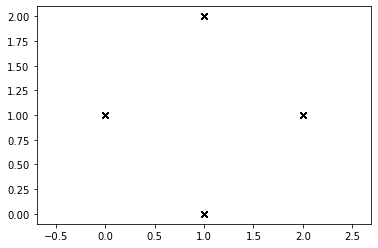

In [18]:
### Start training
for ep in range(250):
    print("Processing Epoch {}".format(ep))
#     real_data = gen_real_data_onehot(dl, 1024).float()
#     input_data = gen_input_data(1024).float()

#     real_data = real_data.view(1024, -1)    
#     net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float()
    real_data = gen_real_data_onehot(dl, 1000).float()

#     d_fake, _ = net.g(input_data, temperature=0.001)
#         d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 10 == 0:
        plot_outputdata(real_data, dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data] 

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

### Conclusion: Put Regularizer without limits would make all logits closer to 0, thus uniform noisy ~ U(0, 1)
### from gumbel reparameterization would do play a BBBBBBbig factor.
### Clearly value range (0, 0.001) would be influced greatly from U(0, 1);